# Cart Pole

In [29]:
import torch
from torch import nn, optim, tensor
# from torchsummary import summary

# import gym

from collections import deque, namedtuple

import matplotlib
import matplotlib.pyplot as plt

import random

from math import exp

import numpy as np
from itertools import compress
import time
import json
from src.Runner2048 import Game

## Setup

In [30]:
# So we can run off of the GPU for our tensors
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

# Live plots
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# plt.rcParams['figure.figsize'] = [10, 12]
plt.rcParams['figure.figsize'] = [10, 8]

print(device)

OHE = True
CNN = True
XTRA_IN = False

cuda


## Environment

In [31]:
env = Game(seed=None, board_size=4, reward_type='hs')
action_dict = {0:'U', 1:'R', 2:'D', 3:'L'}

## Parameters

In [32]:
# Parameters
nS = 16
nA = 4

# Hyperparameters
# BATCH_SIZE = 2**7
# BATCH_SIZE = 2**5
BATCH_SIZE = 256

# LAYER1_SIZE = 128
# LAYER2_SIZE = 128
# LAYER1_SIZE = 64
# LAYER2_SIZE = 128

# EPISODES_TRAINING = 1000
# EPISODES_TRAINING = 2000
EPISODES_TRAINING = 25000

ALPHA = 1e-6
# ALPHA = 1e-2
GAMMA = 0.99
# TAU = 0.005
TAU = 0.005
# TAU = 1.00
# EPSILON_MAX = 1.00
# EPSILON_MIN = 0.05
# EPSILON_DECAY = 350
EPSILON_MAX = 0.00
# EPSILON_MIN = 0.07
EPSILON_MIN = 0.08
# EPSILON_DATA = [EPSILON_MAX, EPSILON_MIN, EPSILON_DECAY]

BUFFER_SIZE = 100000
# BUFFER_SIZE = 1000

## Replay Buffer

In [33]:
SARST = namedtuple("SARST", ["S", "A", "R", "S_prime", "T"])

class ReplayBuffer(object):
    def __init__(self, size):
        self.buffer = deque([], size)
        self.probs = deque([], size)

    def push(self, *args):
        self.buffer.append(SARST(*args))
    # def push(self, *args):
    #     self.buffer.append(SARST(*args))
    #     max_val = 0
    #     if args[3] == [0]:
    #         for i in range(0,15):
    #             if torch.sum(args[0].reshape(16,4,4)[i,:,:]) > 0:
    #                 max_val = i+1
    #     else:
    #         for i in range(0,15):
    #             if torch.sum(args[3].reshape(16,4,4)[i,:,:]) > 0:
    #                 max_val = i+1
    #     # self.probs.append(max(args[3]).cpu().item())
    #     self.probs.append(2*max_val)
    #     # # Rotate the board and add it to the buffer
    #     # if (False):
    #     #     # 90 degrees CCW
    #     #     S_new = tensor([np.rot90(args[0].cpu().view(4,4)).flatten()]).to(device)
    #     #     A_new = (args[1]-1)%4
    #     #     if (args[3] == [0]):
    #     #         S_prime_new = args[3]
    #     #     else:
    #     #         S_prime_new = tensor([np.rot90(args[3].cpu().view(4,4)).flatten()]).to(device)
    #     #     self.buffer.append(SARST(S_new, A_new, args[2], S_prime_new, args[4]))

    #     #     # 180 degrees CCW
    #     #     S_new = tensor([np.rot90(S_new.cpu().view(4,4)).flatten()]).to(device)
    #     #     A_new = (A_new-1)%4
    #     #     if (args[3] == [0]):
    #     #         S_prime_new = args[3]
    #     #     else:
    #     #         S_prime_new = tensor([np.rot90(S_prime_new.cpu().view(4,4)).flatten()]).to(device)
    #     #     self.buffer.append(SARST(S_new, A_new, args[2], S_prime_new, args[4]))

    #     #     # 270 degrees CCW
    #     #     S_new = tensor([np.rot90(S_new.cpu().view(4,4)).flatten()]).to(device)
    #     #     A_new = (A_new-1)%4
    #     #     if (args[3] == [0]):
    #     #         S_prime_new = args[3]
    #     #     else:
    #     #         S_prime_new = tensor([np.rot90(S_prime_new.cpu().view(4,4)).flatten()]).to(device)
    #     #     self.buffer.append(SARST(S_new, A_new, args[2], S_prime_new, args[4]))

    #     #     # Flip Virt
    #     #     S_new = tensor([np.flip(args[0].cpu().view(4,4).numpy(), axis=0).flatten()]).to(device)
    #     #     if (args[1]%2 == 0):
    #     #         A_new = (args[1]-2)%4
    #     #     else:
    #     #         A_new = args[1]
            
    #     #     if (args[3] == [0]):
    #     #         S_prime_new = args[3]
    #     #     else:
    #     #         S_prime_new = tensor([np.flip(args[3].cpu().view(4,4).numpy(), axis=0).flatten()]).to(device)
    #     #     self.buffer.append(SARST(S_new, A_new, args[2], S_prime_new, args[4]))
            
    #     #     # Flip Horz
    #     #     S_new = tensor([np.flip(args[0].cpu().view(4,4).numpy(), axis=1).flatten()]).to(device)
    #     #     if (args[1]%2 == 1):
    #     #         A_new = (args[1]-2)%4
    #     #     else:
    #     #         A_new = args[1]
            
    #     #     if (args[3] == [0]):
    #     #         S_prime_new = args[3]
    #     #     else:
    #     #         S_prime_new = tensor([np.flip(args[3].cpu().view(4,4).numpy(), axis=1).flatten()]).to(device)
    #     #     self.buffer.append(SARST(S_new, A_new, args[2], S_prime_new, args[4]))


    def sample(self, sample_size):
        return random.sample(self.buffer, sample_size)
        # return random.choices(self.buffer, weights=np.array(self.probs), k=sample_size)
    
    def __len__(self):
        return len(self.buffer)

## One Hot Encode Board

In [34]:
def encode_state(board):
  board_flat = torch.LongTensor(board)
  board_flat = nn.functional.one_hot(board_flat, num_classes=16).float().flatten()
  board_flat = board_flat.reshape(1, 4, 4, 16).permute(0, 3, 1, 2)
  return board_flat

# # Sort in descending order, so the largest OHE is at the top and the lower are descending 
# def encode_state(board):
#   board_flat = torch.LongTensor(board)
#   board_flat = nn.functional.one_hot(board_flat, num_classes=16).float().flatten()
#   board_flat = board_flat.reshape(1, 4, 4, 16).permute(0, 3, 1, 2).flip(dims=[1])
#   zeros = board_flat[0, 15, :, :]
#   maxi = np.max(board)
  
#   i=0
#   while i < maxi:
#     temp_board = board_flat[0, i, :, :].detach().clone()
#     board_flat[0, i, :, :] = board_flat[0, 15-maxi+i, :, :].detach().clone()
#     board_flat[0, 15-maxi+i, :, :] = temp_board
#     i += 1
#   return board_flat

In [35]:
BOARDBUFF = namedtuple("BOARDBUFF", ["S", "D"]) # Board state, Game duration

class BoardBuffer(object):
    def __init__(self, size):
        self.buffer = deque([], size)

    def push(self, *args):
        self.buffer.append(BOARDBUFF(*args))

    def pop_sample(self):
        pop_index = random.randint(0, len(self.buffer)-1)
        return_board = self.buffer[pop_index]
        del self.buffer[pop_index]
        return return_board
    
    def __len__(self):
        return len(self.buffer)
    
BOARDCACHE = namedtuple("BOARDCACHE", ["S", "D"]) # Board state, Game duration

class BoardCache(object):
    def __init__(self, size):
        self.buffer = deque([], size)

    def clear(self):
        self.buffer.clear()

    def push(self, *args):
        self.buffer.append(BOARDCACHE(*args))

    def get_first(self):
        return self.buffer.popleft()
    
    def __len__(self):
        return len(self.buffer)

## DQN

Since the features that we care about only tend to be in the verical or horizontal directions, we would only want to find correlation between those. Looking in the diagonals would cause extra noise. Since we cannot move in diagonals, it would be efficient to look only vertically and horizontally. It would stand to reason that a square kernel could also learn these features, however, it would require more training and the values at the corner of the kernel would be close to, if not, zero. To achieve only looking at the vertical and horizontal moves, we used non-square kernels (shape [1,2] and [2,1]) to achieve this.

In [36]:
# class ConvBlock(nn.Module):
#     def __init__(self, in_channels, hidden_channels, out_channels):
#         super(ConvBlock, self).__init__()
#         self.conv_vert = nn.Sequential(
#             nn.Conv2d(in_channels, hidden_channels, kernel_size=(1,2), stride=1),
#             nn.ReLU()
#             )
#         self.conv_horz = nn.Sequential(
#             nn.Conv2d(in_channels, hidden_channels, kernel_size=(2,1), stride=1),
#             nn.ReLU()
#             )
#         self.conv_vert2 = nn.Sequential(
#             nn.Conv2d(hidden_channels, out_channels, kernel_size=(1,2), stride=1),
#             nn.Flatten(),
#             nn.ReLU()
#             )
#         self.conv_horz2 = nn.Sequential(
#             nn.Conv2d(hidden_channels, out_channels, kernel_size=(2,1), stride=1),
#             nn.Flatten(),
#             nn.ReLU()
#             )
    
#     def forward(self, x):
#         x_vert = self.conv_vert(x)
#         x_horz = self.conv_horz(x)
#         x_vert2vert = self.conv_vert2(x_vert)
#         x_vert2horz = self.conv_horz2(x_vert)
#         x_horz2vert = self.conv_vert2(x_horz)
#         x_horz2horz = self.conv_horz2(x_horz)
#         return torch.cat([x_vert2vert, x_vert2horz, x_horz2vert, x_horz2horz], dim=1)

# class NONSQUARE(nn.Module): # 
#     def __init__(self, HIDDEN_LAYER_1, HIDDEN_LAYER_2, OUTPUT_LAYER):
#         super(NONSQUARE, self).__init__()
#         self.network = nn.Sequential(
#             ConvBlock(16, 256, 512),
#             nn.ReLU(),
#             nn.Flatten(),   # Unnecessary?
#             nn.Linear(17408, HIDDEN_LAYER_1),
#             nn.ReLU(),
#             nn.Linear(HIDDEN_LAYER_1, HIDDEN_LAYER_2),
#             nn.ReLU(),
#             nn.Linear(HIDDEN_LAYER_2, OUTPUT_LAYER)
#             )
        
#     def forward(self, x):
#         return self.network(x)

In [55]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(ConvBlock, self).__init__()
        self.conv_2x2 = nn.Sequential(
            nn.Conv2d(in_channels, hidden_channels, kernel_size=2, stride=1),
            nn.ReLU()
            )
        self.conv_3x3 = nn.Sequential(
            nn.Conv2d(in_channels, hidden_channels, kernel_size=3, stride=1),
            nn.ReLU()
            )
        self.conv_4x4 = nn.Sequential(
            nn.Conv2d(in_channels, hidden_channels, kernel_size=4, stride=1),
            nn.Flatten(),
            nn.ReLU()
            )
        self.conv_2x2_w_2x2 = nn.Sequential(
            nn.Conv2d(hidden_channels, out_channels, kernel_size=2, stride=1),
            nn.Flatten(),
            nn.ReLU()
            )
        self.conv_3x3_w_2x2 = nn.Sequential(
            nn.Conv2d(hidden_channels, out_channels, kernel_size=2, stride=1),
            nn.Flatten(),
            nn.ReLU()
            )
        self.flatten = nn.Flatten()
    
    def forward(self, x):
        out_1x1xhid = self.conv_4x4(x)
        hid_2x2xhid = self.conv_3x3(x)
        hid_3x3xhid = self.conv_2x2(x)
        out_1x1xout = self.conv_2x2_w_2x2(hid_2x2xhid)
        out_2x2xout = self.conv_3x3_w_2x2(hid_3x3xhid)
        return torch.cat([out_1x1xhid, self.flatten(hid_2x2xhid), out_1x1xout, out_2x2xout], dim=1)

class CNN234(nn.Module): # 
    def __init__(self, HIDDEN_LAYER_1, HIDDEN_LAYER_2, OUTPUT_LAYER):
        super(CNN234, self).__init__()
        self.network = nn.Sequential(
            ConvBlock(16, 256, 512),
            nn.ReLU(),
            nn.Flatten(),   # Unnecessary?
            nn.Linear(3840, HIDDEN_LAYER_1),
            nn.ReLU(),
            nn.Linear(HIDDEN_LAYER_1, HIDDEN_LAYER_2),
            nn.ReLU(),
            nn.Linear(HIDDEN_LAYER_2, OUTPUT_LAYER)
            )
        
    def forward(self, x):
        return self.network(x)

In [38]:

class ConvBlock(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(ConvBlock, self).__init__()
        # self.convA = nn.Sequential(
        #     nn.Conv2d(in_channels, hidden_channels, kernel_size=3, stride=1, padding='same'),
        #     nn.ReLU()
        #     )
        # self.convB = nn.Sequential(
        #     nn.Conv2d(in_channels, hidden_channels, kernel_size=2, stride=1, padding='same'),
        #     nn.ReLU()
        #     )
        self.conv_vert = nn.Sequential(
            nn.Conv2d(in_channels, hidden_channels, kernel_size=(1,2), stride=1),
            nn.ReLU()
            )
        self.conv_horz = nn.Sequential(
            nn.Conv2d(in_channels, hidden_channels, kernel_size=(2,1), stride=1),
            nn.ReLU()
            )
        self.conv_vert2 = nn.Sequential(
            nn.Conv2d(hidden_channels, out_channels, kernel_size=(1,2), stride=1),
            nn.Flatten(),
            nn.ReLU()
            )
        self.conv_horz2 = nn.Sequential(
            nn.Conv2d(hidden_channels, out_channels, kernel_size=(2,1), stride=1),
            nn.Flatten(),
            nn.ReLU()
            )
    
    def forward(self, x):
        x_vert = self.conv_vert(x)
        x_horz = self.conv_horz(x)
        x_vert2vert = self.conv_vert2(x_vert)
        x_vert2horz = self.conv_horz2(x_vert)
        x_horz2vert = self.conv_vert2(x_horz)
        x_horz2horz = self.conv_horz2(x_horz)
        return torch.cat([x_vert2vert, x_vert2horz, x_horz2vert, x_horz2horz], dim=1)

class NONSQUARE(nn.Module): # 
    def __init__(self, HIDDEN_LAYER_1, HIDDEN_LAYER_2, OUTPUT_LAYER):
        super(NONSQUARE, self).__init__()
        self.network = nn.Sequential(
            ConvBlock(16, 256, 256),
            nn.ReLU(),
            nn.Flatten(),   # Unnecessary?
            nn.Linear(8704, HIDDEN_LAYER_1),
            nn.ReLU(),
            nn.Linear(HIDDEN_LAYER_1, HIDDEN_LAYER_2),
            nn.ReLU(),
            nn.Linear(HIDDEN_LAYER_2, OUTPUT_LAYER)
            )
        
    def forward(self, x):
        return self.network(x)

## Minimax Player
    Reference: 
    Stuart Russell, Peter Norvig - Artificial Intelligence A Modern Approach - Pearson Higher Education (2019)

The utility will be the evaluation of the policy network. When it is the agents move, the utility value will simply be the q-value of the action taken. When the computer places a piece on the board, the utility value will be the argmax of the new board. 

In [39]:
import copy
# Inputs
#  The game
#  The policy that was used to make the move
#  The Q-value from the action to get to this state
def minimax(game, policy, value_from_action, depth=3, my_turn=True):

    best_action = None


    # See if the game is over or we've reached the depth limit
    if depth <= 1 or game.is_game_over():
        val = value_from_action
        return (best_action, val)

    if my_turn:
        # Want to maximize 
        val = float('-inf')
        actions = game.get_possible_moves()
        if len(actions) == 1:
            best_action = actions[0]

        for A in actions:
            # Make the move
            temp_game = copy.deepcopy(game)
            
            (reward, terminated, updated, invalid_moves, invalid_moves_made) = temp_game.swipe(action_dict[A], adversarial=False)
            value_from_action = max(policy(encode_state(temp_game.get_flat_board()))).item()
            (tempBestMove, tempVal) = minimax(temp_game, policy, value_from_action, depth-1, not my_turn)
    else:
        # Want to minimize
        val = float('inf')
        actions = game.get_avaliable_spaces()
        for tile_val in [2, 4]:
            for A in actions:
                # Make the move
                row = int(A / 4)
                col = A % 4
                temp_game = copy.deepcopy(game)
                temp_game.add_tile_to_board(row, col, tile_val)
                # (tempBestMove, tempVal) = minimax(temp_game, policy, value_from_action, depth-1, not my_turn)




    return best_action, val

## Epsilon Greedy

In [40]:
def epsilonGreedy(state, network, nA, epsilon, invalid_actions):
    # Decide if we are going to be greedy or not
    greedy = (random.random() > epsilon)

    if greedy:
        # Pick best action, if tie, use lowest index
        with torch.no_grad():   # Speeds up computation
            if (not CNN):
                # Change for NN
                output = network(torch.FloatTensor(state))
                for invalid in invalid_actions:
                    output[0, invalid] = -torch.inf
                return output.argmax().item()
            else:
                # Change for CNN
                output = network(state.view(1,16,4,4))
                # output = network(state.view(1,1,4,4))
                for invalid in invalid_actions:
                    output[0, invalid] = -torch.inf
                return output.argmax().item()
                # return network(state.view(1,1,4,4)).argmax().item()

    else:
        # Explore
        valid_actions = list(range(nA))
        for invalid in invalid_actions:
            valid_actions.remove(invalid)
        return random.choice(valid_actions)
        # return tensor(random.randint(0, nA-1), device=device, dtype=torch.long).item()


## Setup

In [56]:
if (not CNN):
    if (not XTRA_IN):
        policy_net = DQN(nS, LAYER1_SIZE, LAYER2_SIZE, nA).to(device)       # Change for NN
        target_net = DQN(nS, LAYER1_SIZE, LAYER2_SIZE, nA).to(device)       # Change for NN
    else:
        policy_net = DQN2(nS, LAYER1_SIZE, LAYER2_SIZE, nA).to(device)       # Change for NN
        target_net = DQN2(nS, LAYER1_SIZE, LAYER2_SIZE, nA).to(device)       # Change for NN
    # policy_net = DQCNN(3, LAYER1_SIZE, LAYER2_SIZE, nA).to(device)
    # target_net = DQCNN(3, LAYER1_SIZE, LAYER2_SIZE, nA).to(device)
else:
    # policy_net = HLCNN(nA).to(device)                                 # Change for CNN
    # target_net = HLCNN(nA).to(device)                                 # Change for CNN
    # policy_net = DQCNN16(1024, 4).to(device)                                 # Change for CNN
    # target_net = DQCNN16(1024, 4).to(device)                                 # Change for CNN
    # policy_net = NONSQUARE(2048, 256, 4).to(device)                                 # Change for NONSQUARE
    # target_net = NONSQUARE(2048, 256, 4).to(device)                                 # Change for NONSQUARE
    policy_net = CNN234(1024, 256, 4).to(device)                                 # Change for CNN234
    target_net = CNN234(1024, 256, 4).to(device)                                 # Change for CNN234                              # Change for CNN234
    # policy_net = NONSQUARE(2048, 256, 4).to(device)                                 # Change for CNN234
    # target_net = NONSQUARE(2048, 256, 4).to(device)   

load_model = True
if load_model:
    model_path = 'backup_trained_models\cnn_256_consistent.pth'
    target_net.load_state_dict(torch.load(model_path))
    policy_net.load_state_dict(torch.load(model_path))
else:
    target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=ALPHA, amsgrad=True)
RB = ReplayBuffer(BUFFER_SIZE)


In [42]:
# steps = 0
# def getEpsilon():
#     global steps
#     epsilon = EPSILON_MIN + (EPSILON_MAX - EPSILON_MIN)*exp(-steps/EPSILON_DECAY)
#     steps += 1
#     return epsilon

# max_game = 0
max_game = 1
def getEpsilon(game_duration):
    global max_game
    if (max_game == 0):
        return 1
    epsilon = EPSILON_MIN + (EPSILON_MAX - EPSILON_MIN)*exp(-game_duration/(max_game))
    return epsilon

## Stolen Plot Function

In [43]:
def plot_multi(title, axis, args, save_string=""):
    threshold = 50
    n_plots = len(args)
    plt.clf()
    fig, ax = plt.subplots(n_plots, 1, sharex=True)
    for argi, arg in enumerate(args):
        data = torch.tensor(arg, dtype=torch.float)
        if len(data) > threshold:
            ax[argi].set_title(title[argi])
            ax[argi].set_ylabel(axis[argi])
            ax[argi].step(list(range(len(data)))[threshold:], data[threshold:])
            ax[argi].grid()
            ax[argi].minorticks_on()


            # Take threshold episode averages and plot them too
            if len(arg) >= threshold:
                means = data.unfold(0, threshold, 1).mean(1).view(-1)
                ax[argi].plot(list(range(threshold, len(data))), means.numpy()[1:])
            
    plt.xlabel('Episode')
    plt.pause(0.001)  # pause a bit so that plots are updated
    display.clear_output(wait=True)
    if save_string != "":
        fig.savefig("./figures/"+save_string+".png")

##

In [44]:
def train():
    minibatch_awk = RB.sample(BATCH_SIZE)
    minibatch = SARST(*zip(*minibatch_awk))
    
    N = len(minibatch.S)

    S = torch.cat(minibatch.S).to(device)
    if (CNN):
        # S = S.view(N, 1, 4, 4)
        S = S.view(N, 16, 4, 4)
    A = minibatch.A
    torch_R = torch.cat(minibatch.R).to(device)
    torch_maxQ = torch.zeros(N, 1).to(device)
    nonterm_mask = tensor(minibatch.T).to(device)
    # term_mask = tensor(list(np.array(minibatch.T)==False))
        
    Q_SA = policy_net(S).gather(1, torch.reshape(tensor(A).to(device), [N, 1]))
    
    with torch.no_grad():
        if (not CNN):
            # Change for NN
            S_prime_masked =  list(compress(minibatch.S_prime, minibatch.T))
            torch_maxQ[nonterm_mask] = torch.reshape(target_net(torch.cat(S_prime_masked)).max(1)[0], [sum(nonterm_mask).item(), 1])
        else:
            # Change for CNN
            S_prime_masked =  list(compress(minibatch.S_prime, minibatch.T))
            # torch_maxQ[nonterm_mask] = torch.reshape(target_net(torch.cat(S_prime_masked).to(device).view(sum(nonterm_mask), 1, 4, 4)).max(1)[0], [sum(nonterm_mask).item(), 1])
            torch_maxQ[nonterm_mask] = torch.reshape(target_net(torch.cat(S_prime_masked).to(device).view(sum(nonterm_mask), 16, 4, 4)).max(1)[0], [sum(nonterm_mask).item(), 1])


    y = (torch_maxQ * GAMMA) + torch_R

    # Compute Huber loss
    # criterion = nn.SmoothL1Loss()
    # loss = criterion(Q_SA, y)

    # # MSE
    criterion = nn.MSELoss()
    loss = criterion(Q_SA, y)
    # loss = loss.clamp(min=-1, max=1)

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

    return loss.item()
    

In [45]:
episodic_rewards = []
episodic_loss = []
episodic_epsilon = []
episodic_duration = []
episdoic_max_tile = []
episodic_invalid_moves_made_count = []

def DQN_network(episodes):
    
    # burn in to collect batch data
    for i in range(1000):
        if (not XTRA_IN):
            S = env.reset()   
        else:
            S = np.append(env.reset(), [env.game_duration, env.largest_value])
        
        if (OHE):
            S = encode_state(S).flatten()
            S = torch.tensor(S, dtype=torch.float32, device=device)
        else:
            S = torch.tensor([S], dtype=torch.float32, device=device)
            
            while not terminated:
                valid_actions = env.get_possible_moves()
                A = random.randchoice(valid_actions)
                (reward, terminated, updated, invalid_moves, invalid_moves_made) = env.swipe(action_dict[A])
                if (not XTRA_IN):
                    S_prime = env.get_flat_board()
                else:
                    S_prime = np.append(env.get_flat_board(), [env.game_duration, env.largest_value])
                    
                if (OHE):
                    S_prime = encode_state(S_prime).flatten()
                    S_prime = [0] if terminated else tensor(S_prime, dtype=torch.float32, device=device)
                else:
                    # S_prime = None if terminated else tensor(torch.FloatTensor(S_prime).to(device), requires_grad=True)
                    S_prime = [0] if terminated else tensor([S_prime], dtype=torch.float32, device=device)

                # Store the transition
                # RB.push(S, A, tensor([[reward]], dtype=torch.float32, device=device), 
                #         S_prime, tensor(not terminated, device=device, dtype=torch.bool))
                RB.push(S, A, tensor([[reward]], dtype=torch.float32, device=device), 
                        S_prime, not terminated)

                S = S_prime
    
    
    global max_game
    save_tag = "hs"
    start_time = time.time()
    T = 0
    for epi in range(episodes):

        if (not XTRA_IN):
            S = env.reset()   
        else:
            S = np.append(env.reset(), [env.game_duration, env.largest_value])
        
        if (OHE):
            S = encode_state(S).flatten()
            S = torch.tensor(S, dtype=torch.float32, device=device)
        else:
            S = torch.tensor([S], dtype=torch.float32, device=device)

        episodic_reward = 0
        episodic_mean_loss = 0
        terminated = False
        episodic_invalid_moves_made = 0
        
        mini_duration = 0

        invalid_moves = []
        reward_vect = []
        game_states = []
        action_vect = []
        while not terminated:
            T += 1
            mini_duration += 1

            epsilon = getEpsilon(env.game_duration)
            # Choose action
            A = epsilonGreedy(S, policy_net, nA, epsilon, invalid_moves)
            # Take step
            (reward, terminated, updated, invalid_moves, invalid_moves_made) = env.swipe(action_dict[A])
            if (not XTRA_IN):
                S_prime = env.get_flat_board()
            else:
                S_prime = np.append(env.get_flat_board(), [env.game_duration, env.largest_value])
            
            episodic_invalid_moves_made += invalid_moves_made

            if (OHE):
                S_prime = encode_state(S_prime).flatten()
                S_prime = [0] if terminated else tensor(S_prime, dtype=torch.float32, device=device)
            else:
                # S_prime = None if terminated else tensor(torch.FloatTensor(S_prime).to(device), requires_grad=True)
                S_prime = [0] if terminated else tensor([S_prime], dtype=torch.float32, device=device)

            # Store the transition
            # RB.push(S, A, tensor([[reward]], dtype=torch.float32, device=device), 
            #         S_prime, tensor(not terminated, device=device, dtype=torch.bool))
            RB.push(S, A, tensor([[reward]], dtype=torch.float32, device=device), 
                    S_prime, not terminated)

            S = S_prime
            
            # Update the networks networks
            if len(RB) > BATCH_SIZE:
                episodic_mean_loss += train()
                
            episodic_reward += reward

            if T%20==0:
                # Soft update of the target network's weights
                target_net_state_dict = target_net.state_dict()
                policy_net_state_dict = policy_net.state_dict()
                for key in policy_net_state_dict:
                    target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
                target_net.load_state_dict(target_net_state_dict)
            
            game_states.append(np.copy(env.board))
            action_vect.append(action_dict[A])
            reward_vect.append(env.reward_vect)

        episodic_epsilon.append(epsilon)
        episodic_loss.append(episodic_mean_loss/T)
        episodic_rewards.append(episodic_reward)
        episodic_duration.append(env.game_duration)
        episdoic_max_tile.append(np.log2(env.largest_value))
        episodic_invalid_moves_made_count.append(episodic_invalid_moves_made)

        # if len(episodic_duration) < 10:
        #     max_game = 0
        if len(episodic_duration) < 50:
            max_game = max(max_game, env.game_duration)
        else:
            max_game = max(episodic_duration[-50:])
        if epi % 100 == 0:
            save_string = "_policy_weights_episode_"+str(epi).zfill(4)
            torch.save(target_net.state_dict(), "./trained_models/"+save_tag+"_"+"target"+save_string+".pth")
            torch.save(policy_net.state_dict(), "./trained_models/"+save_tag+"_"+"policy"+save_string+".pth")
            plot_multi(["Reward History", "Loss History", "Duration", "Max Tile History", "Epsilon History"], 
                       ["Reward", "Loss", "Duration", "Max Tile Value", "Epsilon"], 
                       [episodic_rewards, episodic_loss, episodic_duration, episdoic_max_tile, episodic_epsilon], save_string="model_"+save_tag+"")

        if epi % 5 == 0:
            print(epi)
            env.display()
            plot_multi(["Training Rewards...", "Training Loss...", "Duration...", "Max Tile Value...", "Epsilon Value..."], 
                        ["Reward", "Mean Episode Loss", "Duration", "Max Tile Value", "Epsilon"], 
                        [episodic_rewards, episodic_loss, episodic_duration, episdoic_max_tile, episodic_epsilon])
            
        if epi % 25 == 0:
            with open('rewards.txt', 'w') as f:
                for i, state in enumerate(game_states):
                    f.write('State:\n {}\n'.format(state))
                    f.write('Action: {}\n'.format(action_vect[i]))
                    f.write('Reward: {}\n'.format(reward_vect[i]))
                    f.write('Total Reward: {}\n'.format(sum(reward_vect[i])))
                    f.write('\n')
                
    
    delta_time = time.time()-start_time
    
    plt.ioff()
    plt.show()
    
    # Save data
    # data_file = open("./trainged_models/data.json", 'w+')
    # json_data = {"episodic_rewards": episodic_rewards, 
    #                 "episodic_loss": episodic_loss, 
    #                 "episodic_epsilon": episodic_epsilon,
    #                 "training_time": delta_time
    #                 }
    # json.dump(json_data, data_file)

In [46]:
DQN_network(EPISODES_TRAINING)

KeyboardInterrupt: 

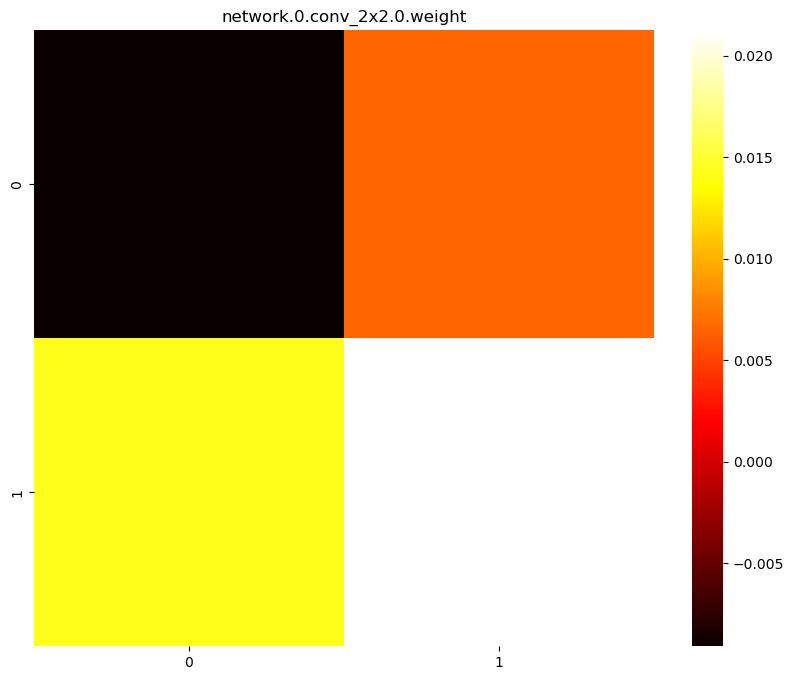

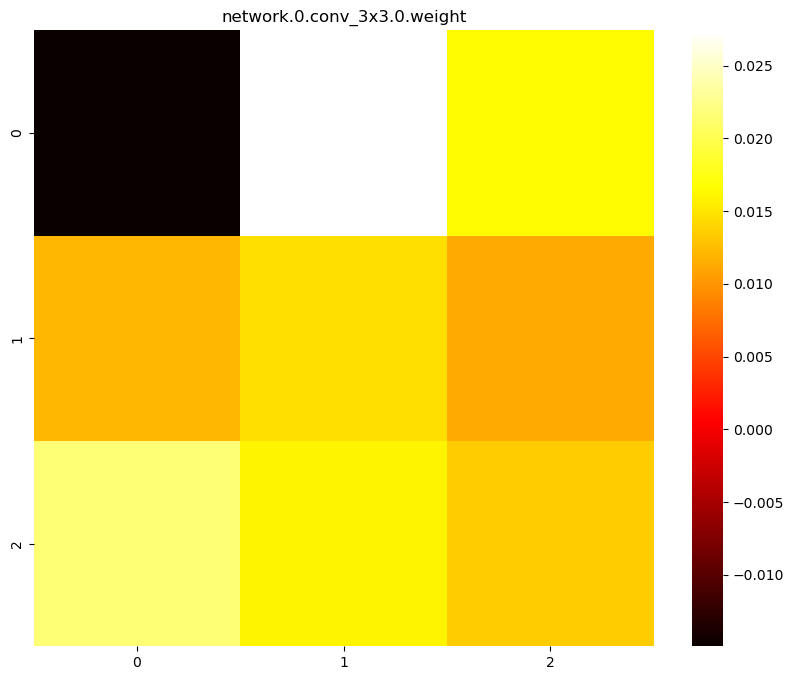

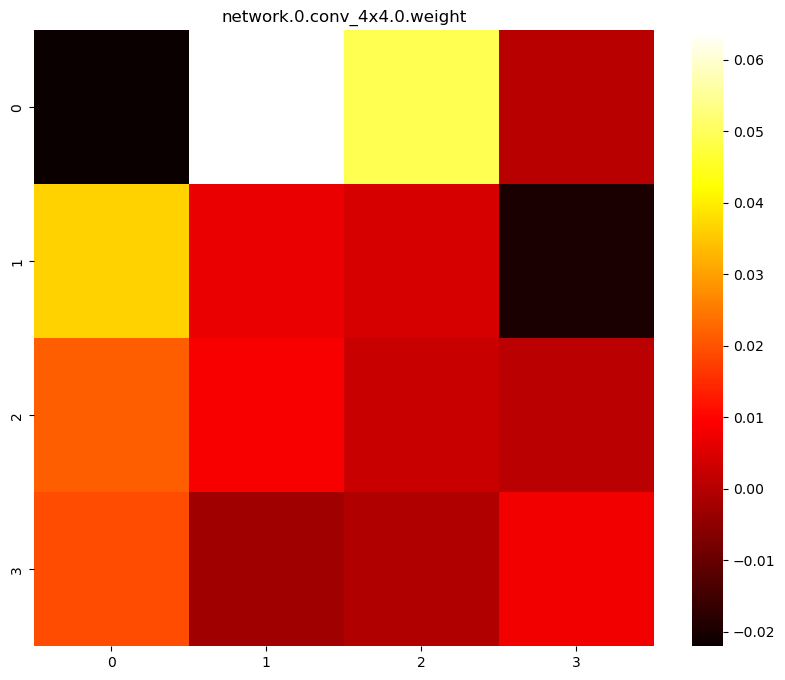

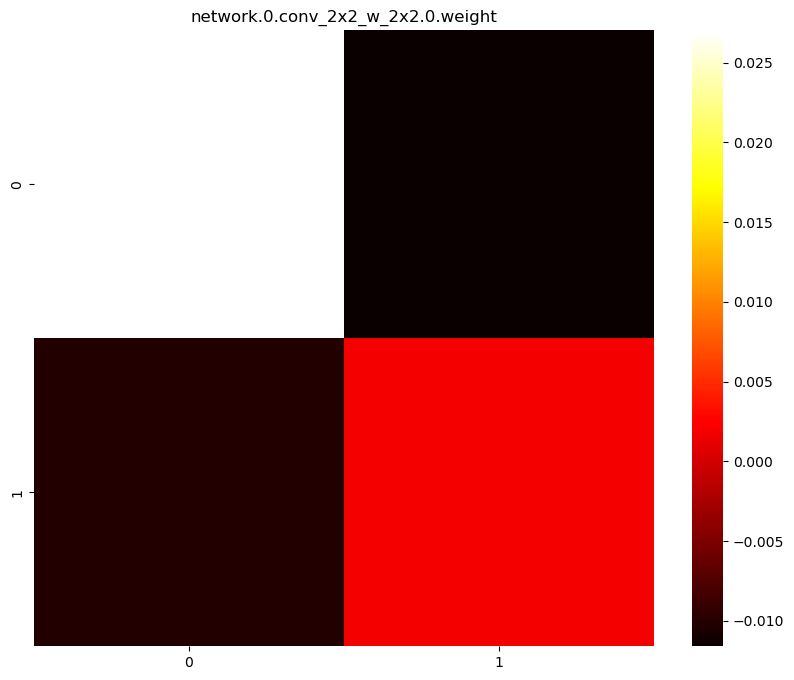

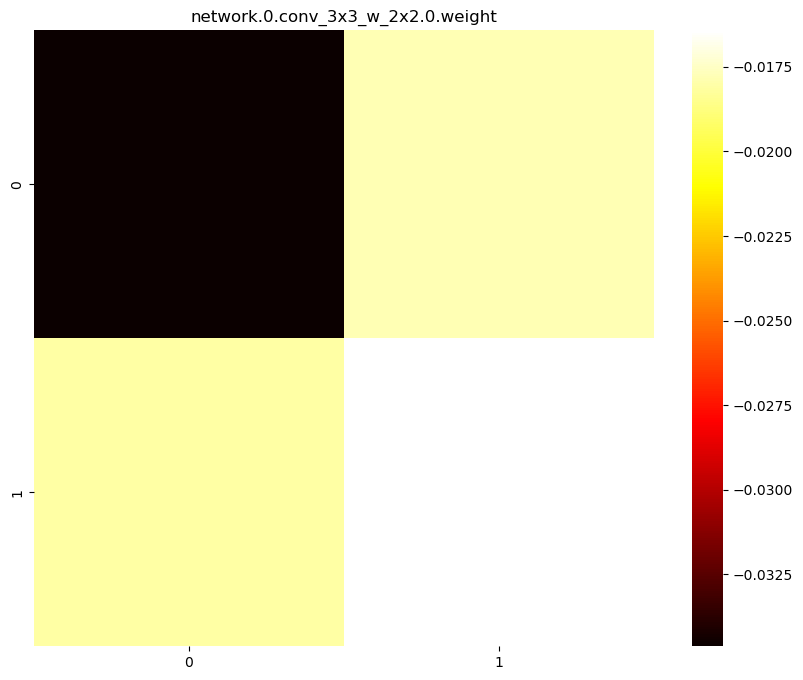

In [59]:
import seaborn as sns

def plot_heatmap(model):
    for name, param in model.named_parameters():
        if param.requires_grad and 'weight' in name and 'conv' in name:
            avg_kernel = np.mean(param.data.cpu().numpy(), axis=0)
            plt.figure()
            plt.title(name)
            sns.heatmap(avg_kernel[0], cmap='hot', cbar=True)
            plt.show()
            
plot_heatmap(policy_net)

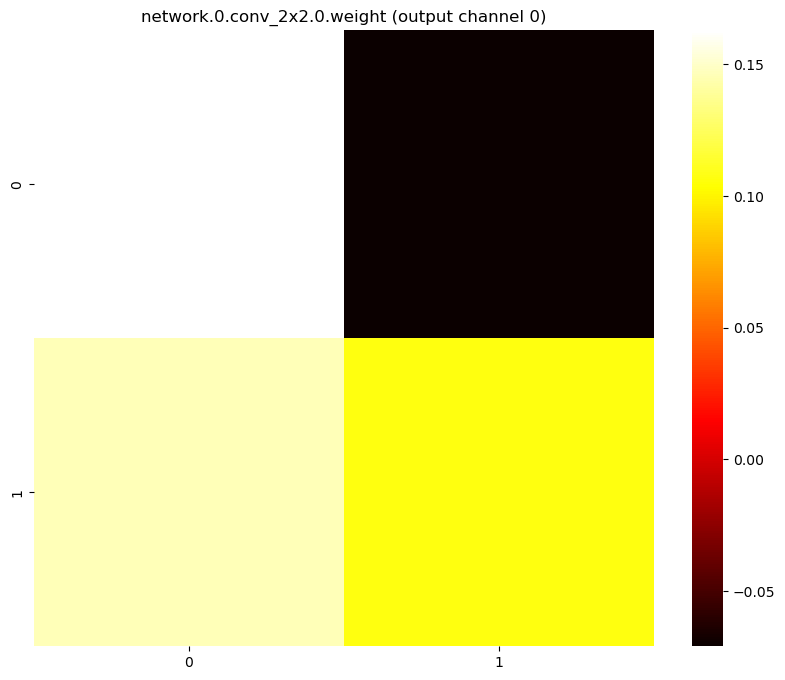

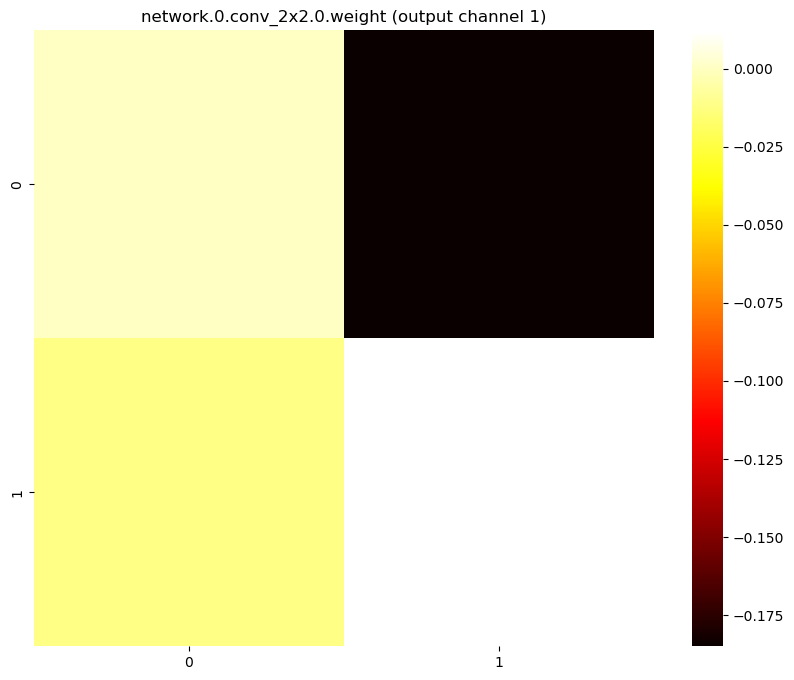

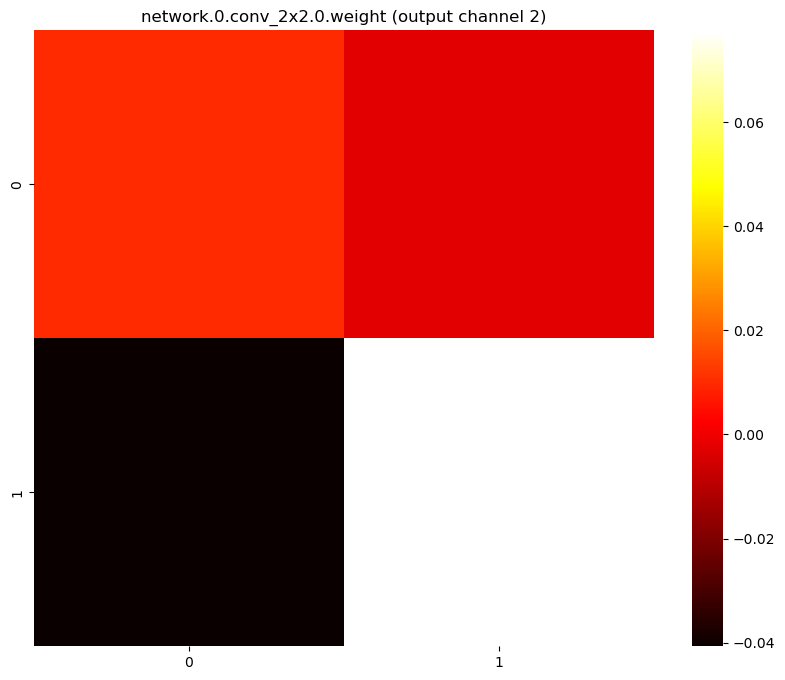

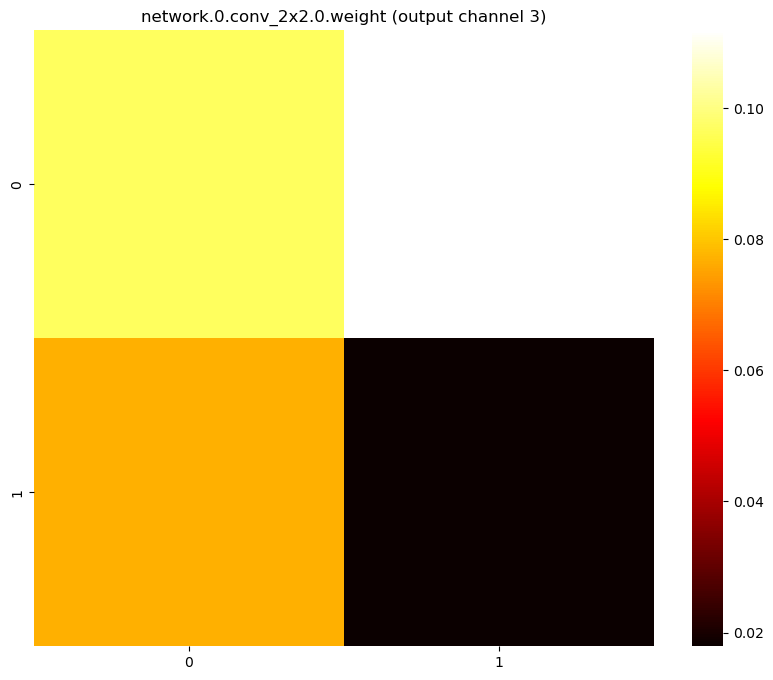

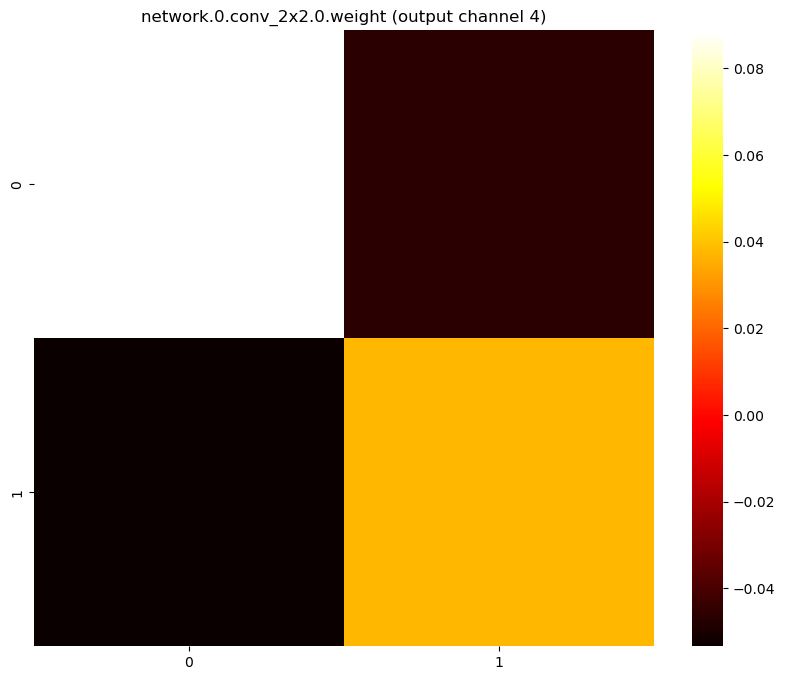

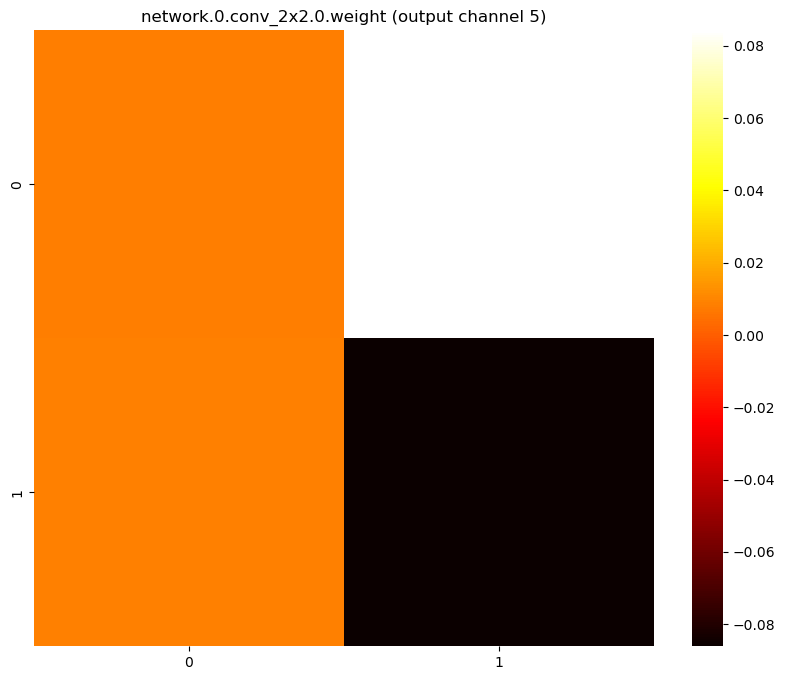

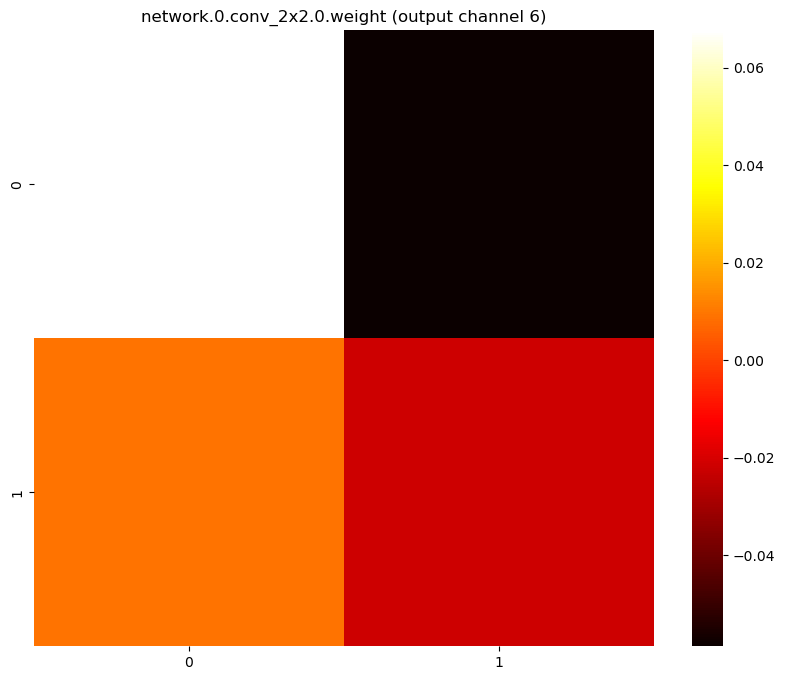

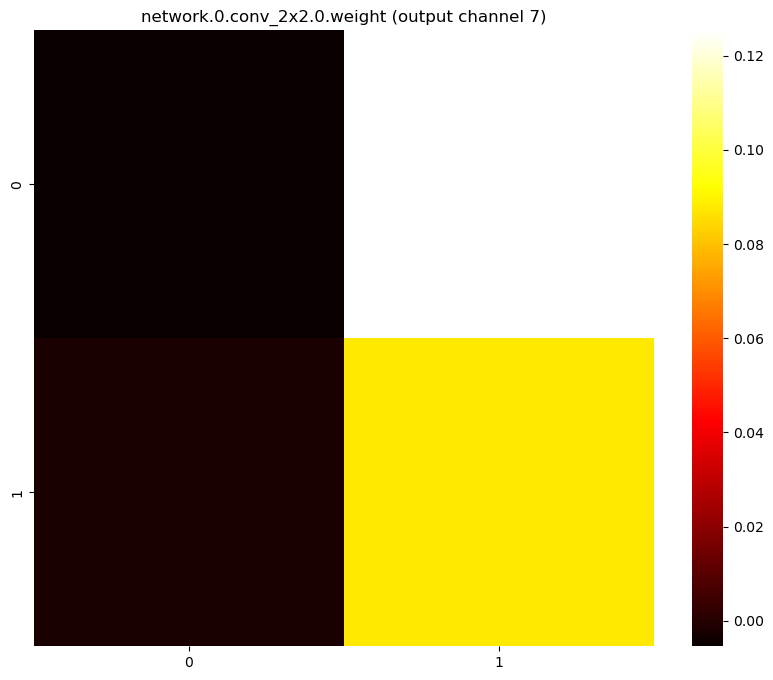

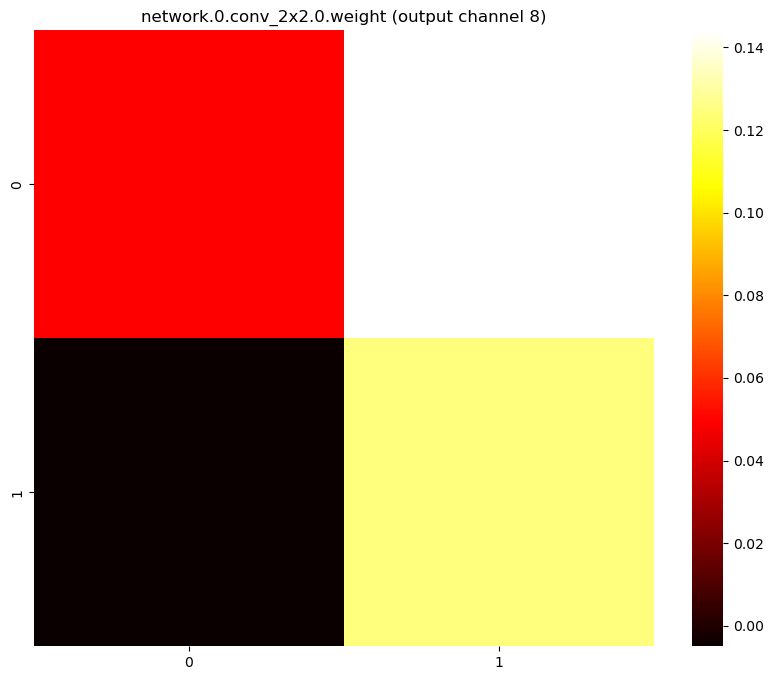

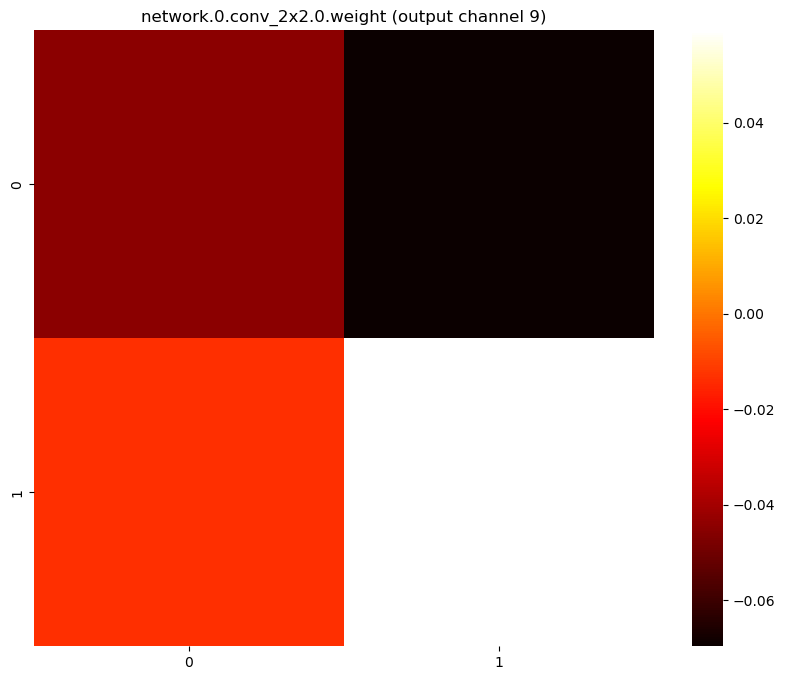

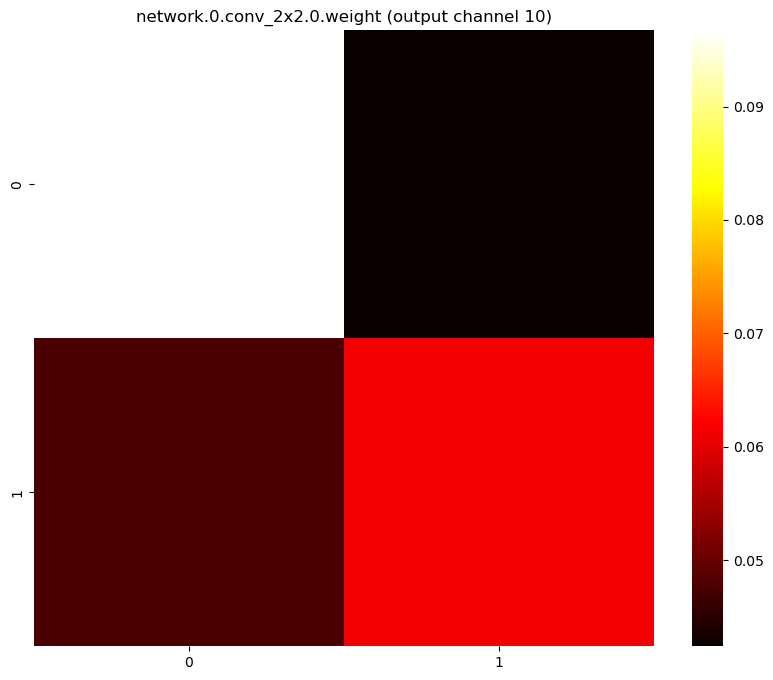

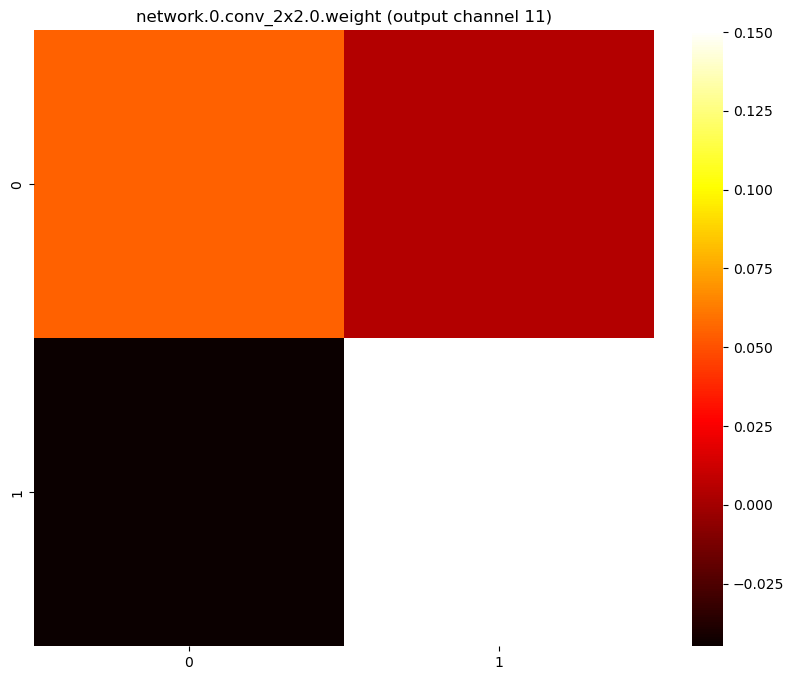

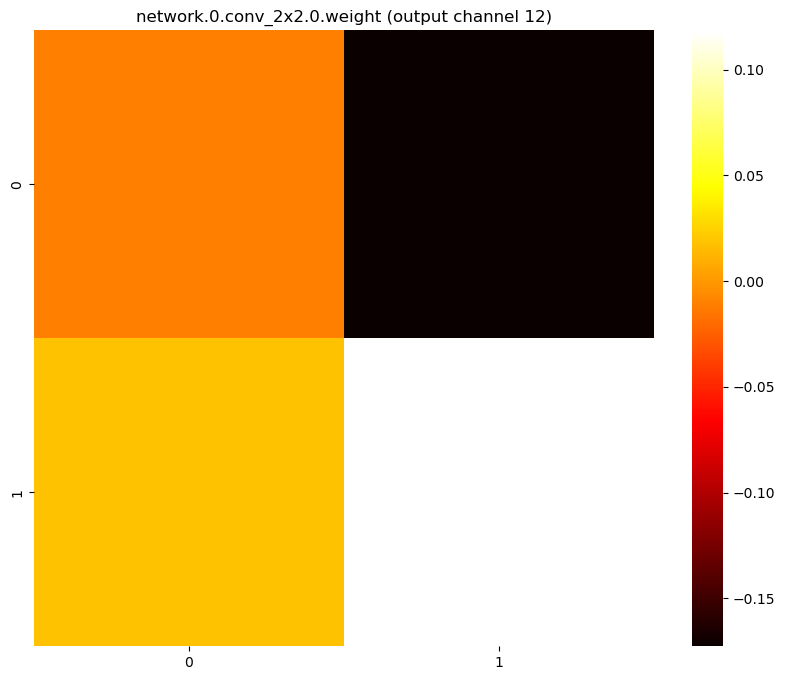

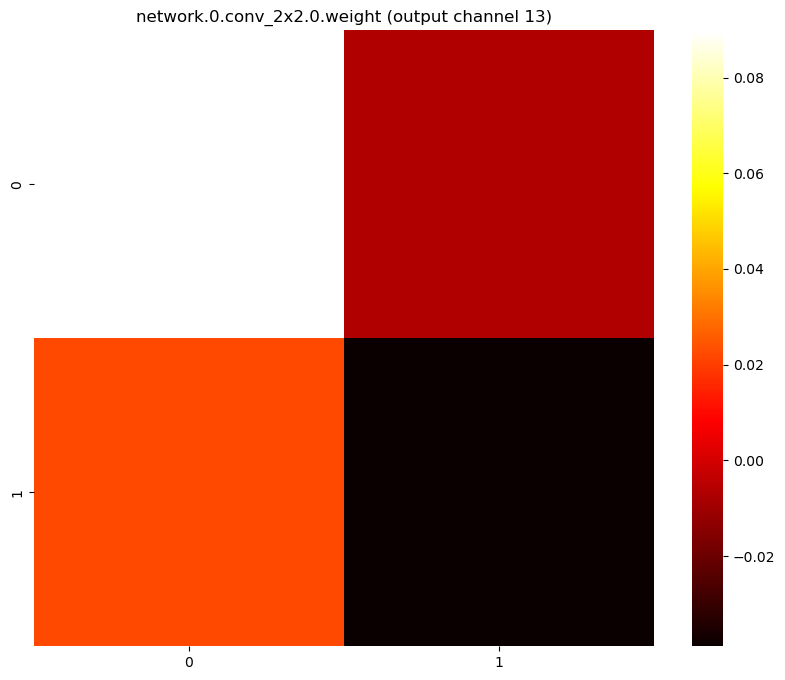

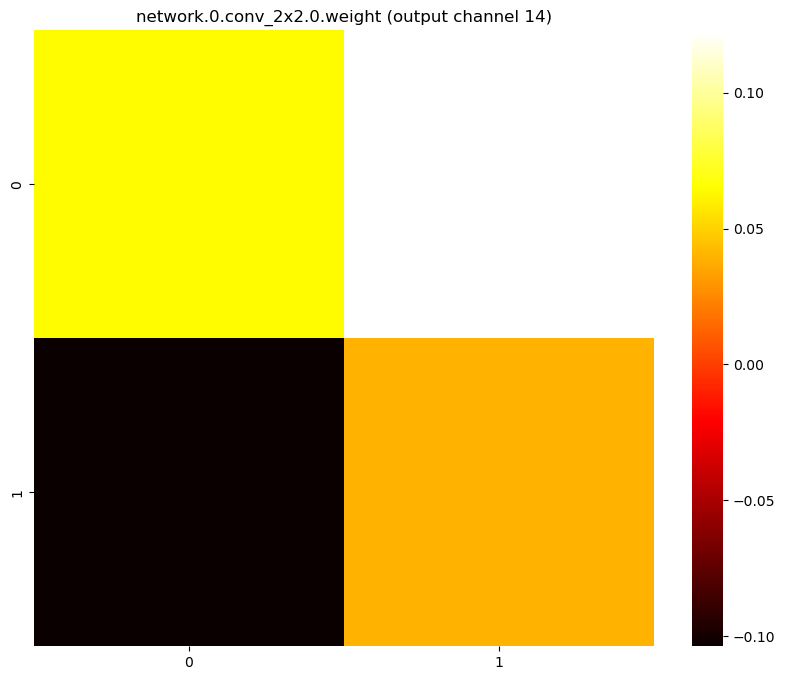

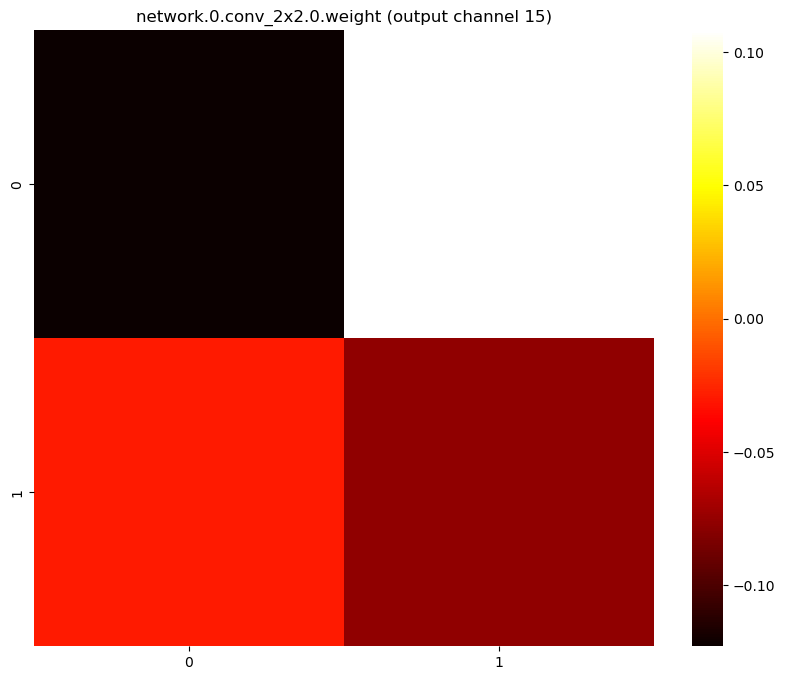

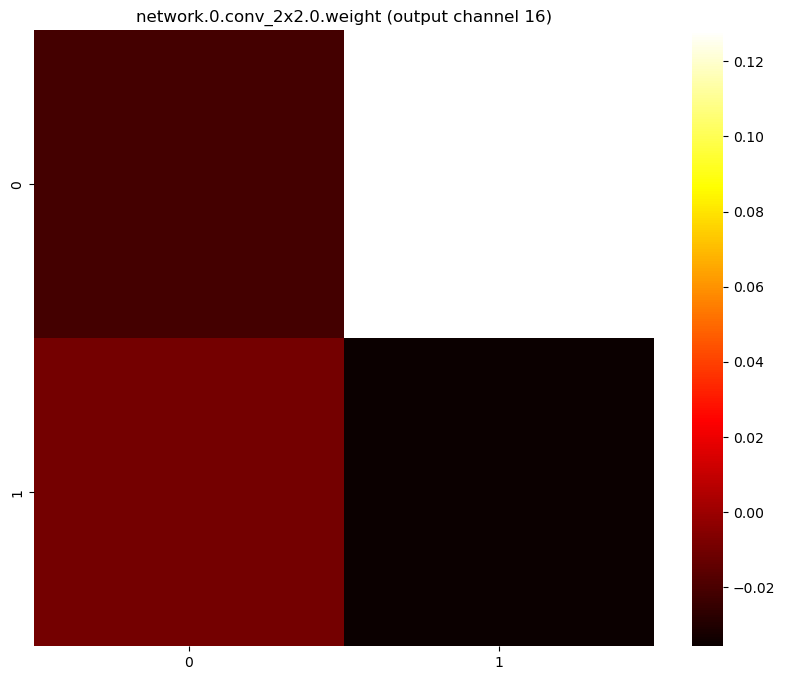

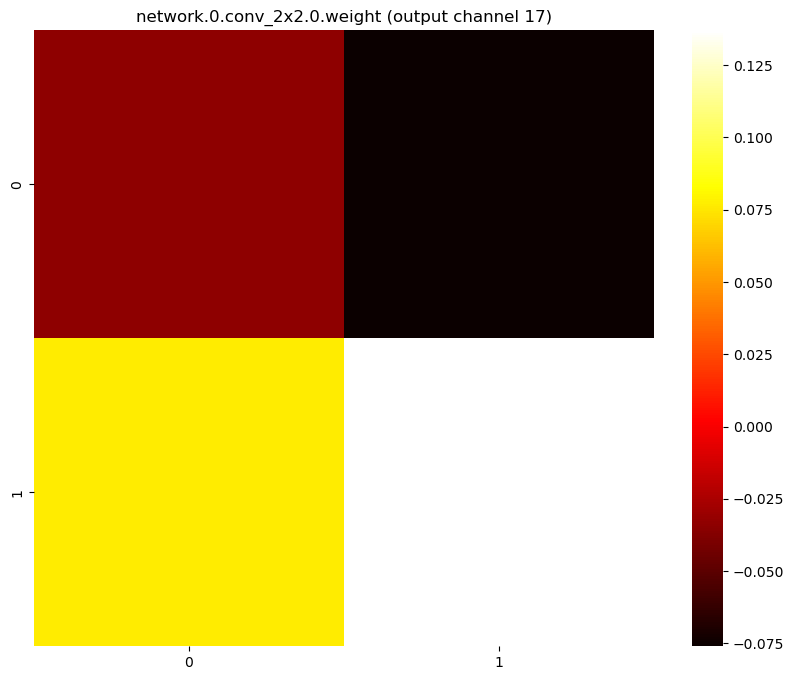

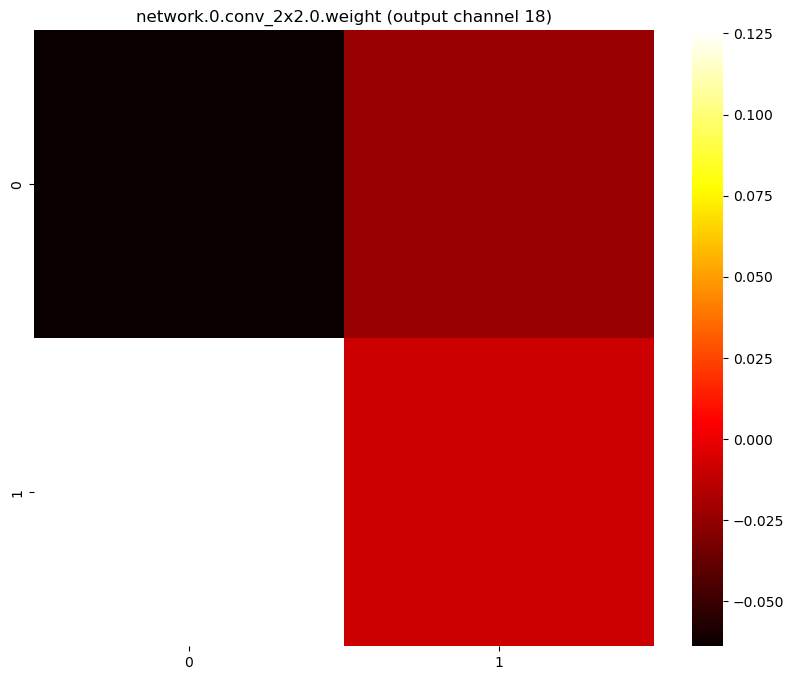

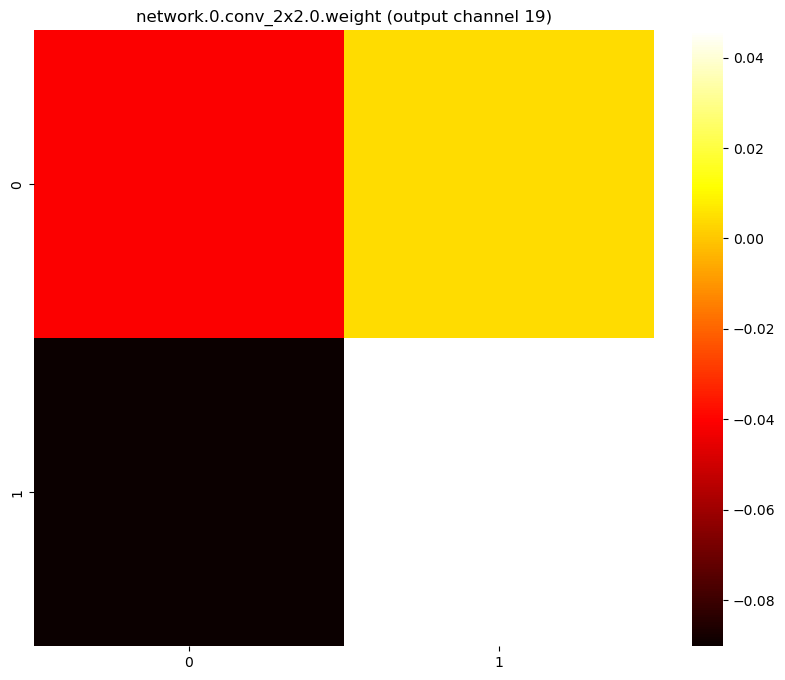

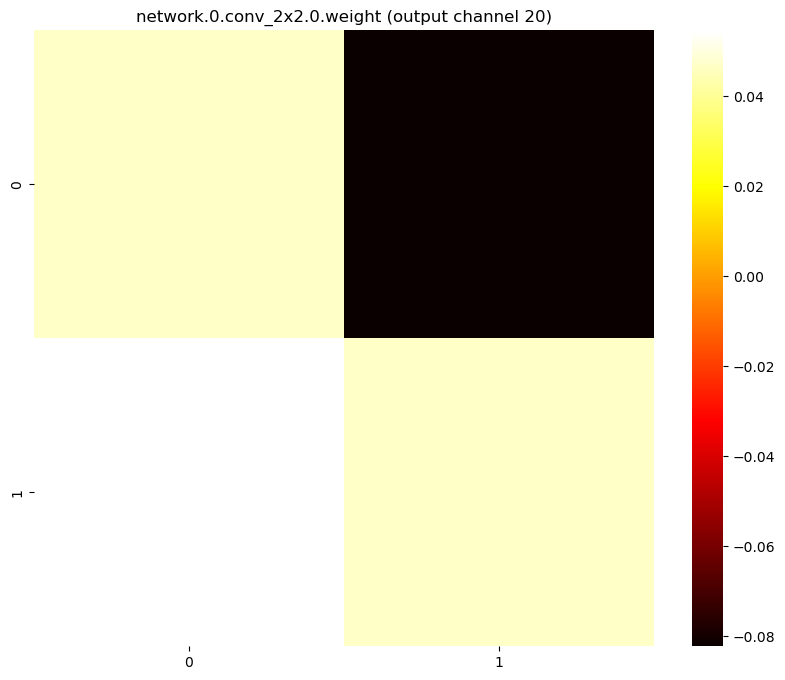

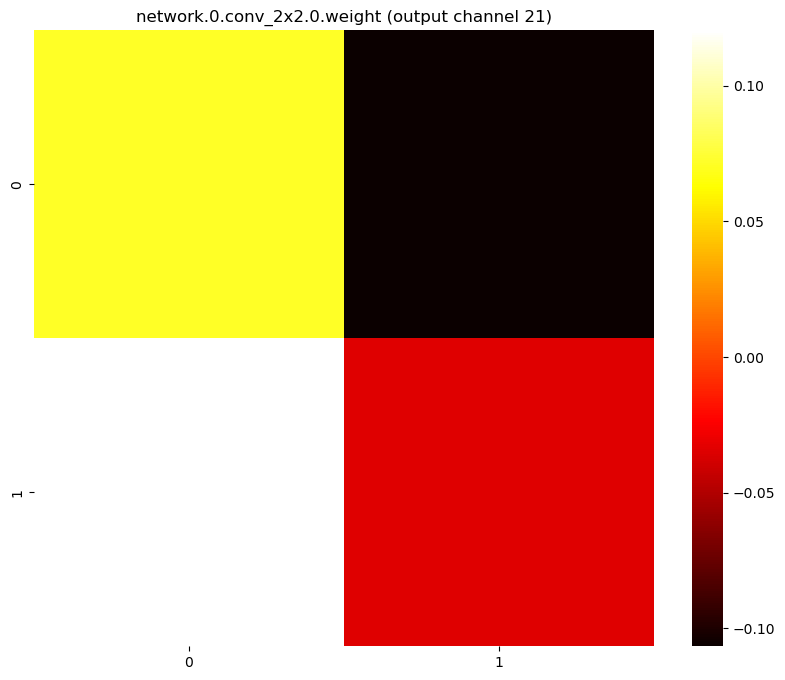

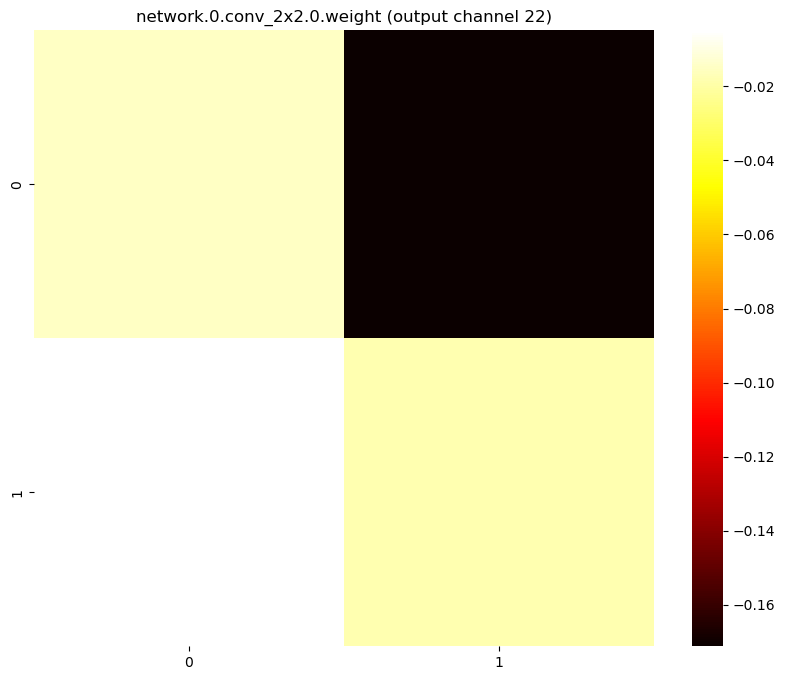

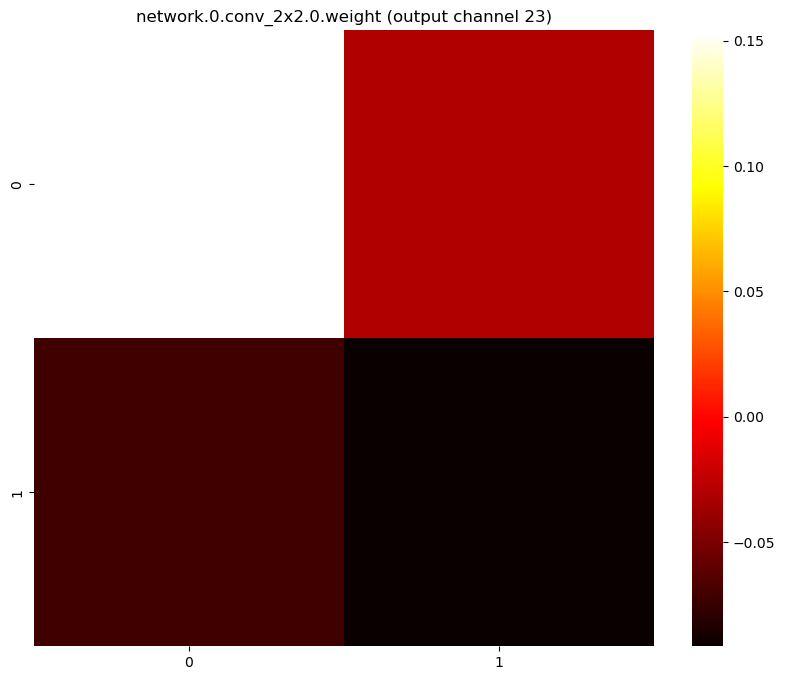

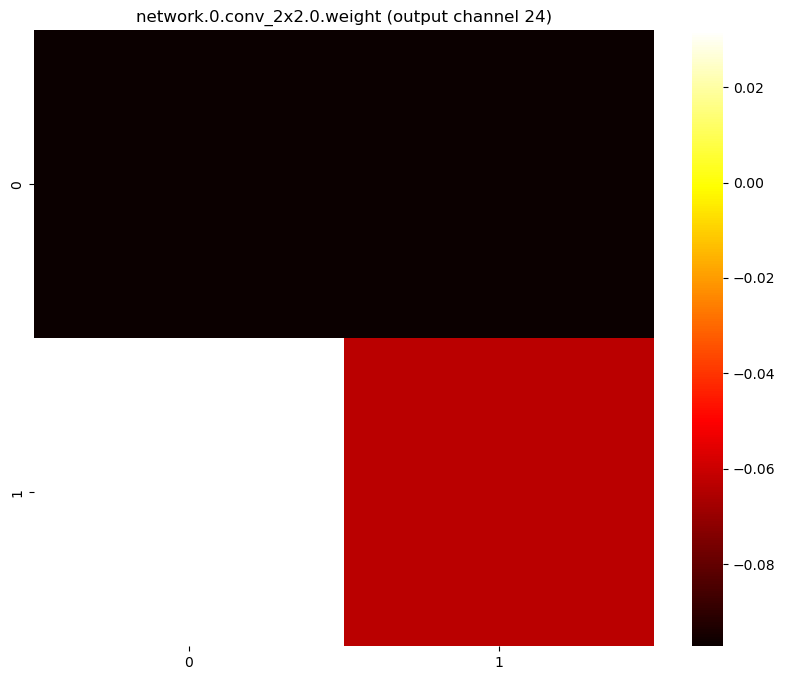

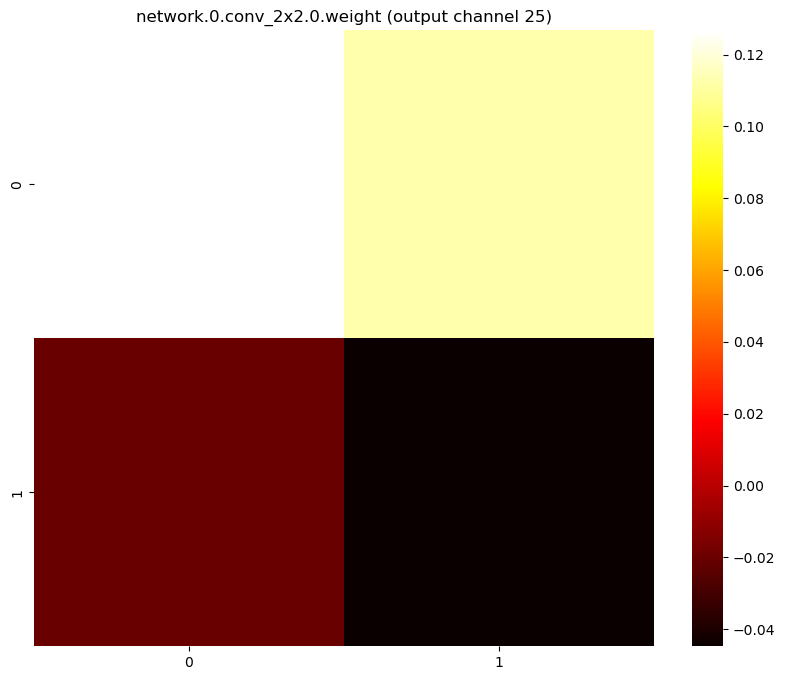

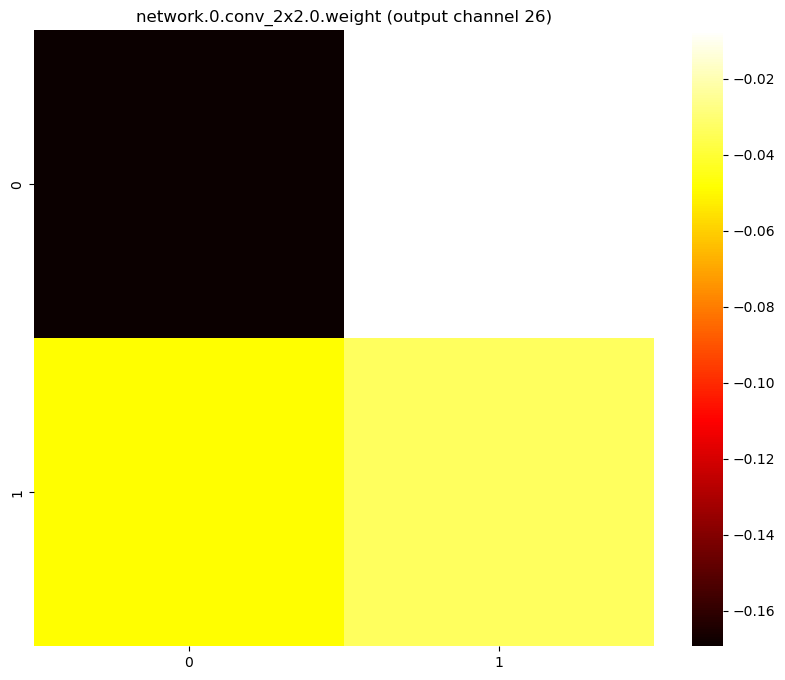

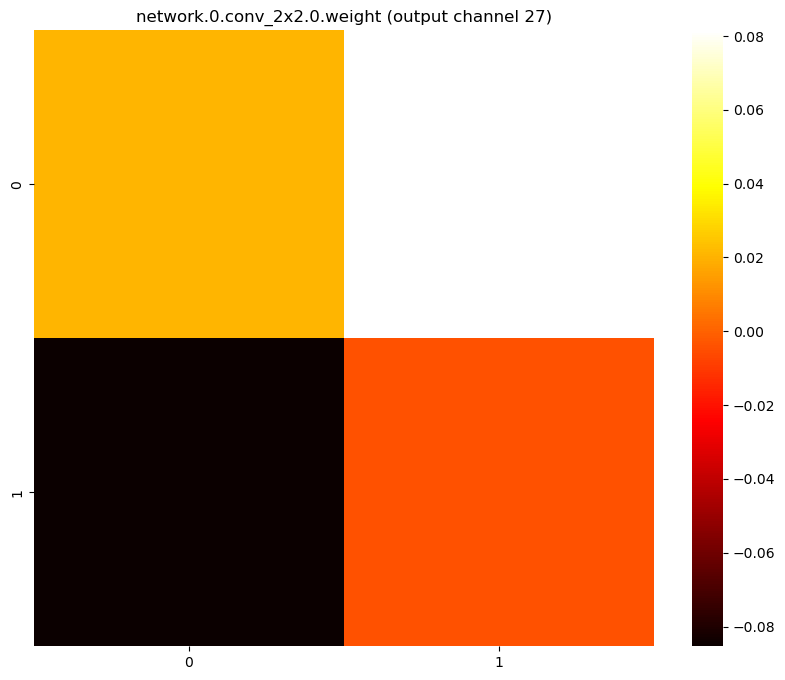

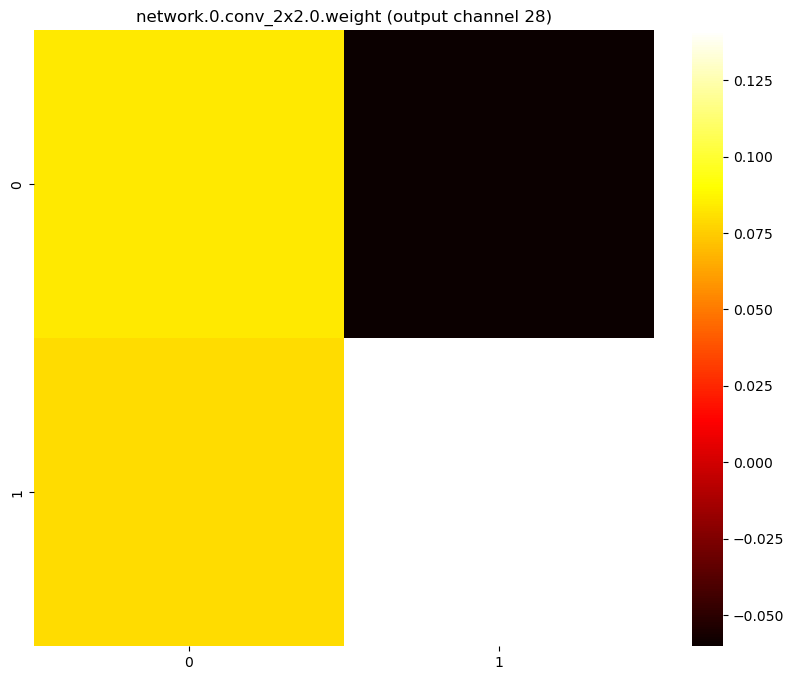

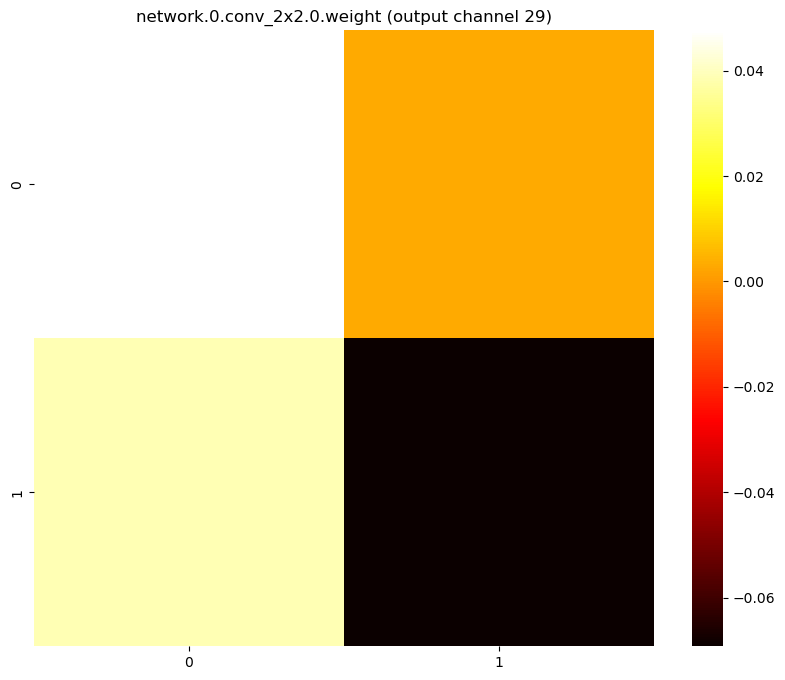

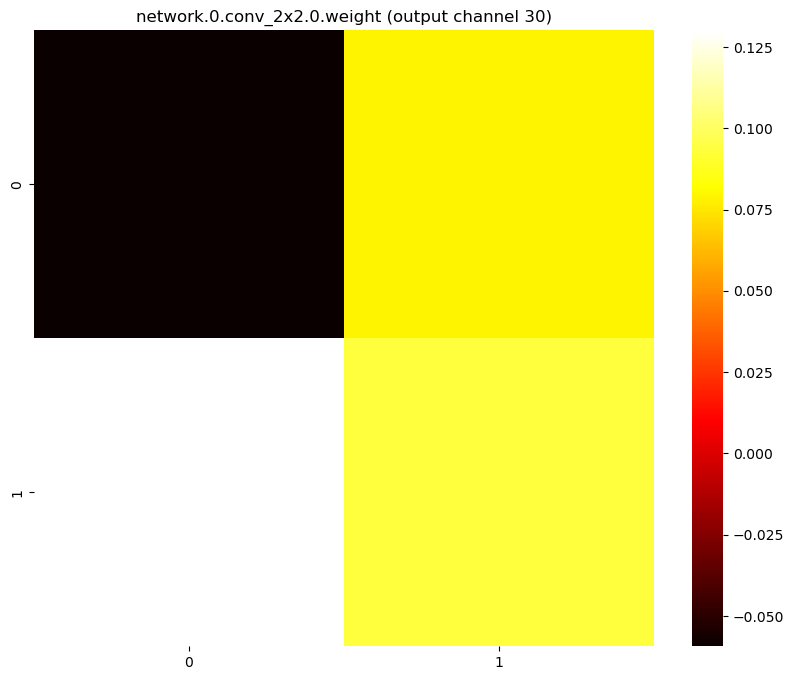

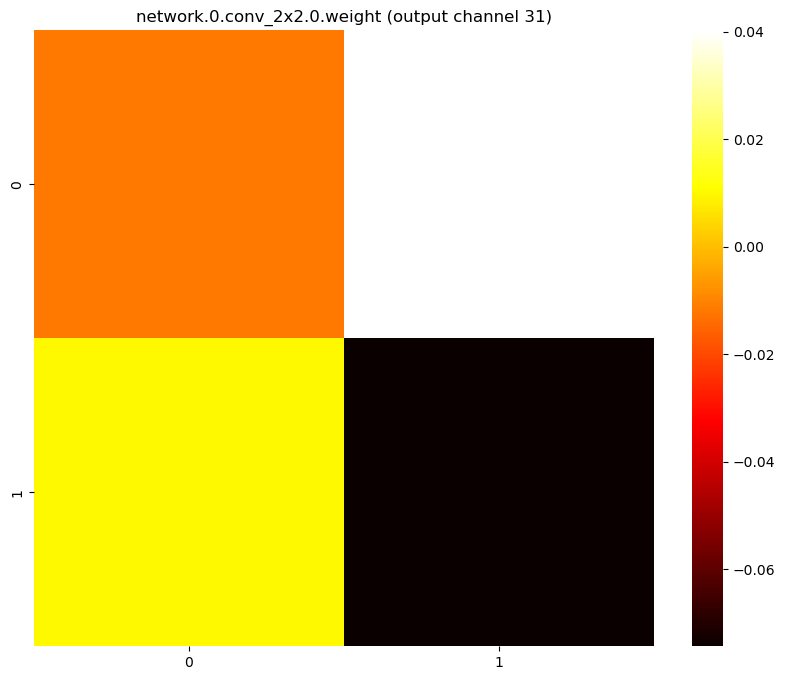

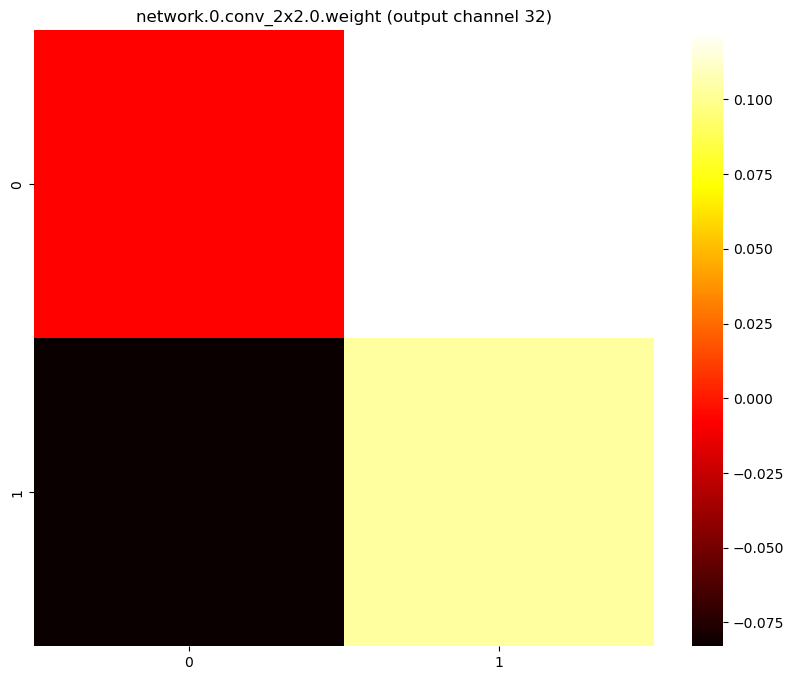

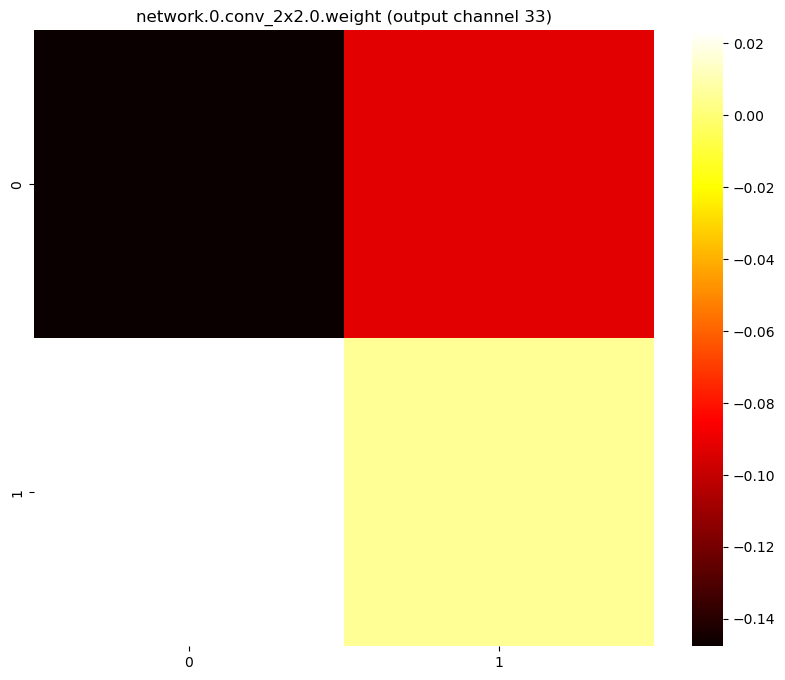

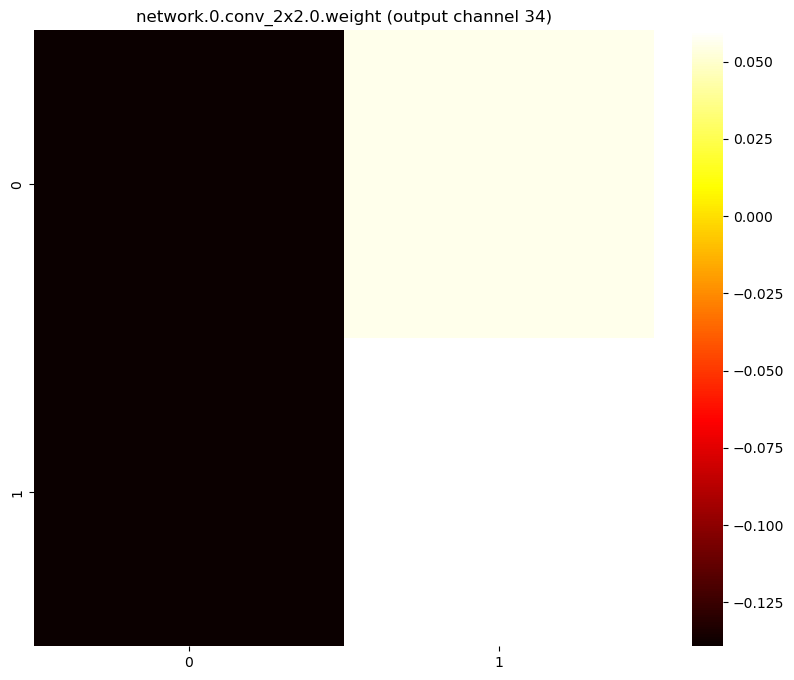

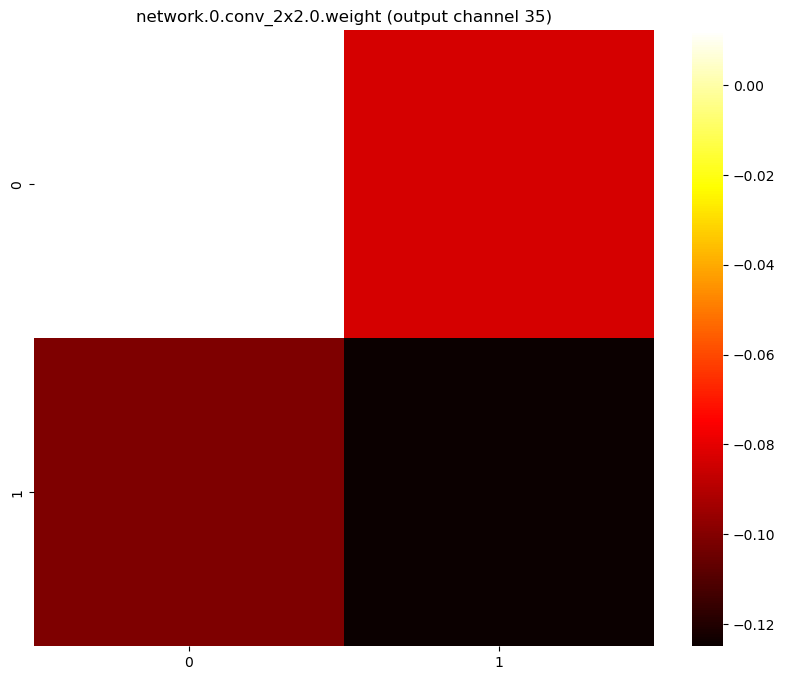

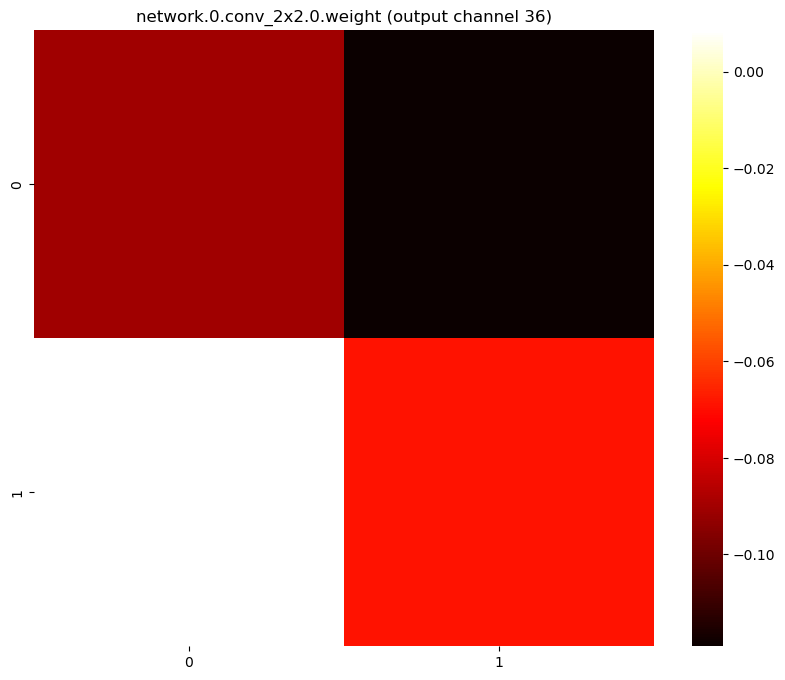

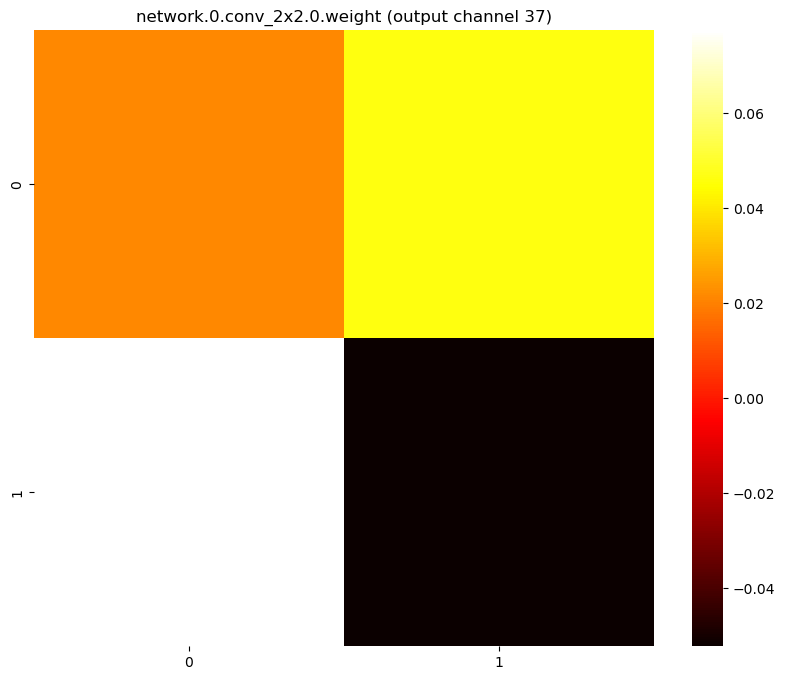

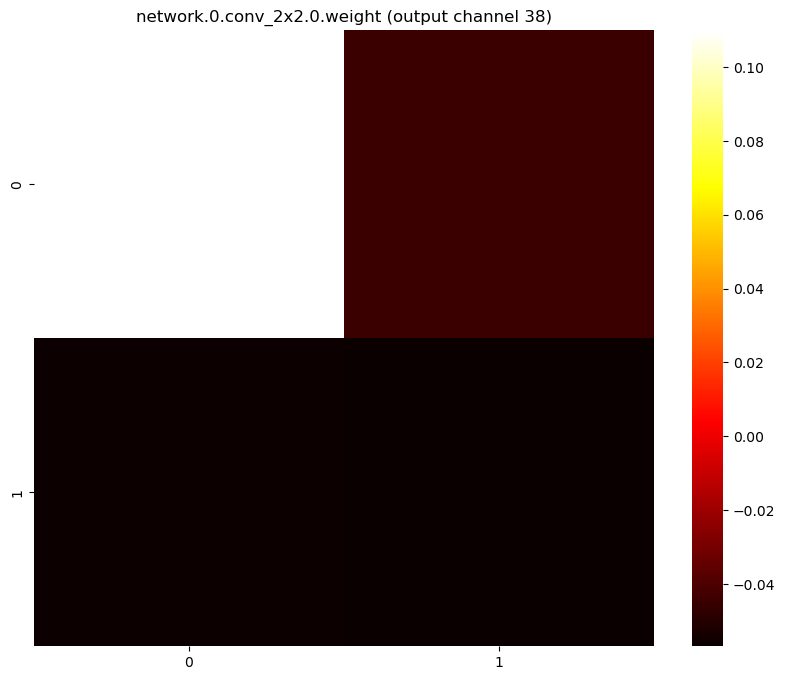

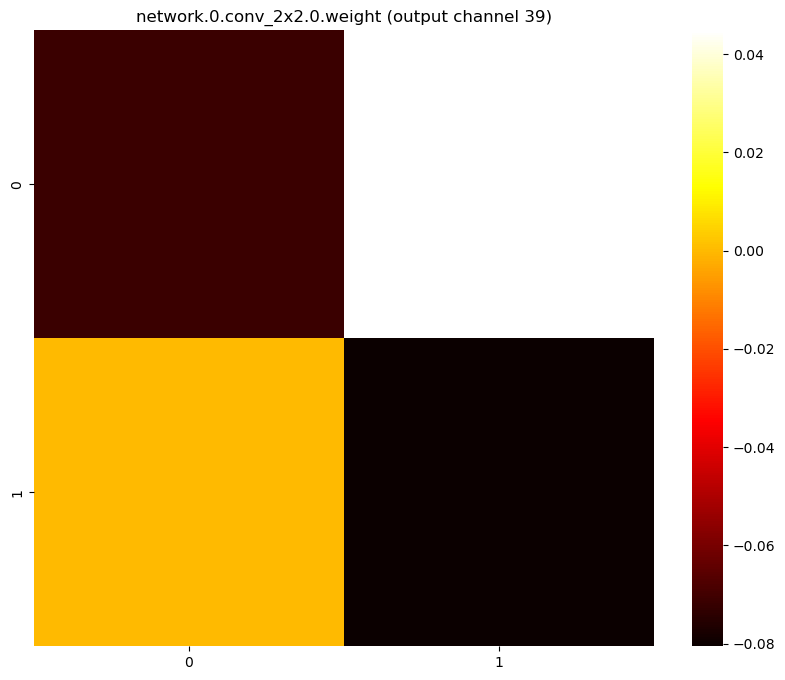

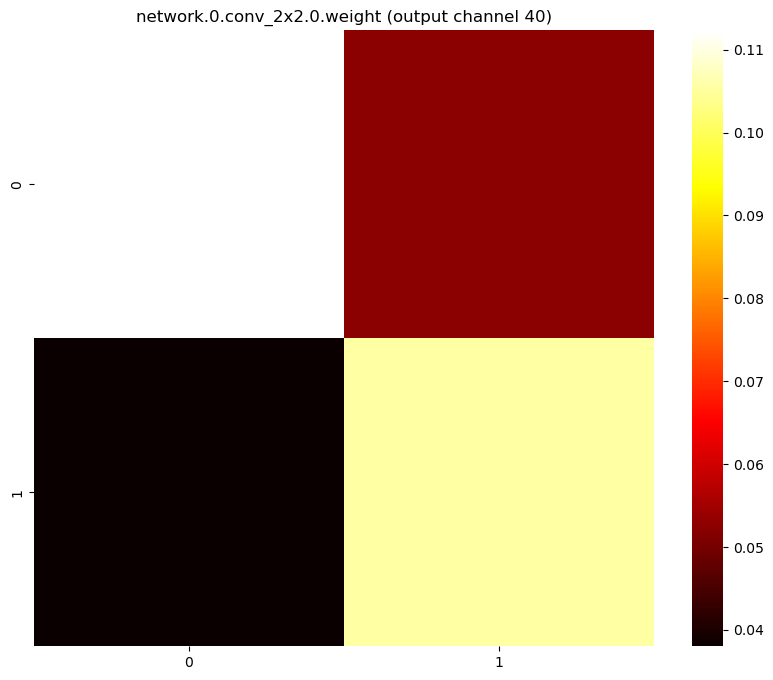

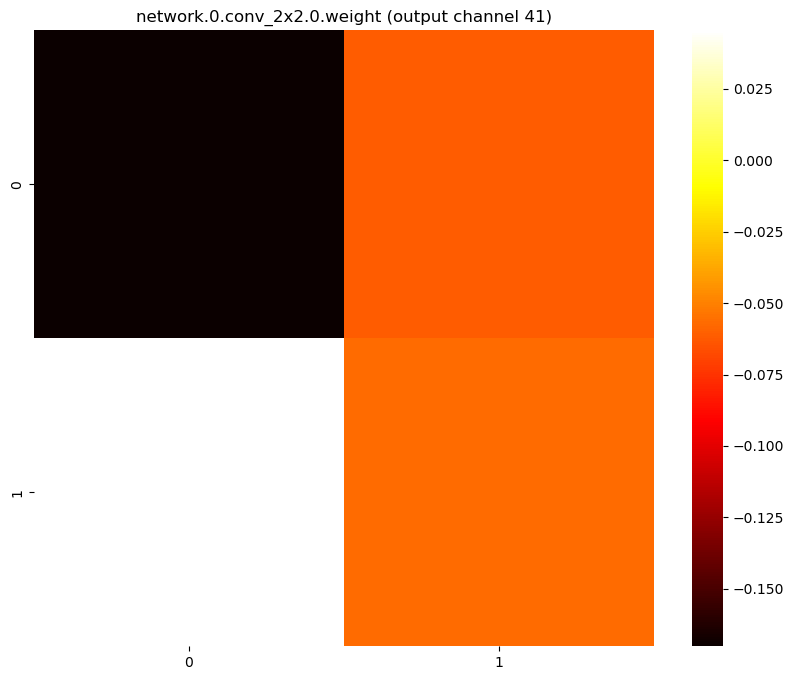

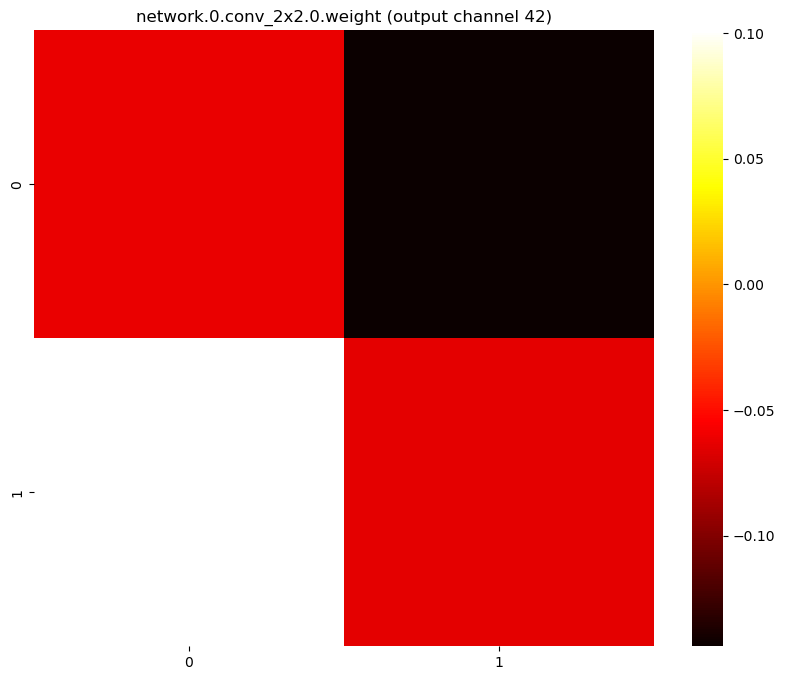

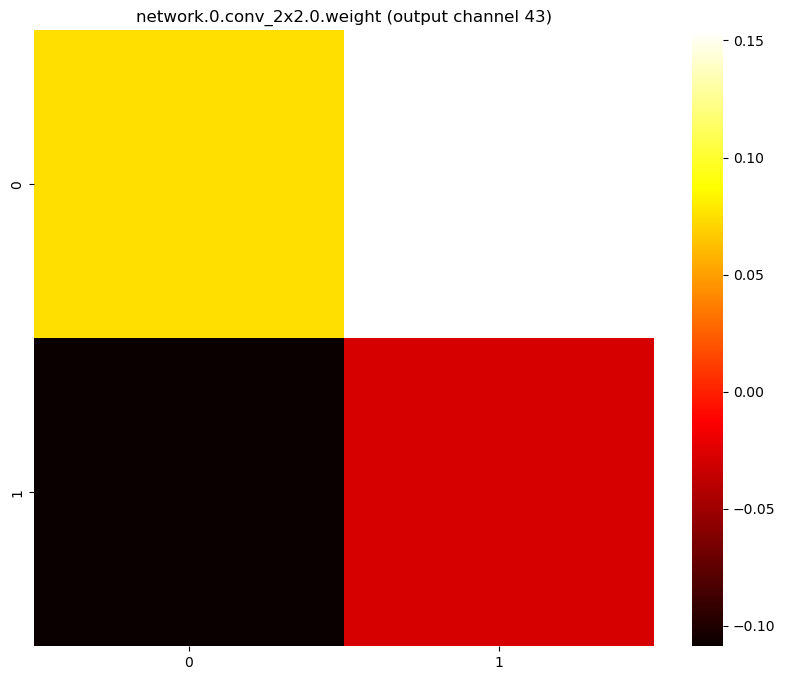

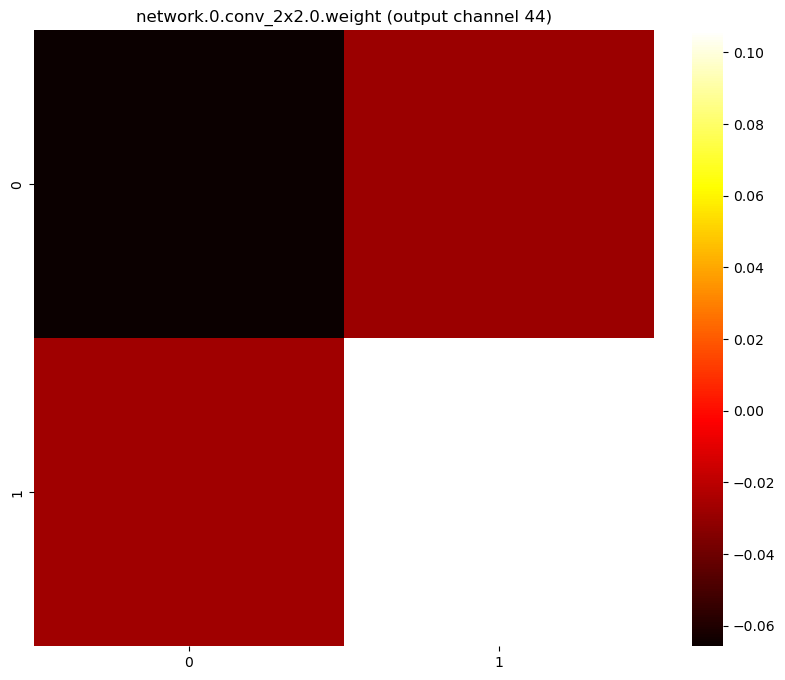

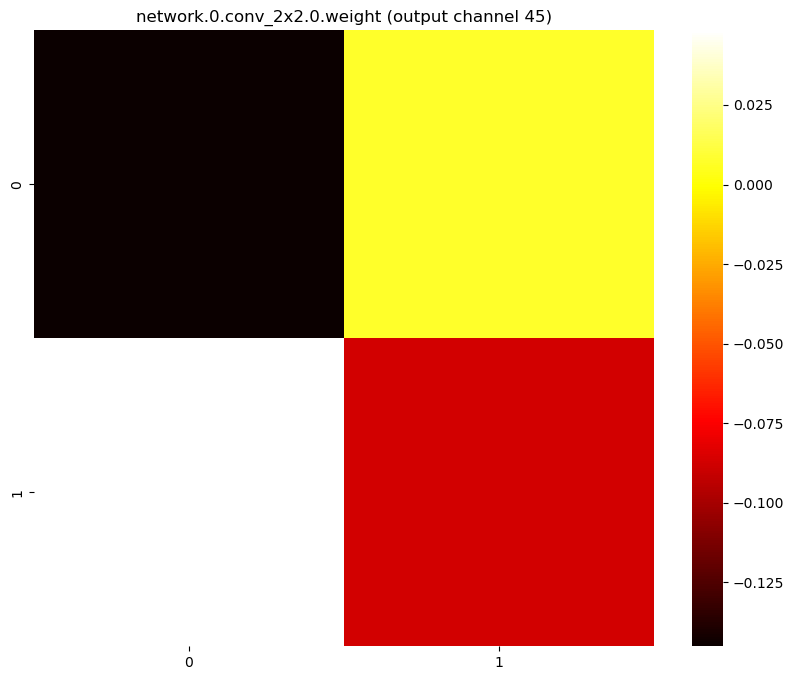

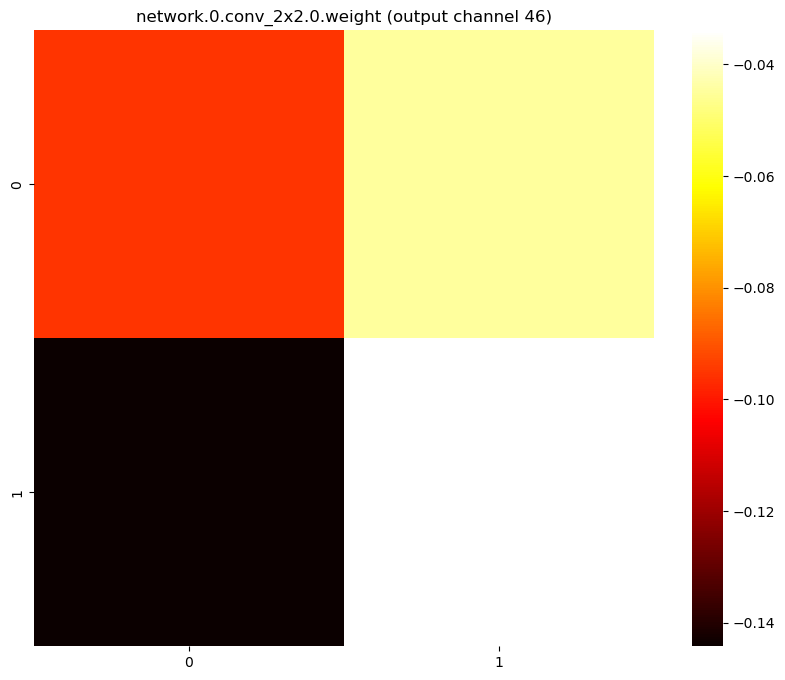

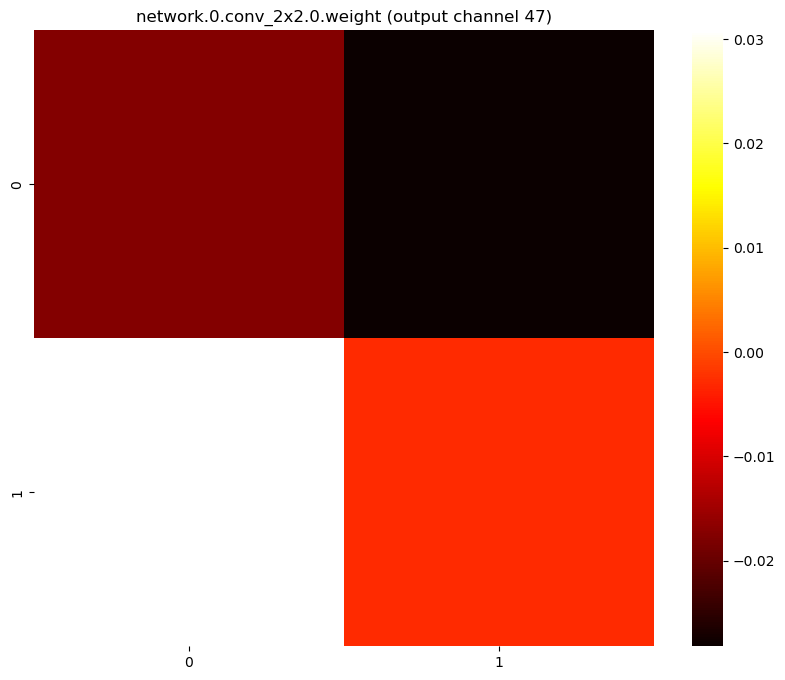

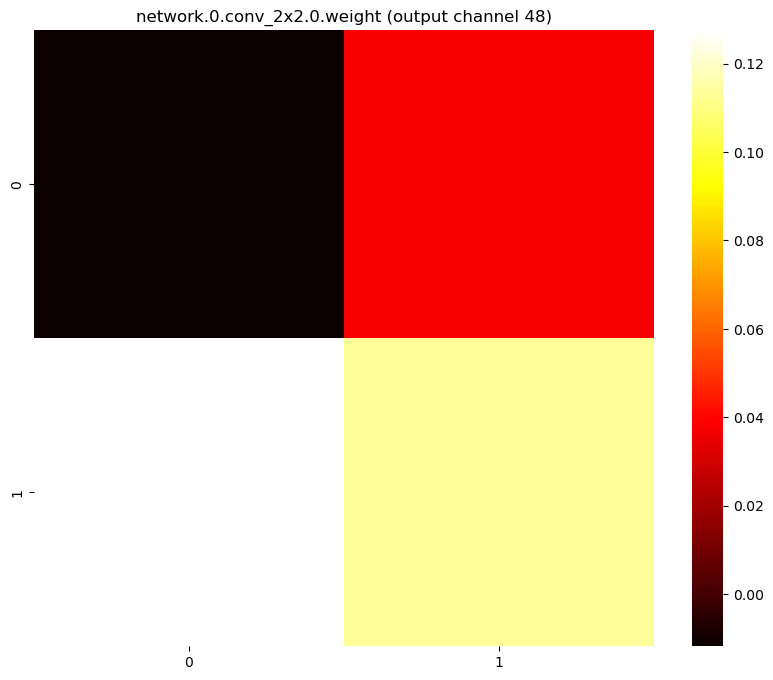

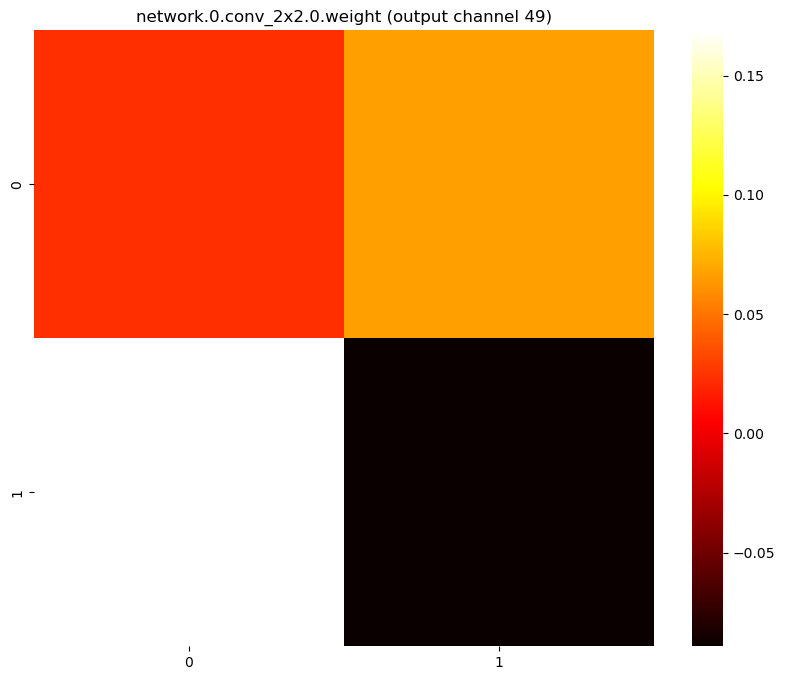

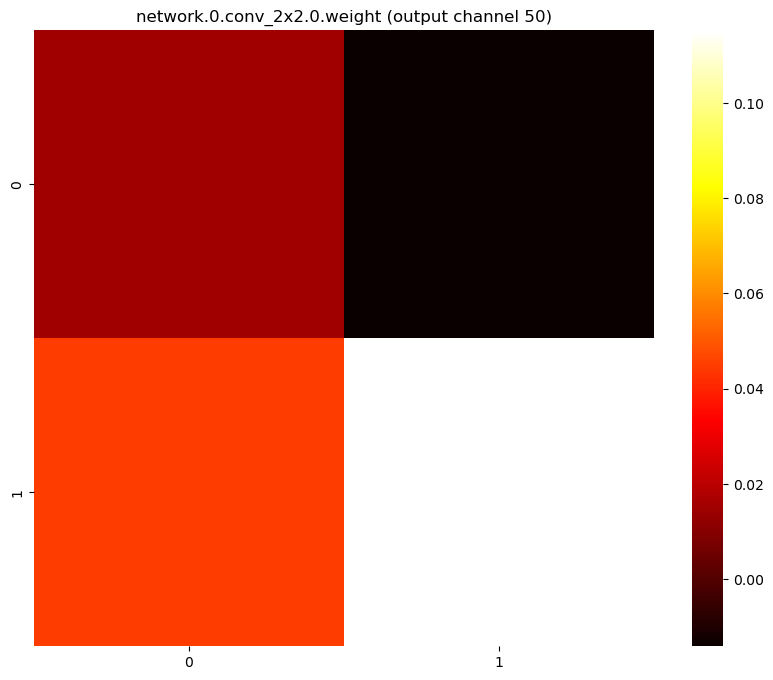

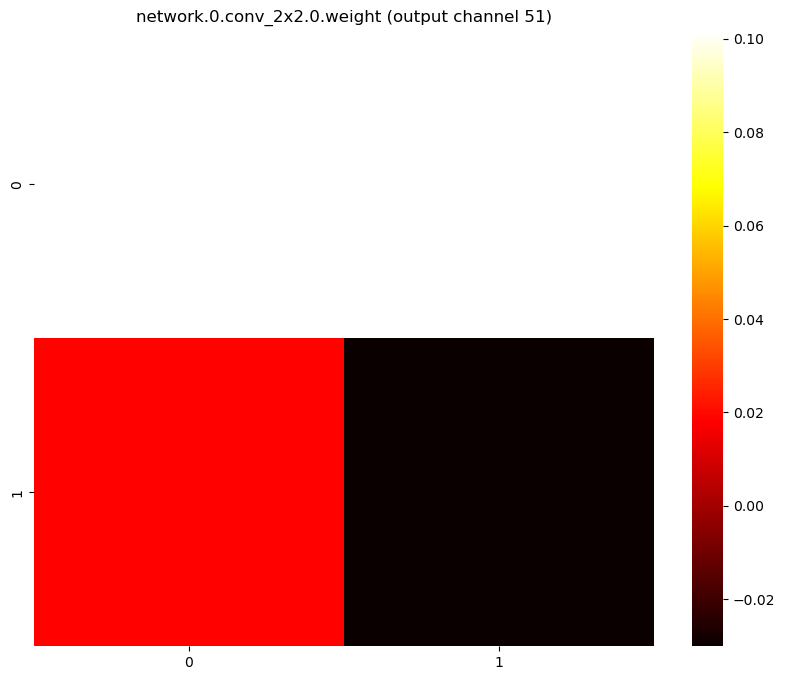

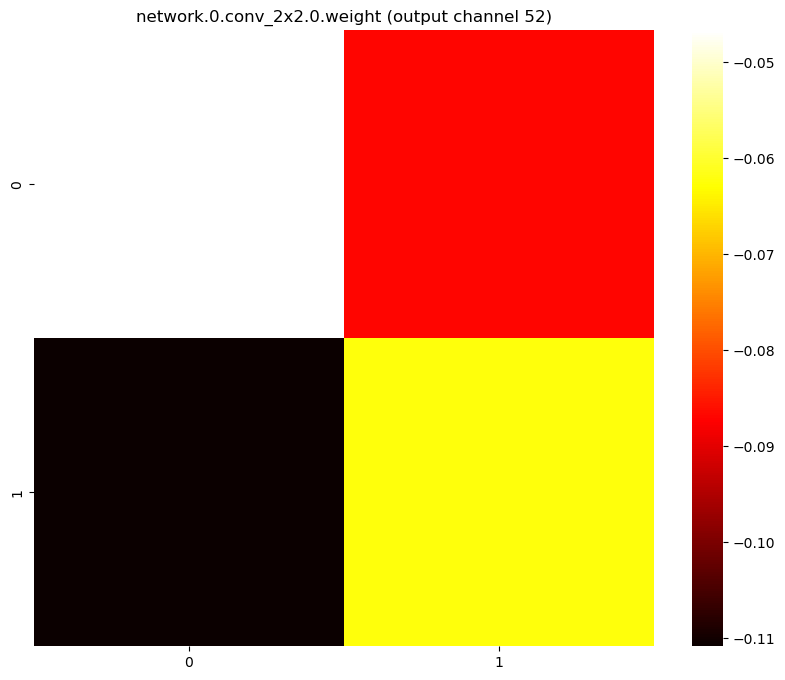

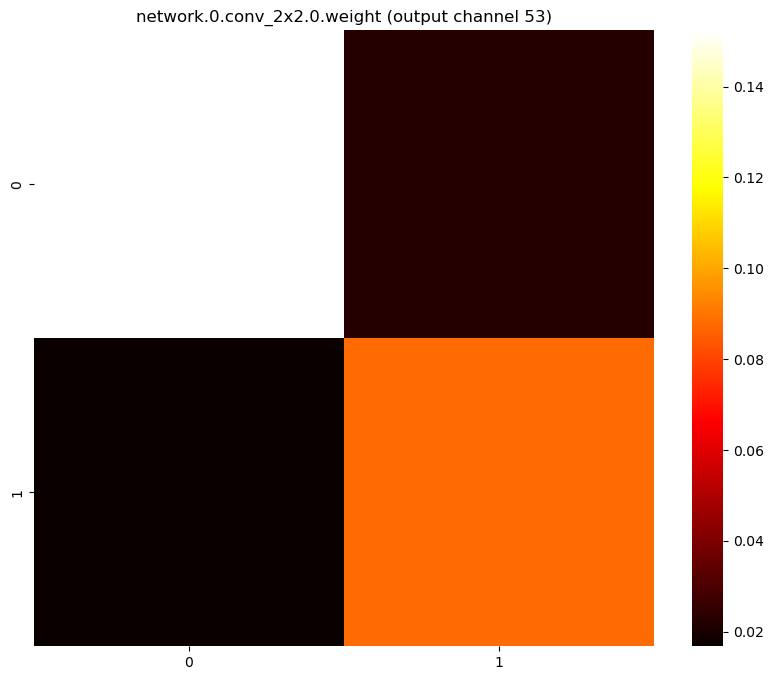

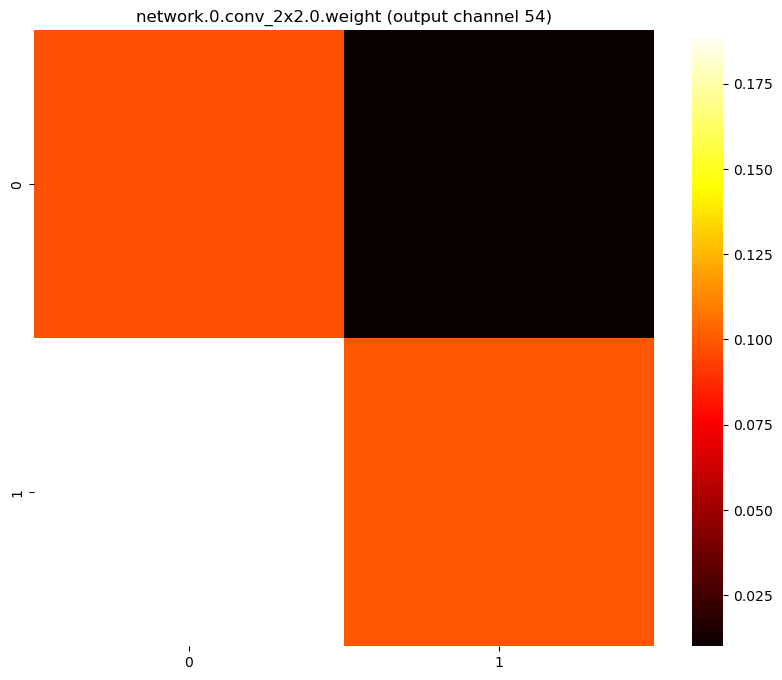

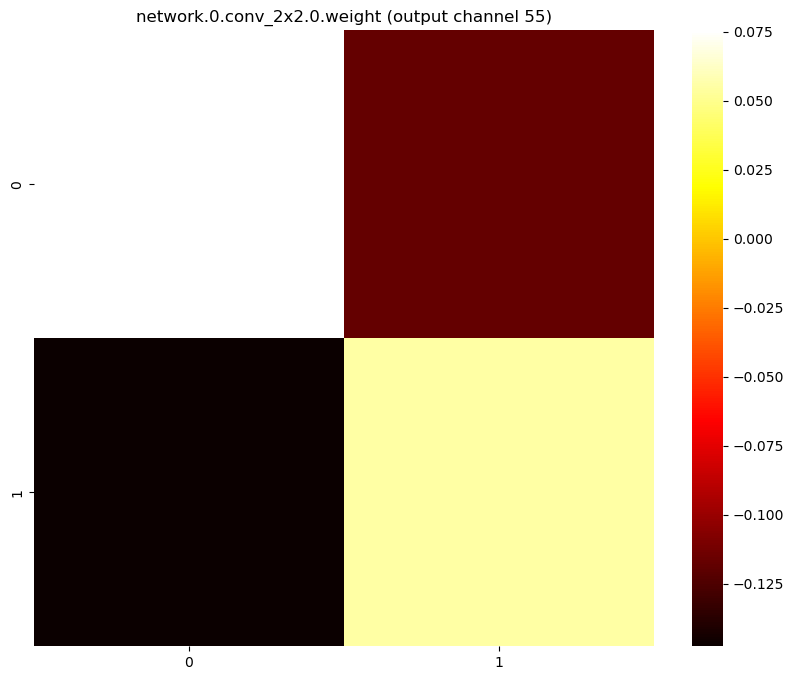

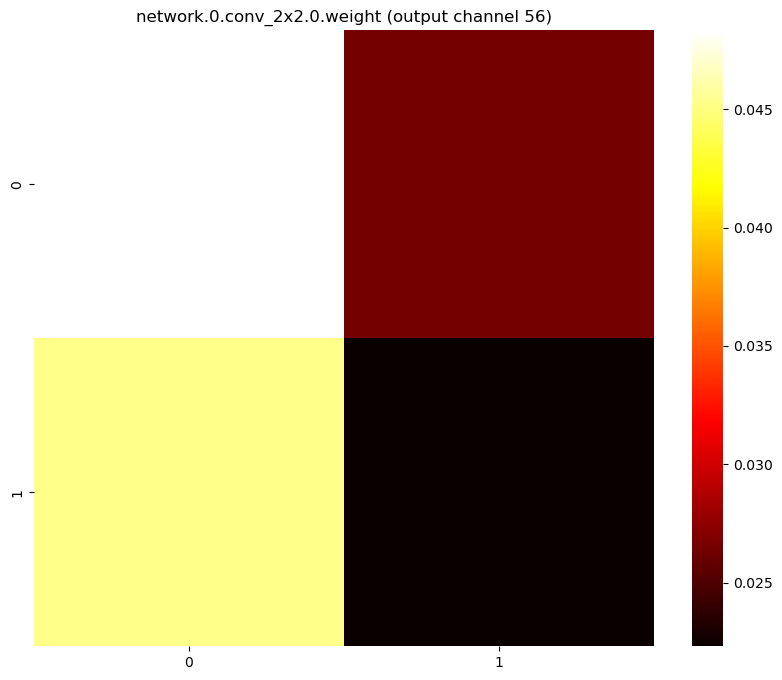

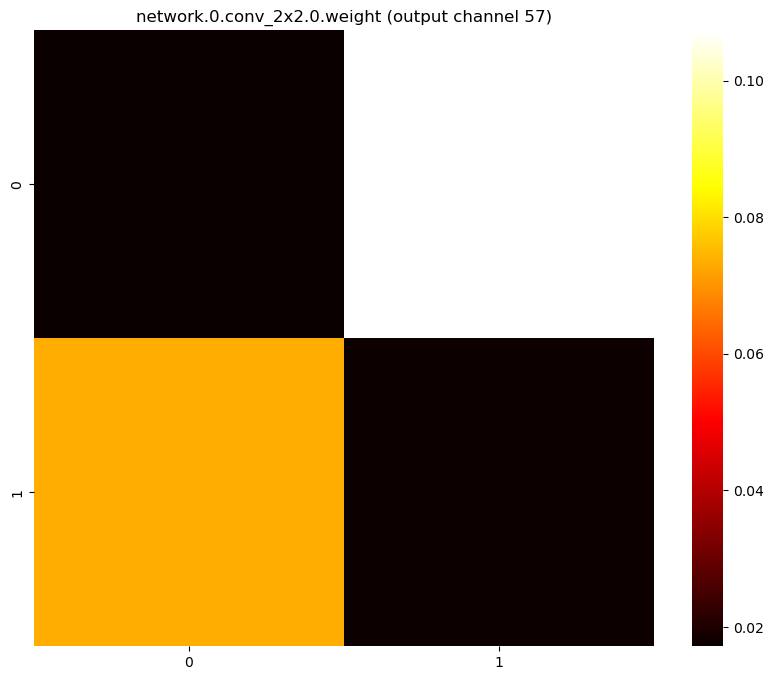

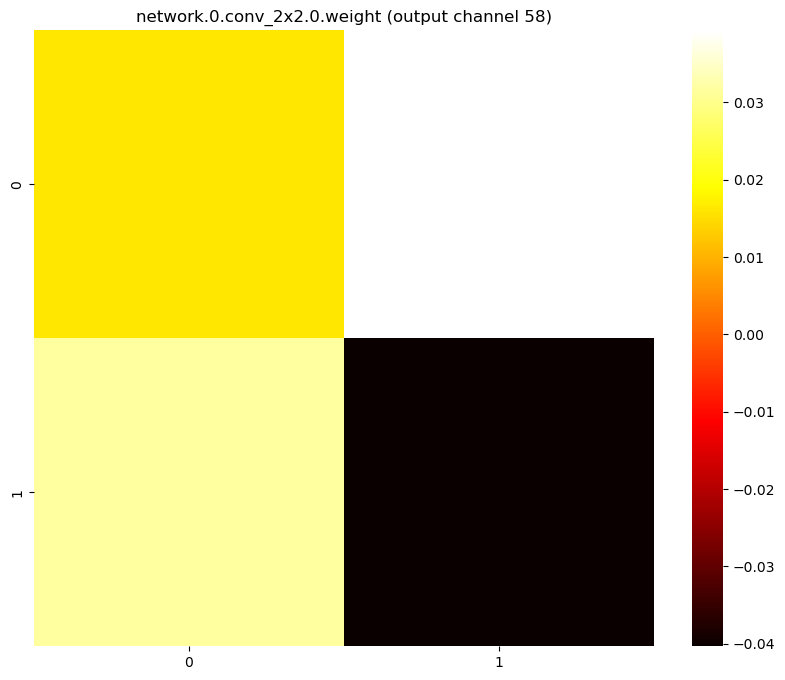

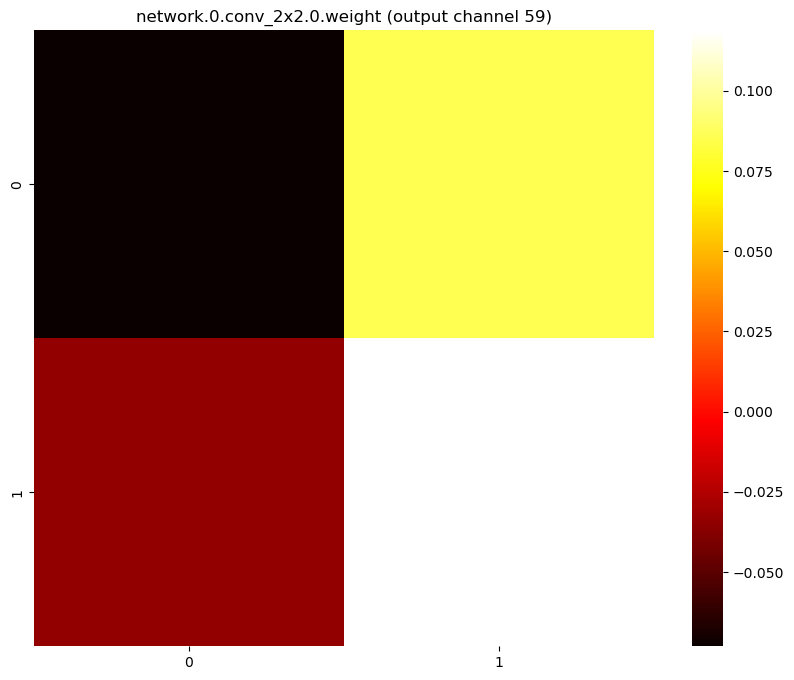

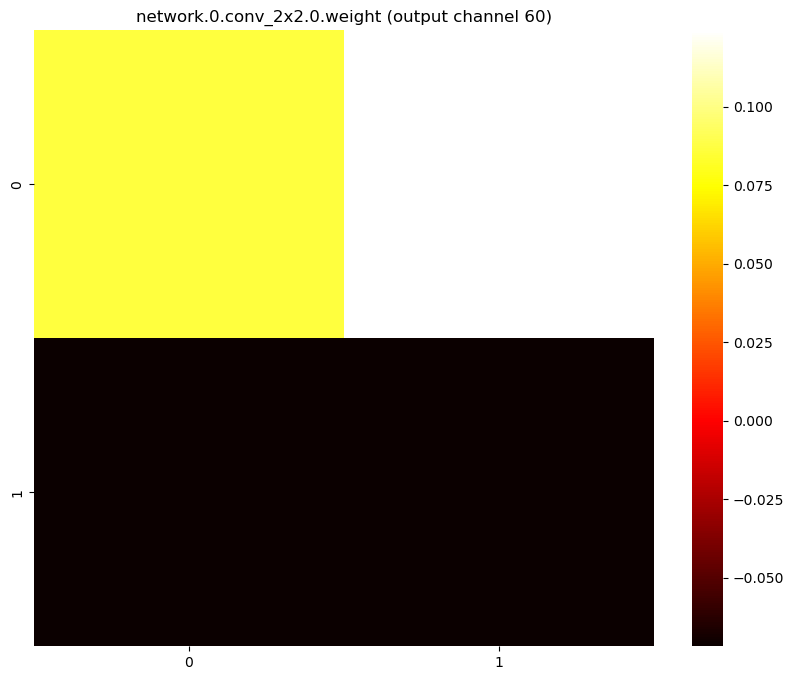

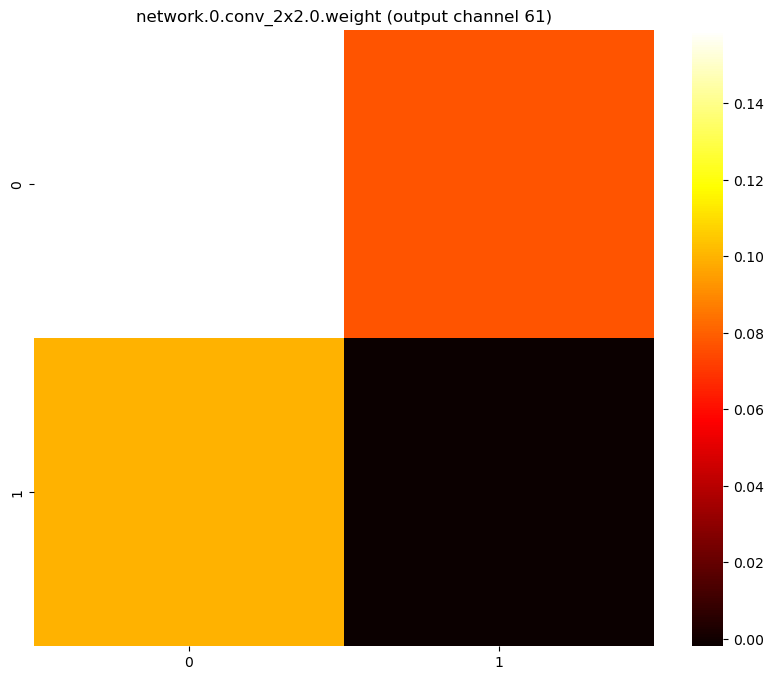

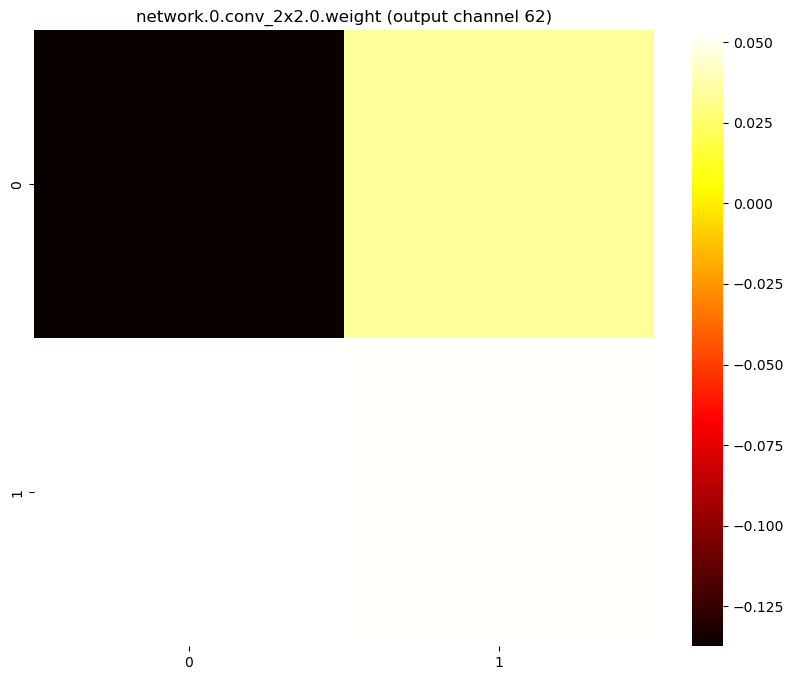

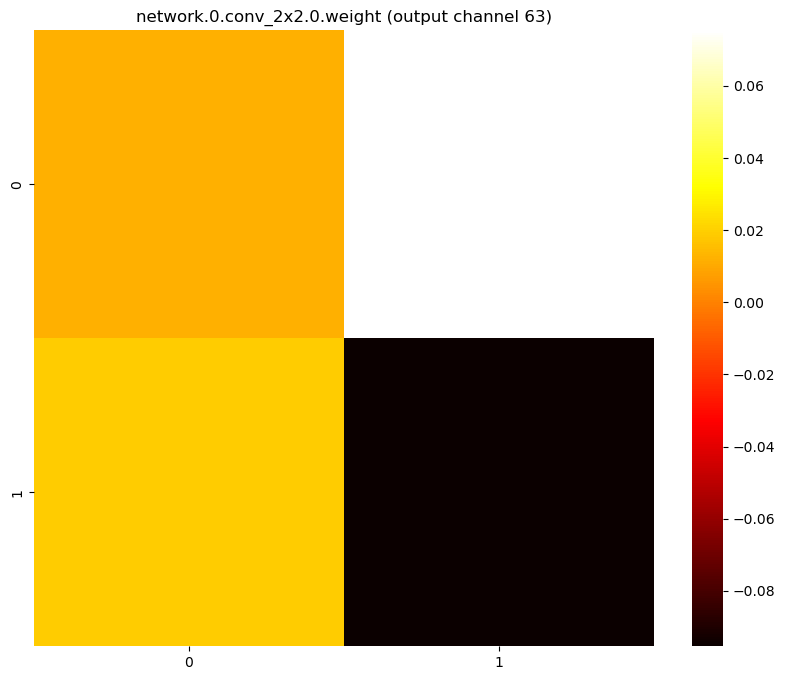

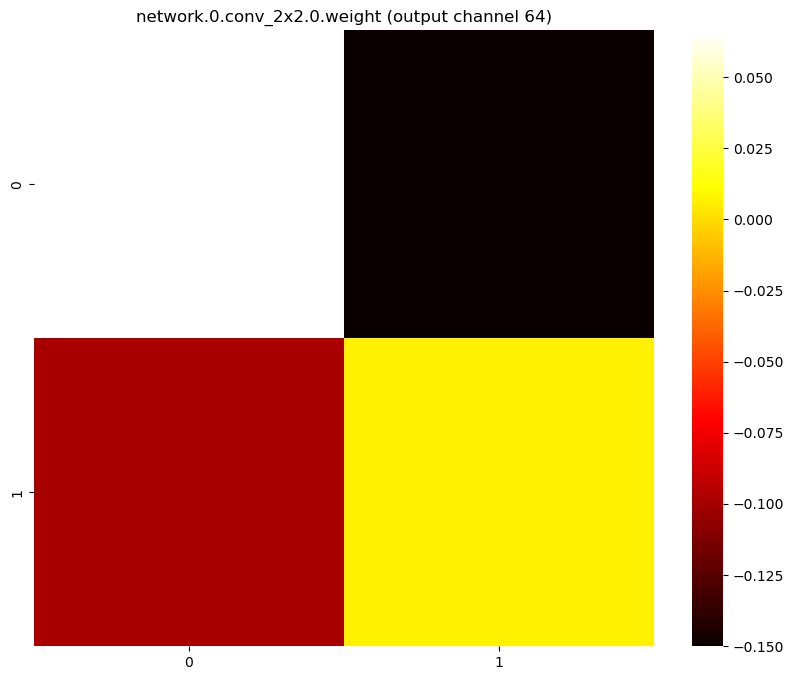

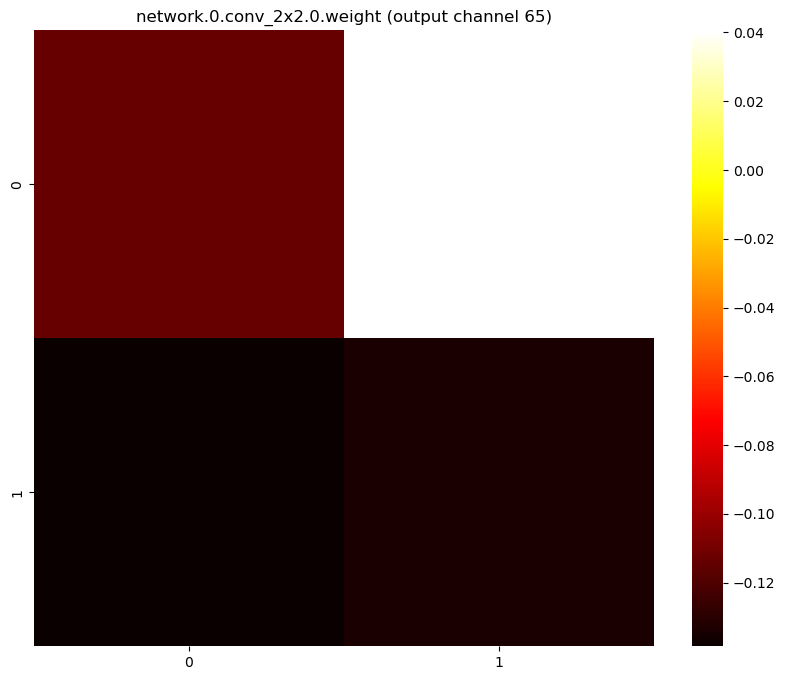

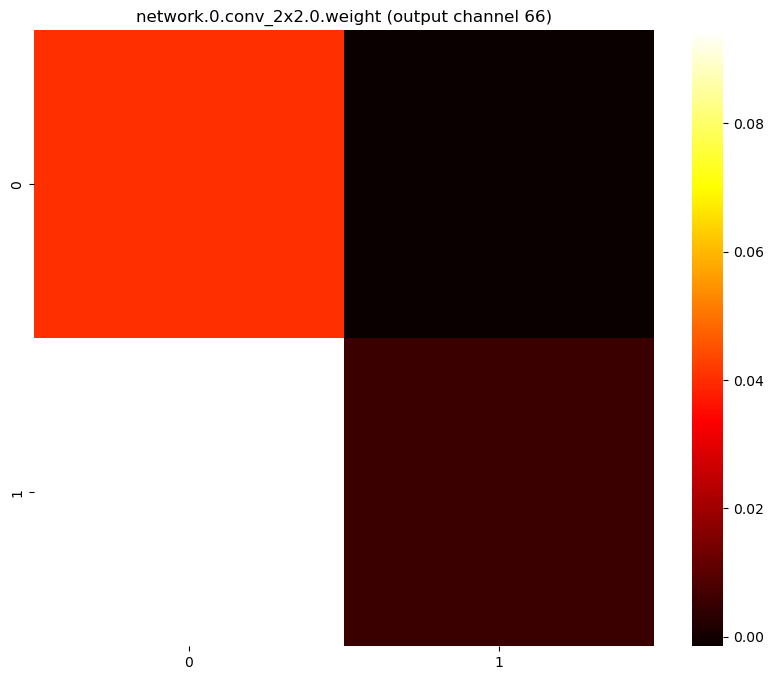

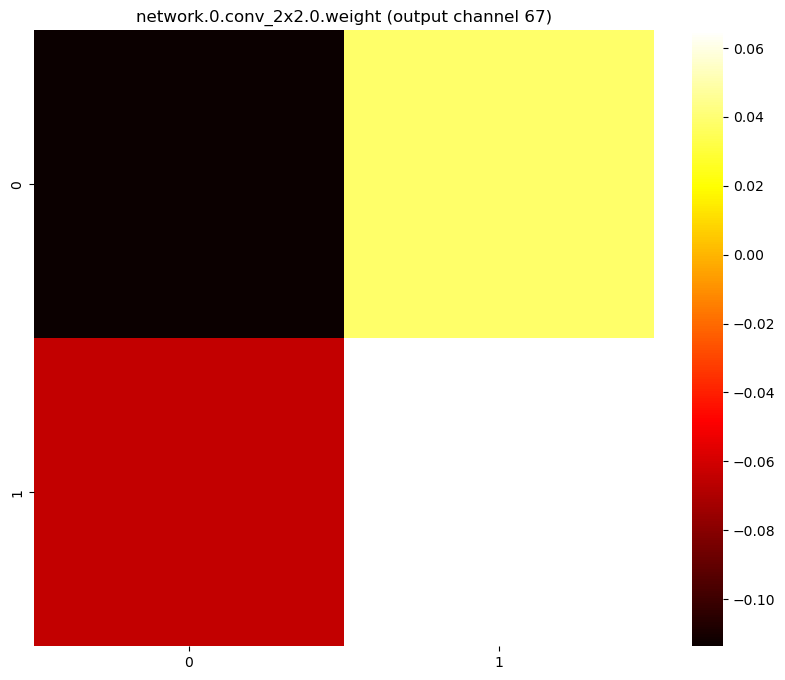

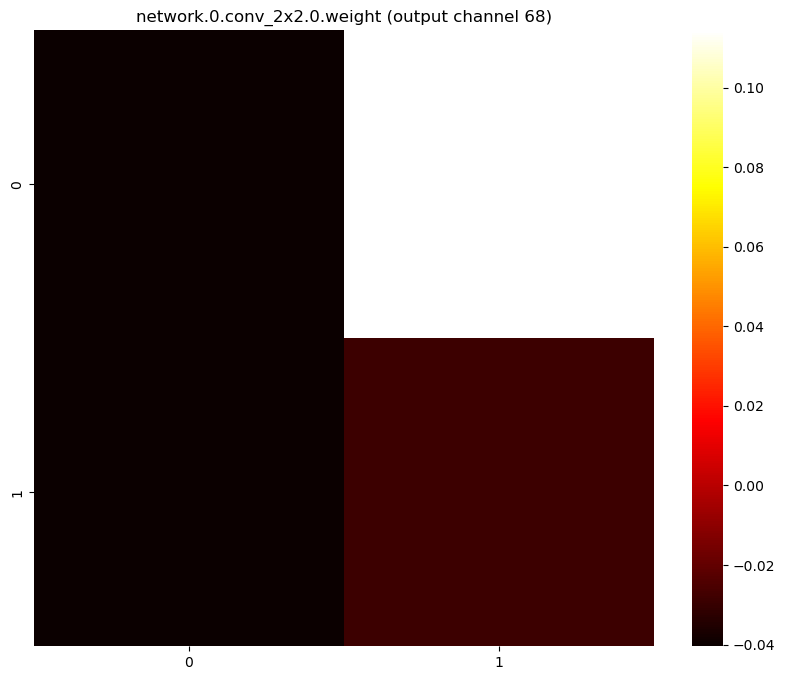

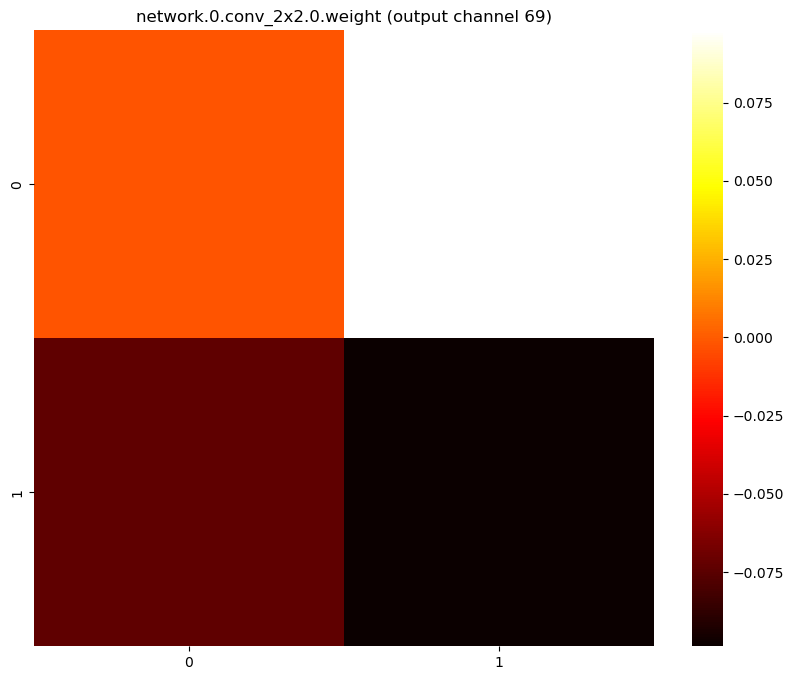

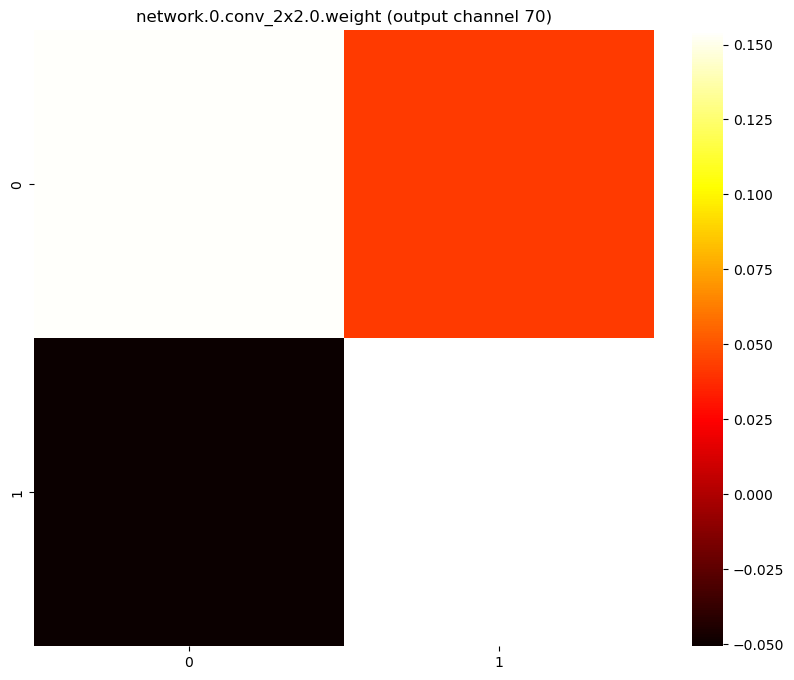

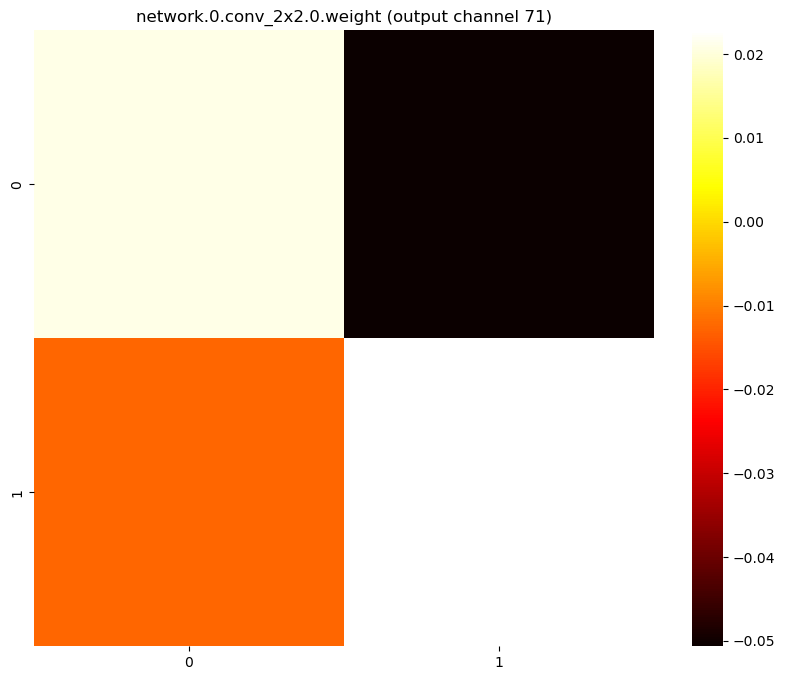

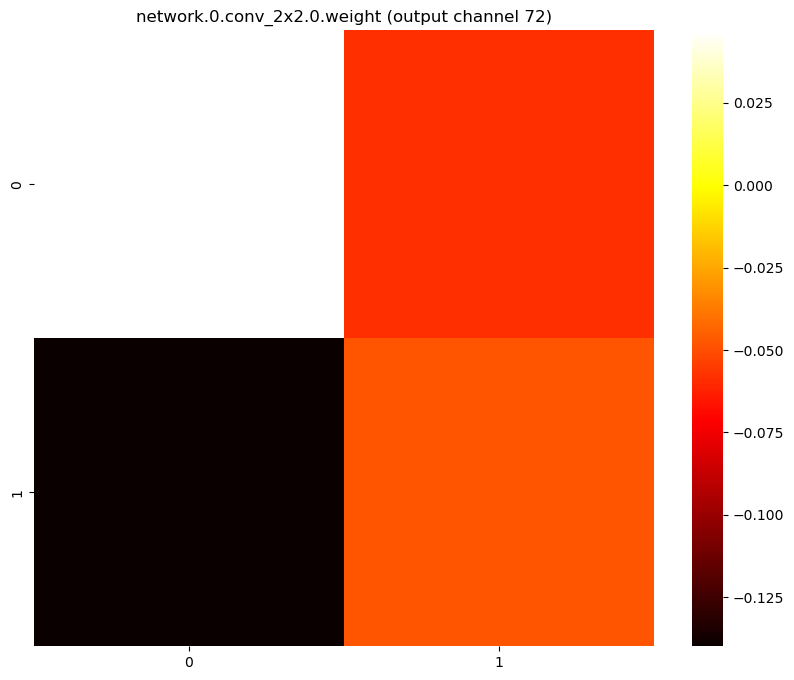

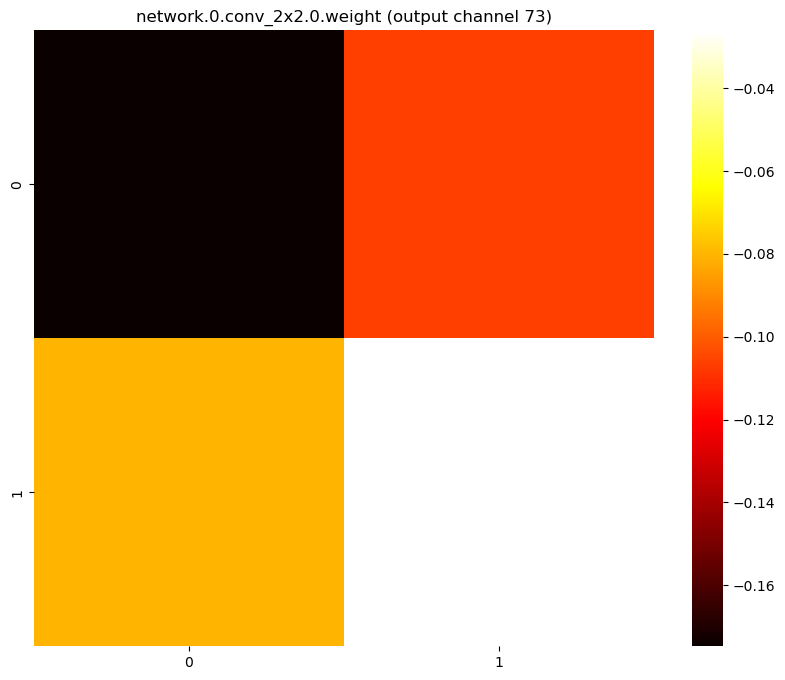

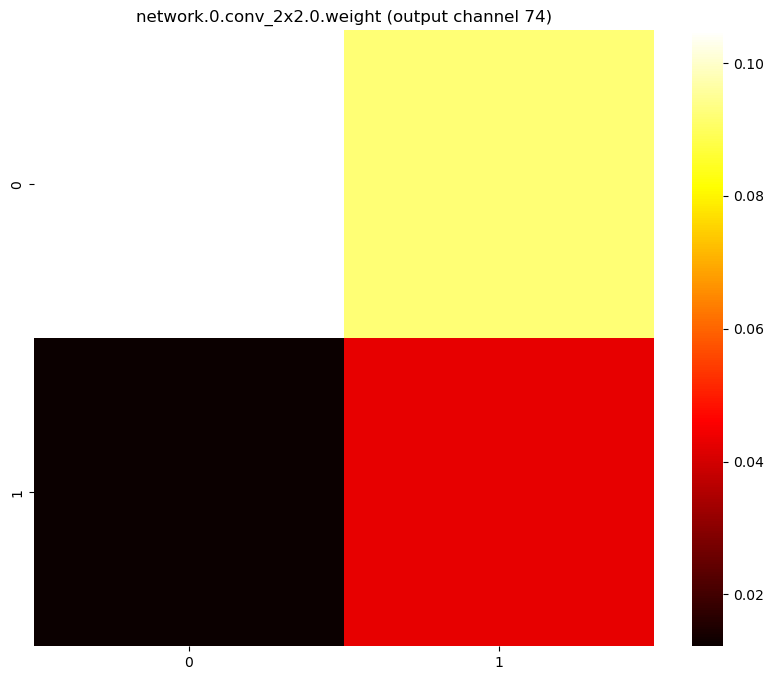

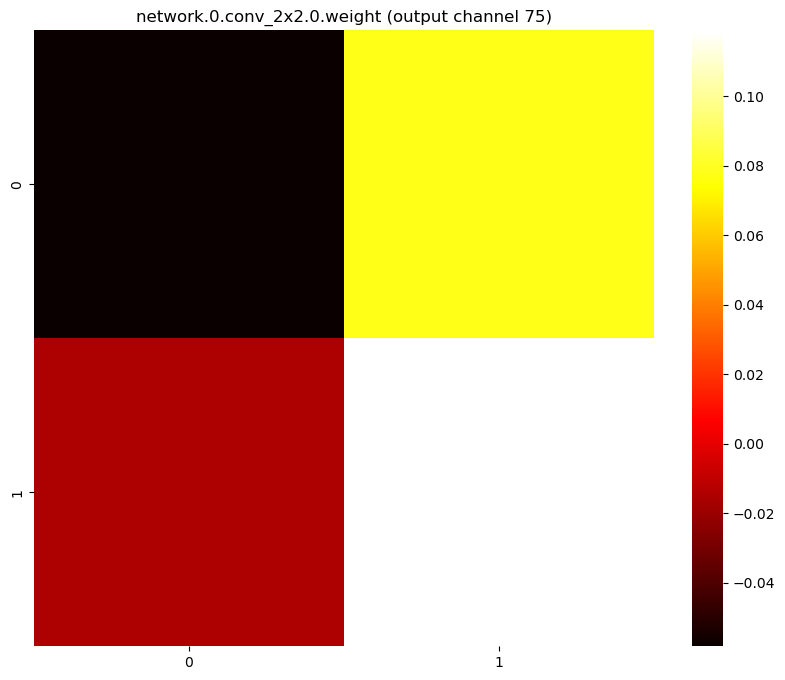

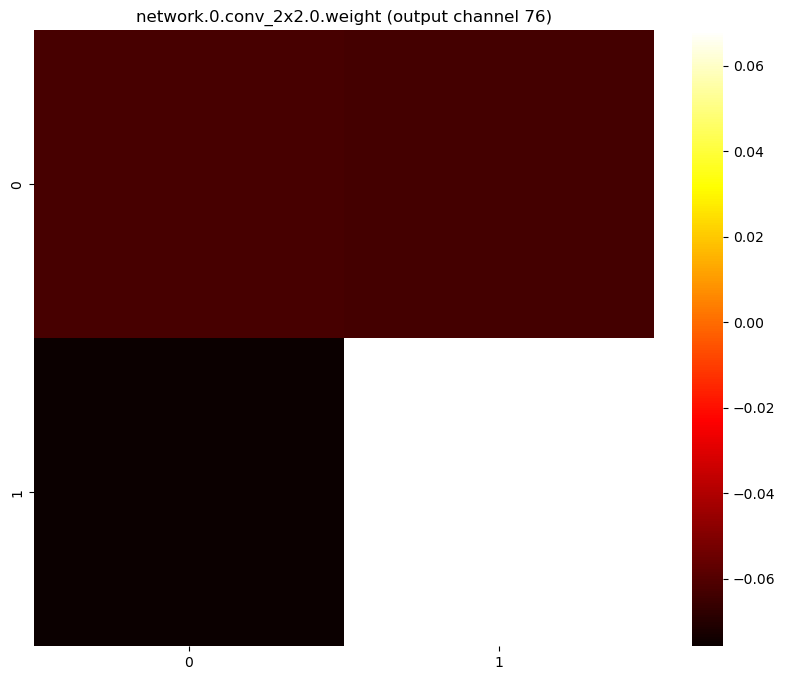

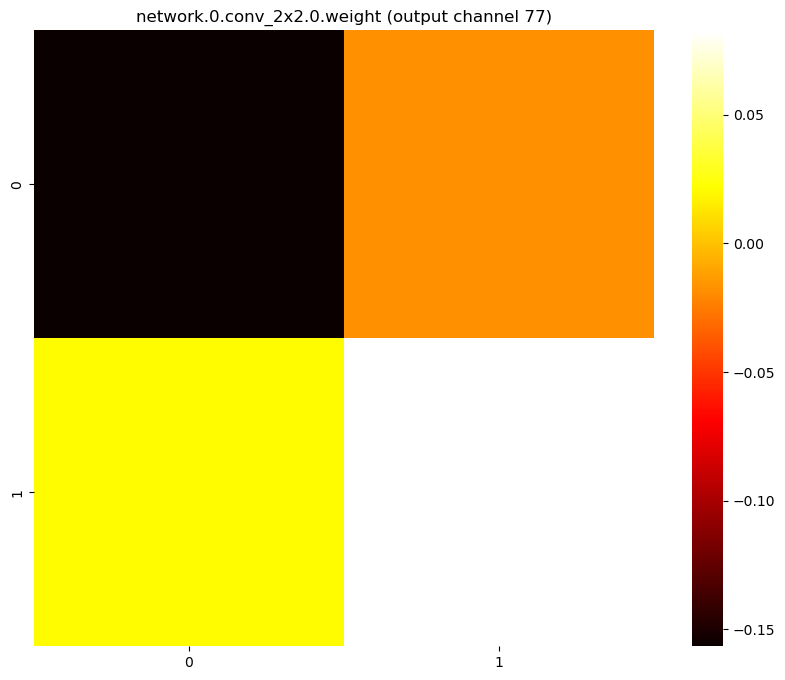

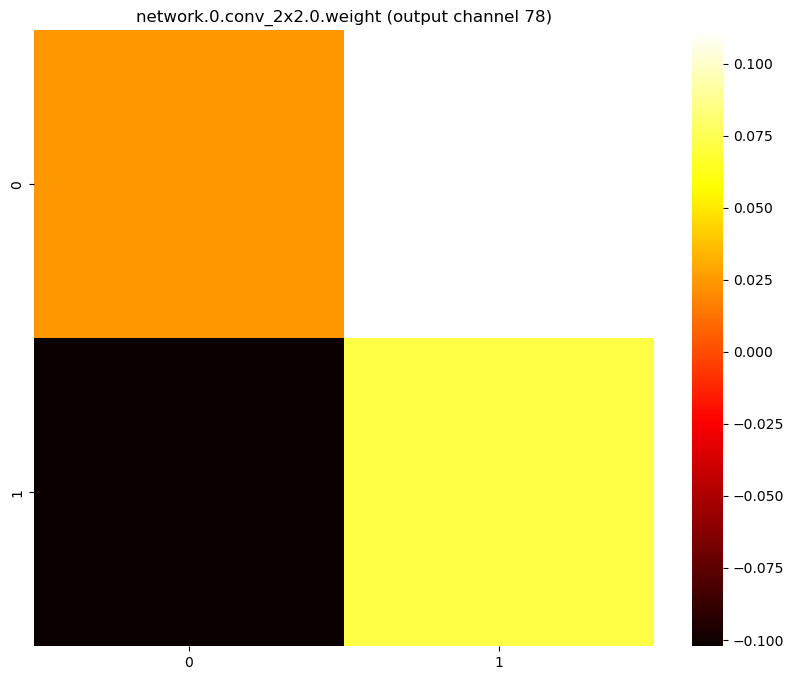

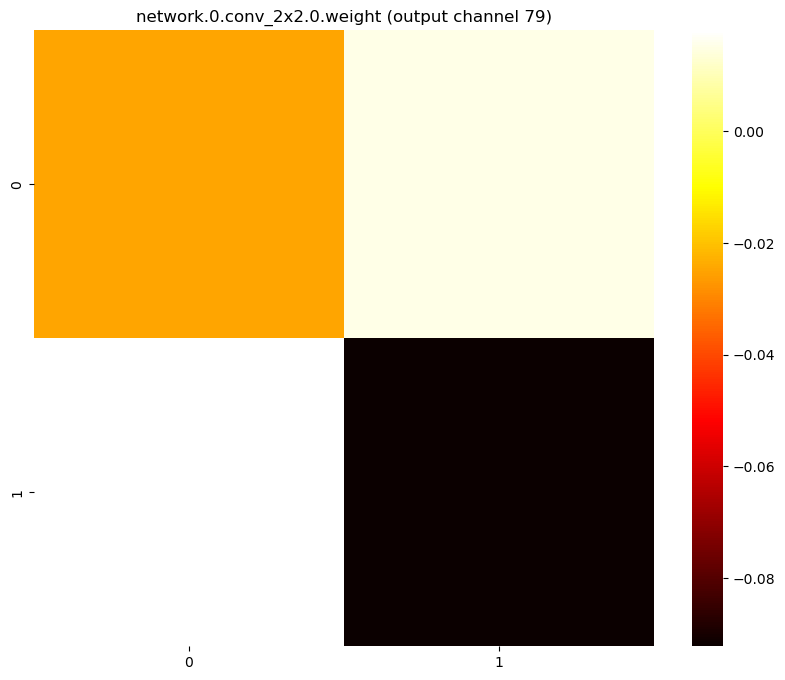

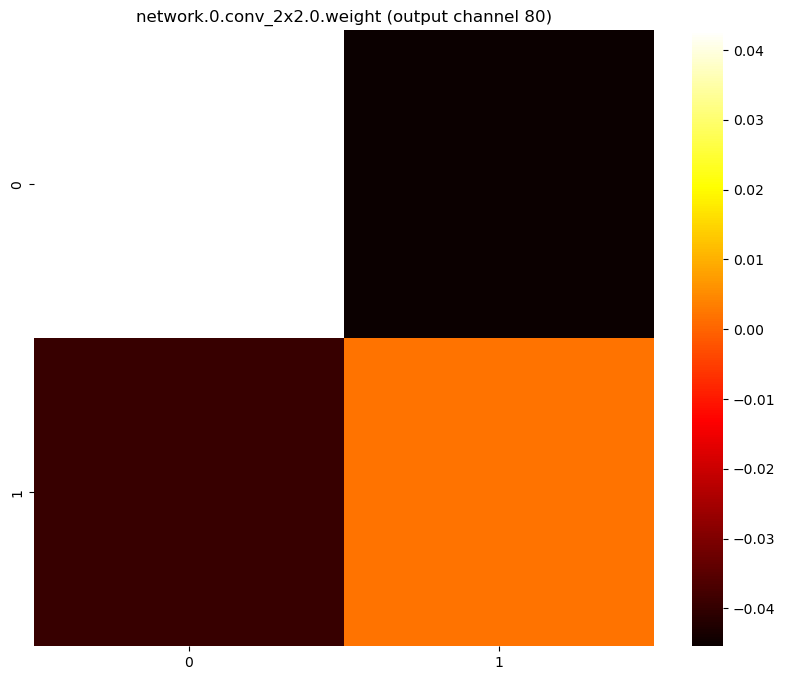

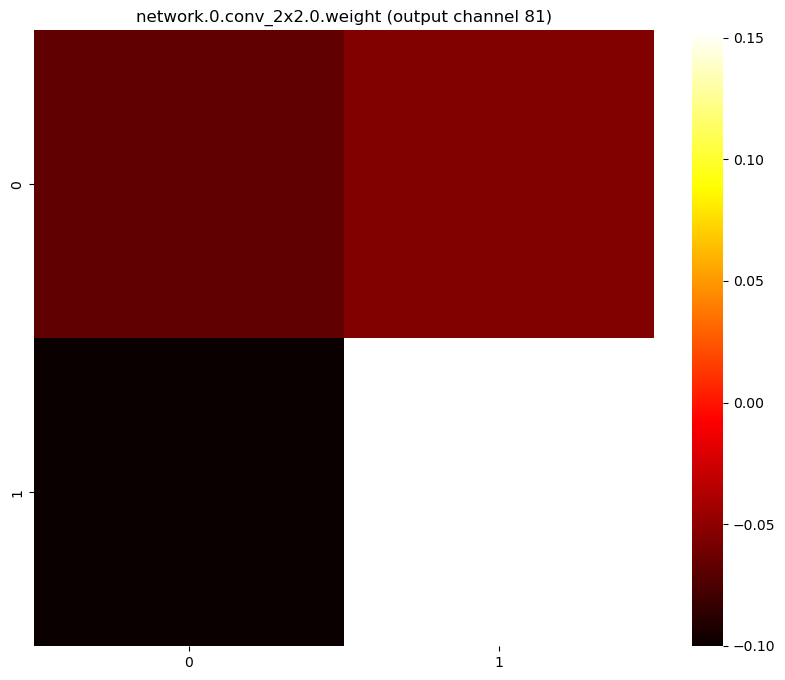

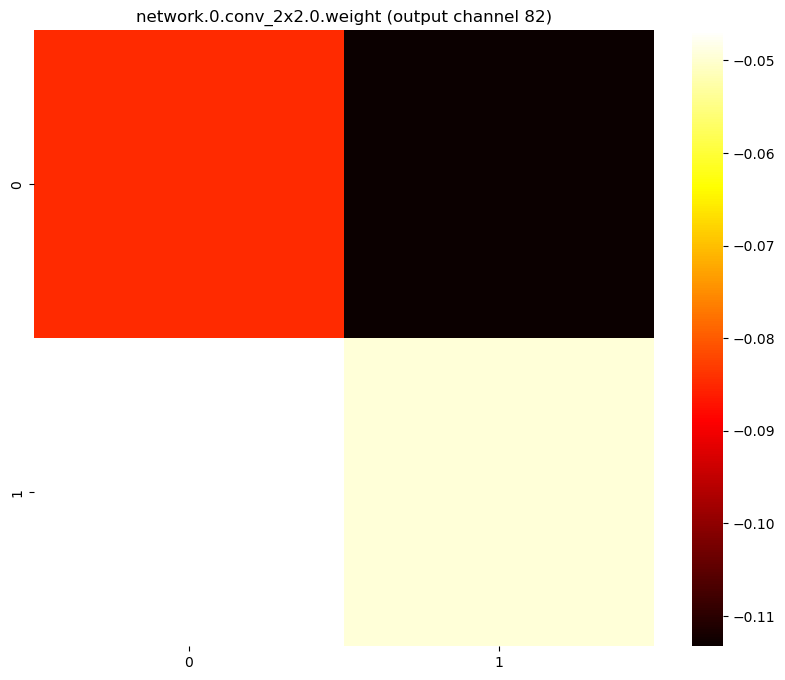

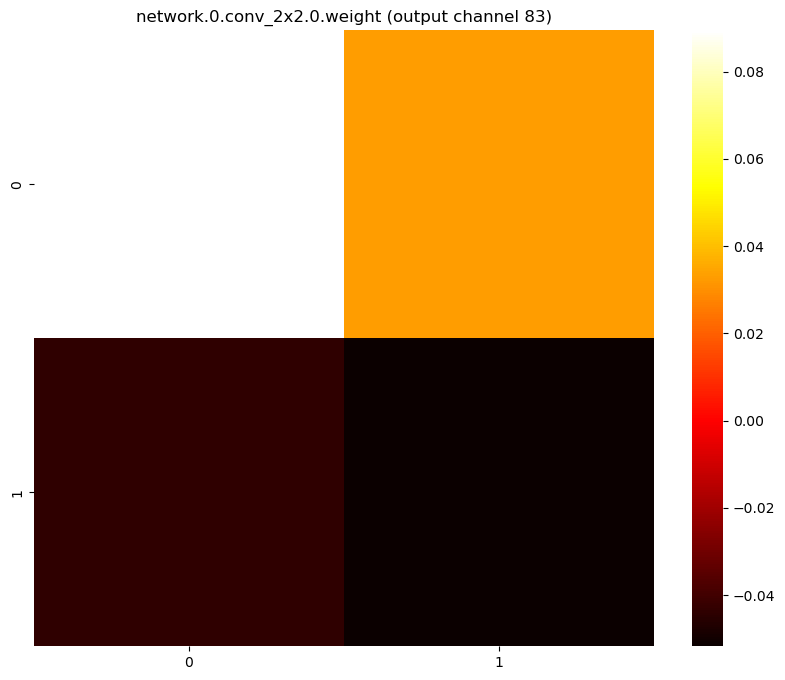

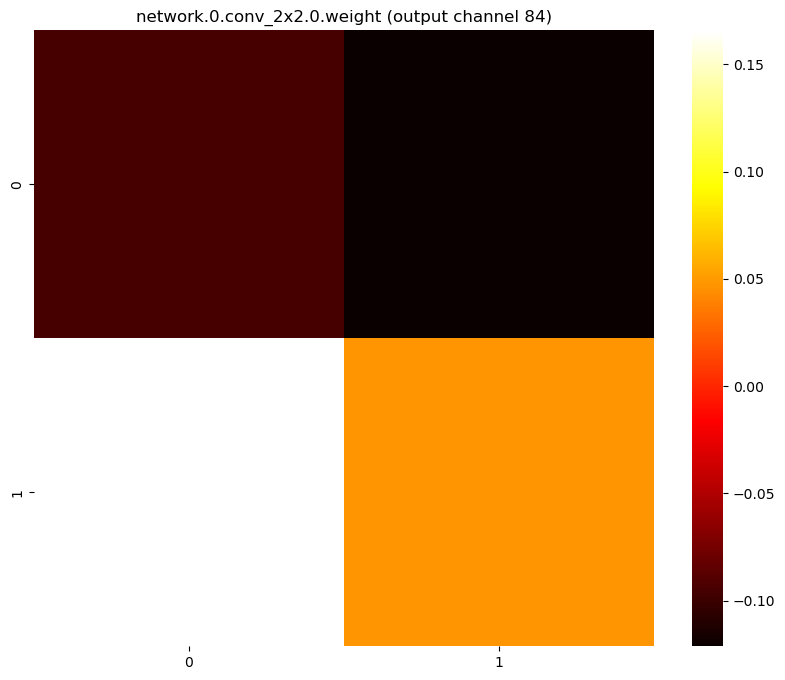

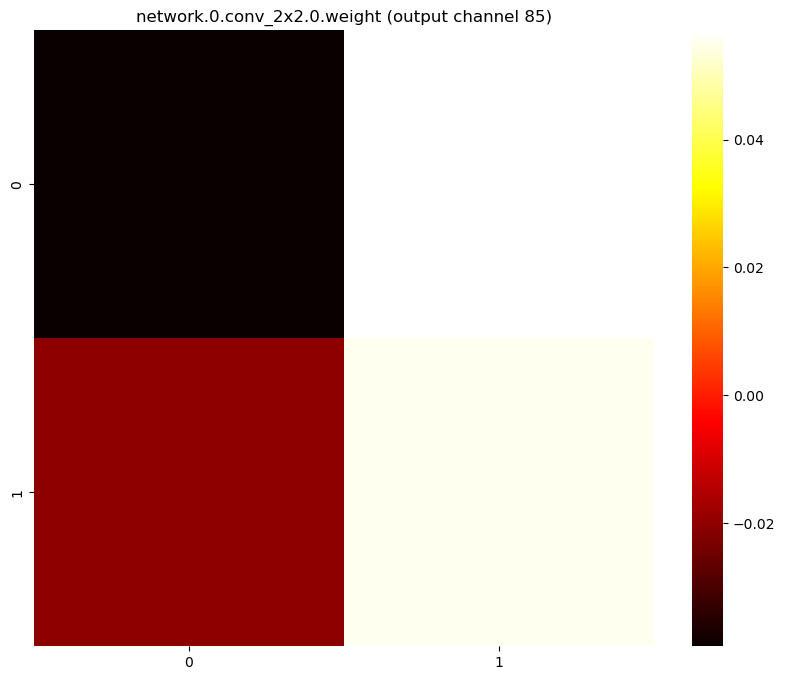

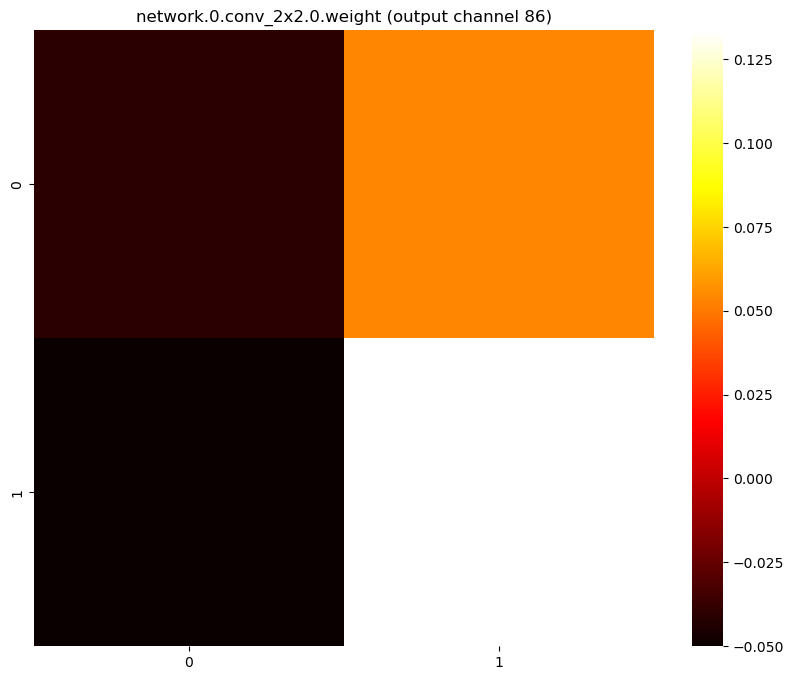

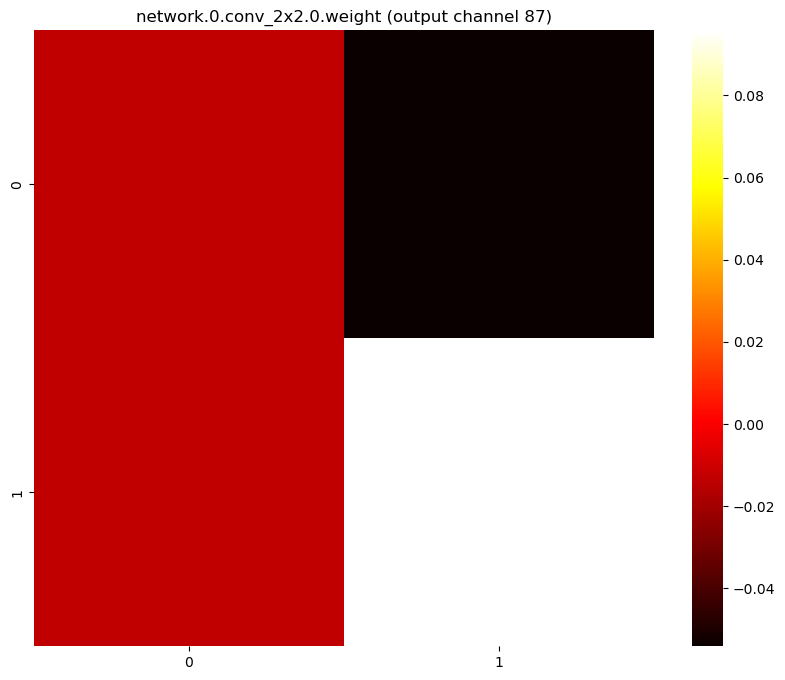

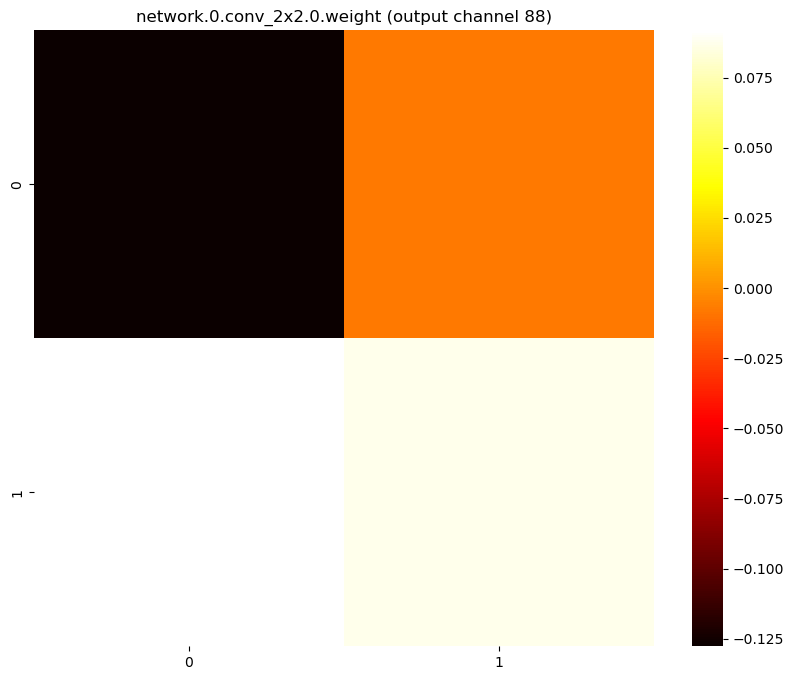

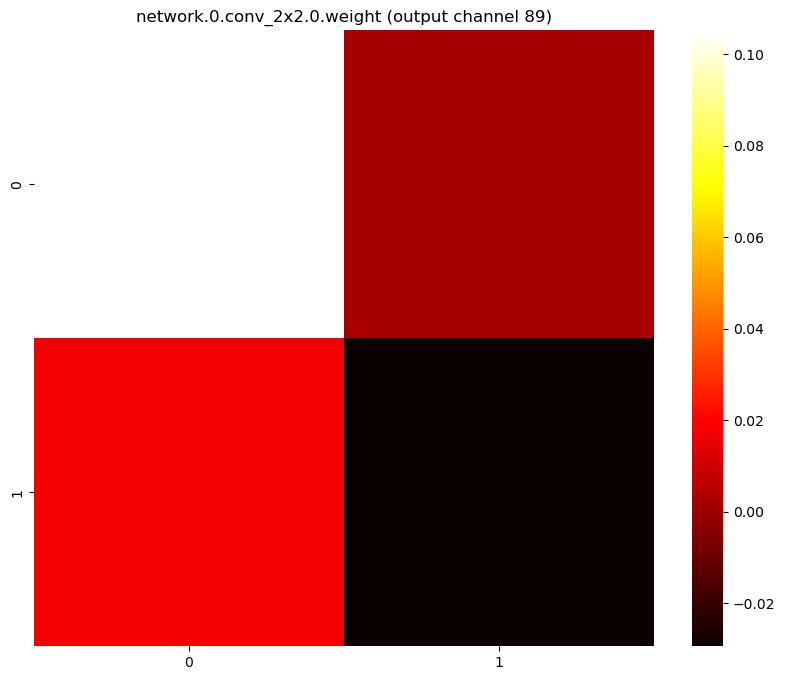

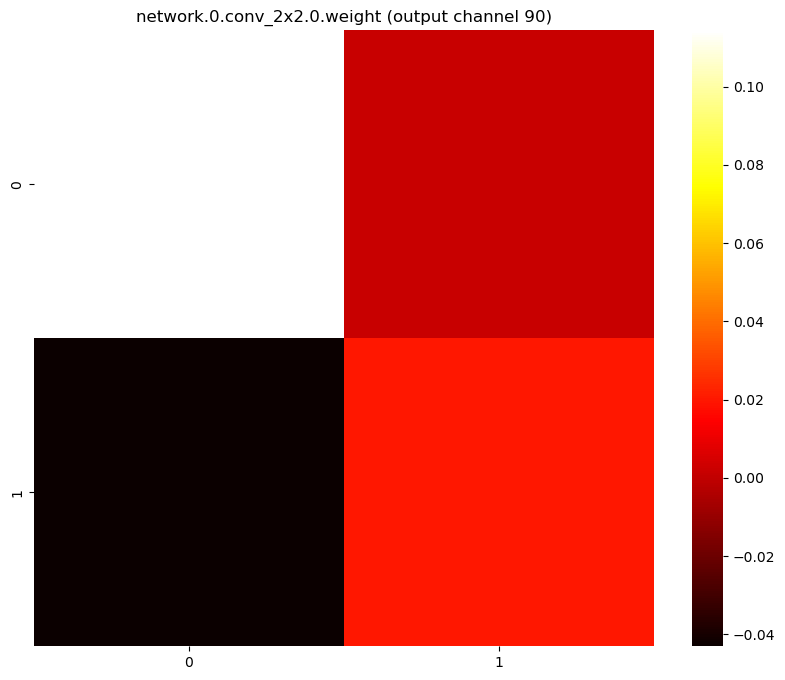

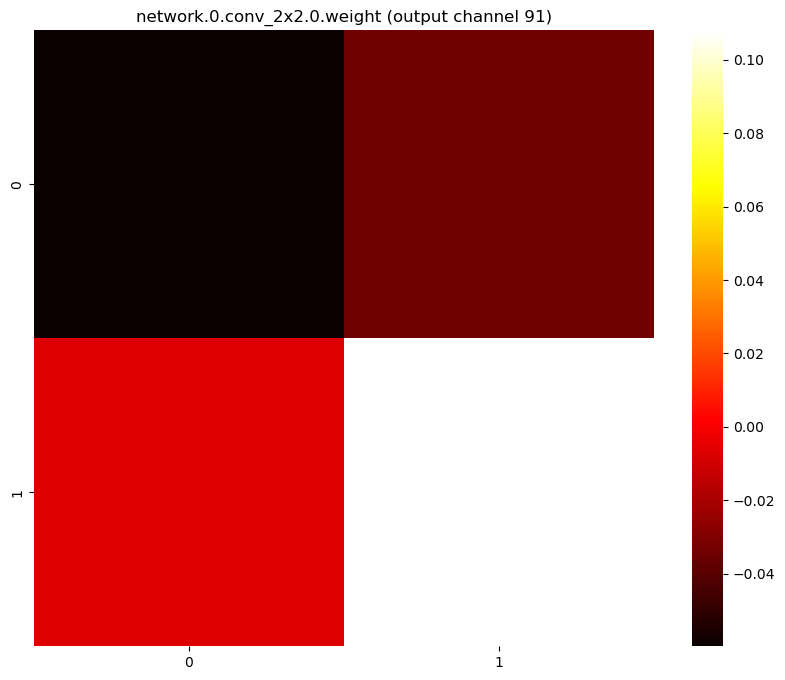

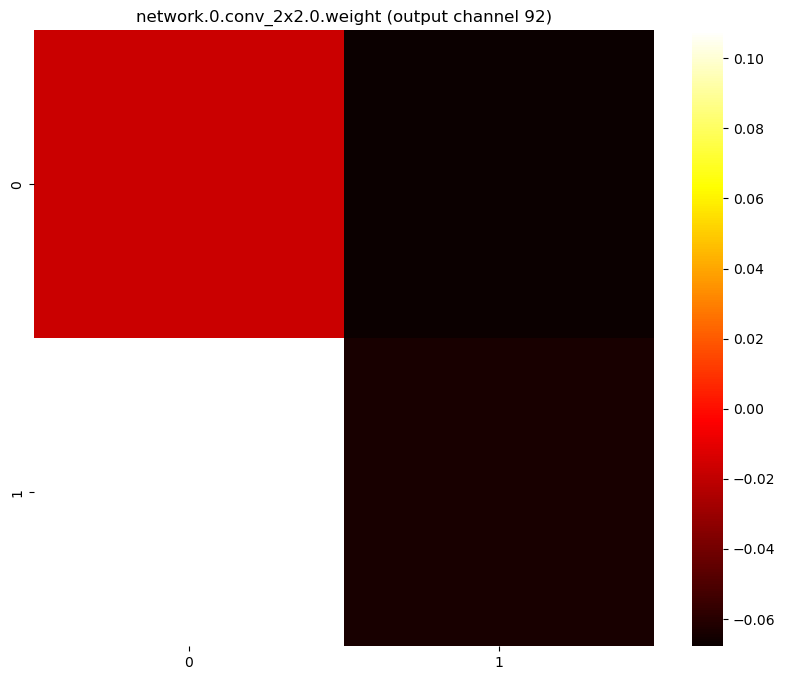

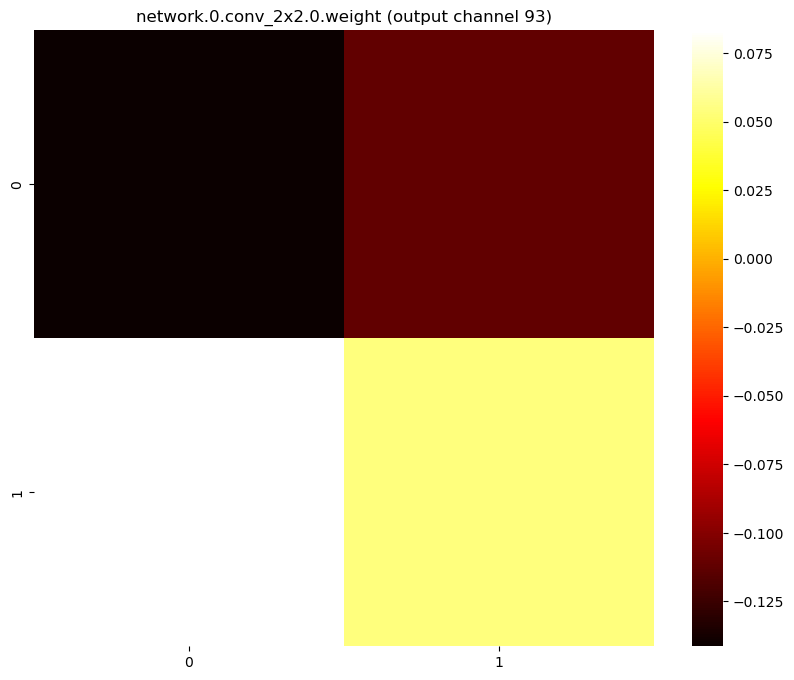

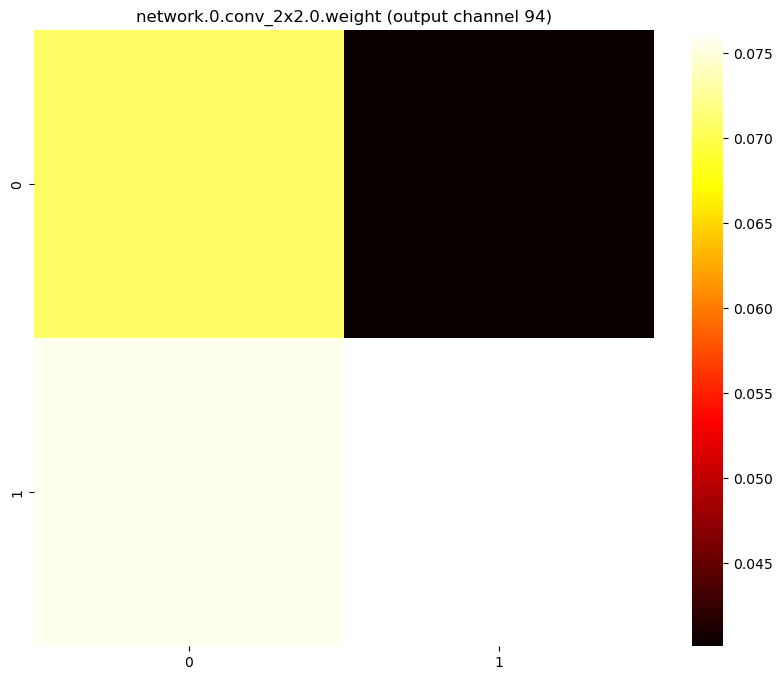

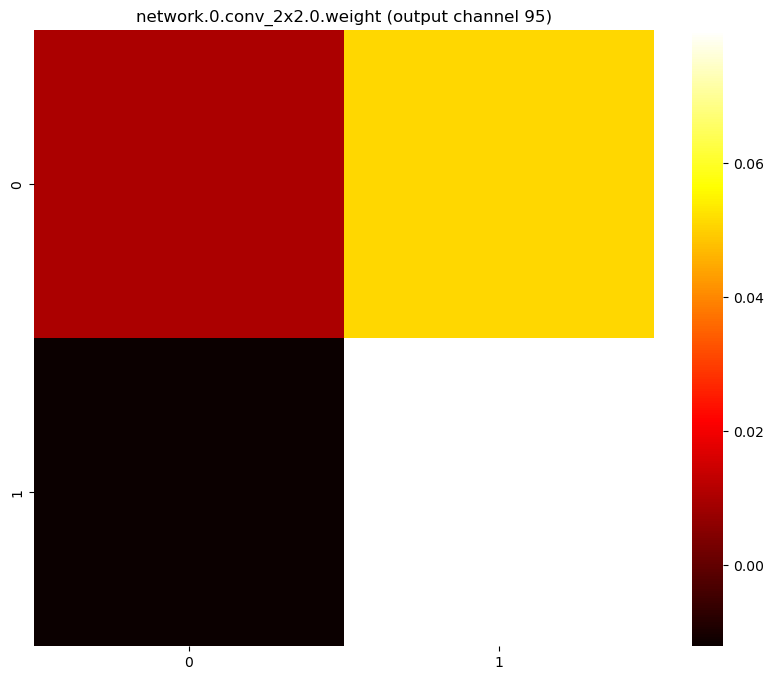

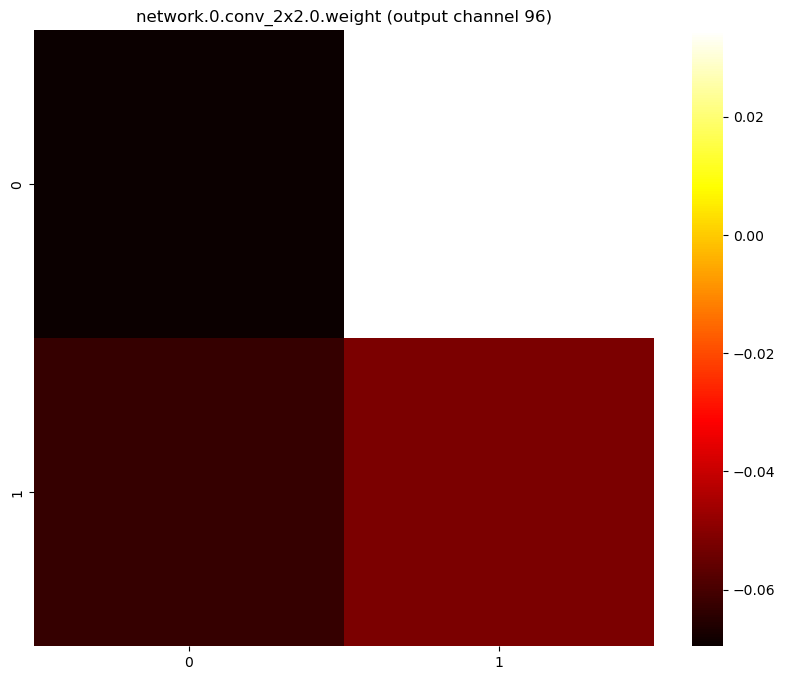

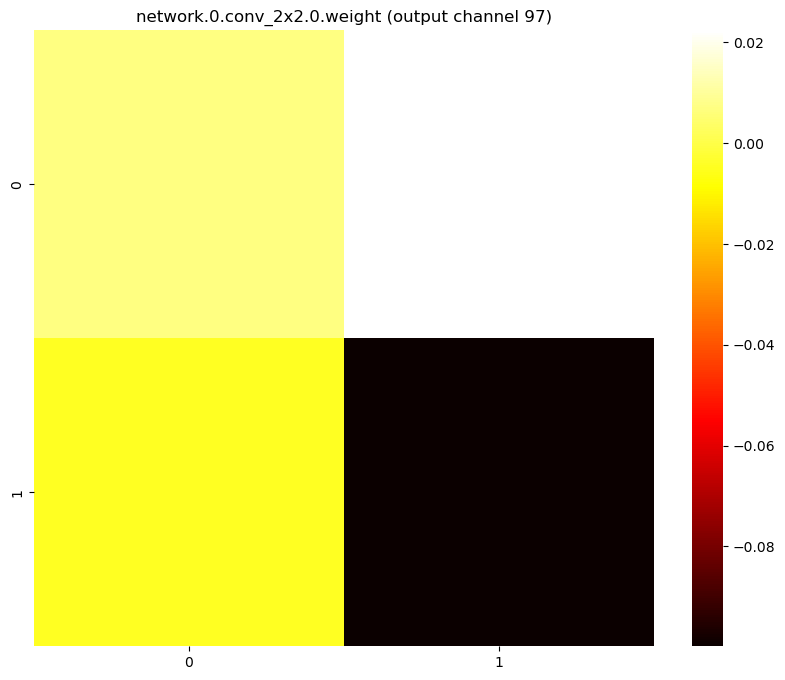

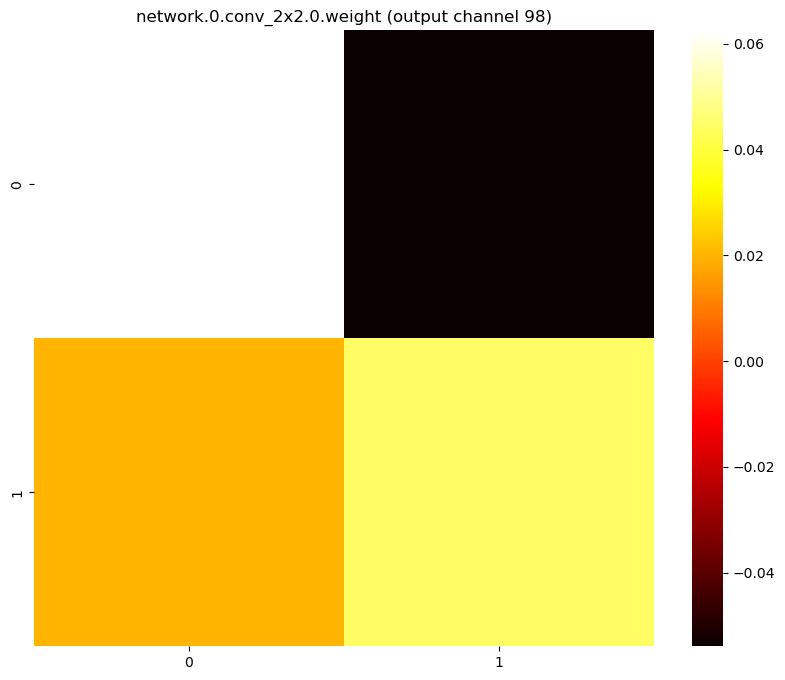

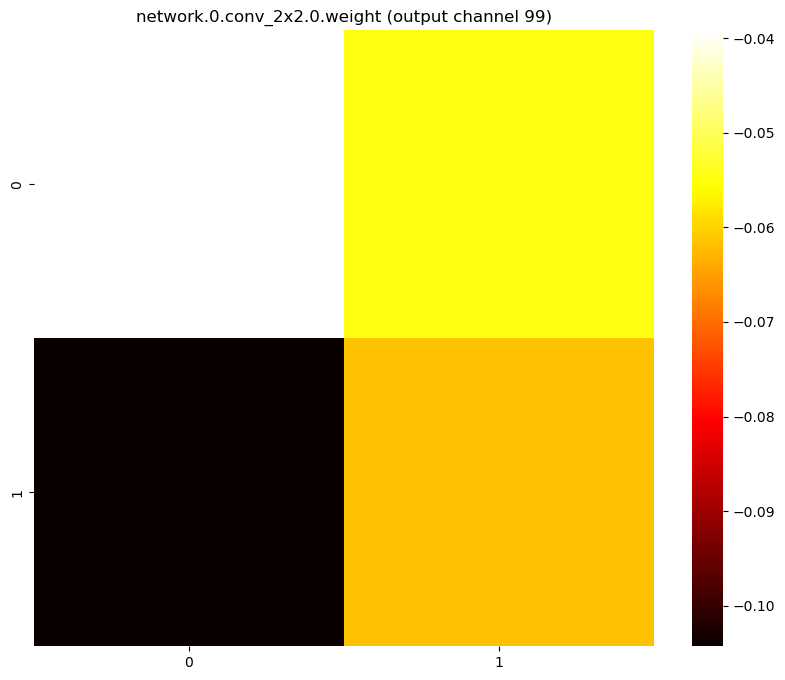

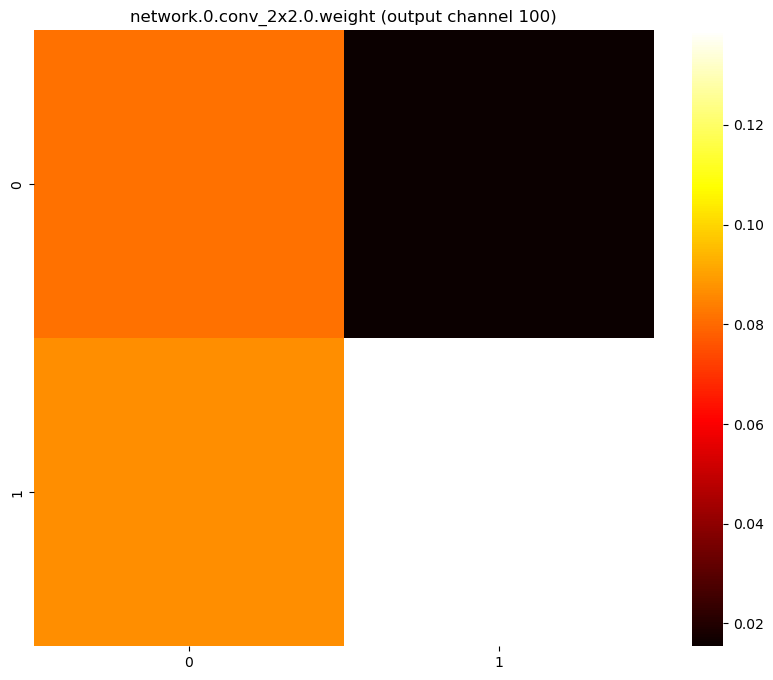

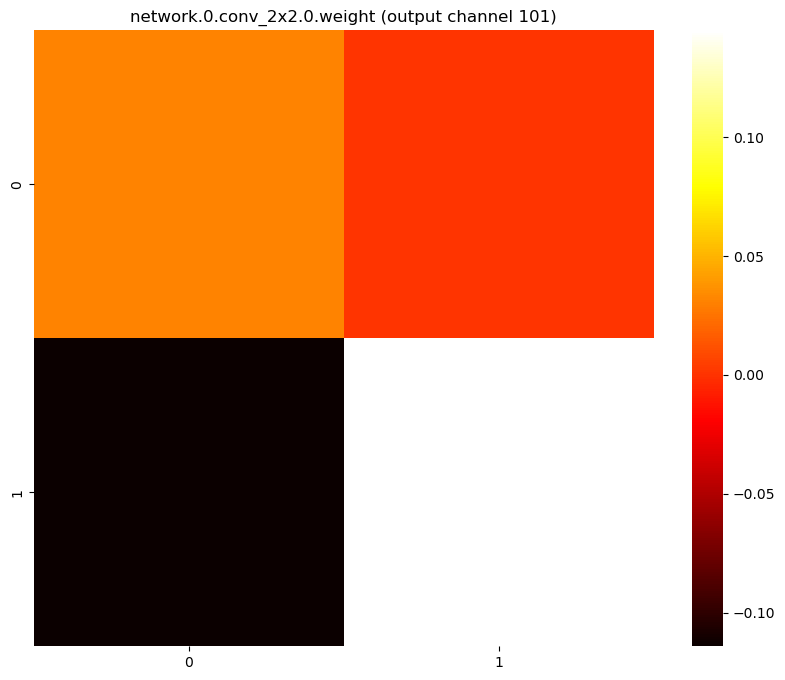

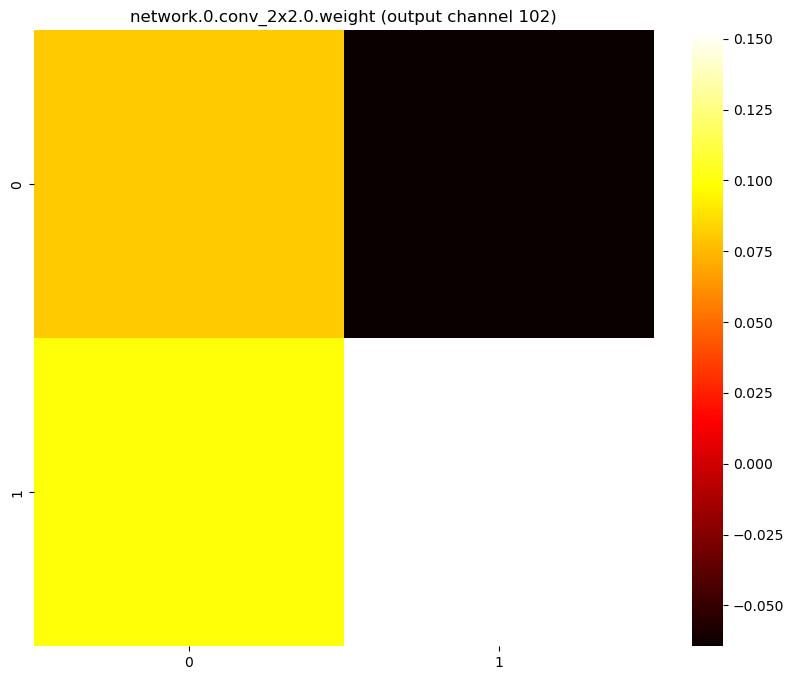

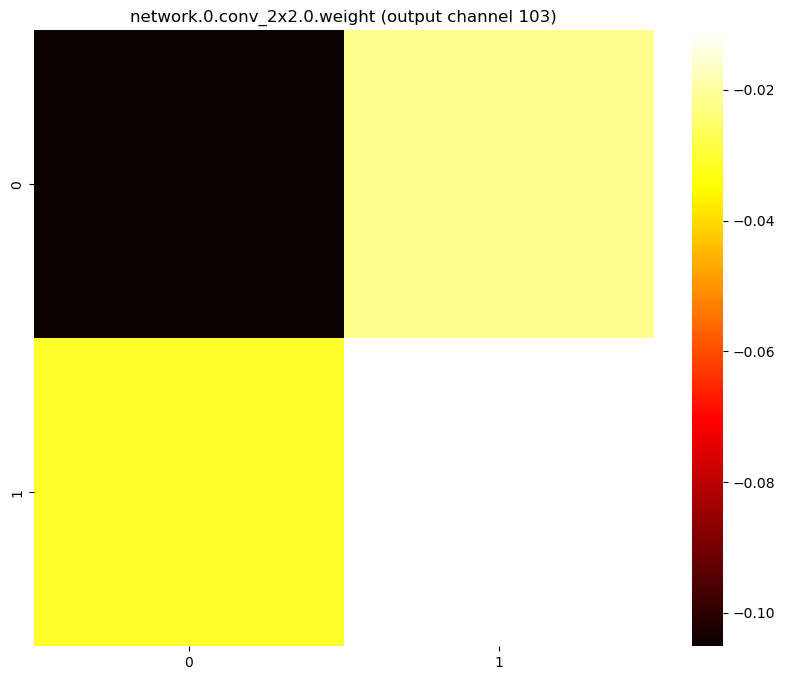

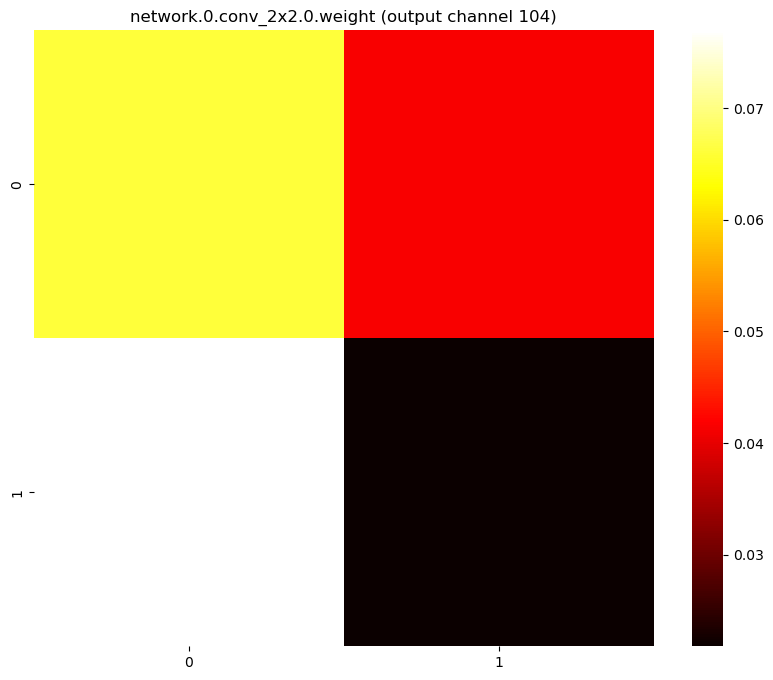

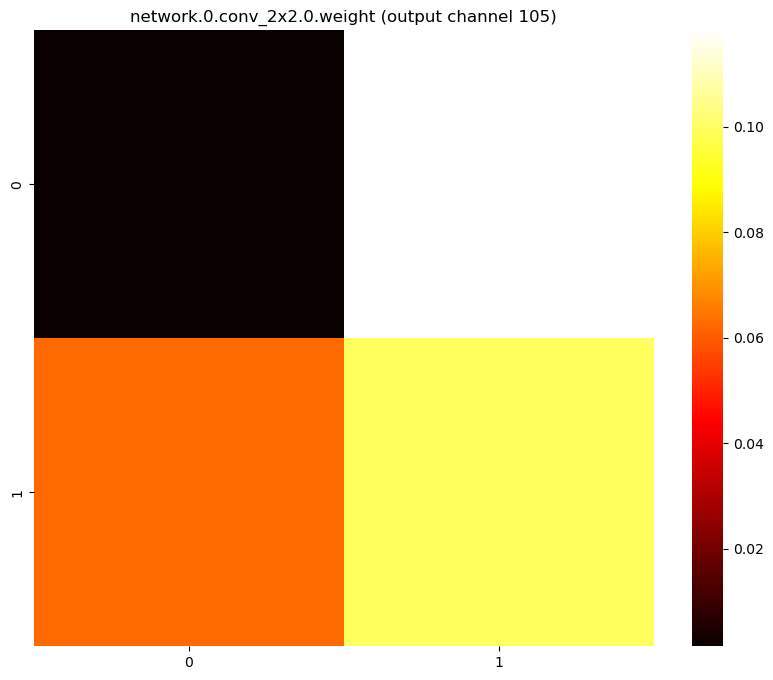

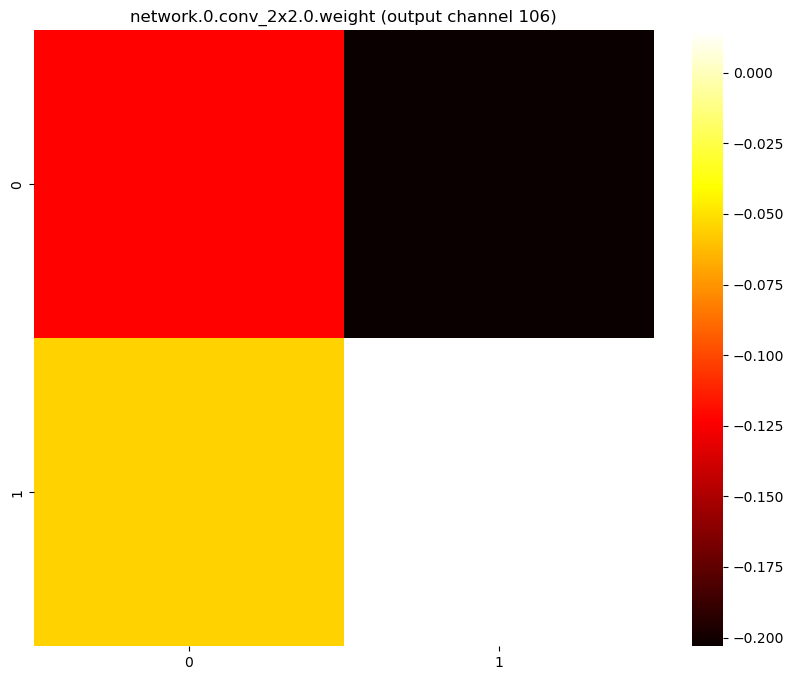

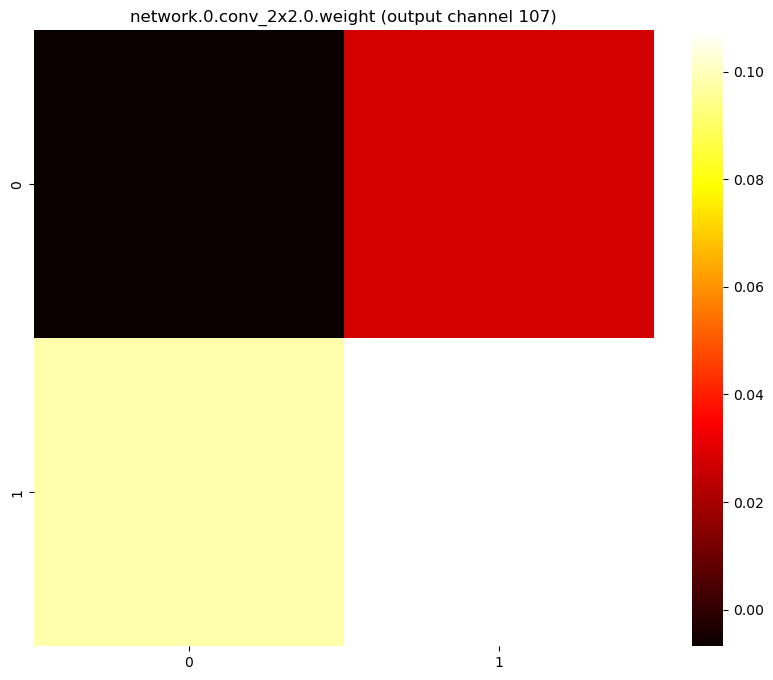

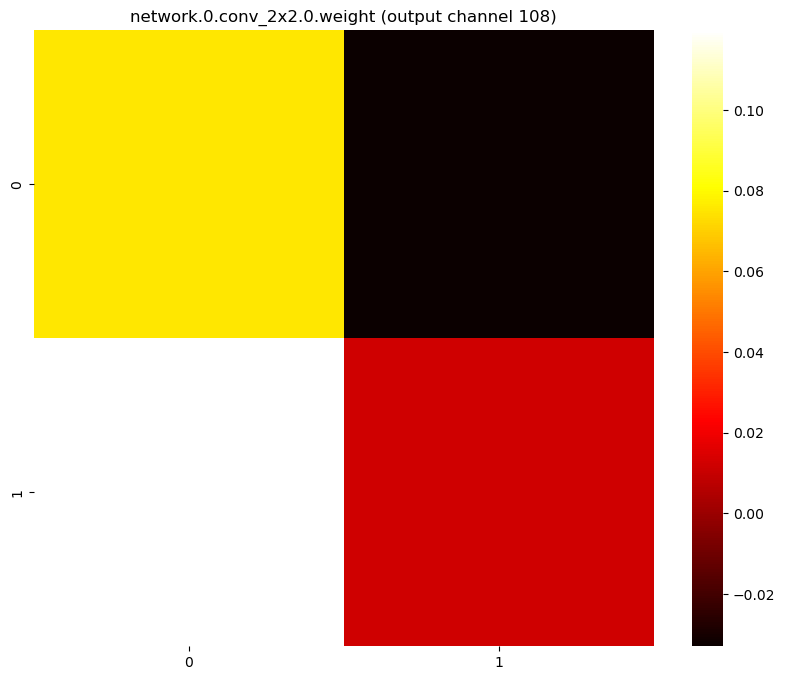

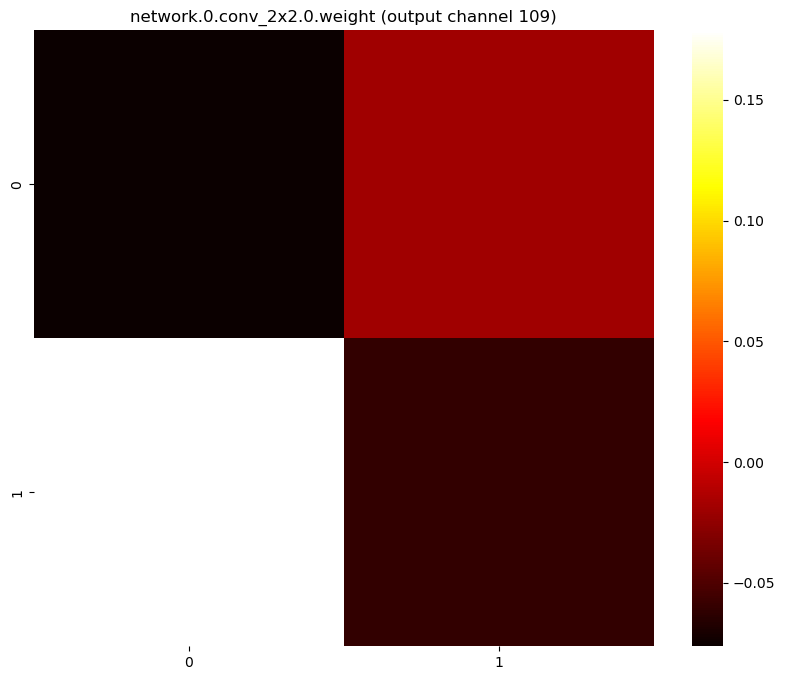

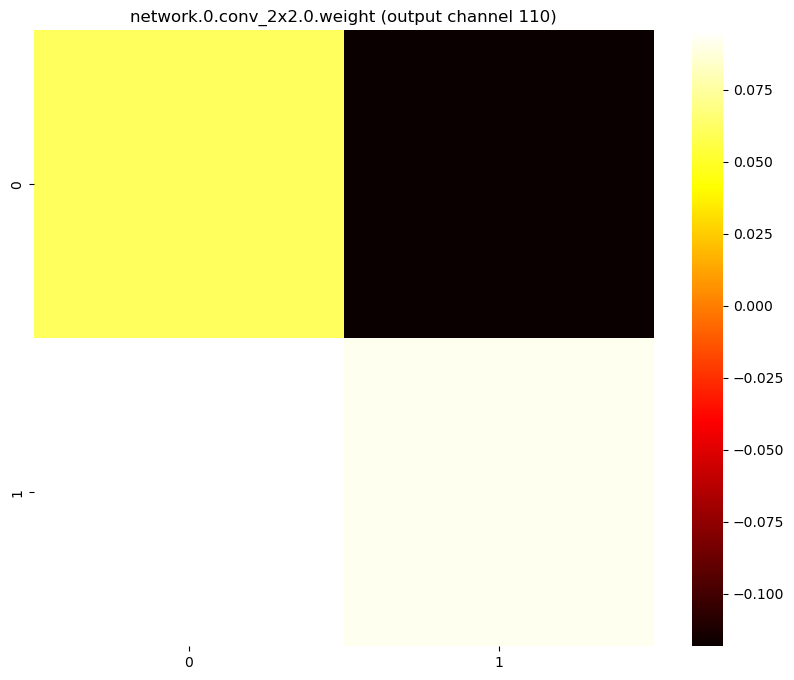

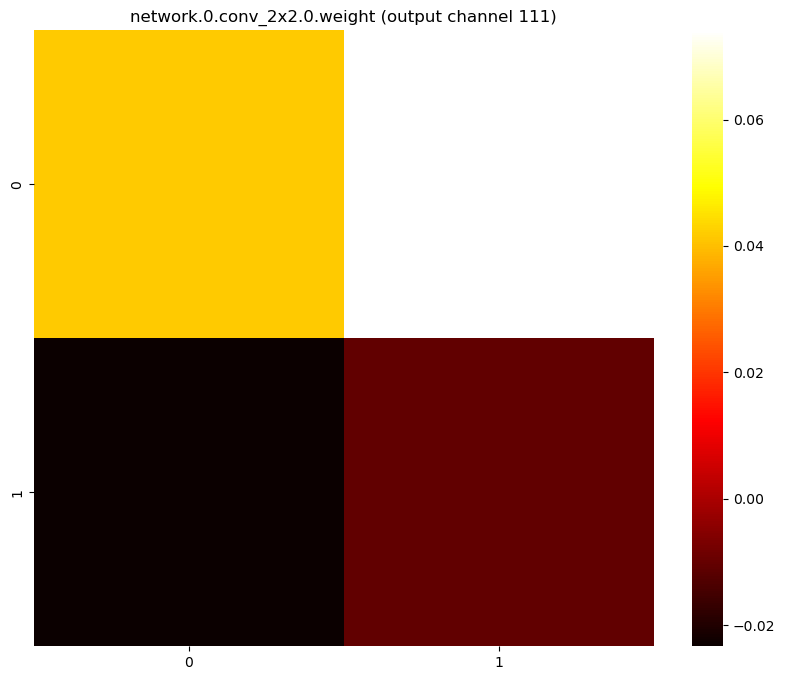

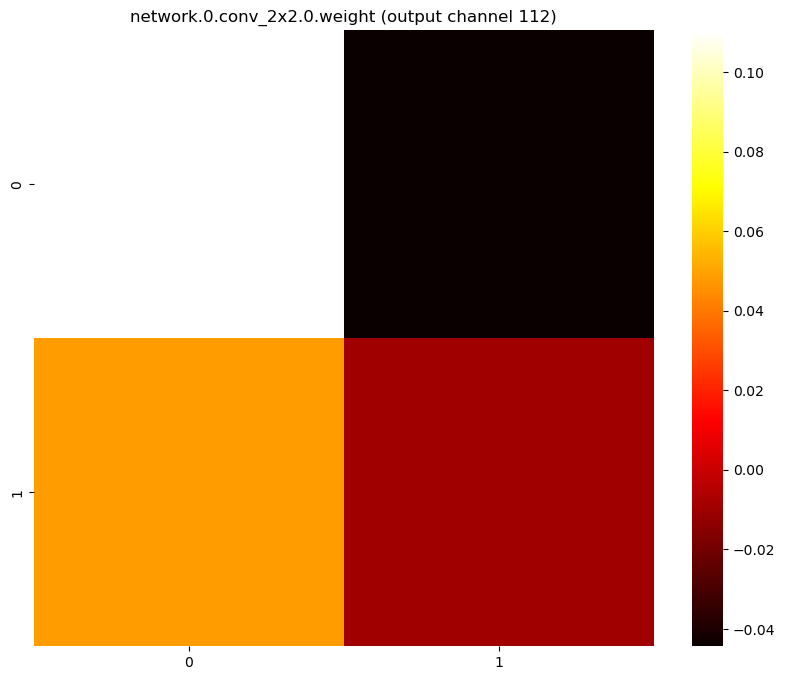

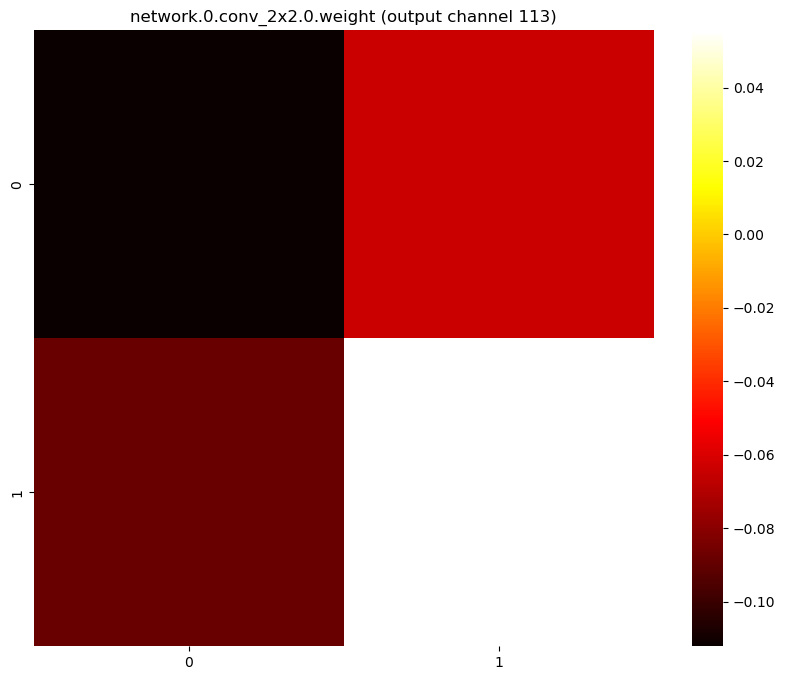

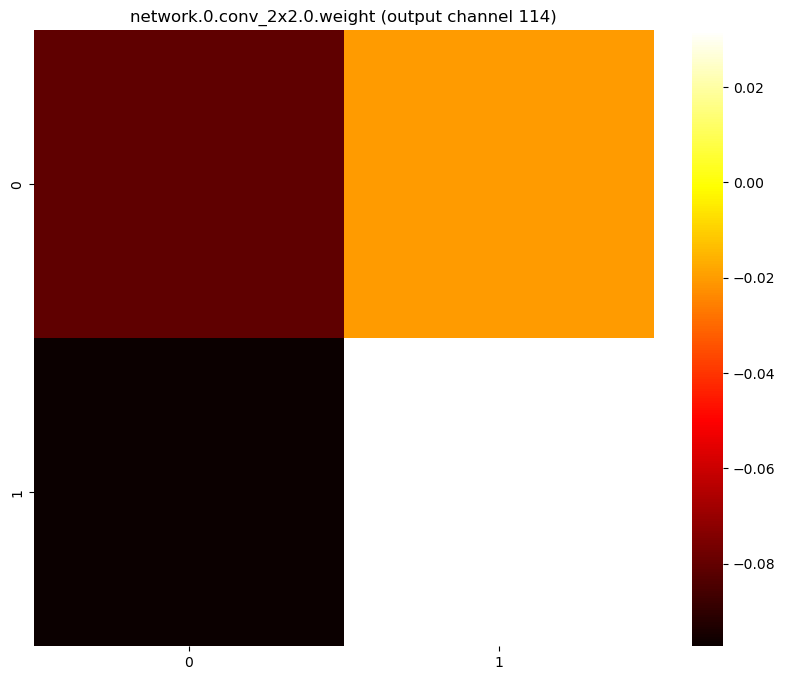

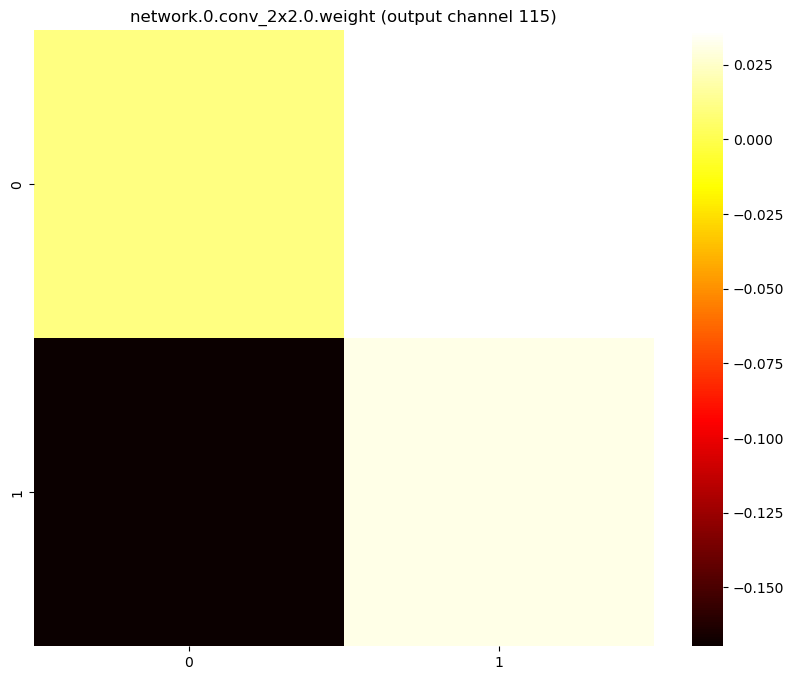

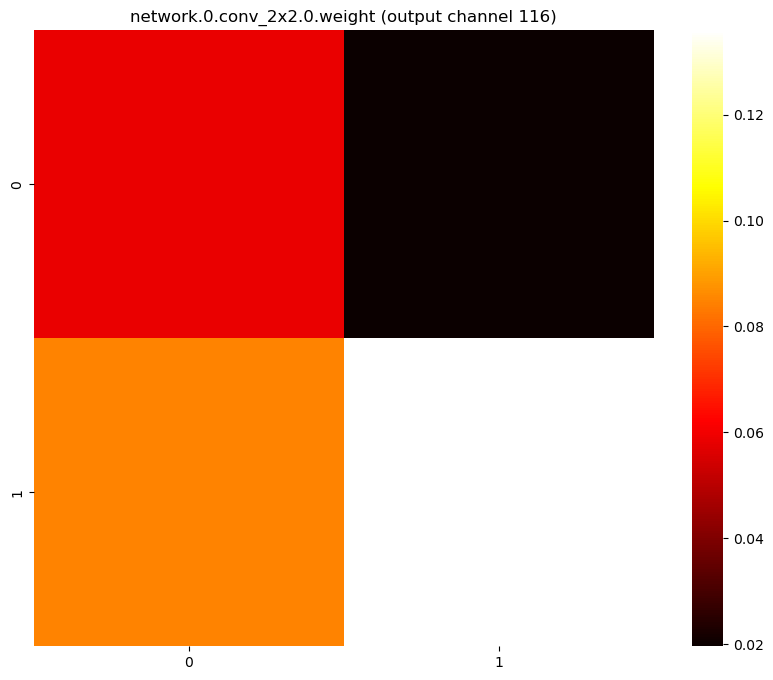

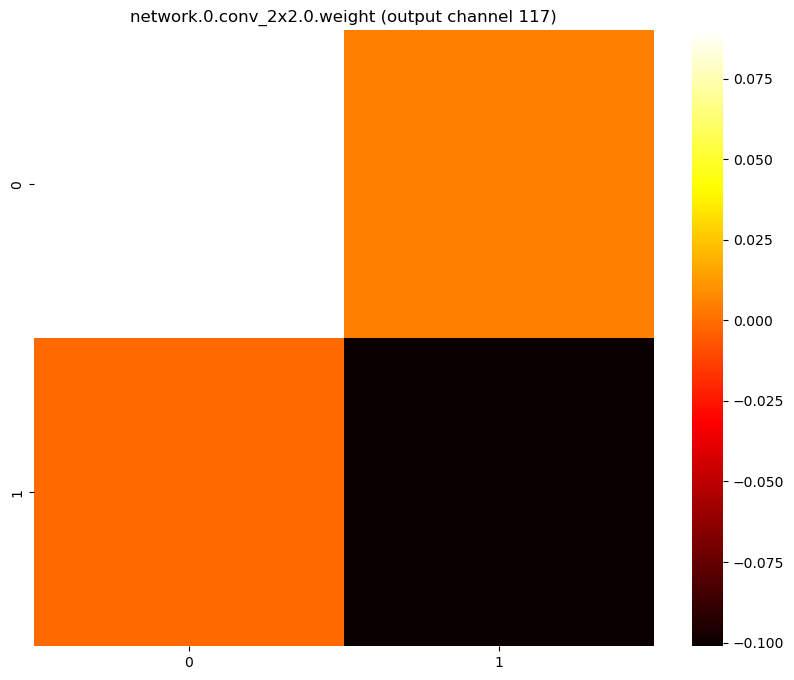

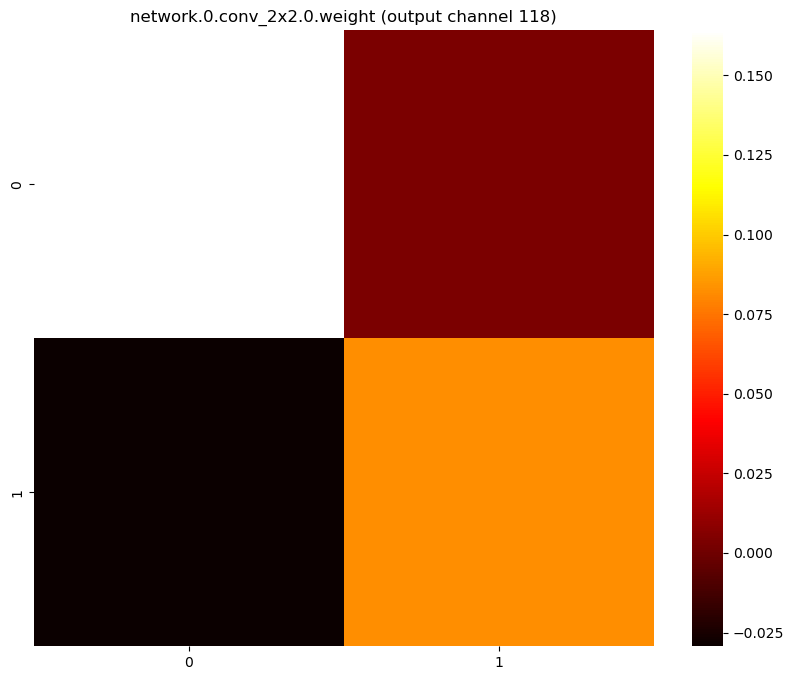

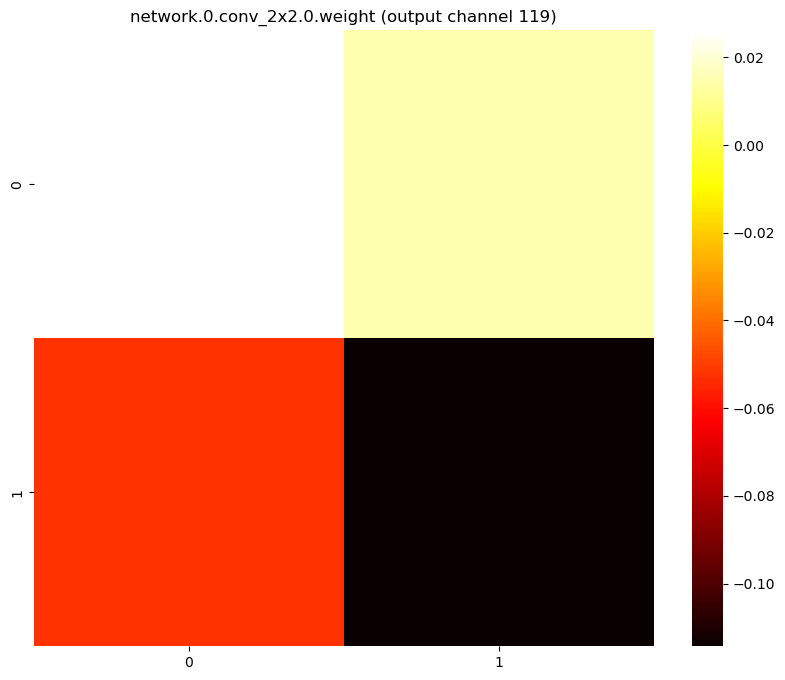

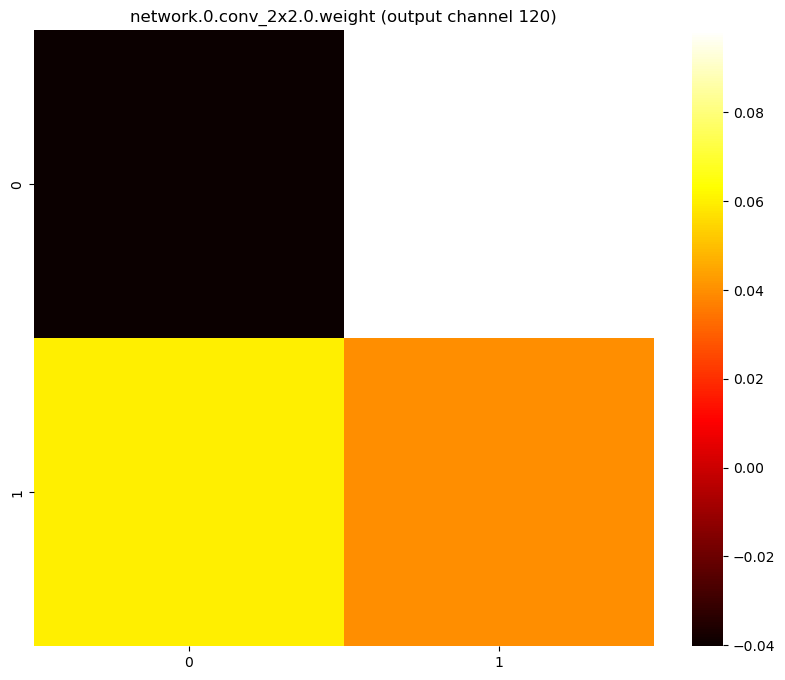

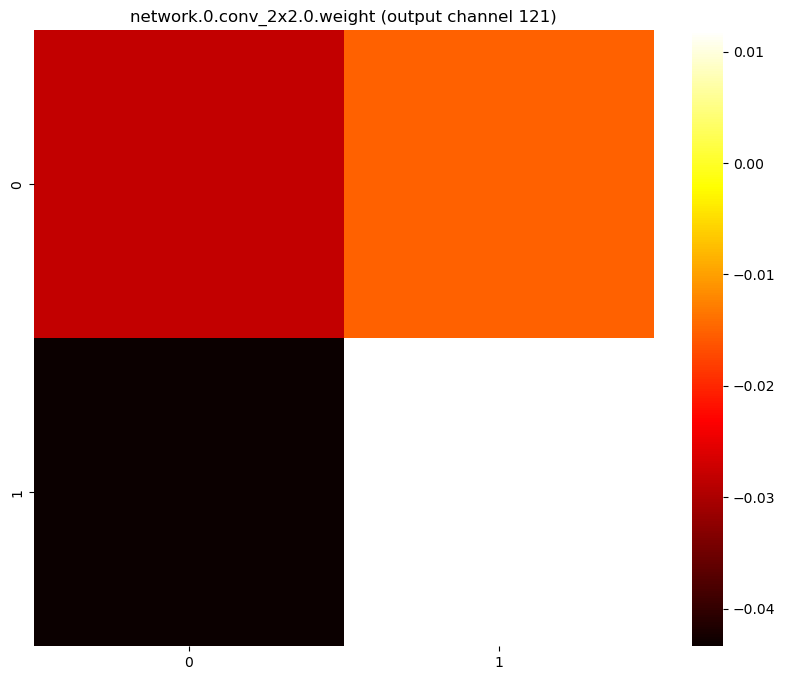

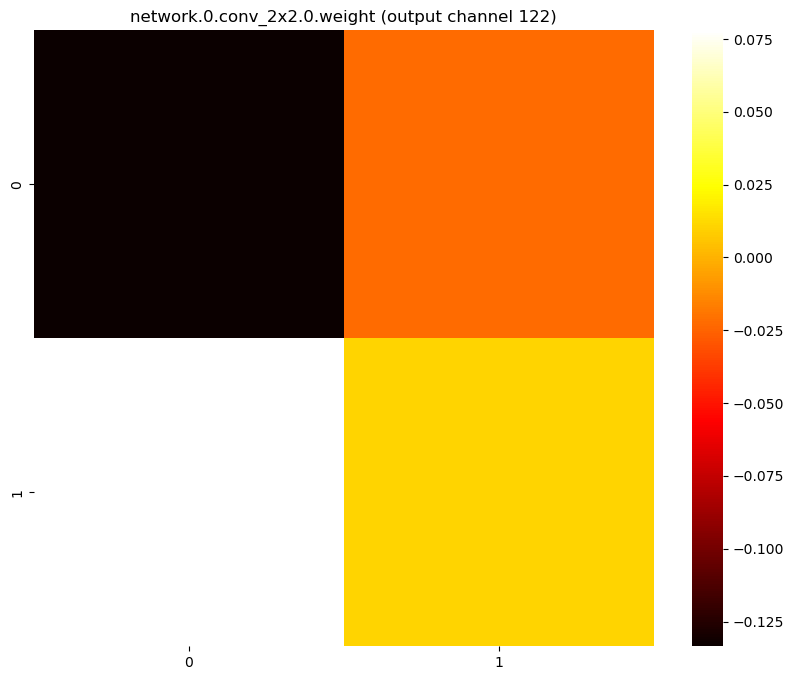

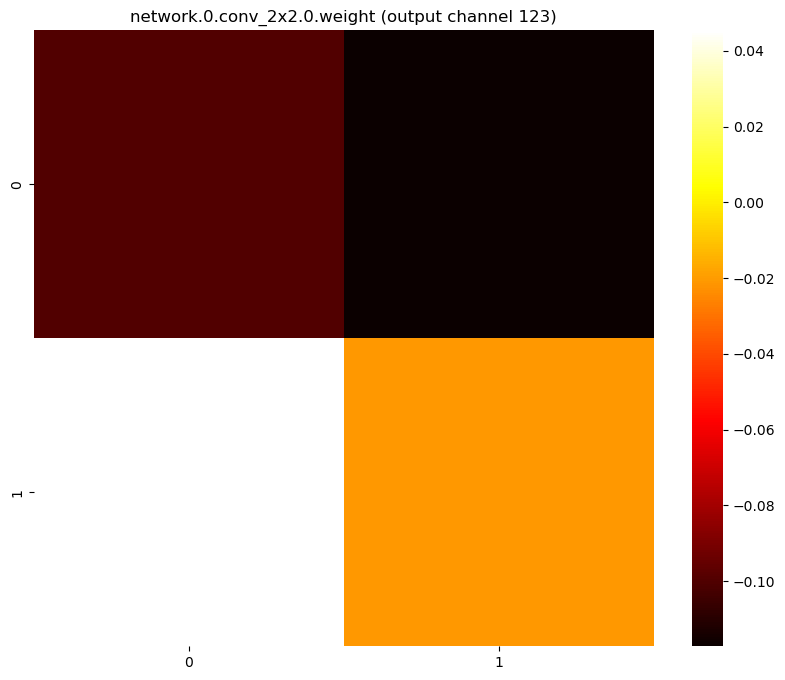

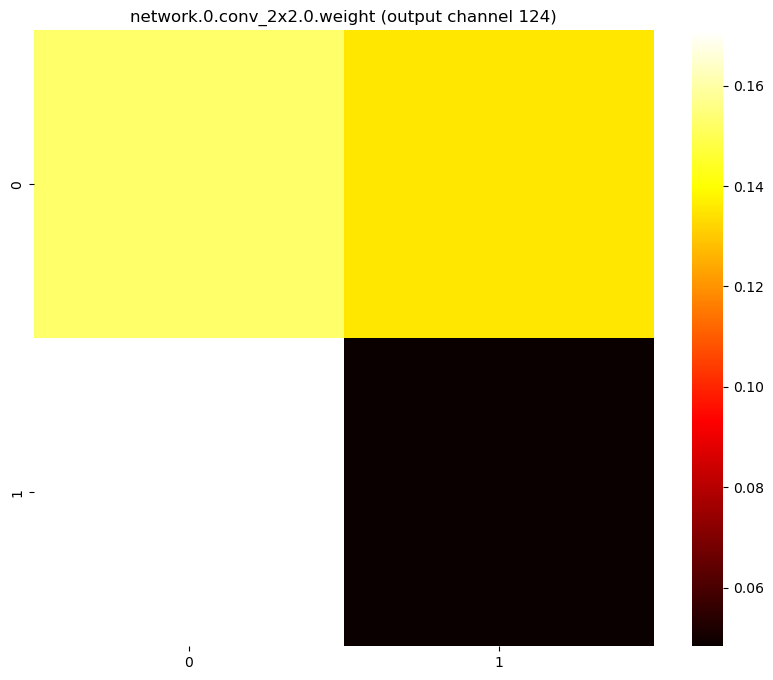

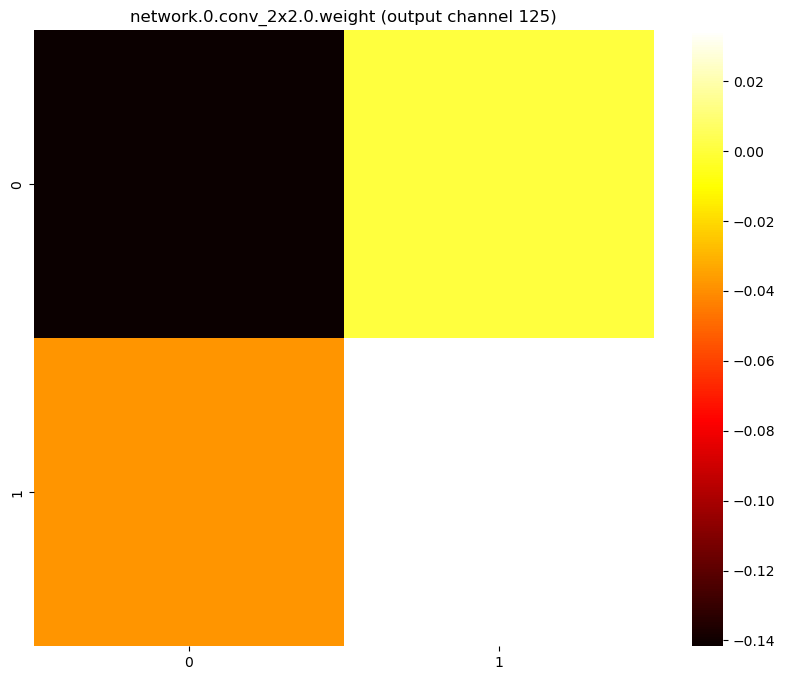

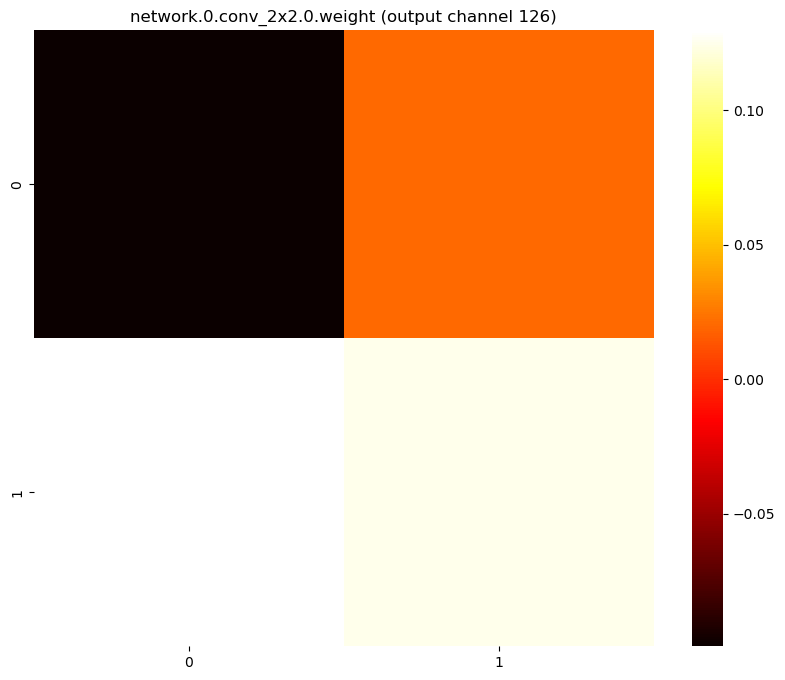

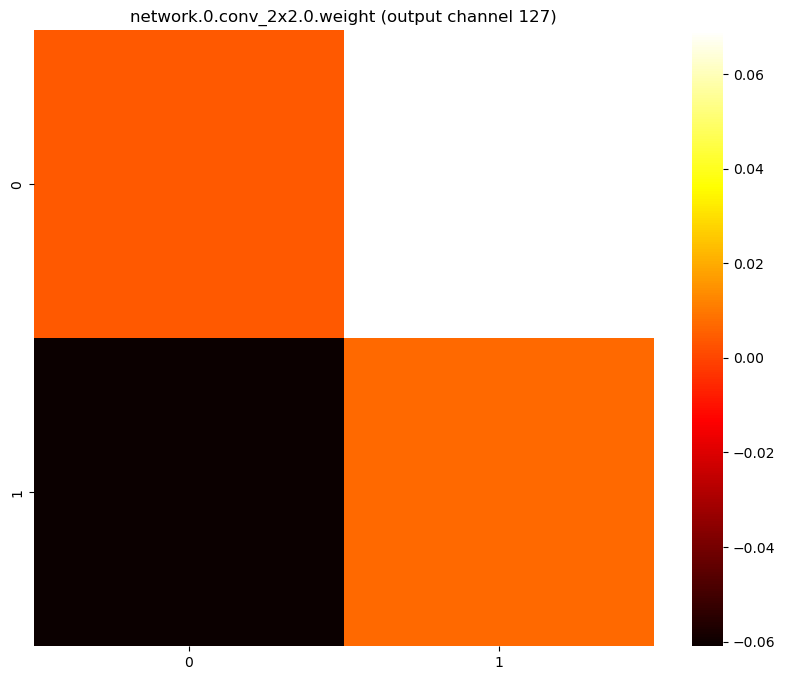

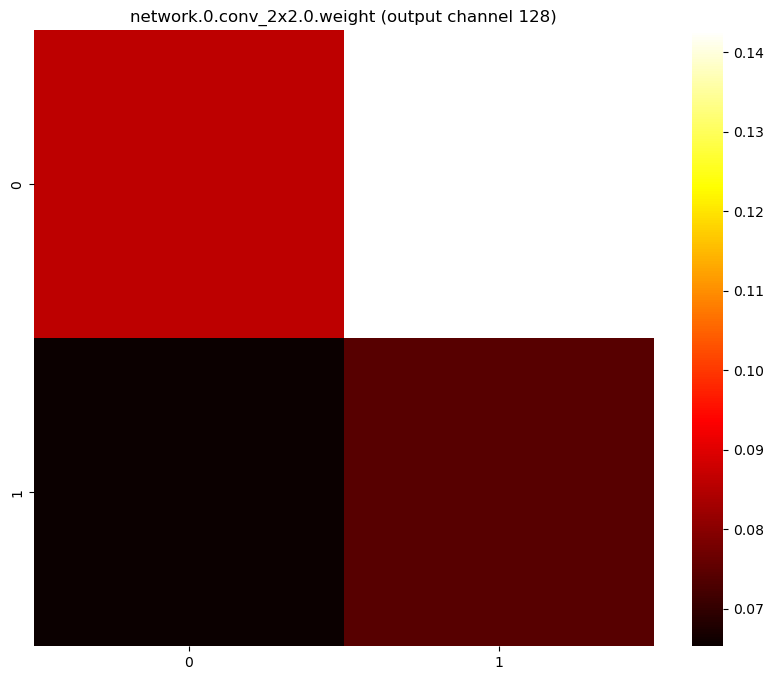

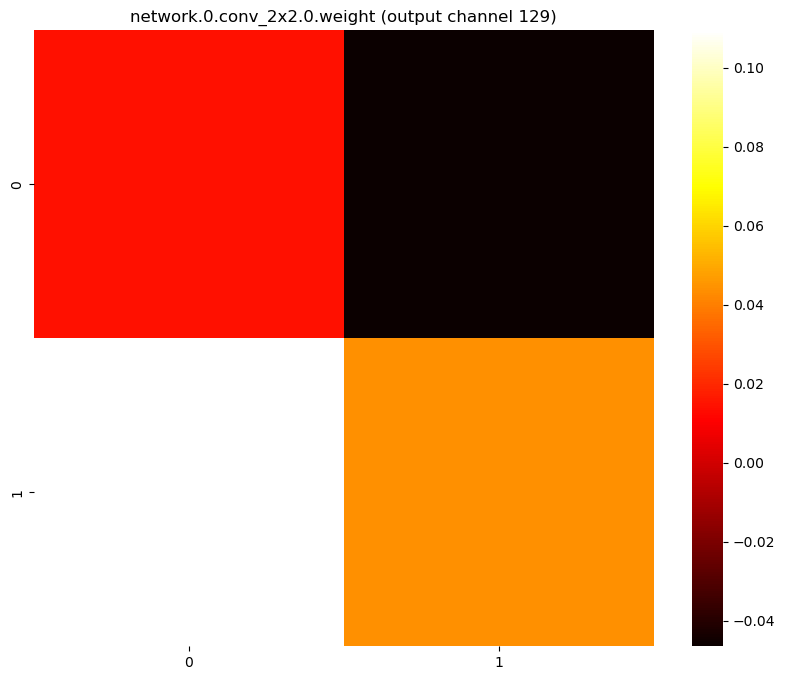

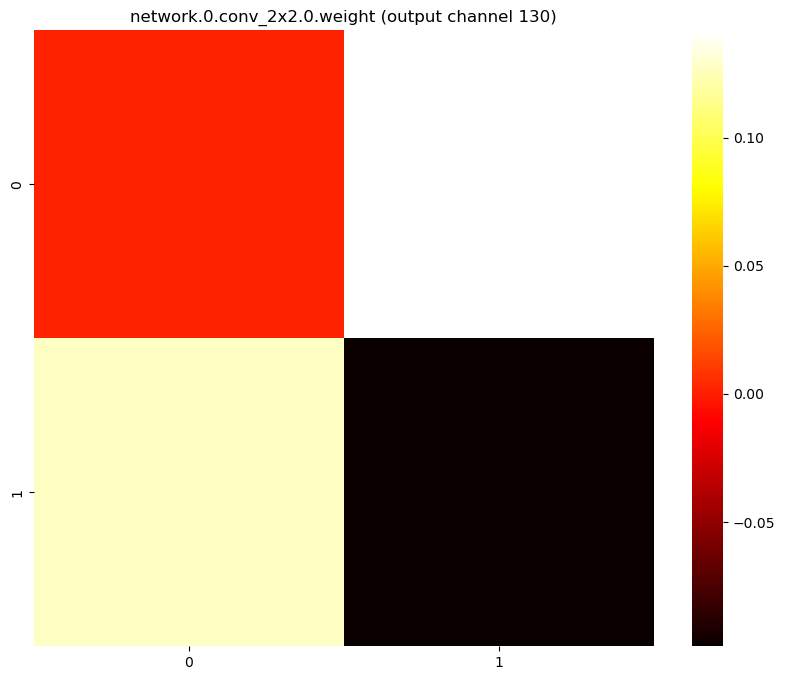

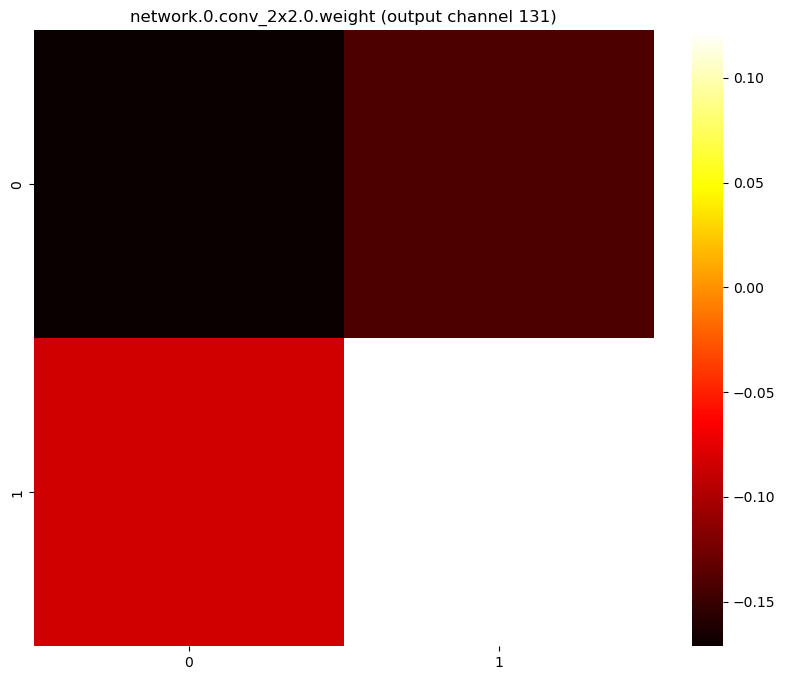

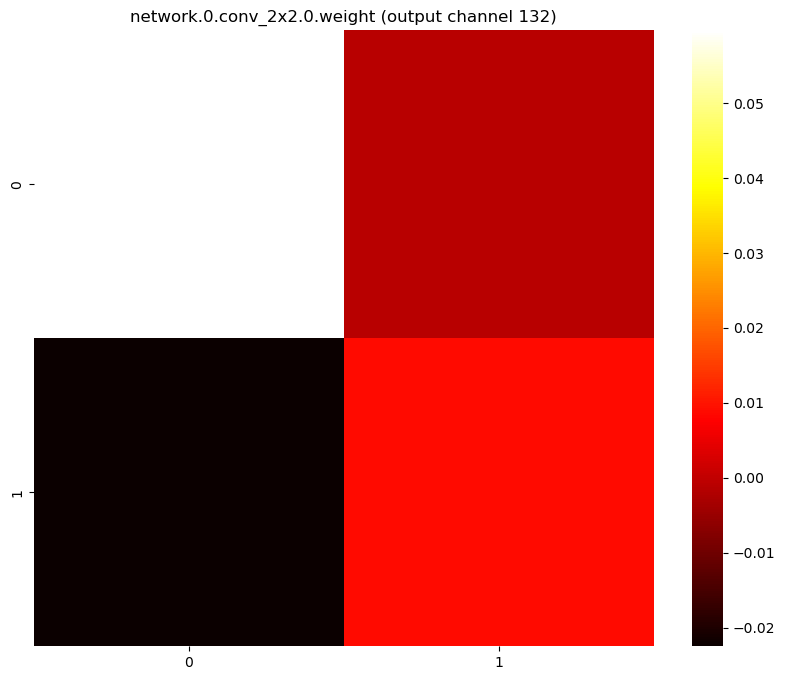

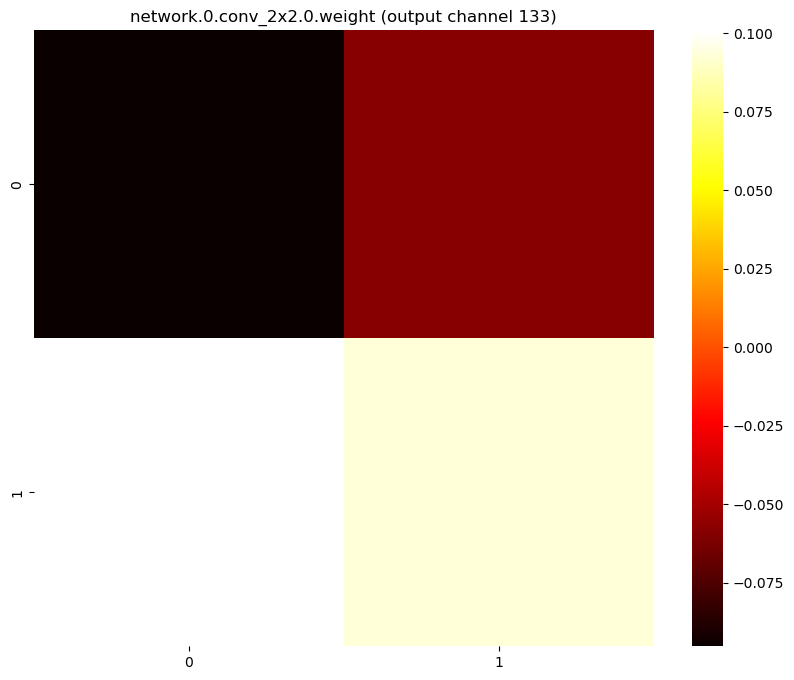

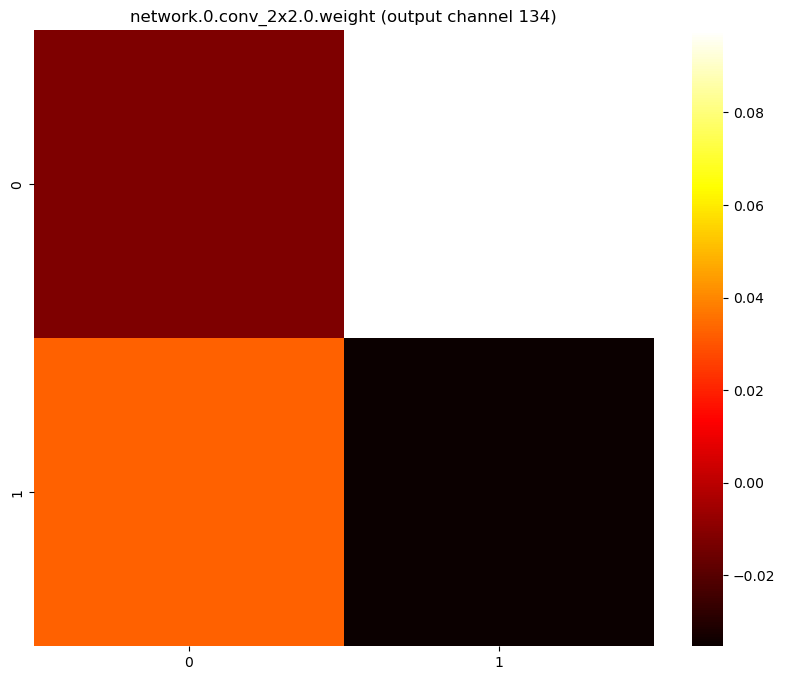

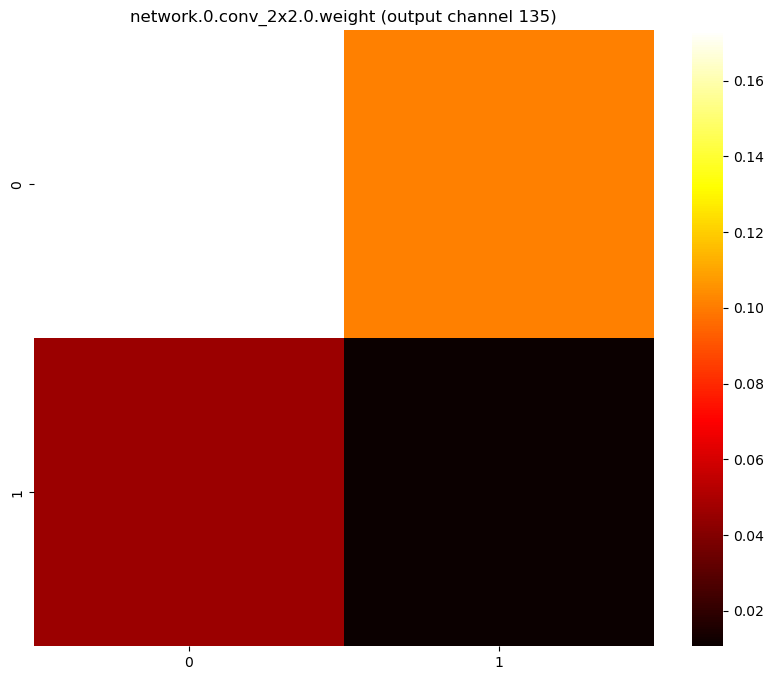

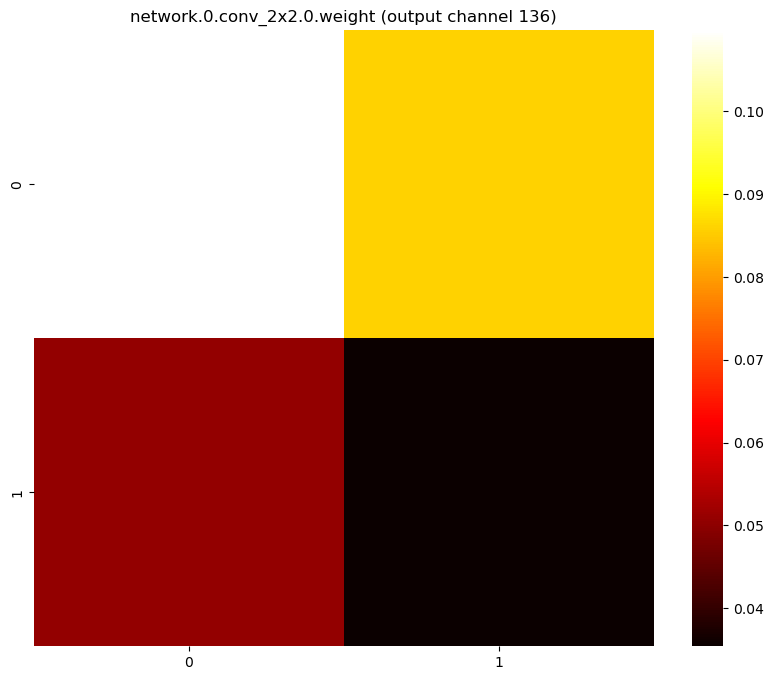

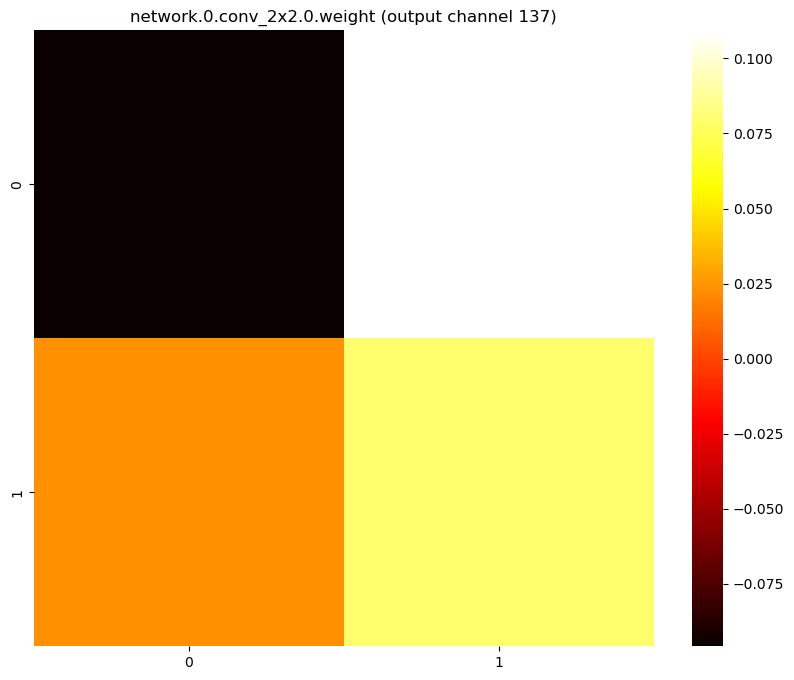

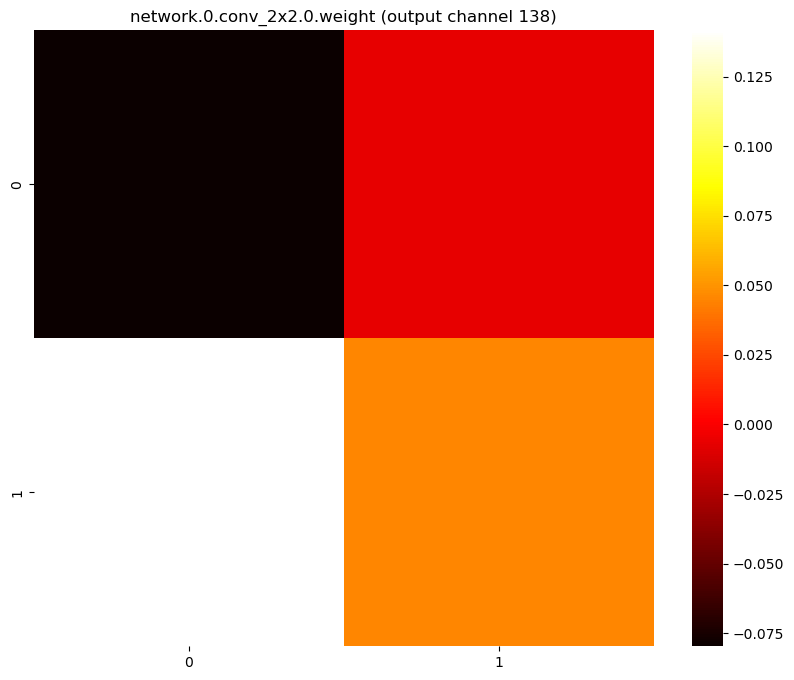

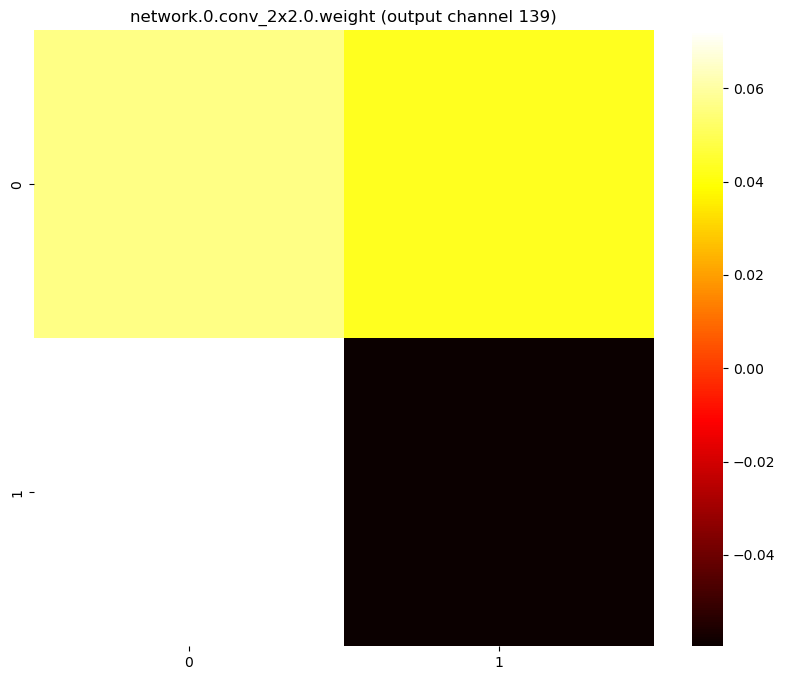

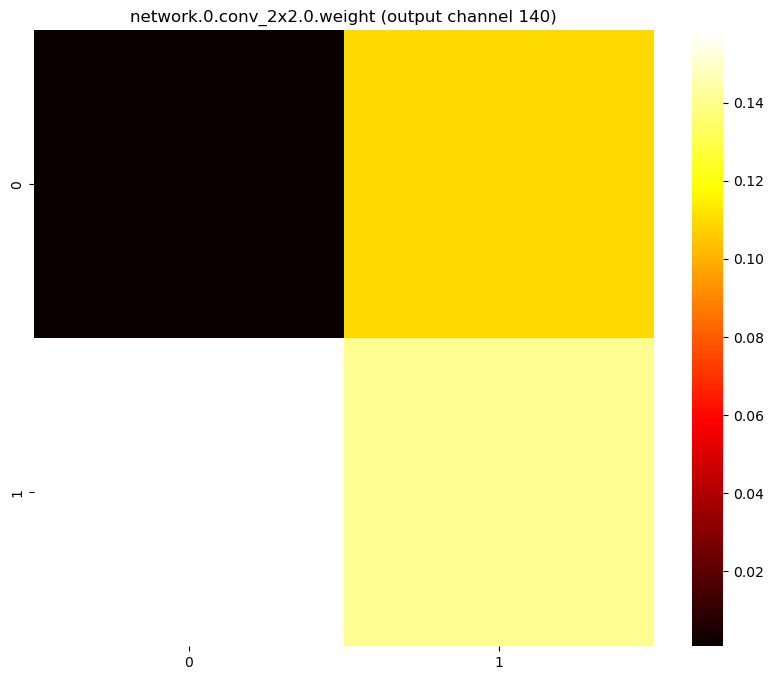

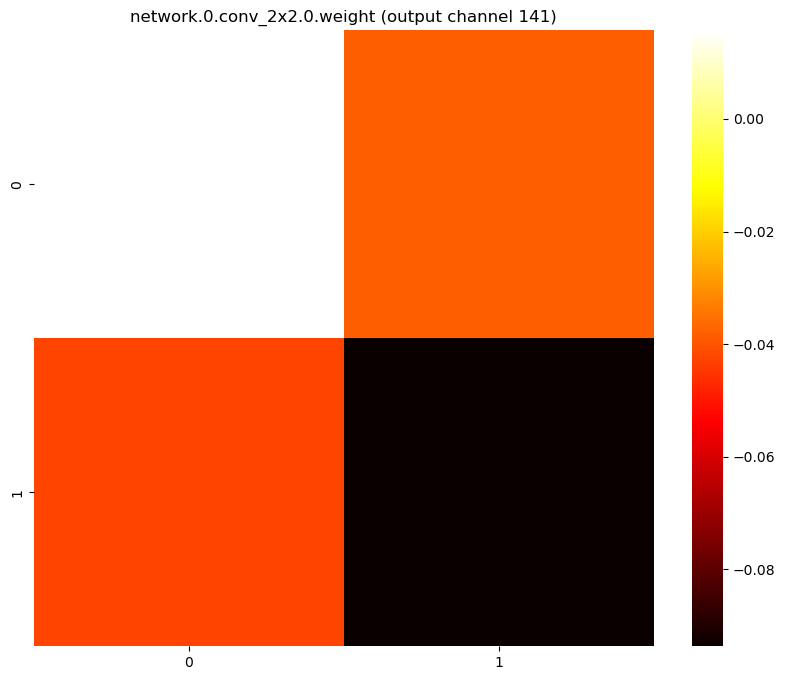

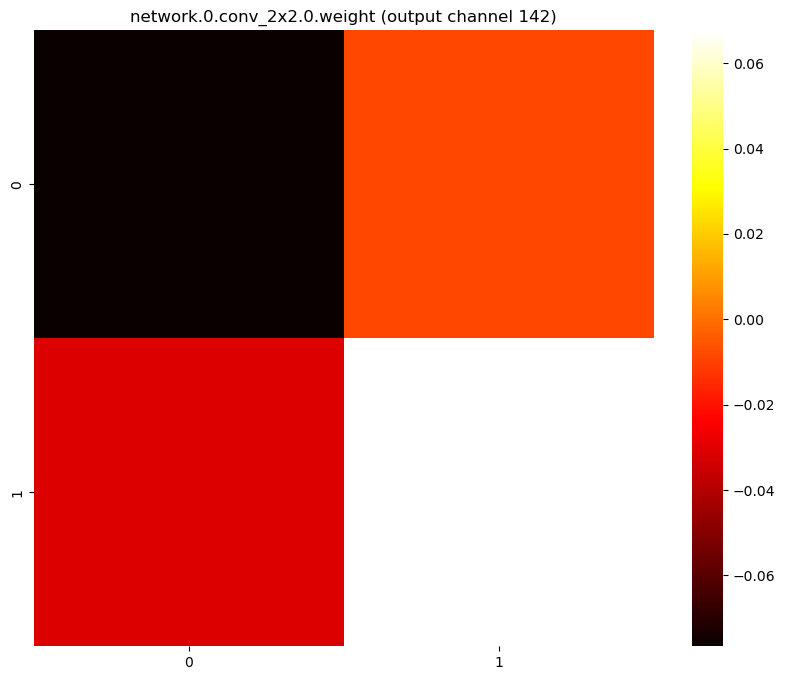

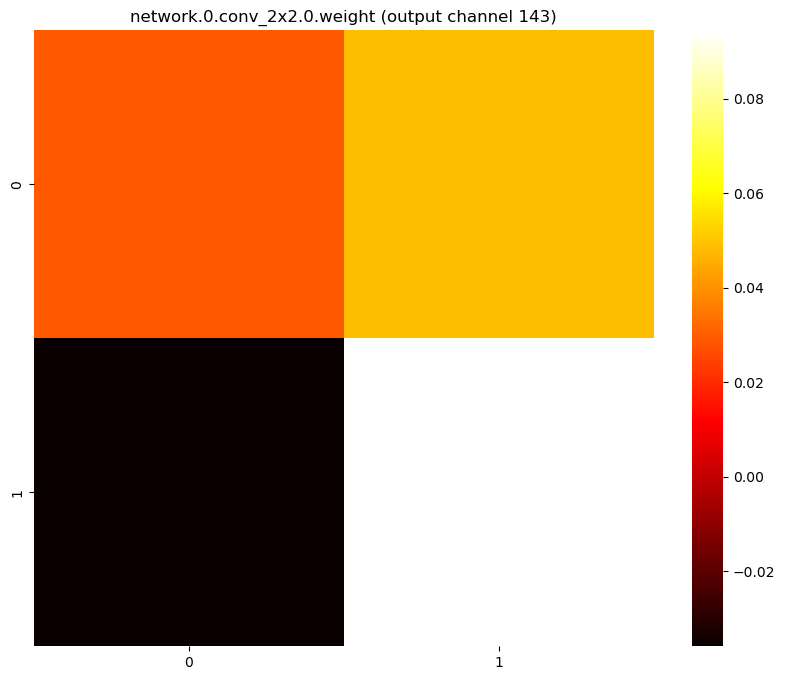

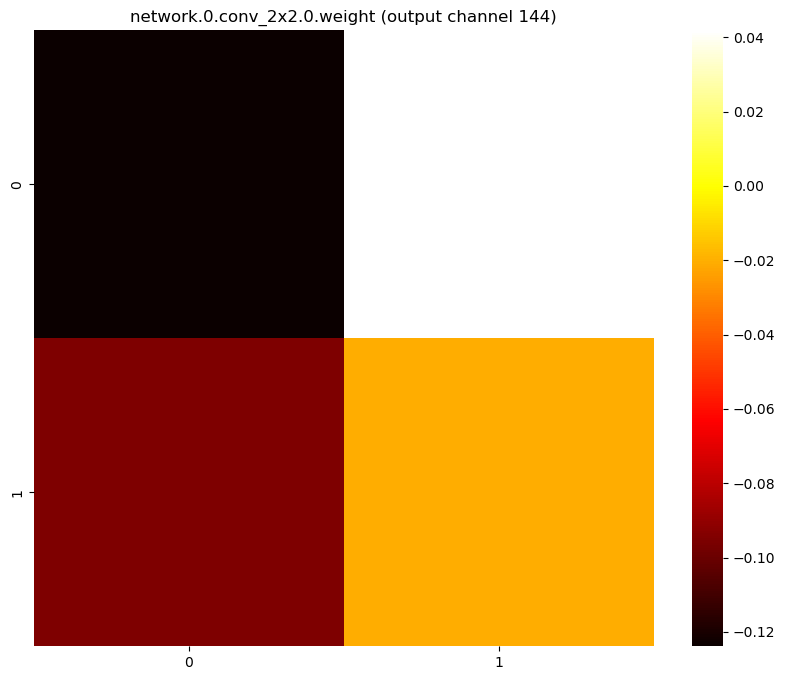

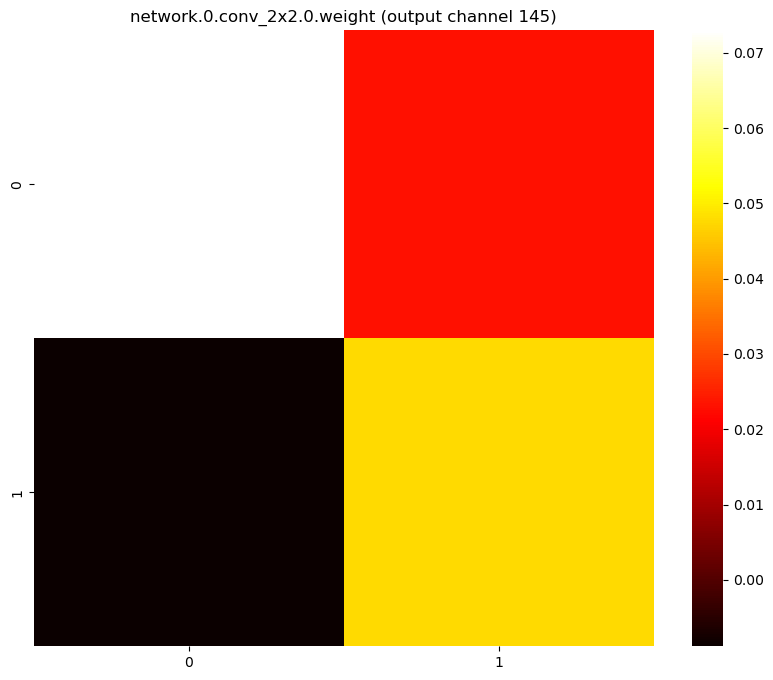

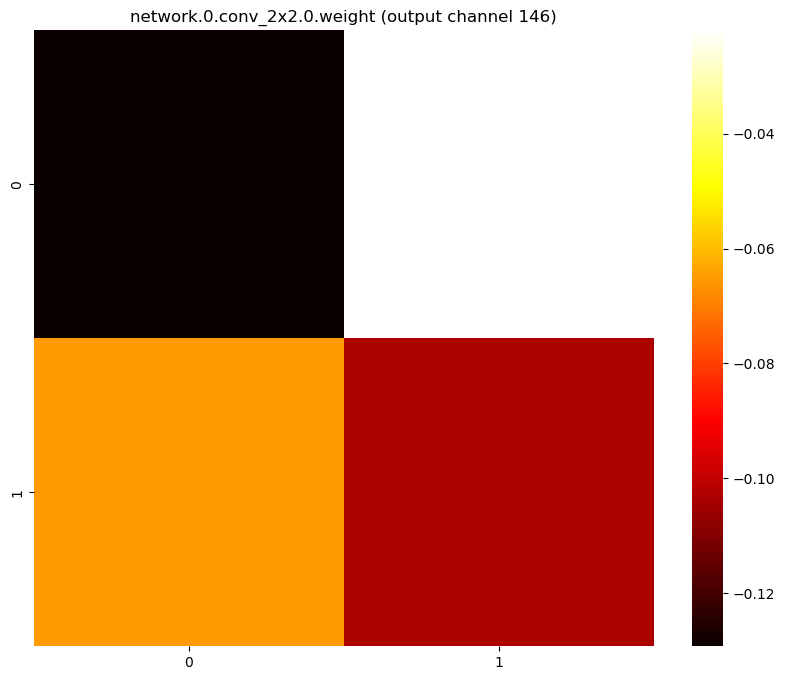

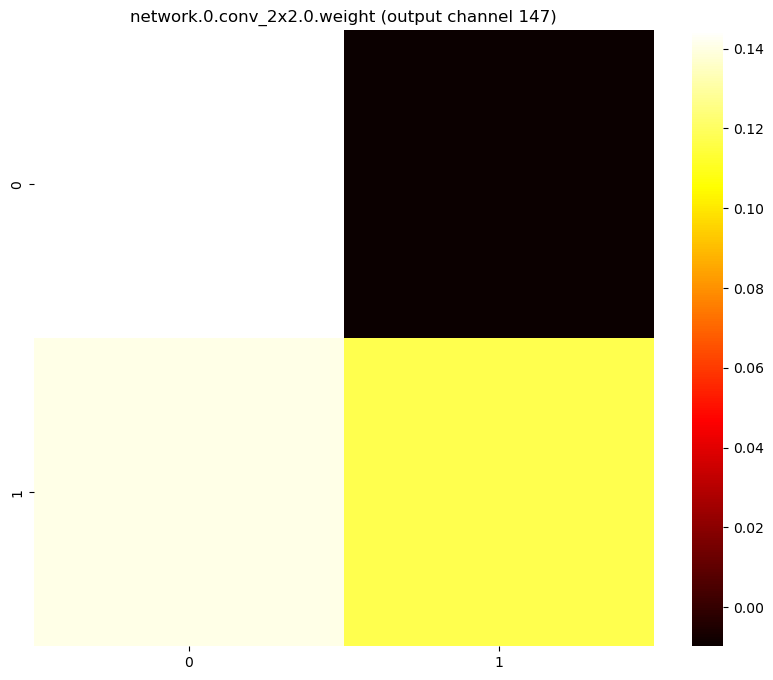

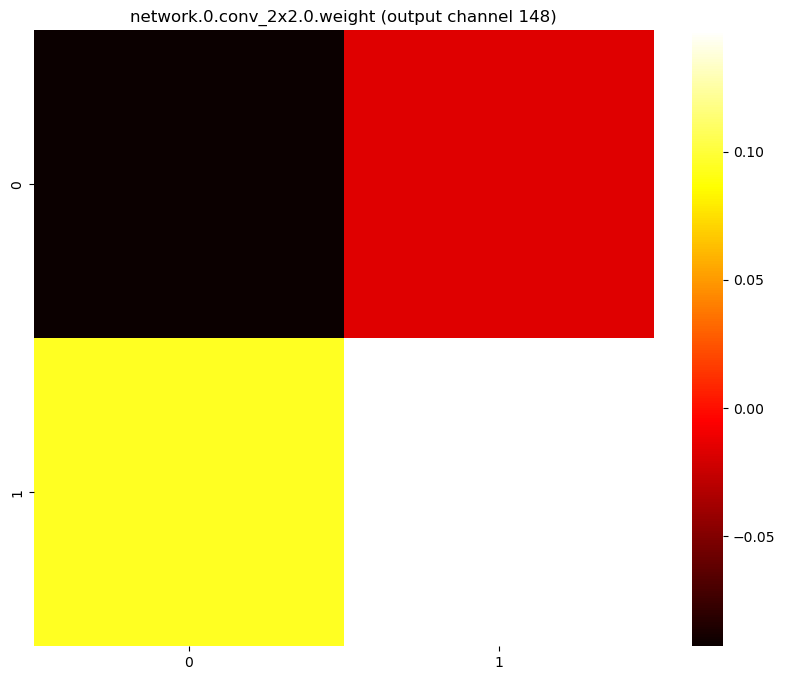

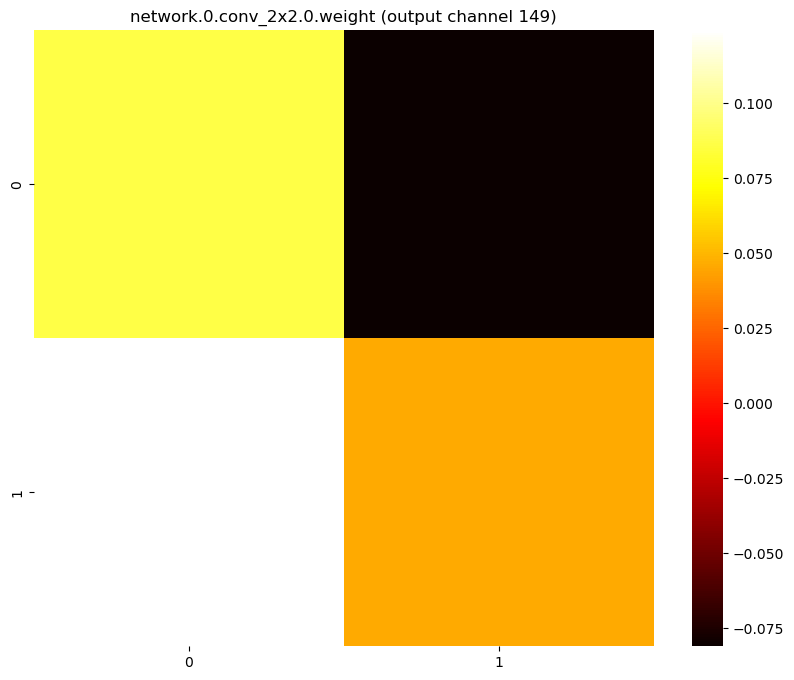

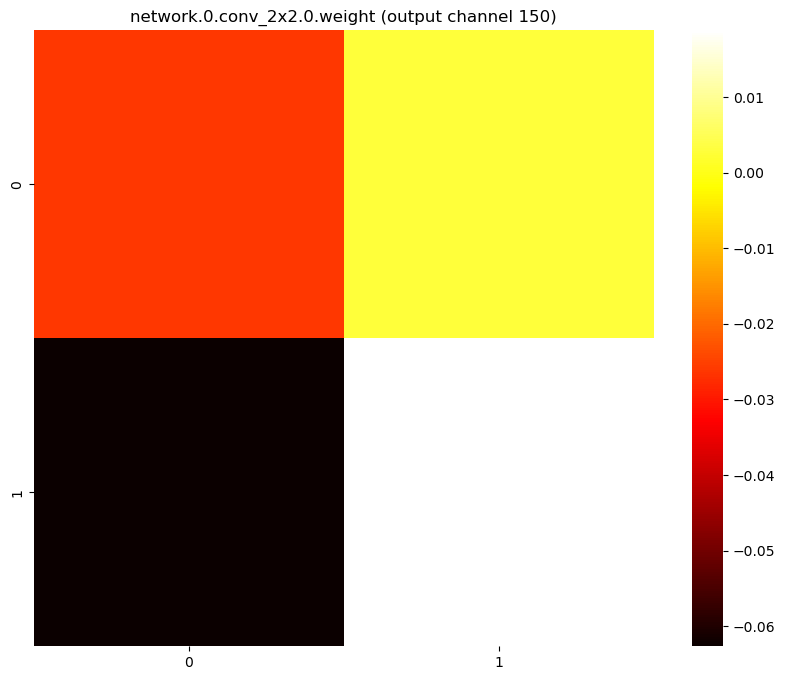

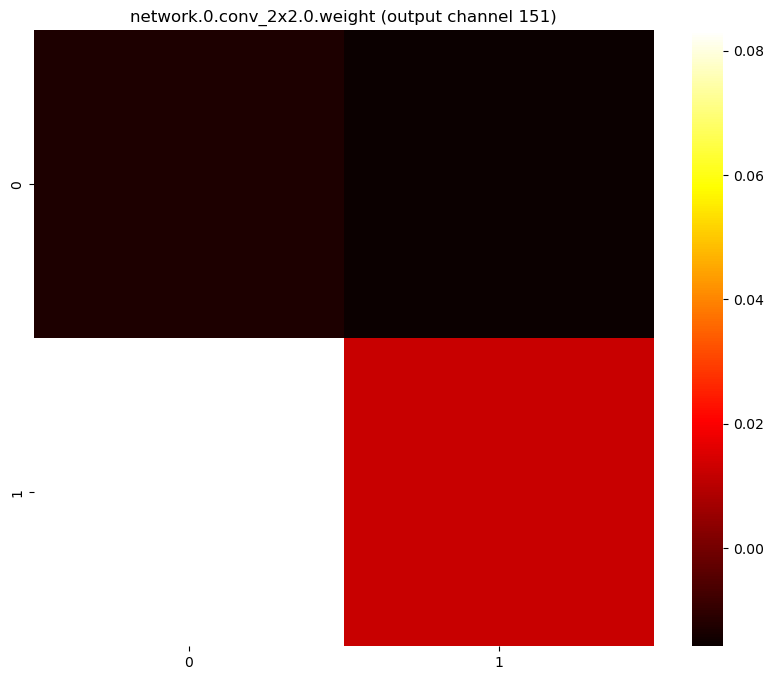

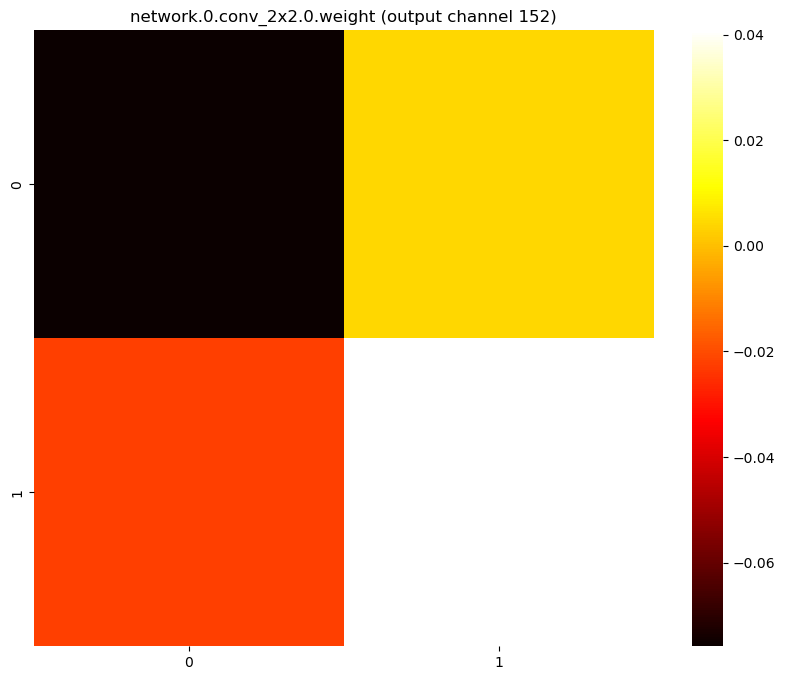

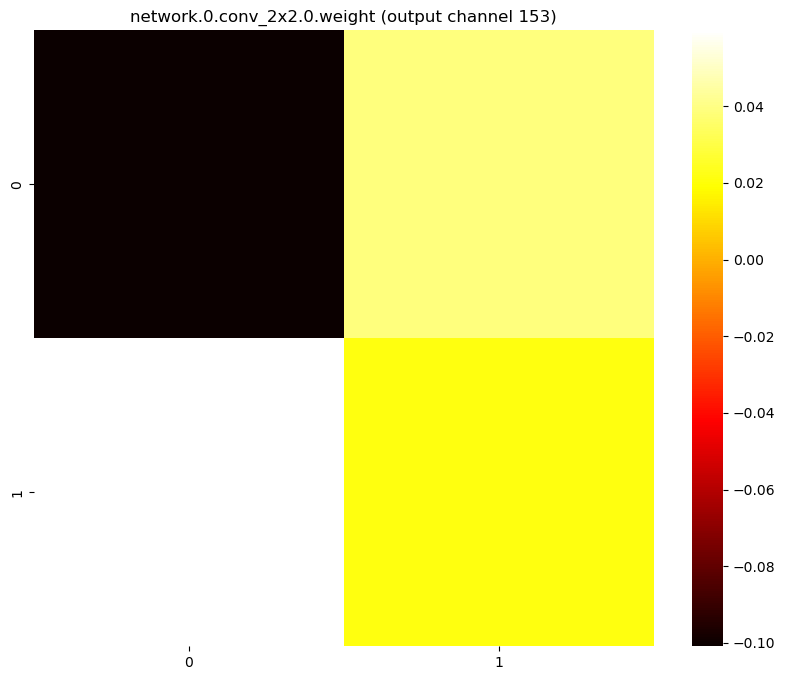

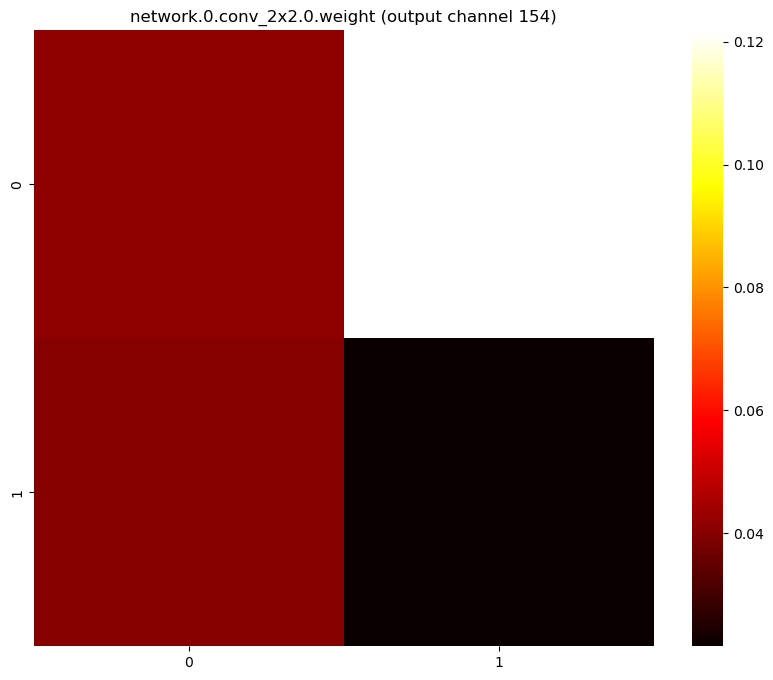

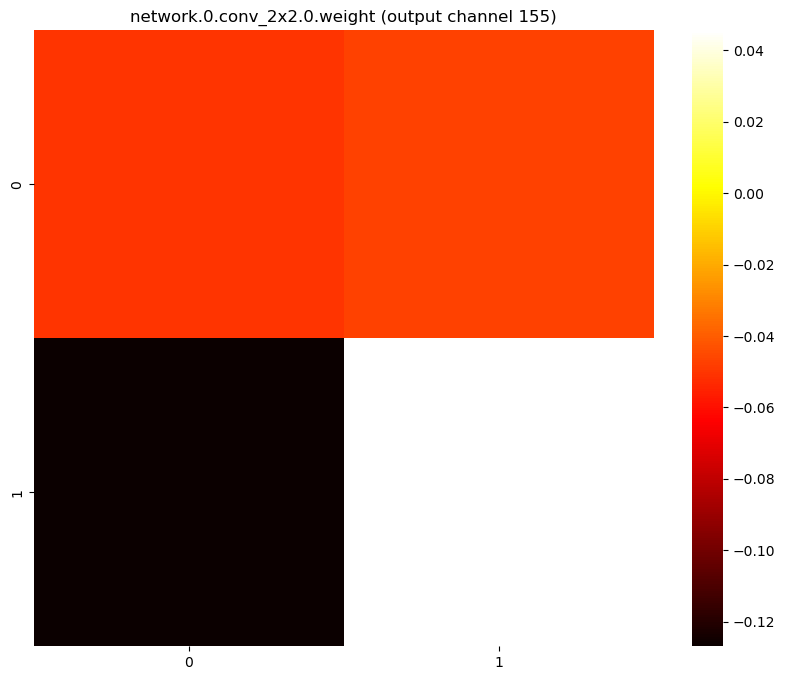

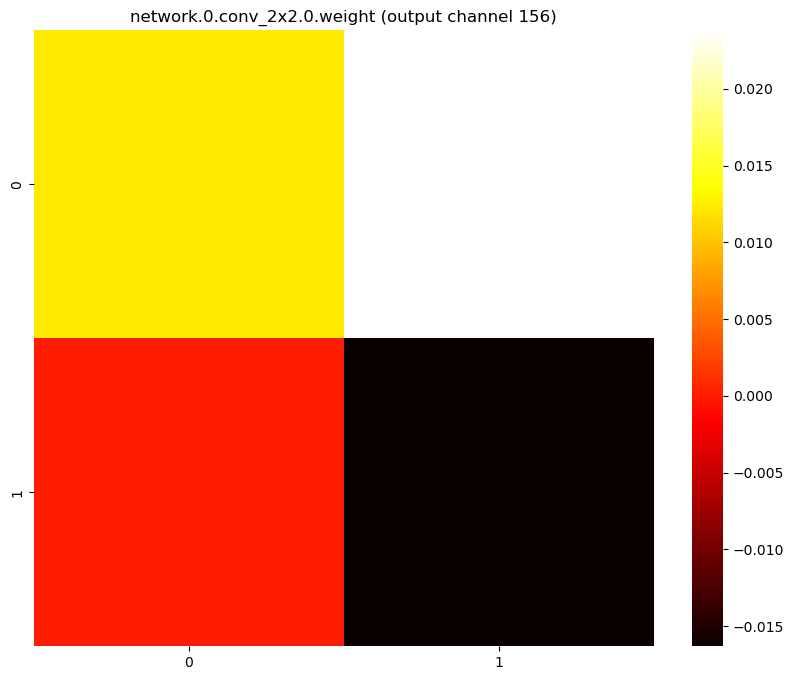

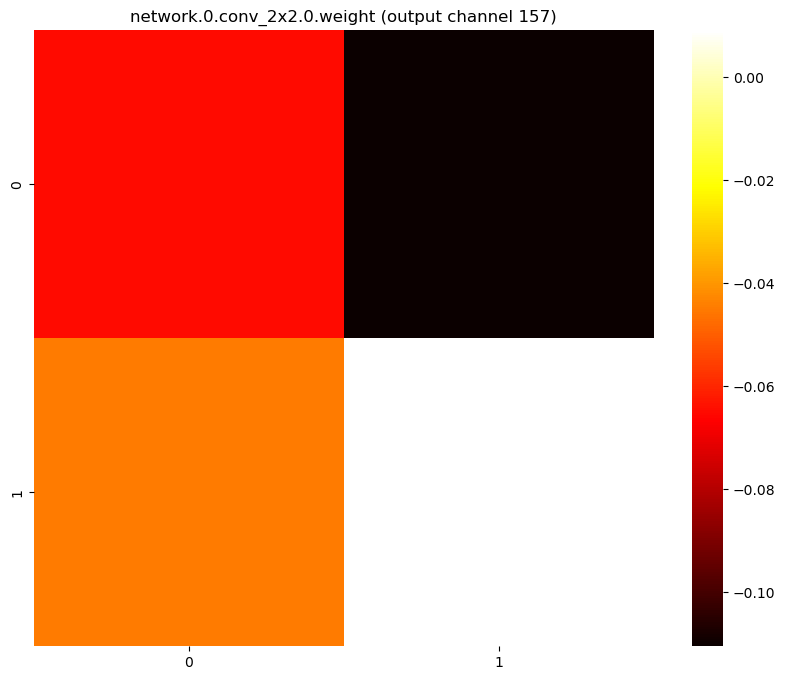

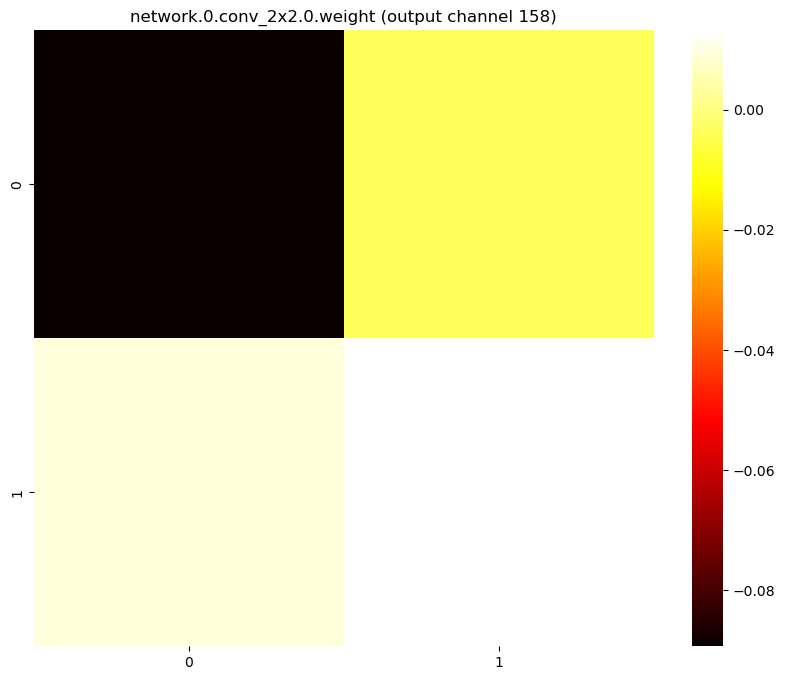

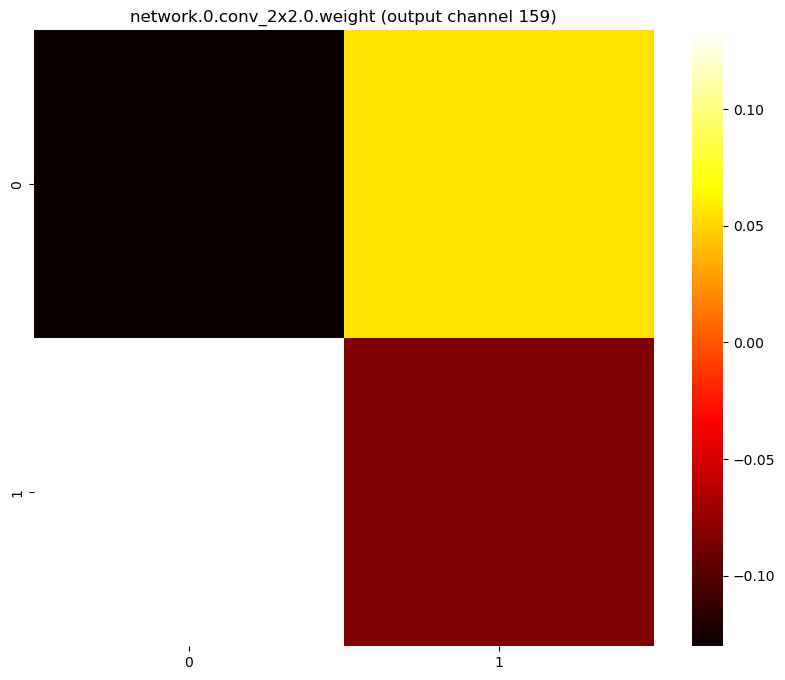

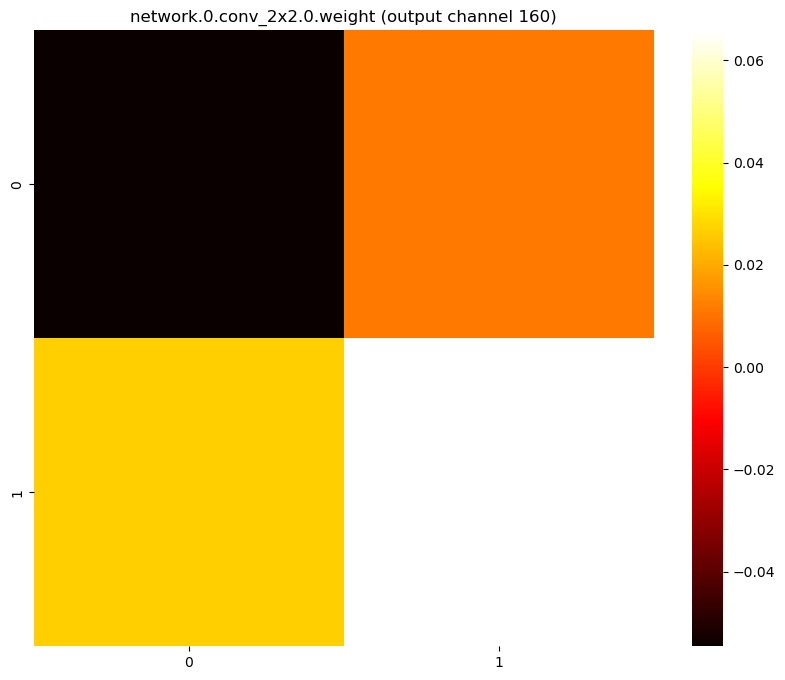

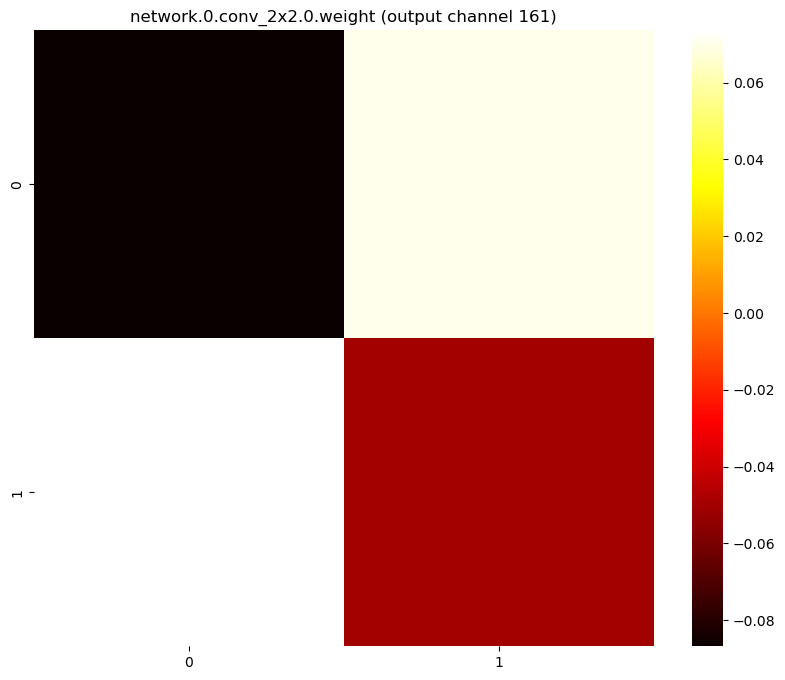

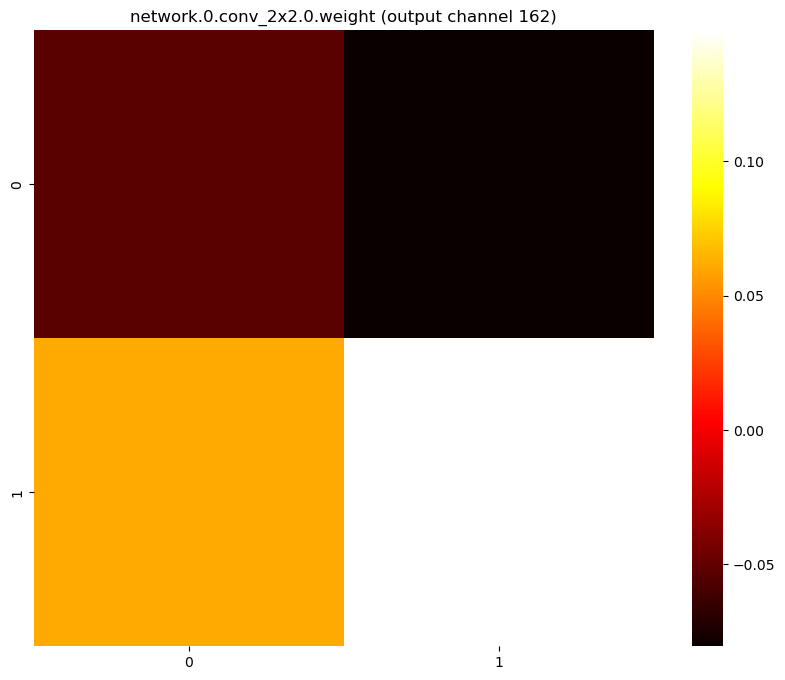

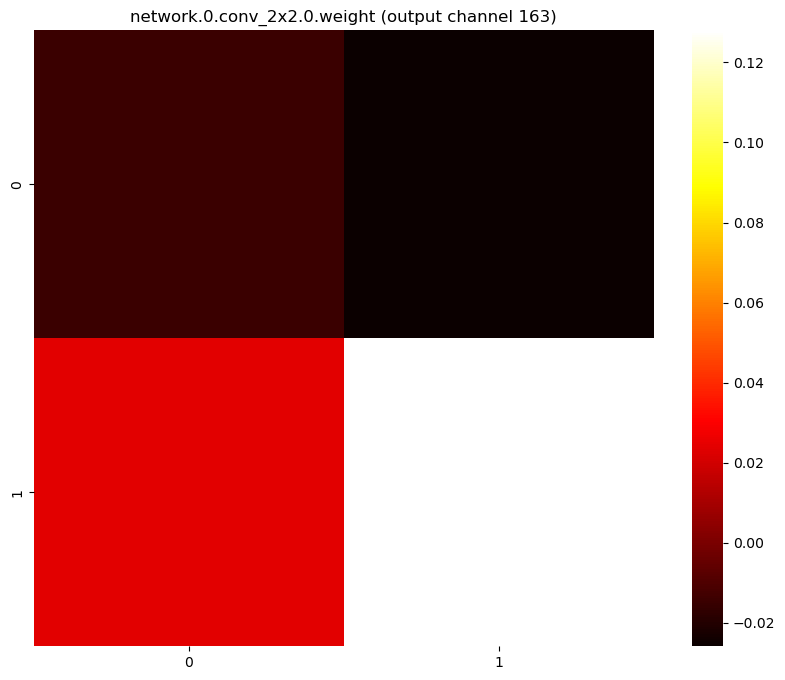

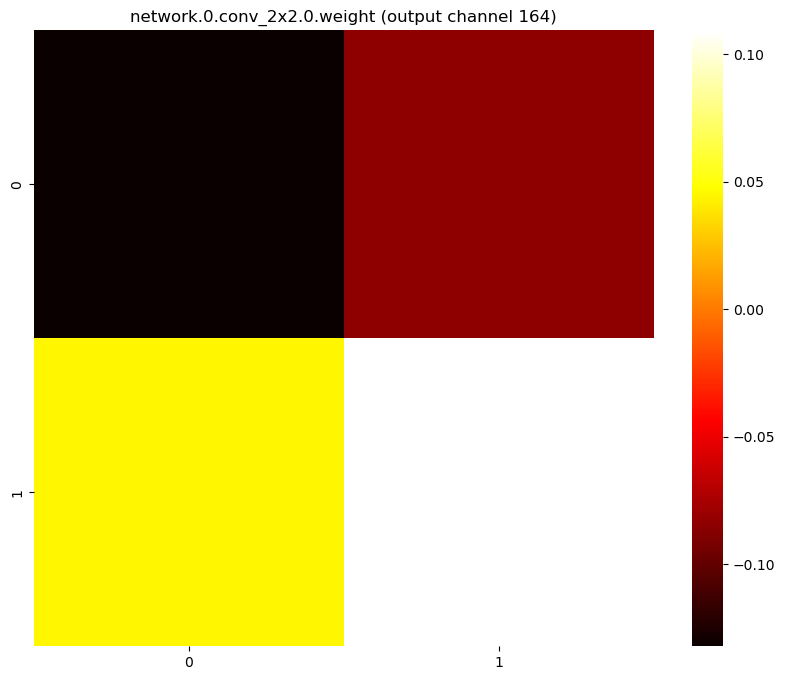

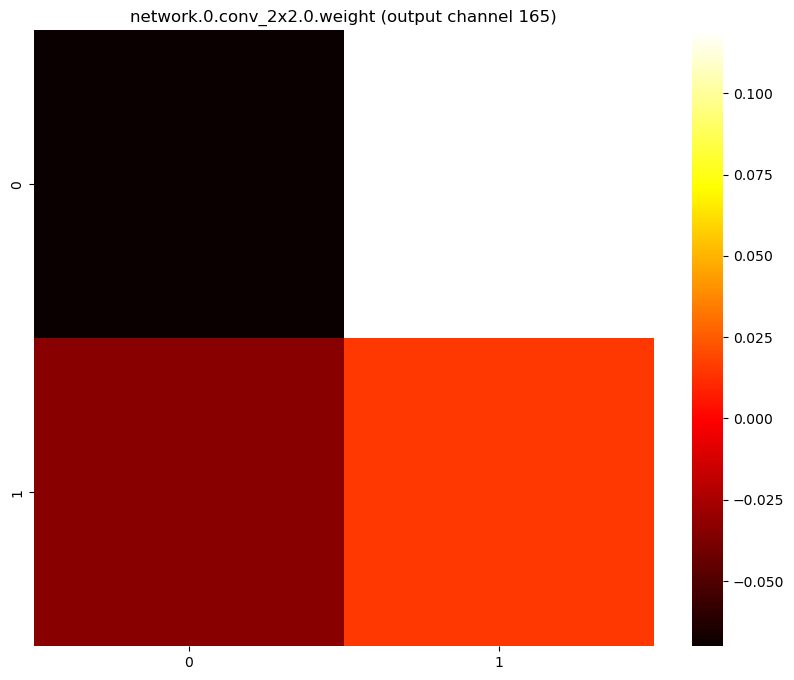

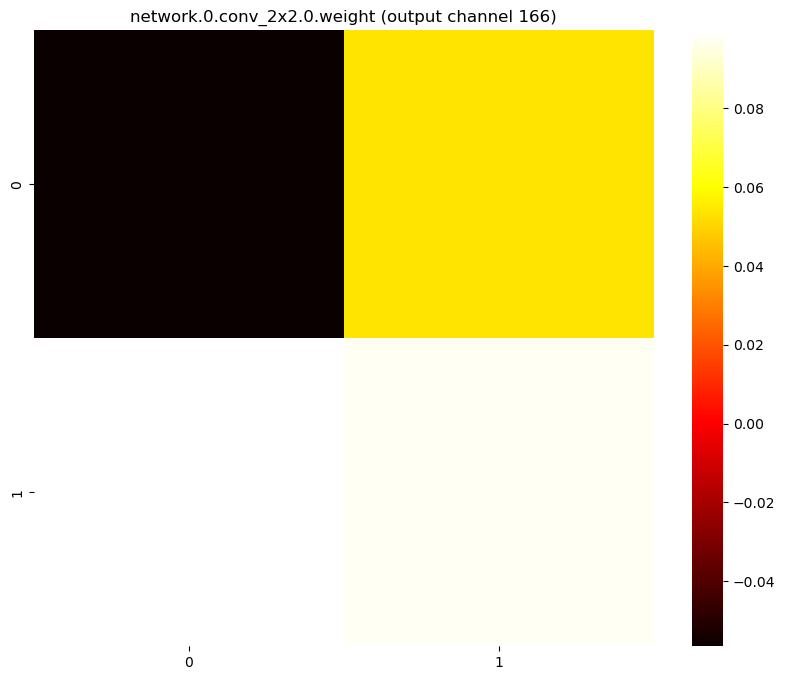

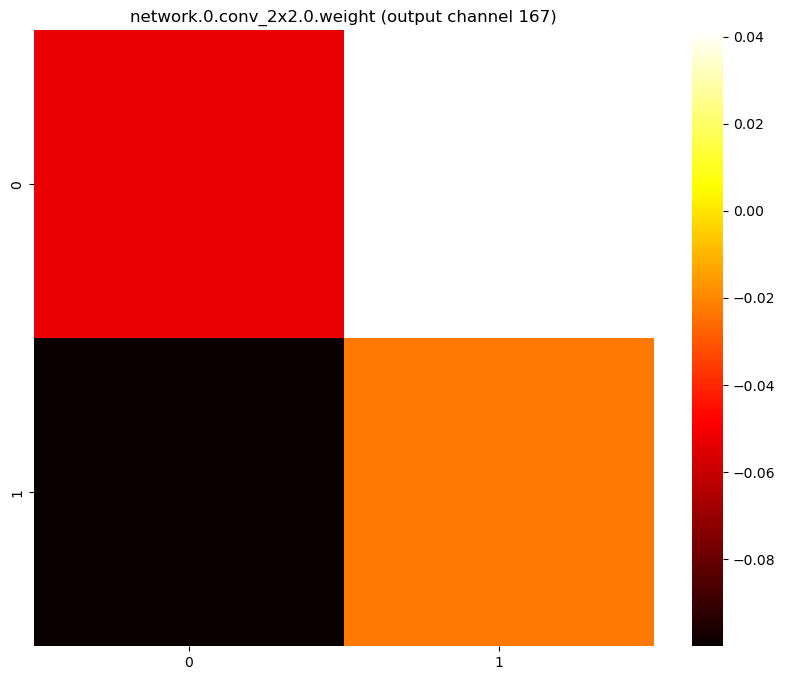

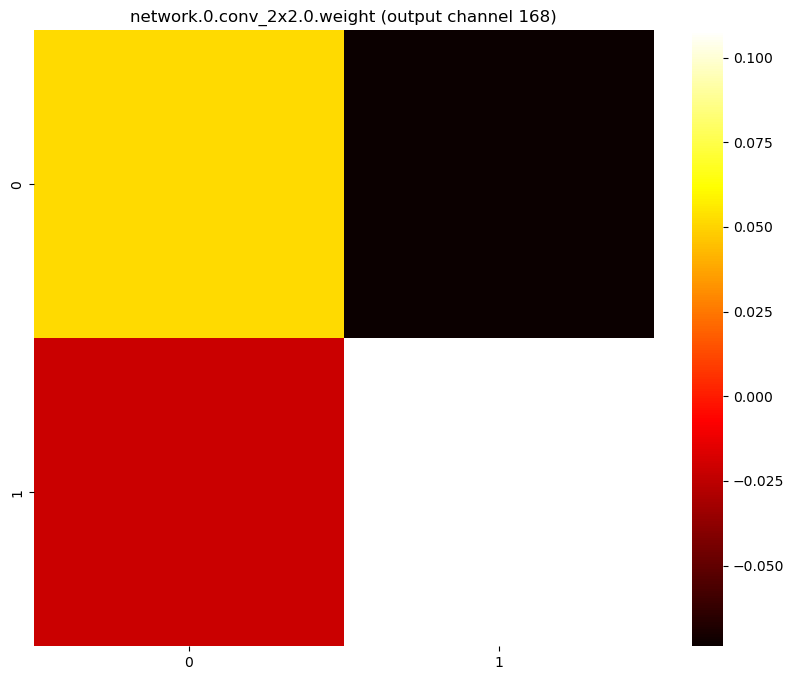

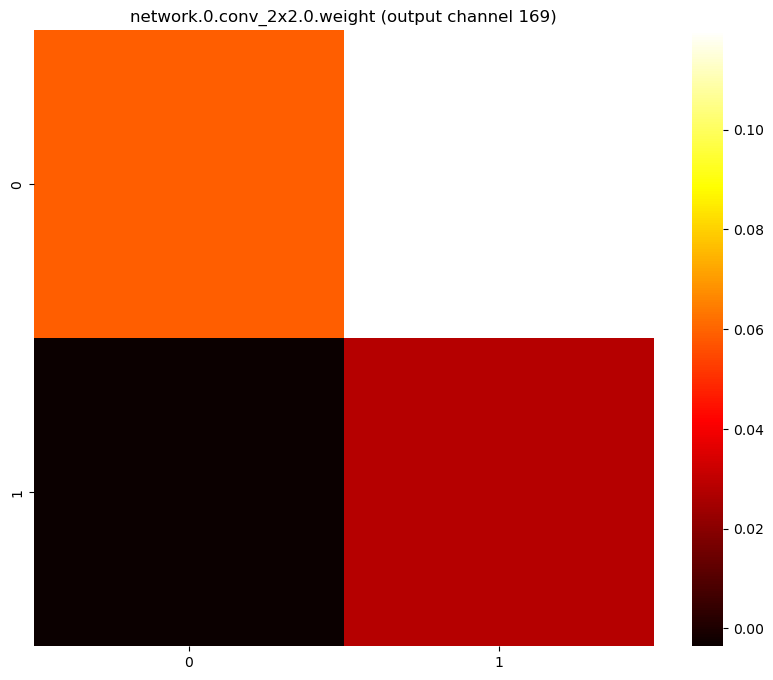

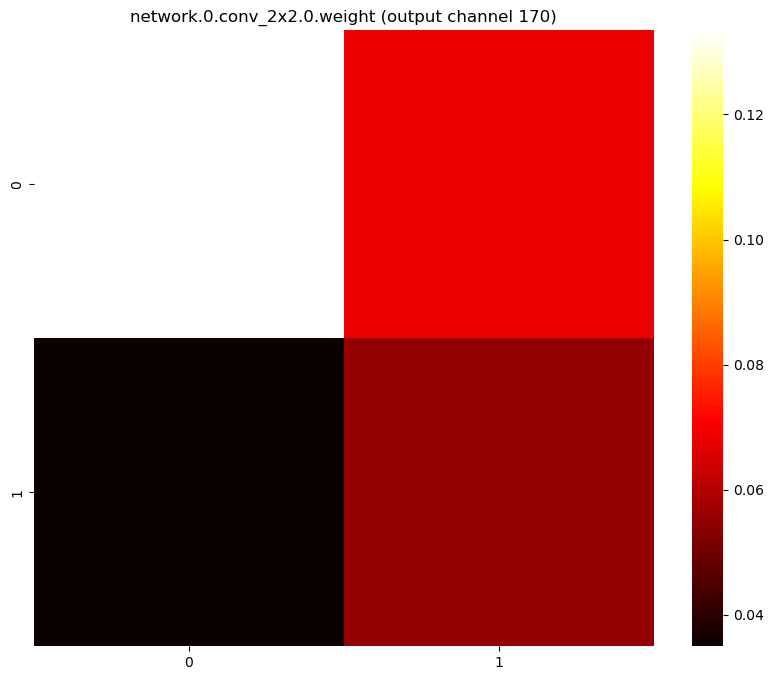

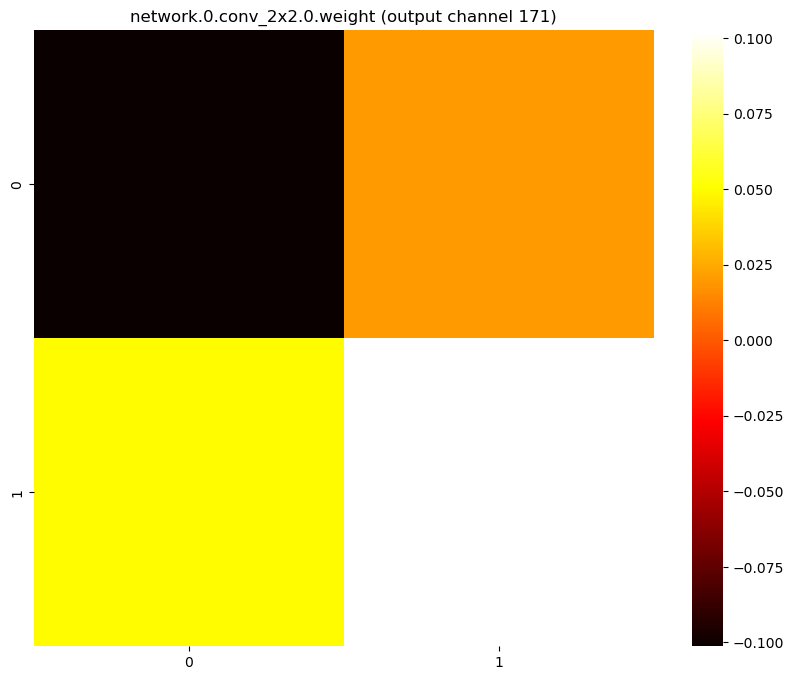

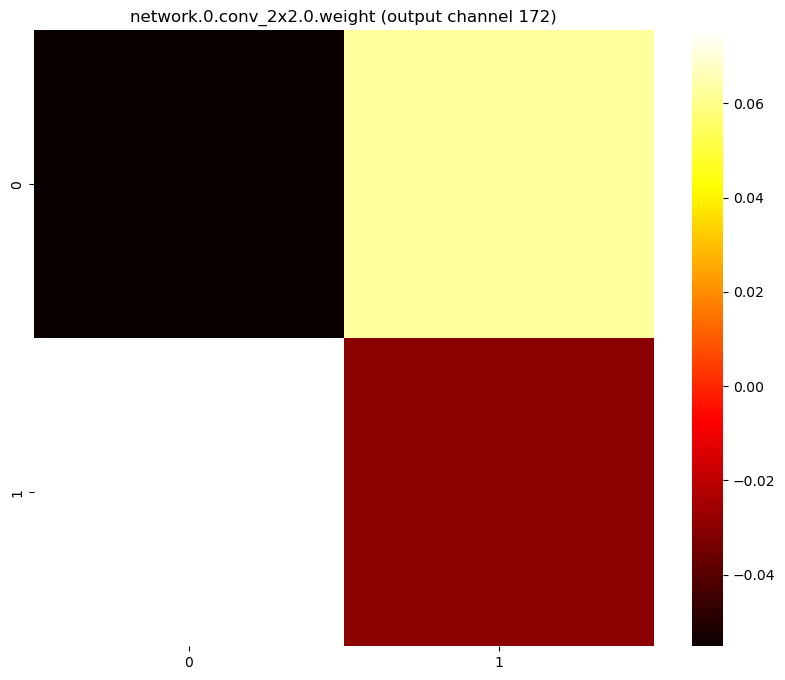

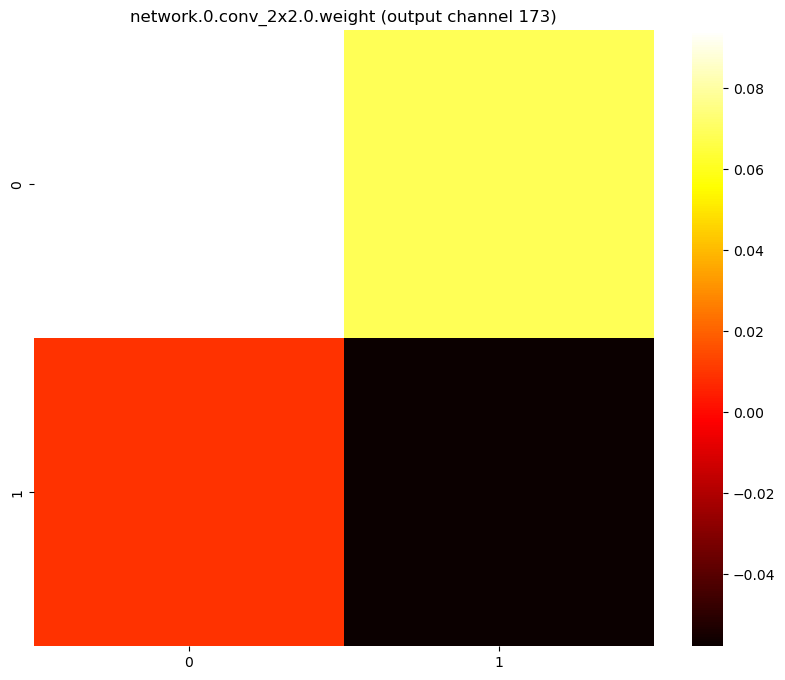

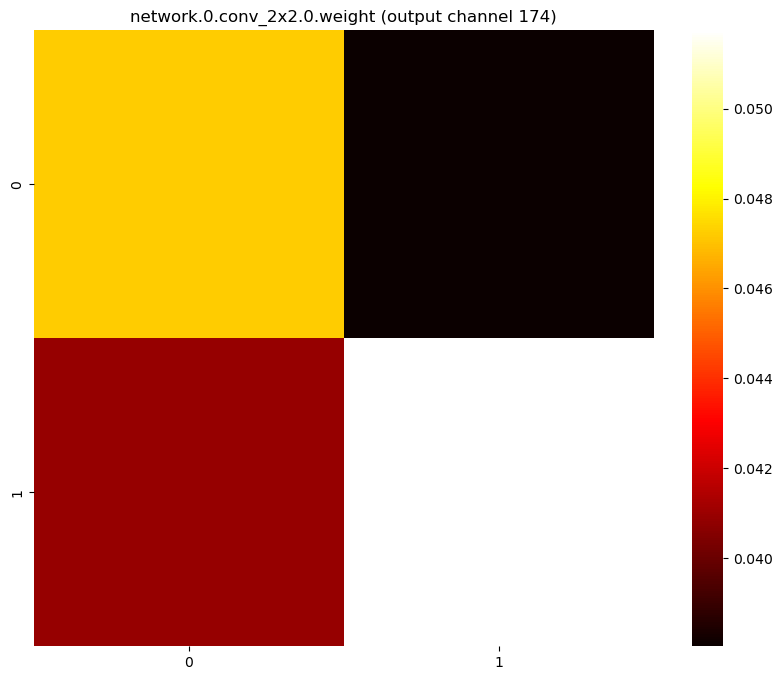

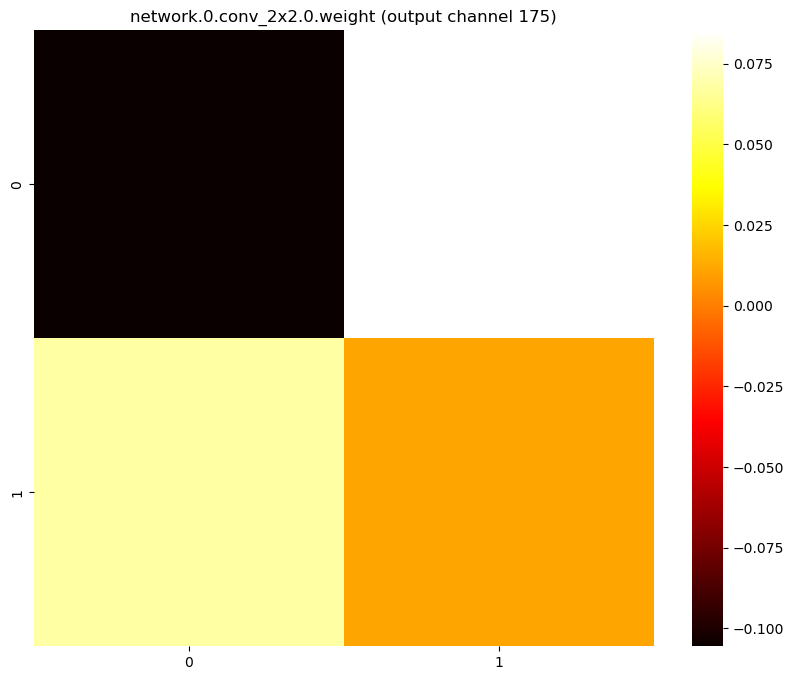

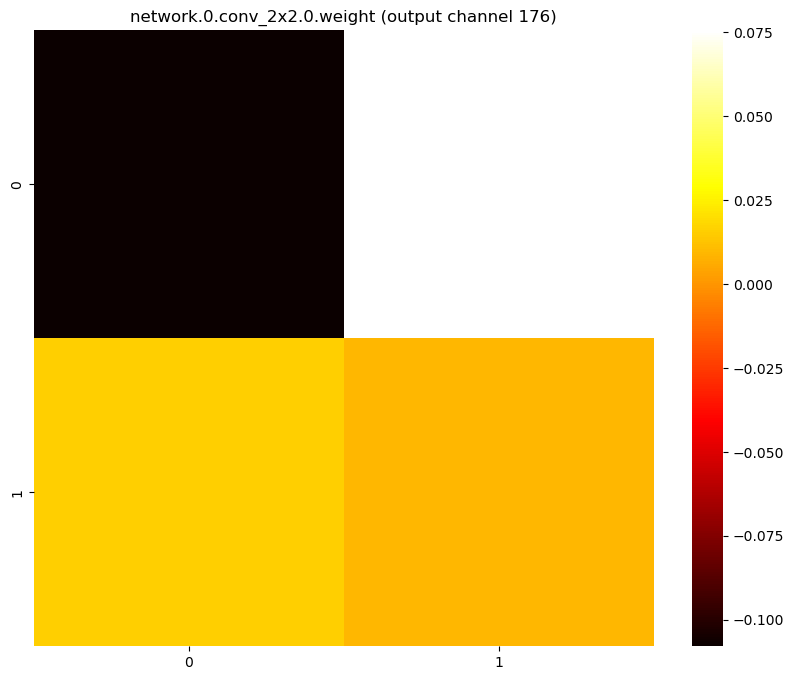

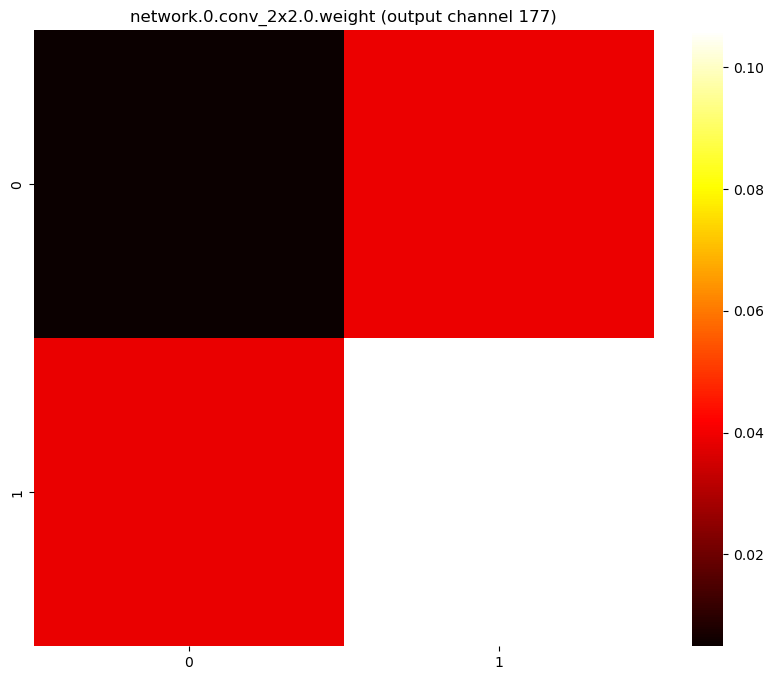

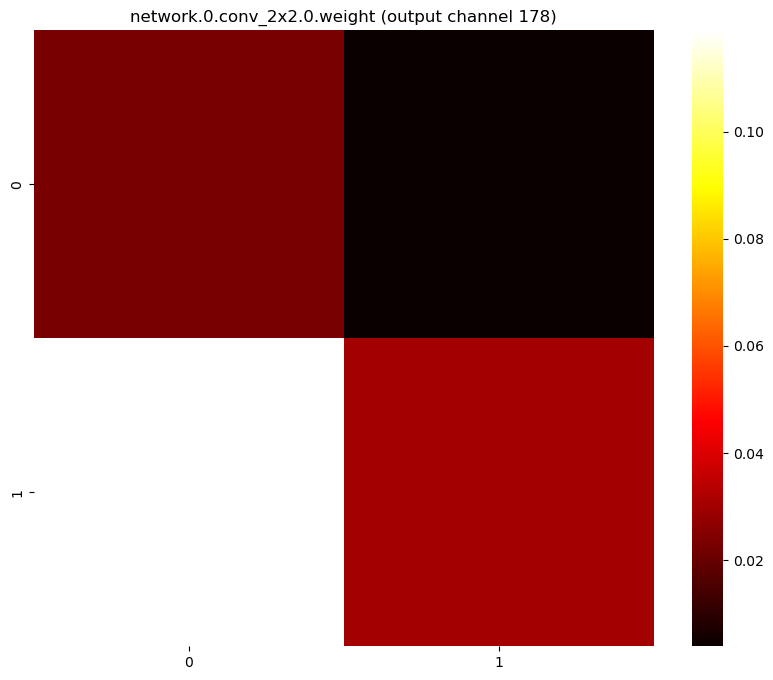

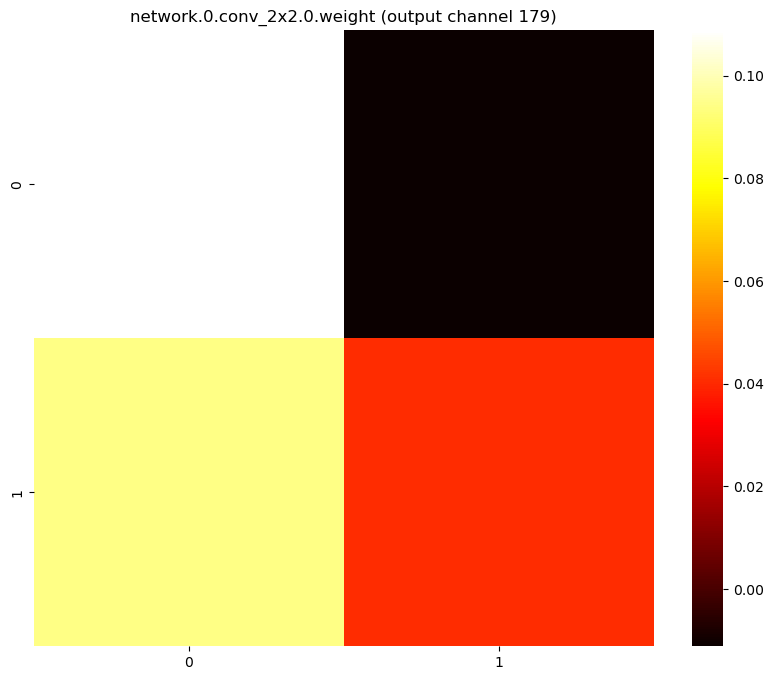

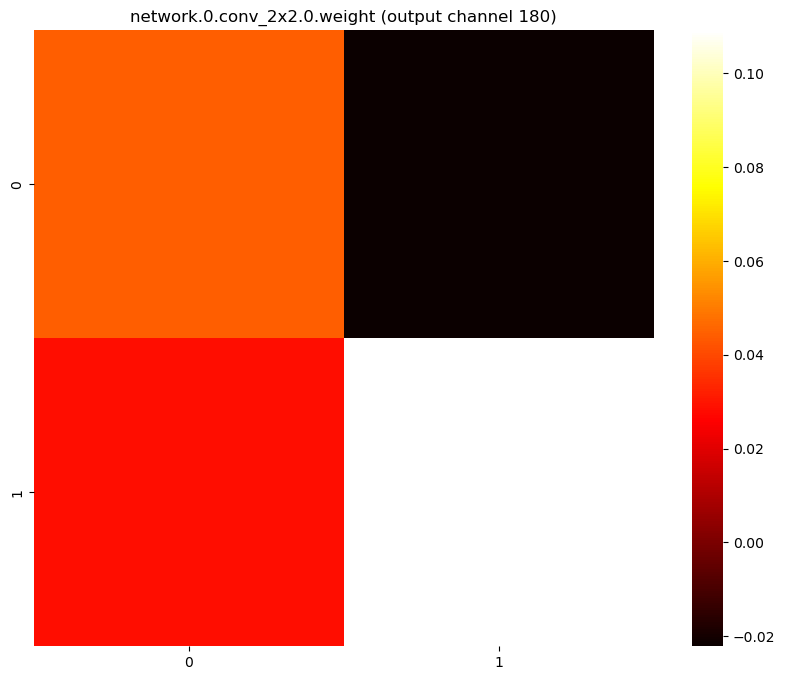

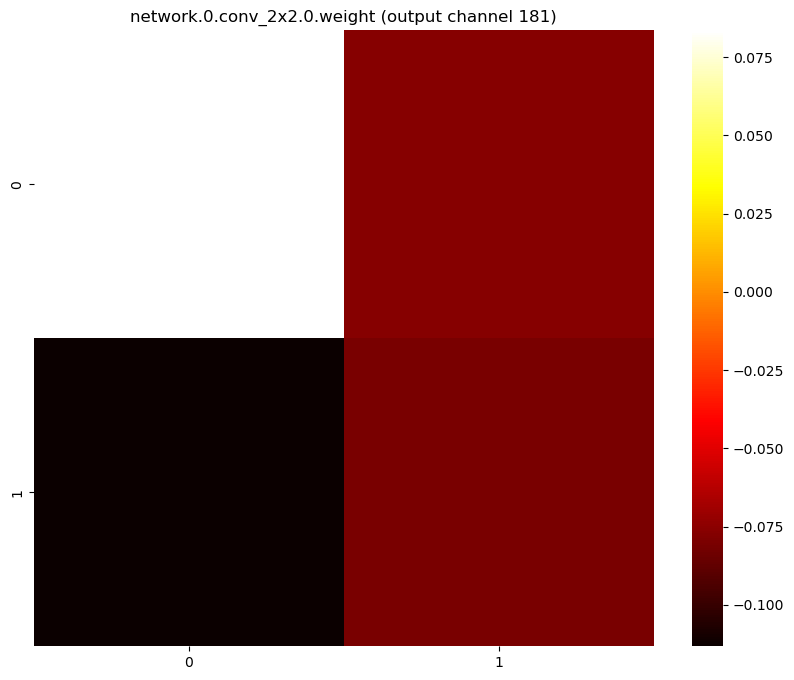

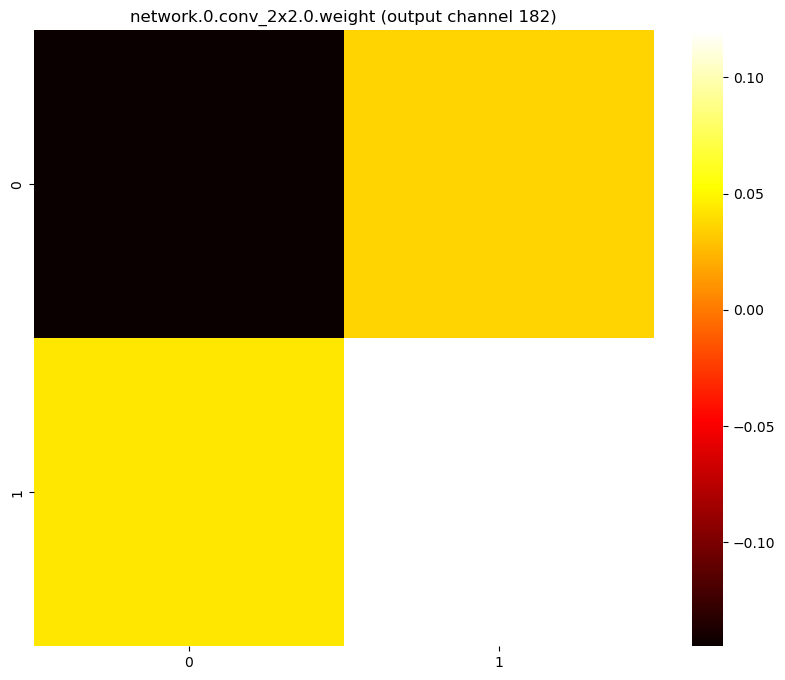

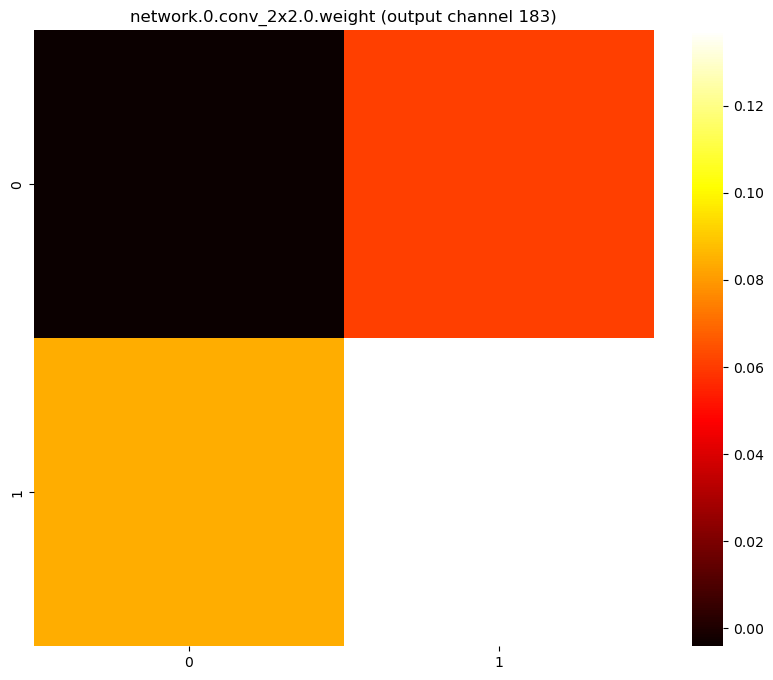

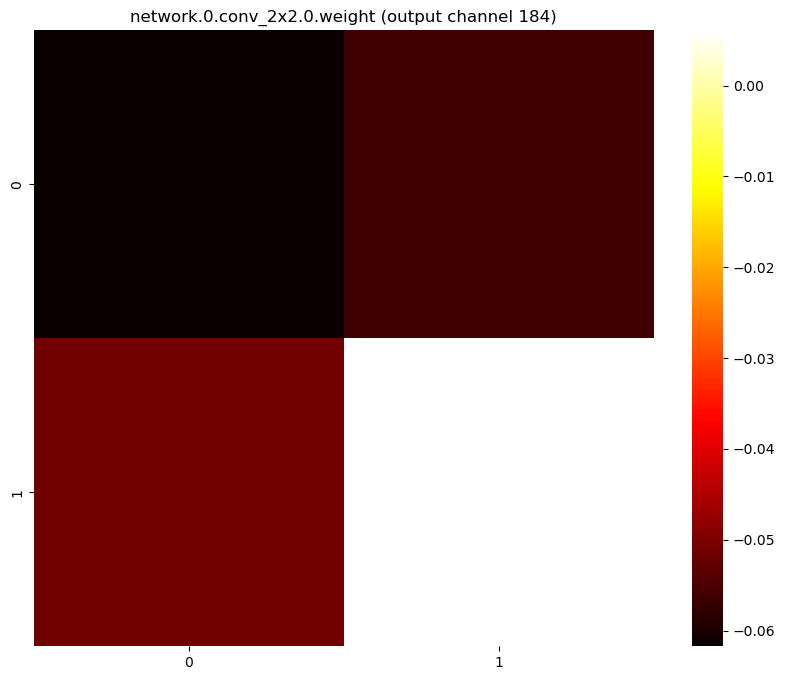

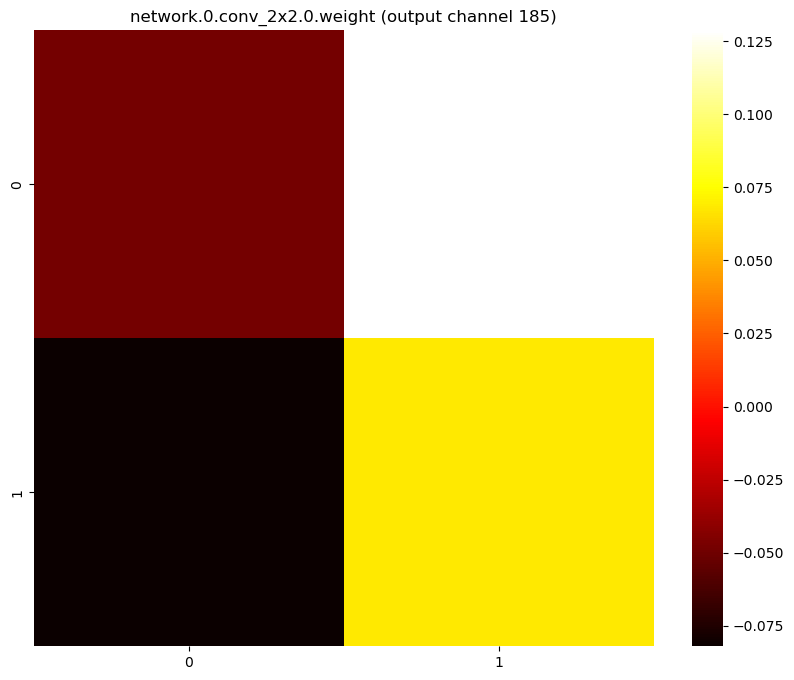

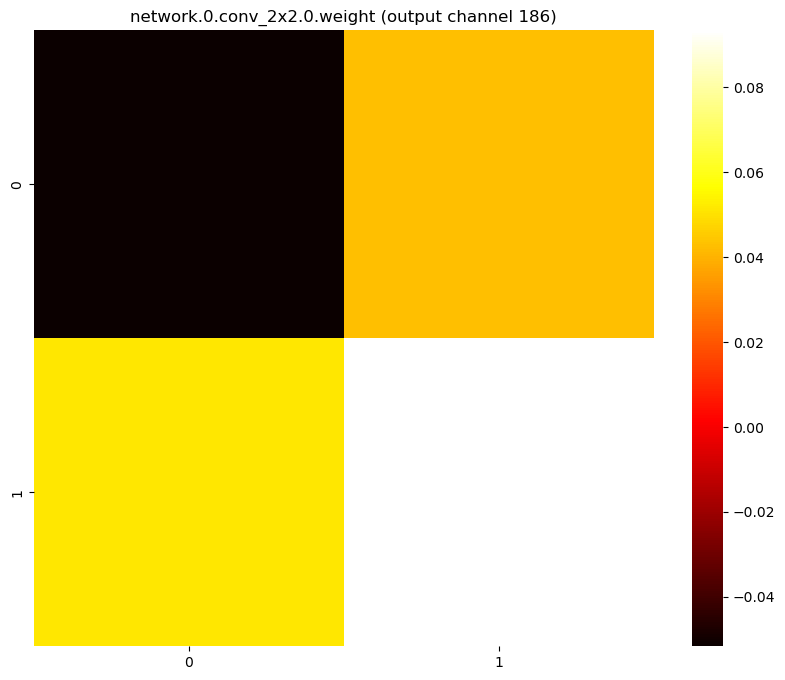

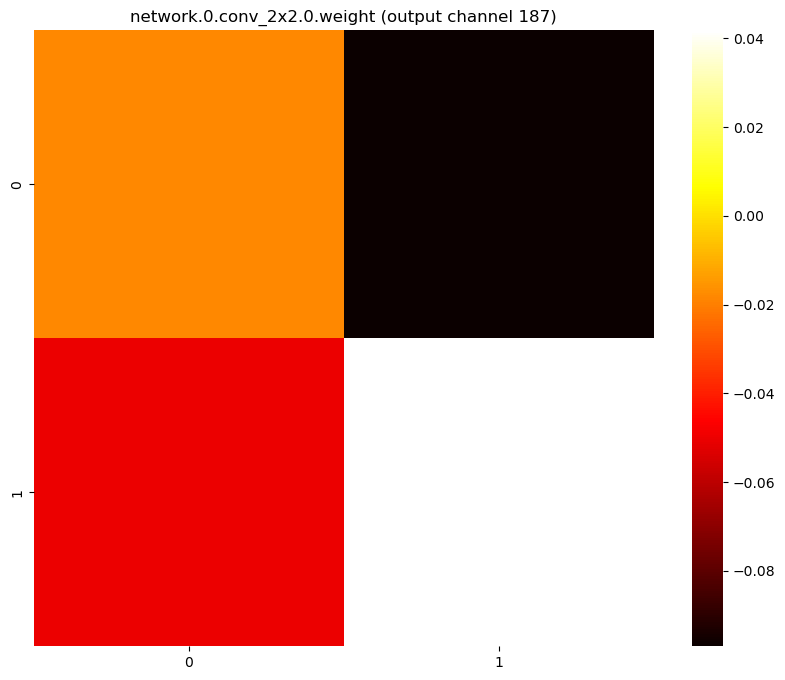

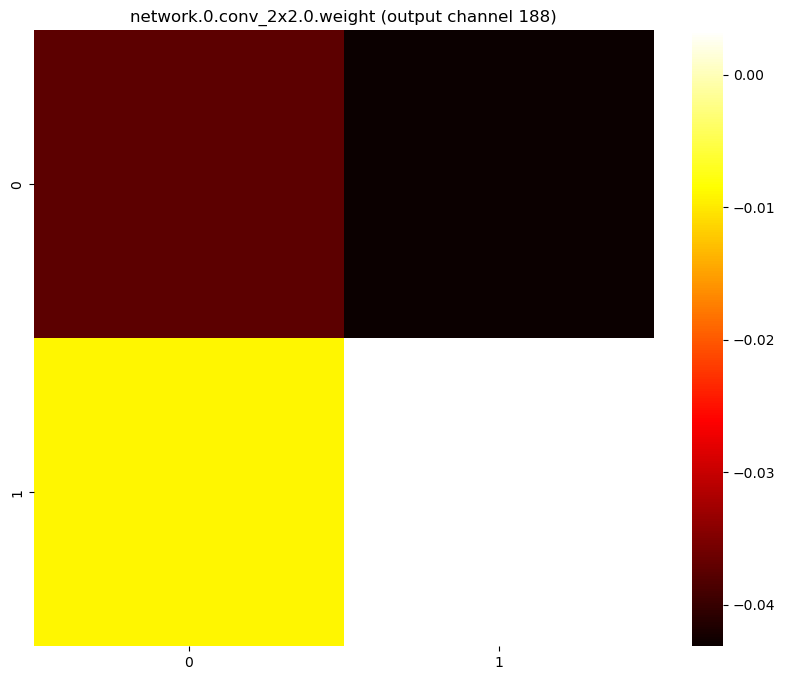

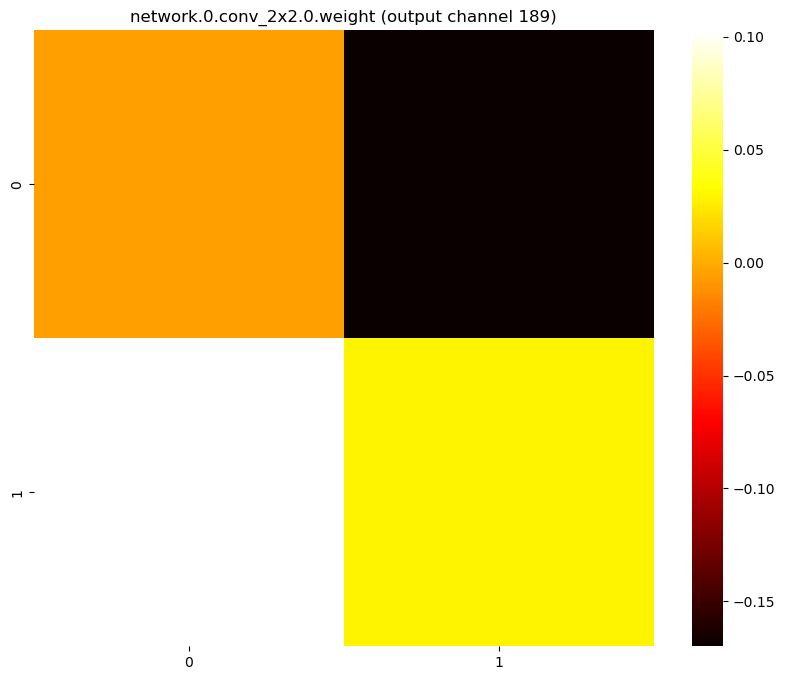

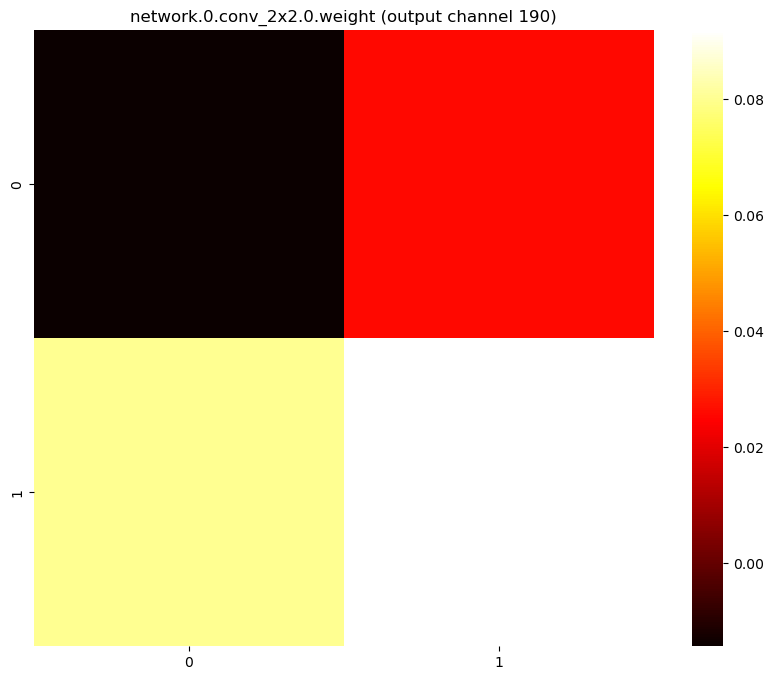

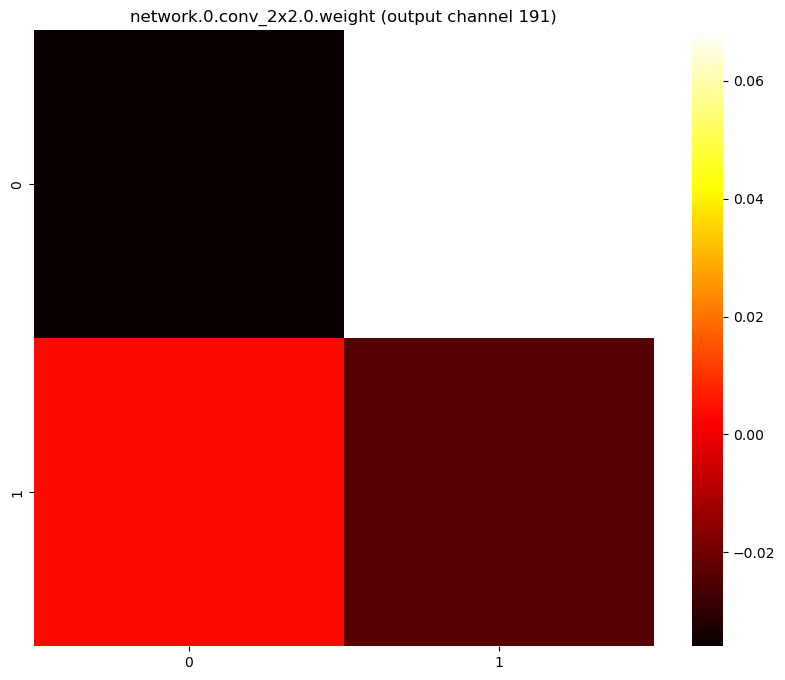

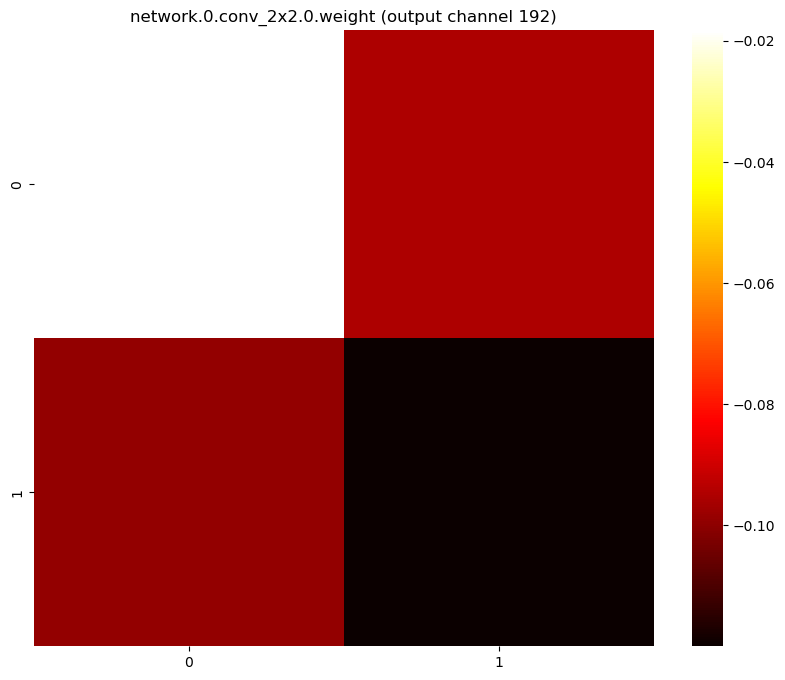

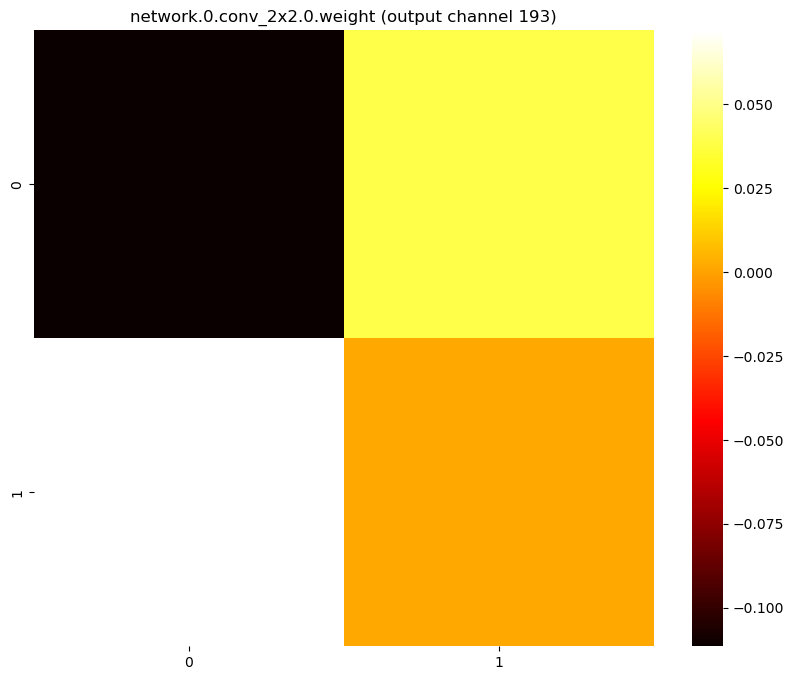

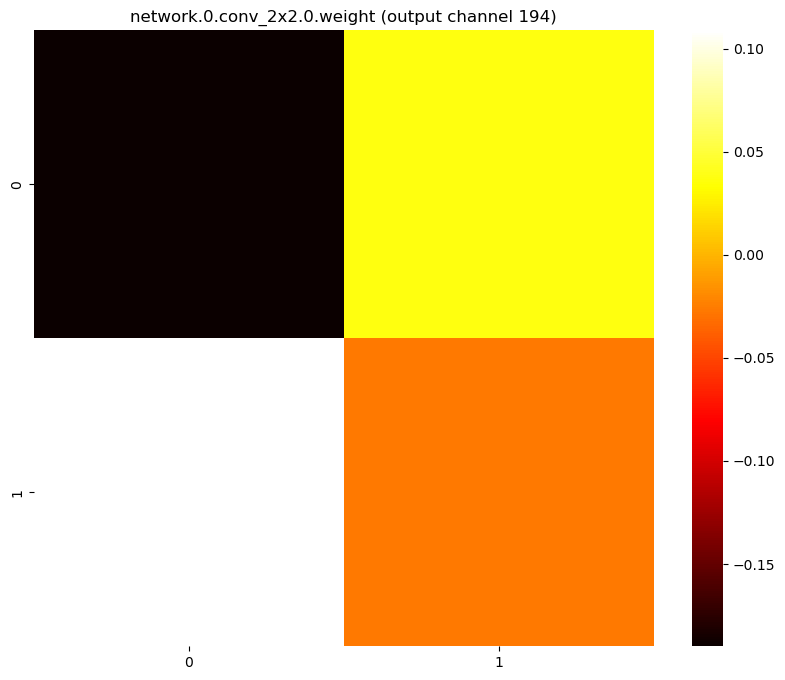

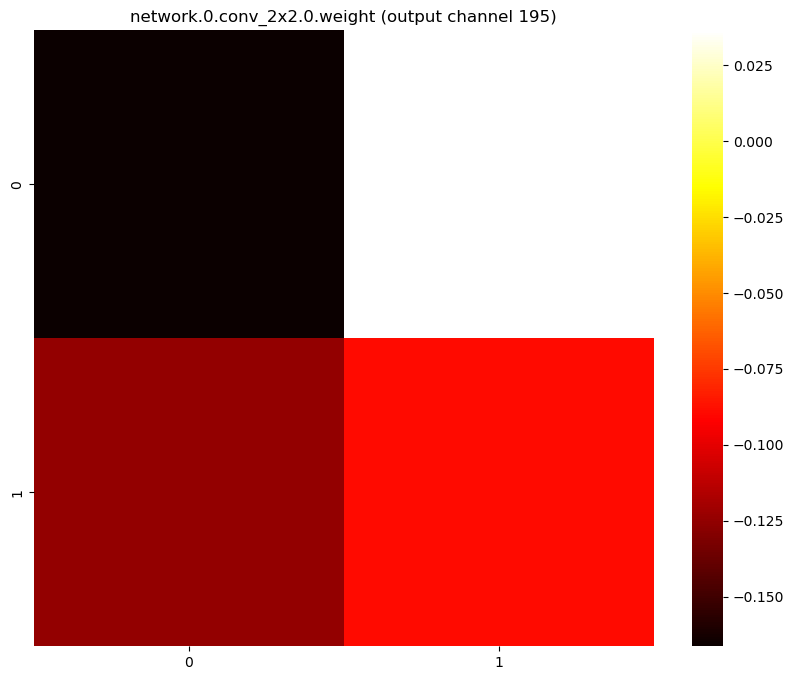

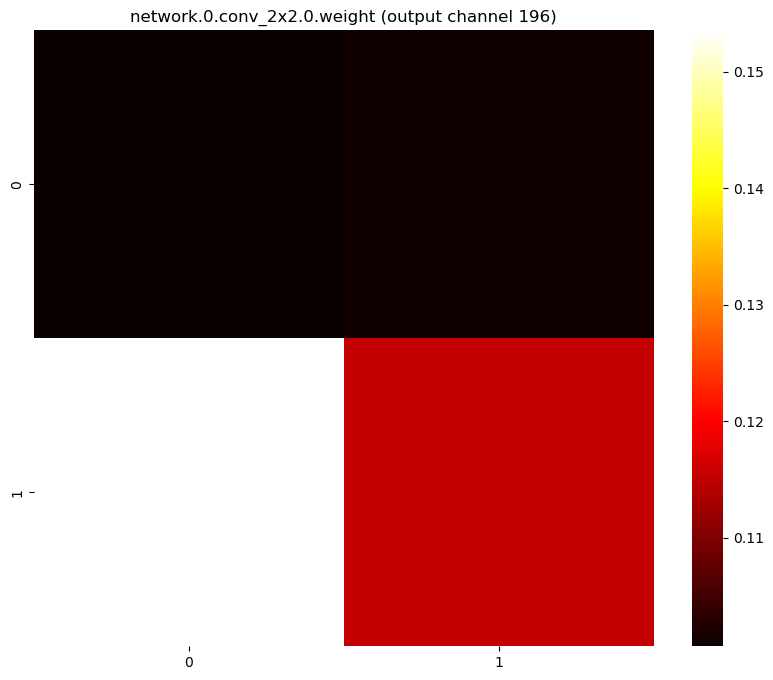

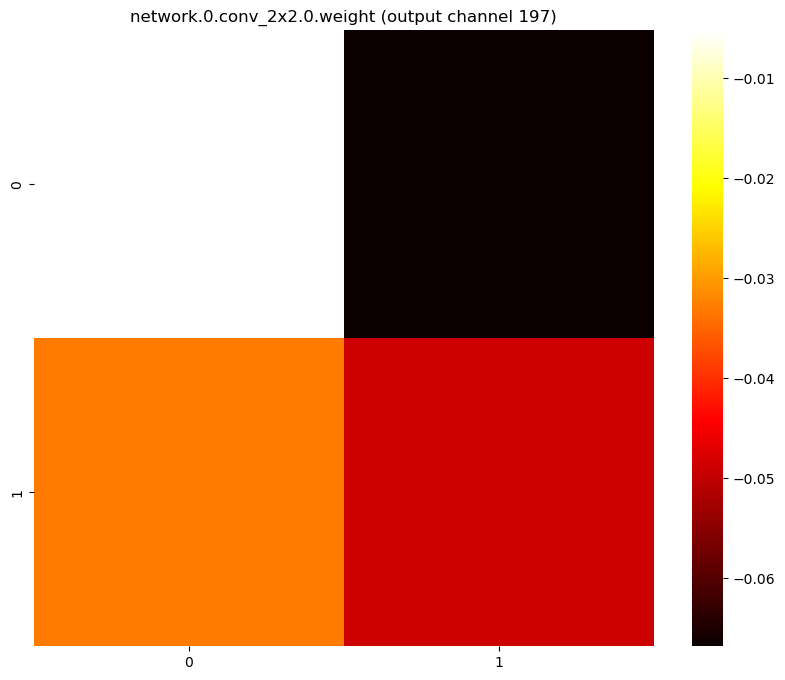

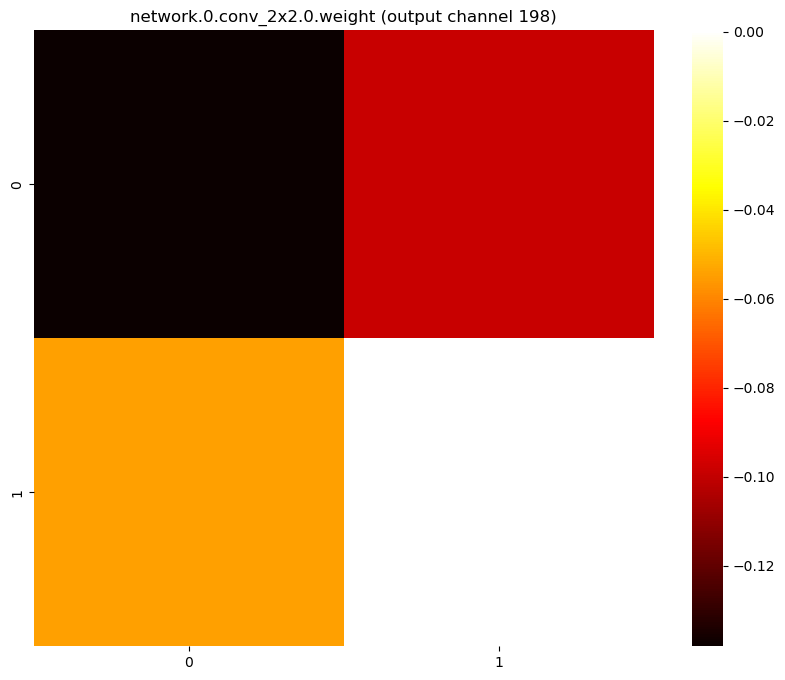

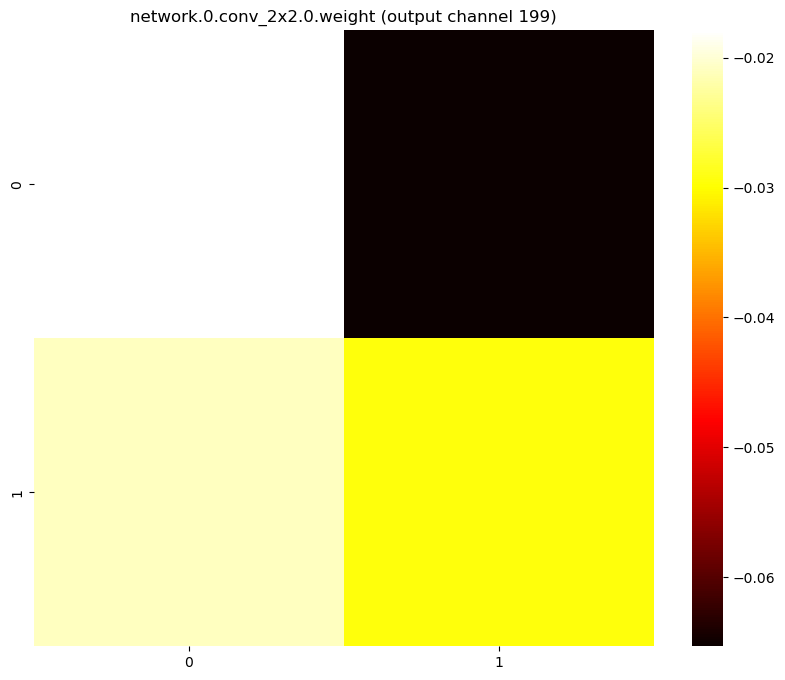

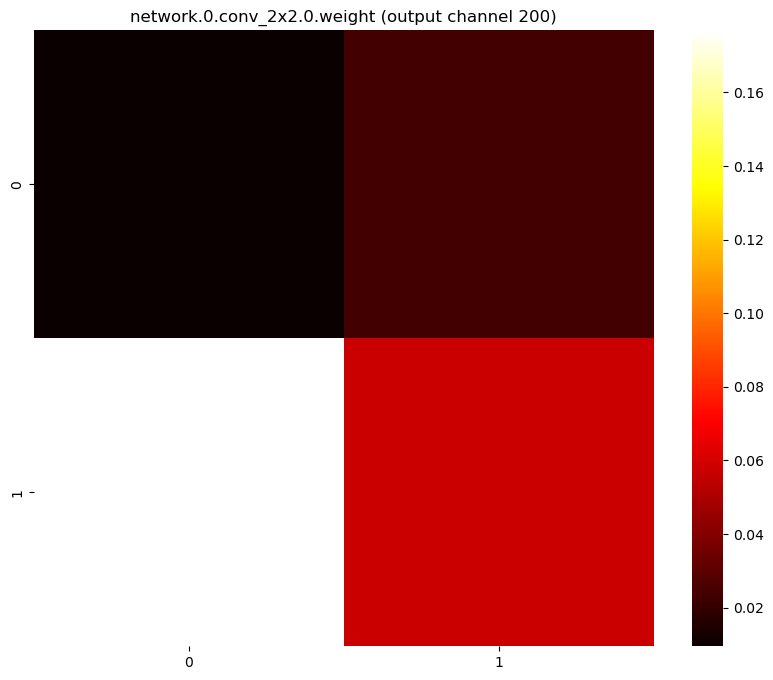

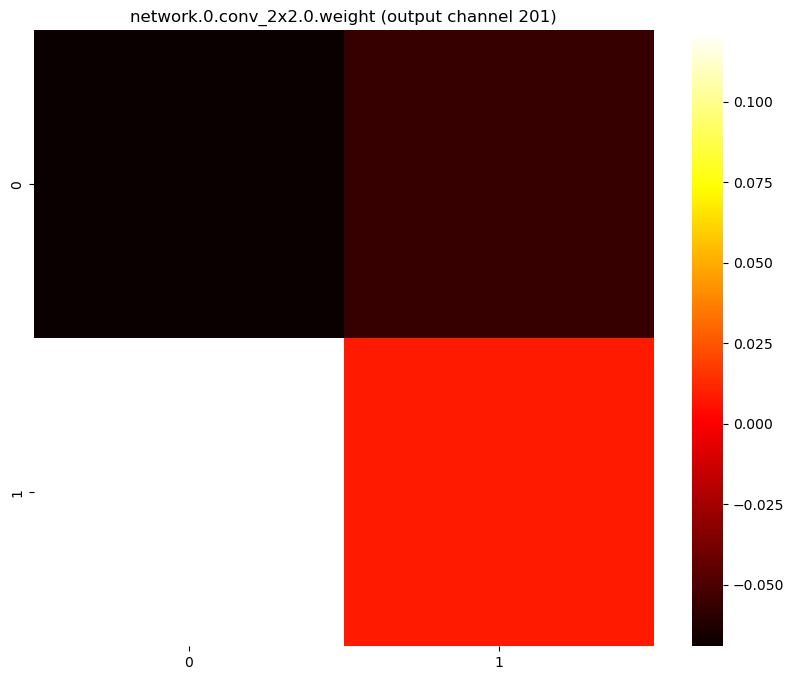

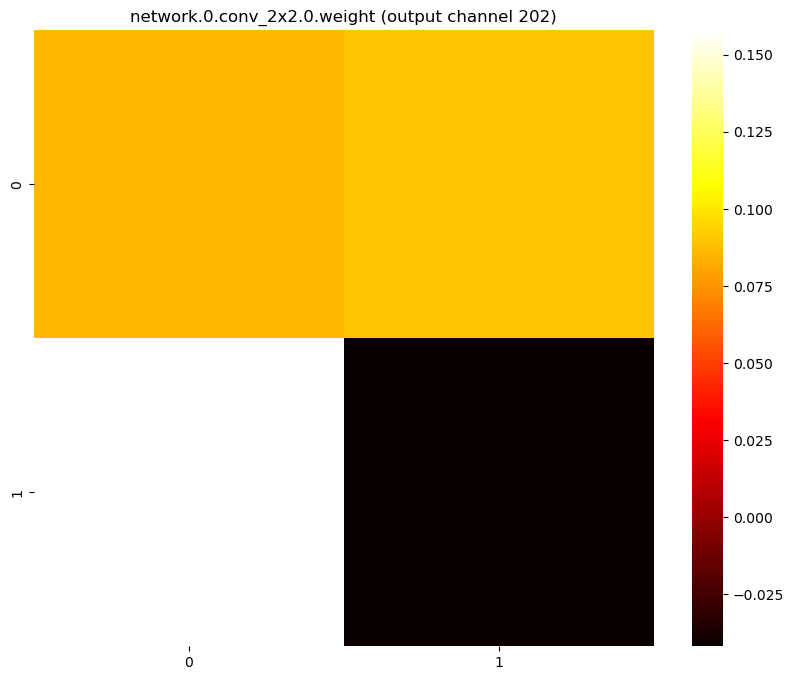

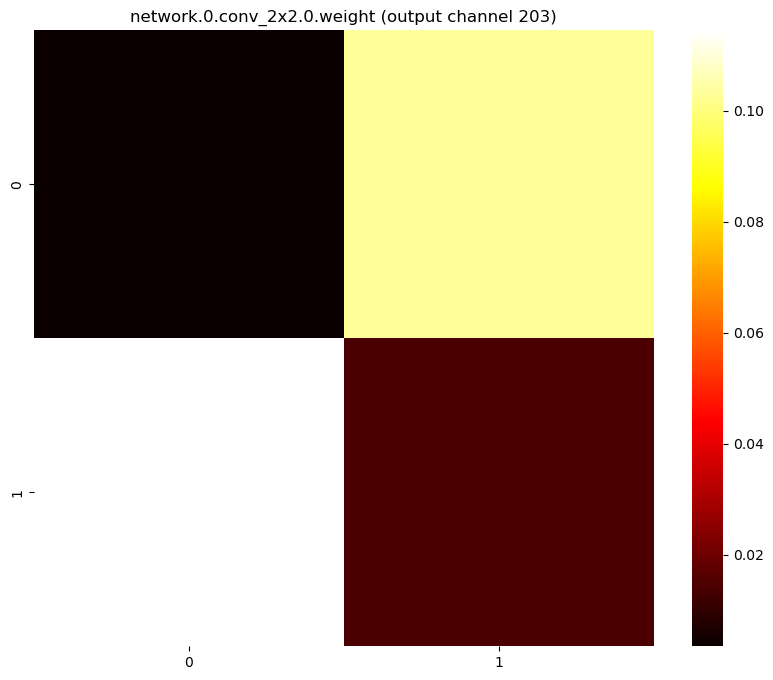

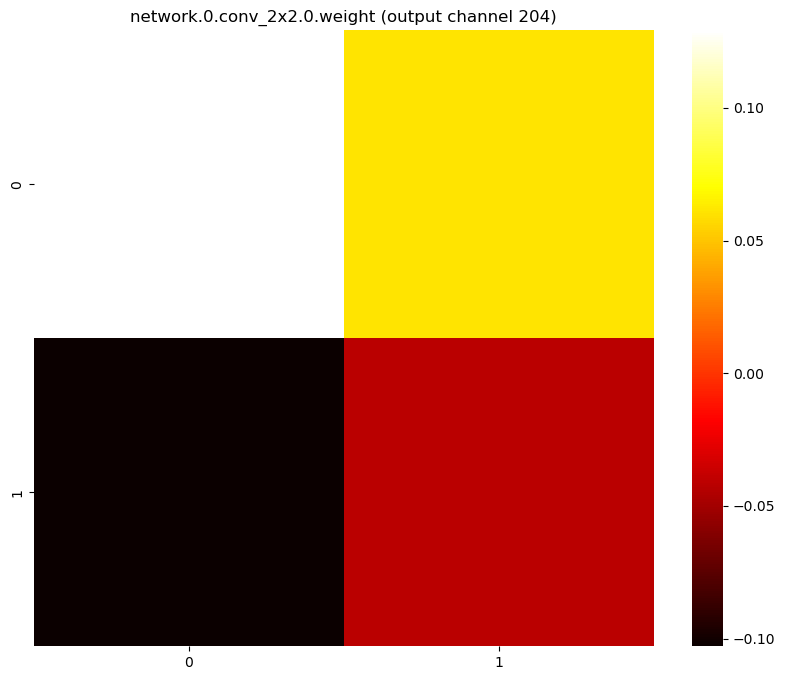

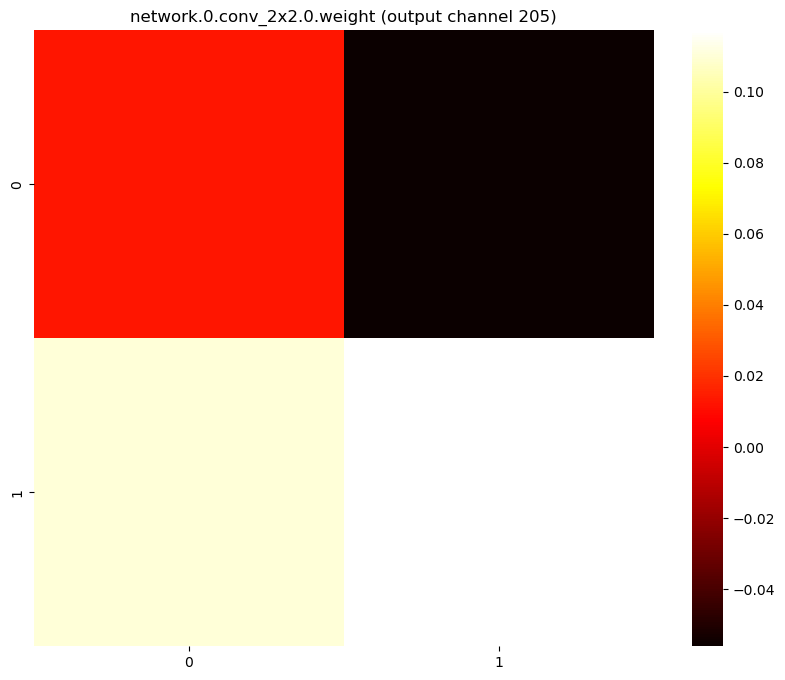

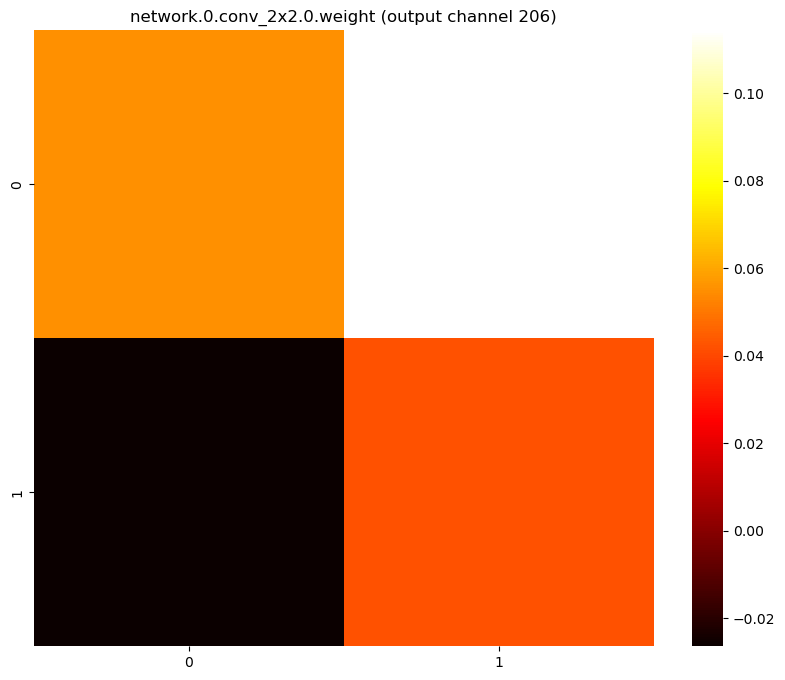

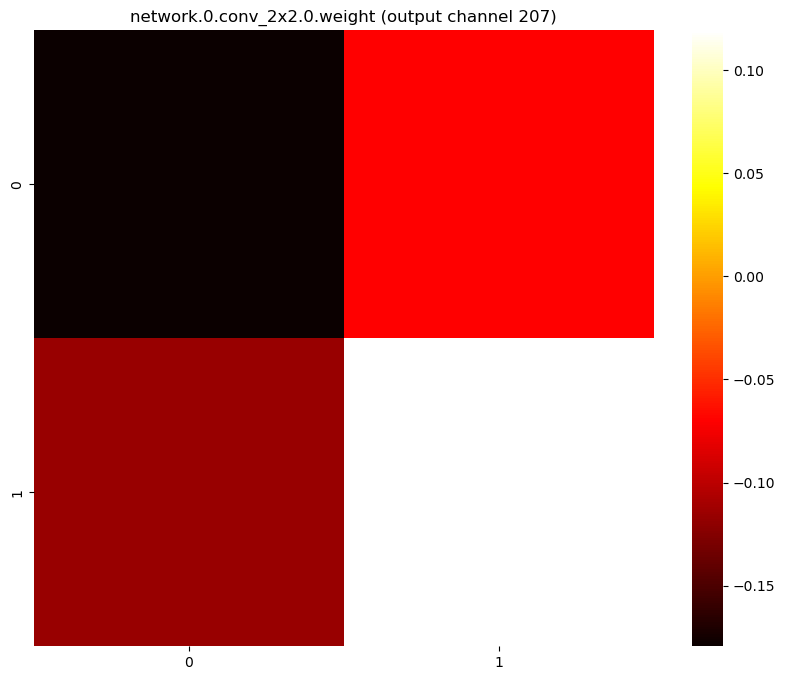

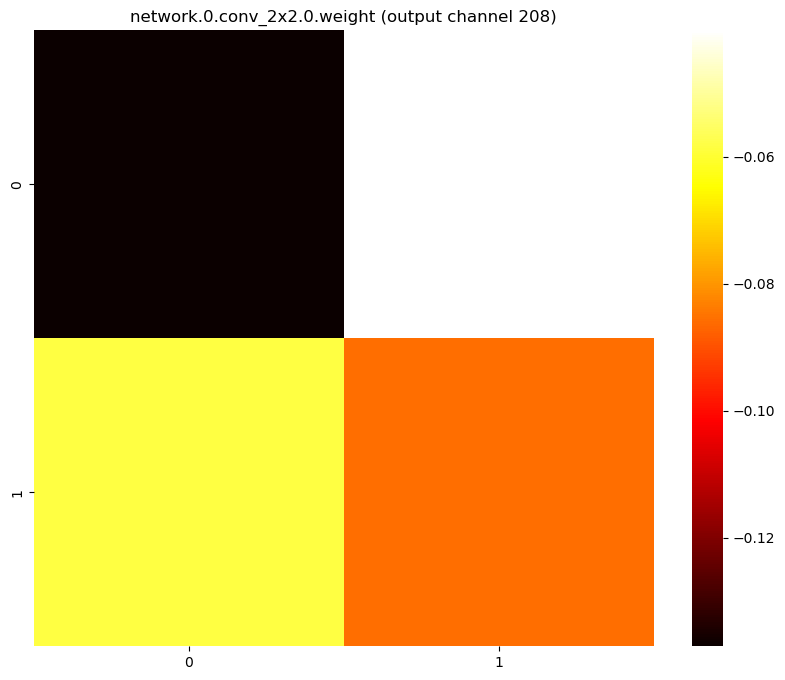

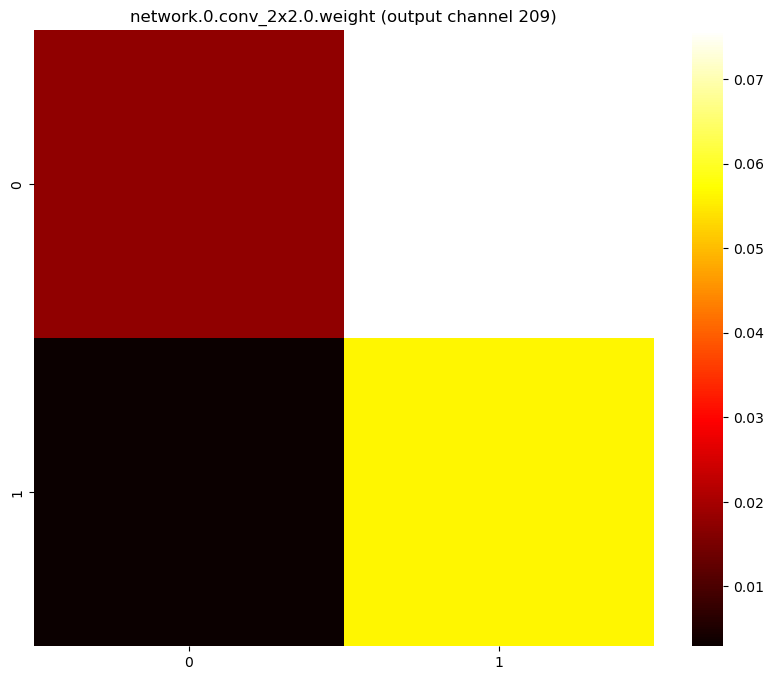

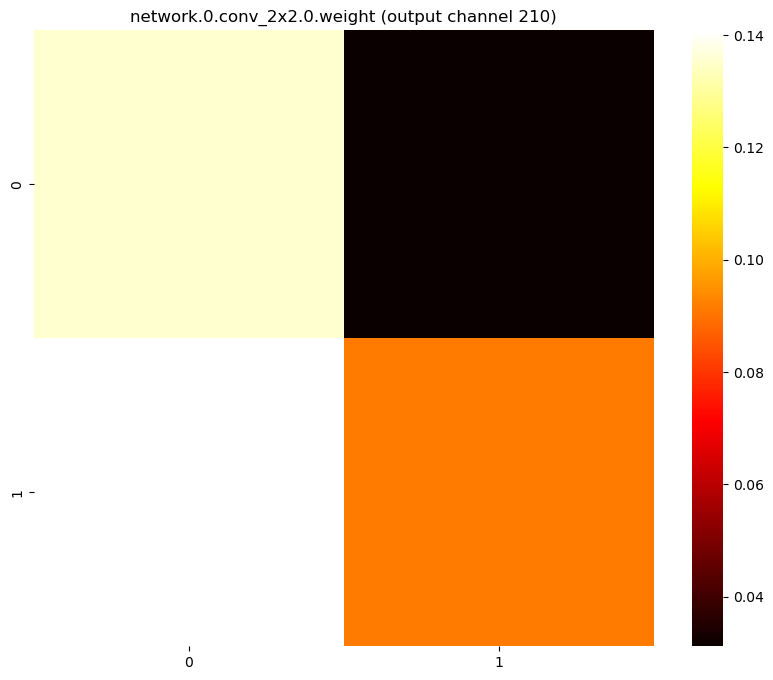

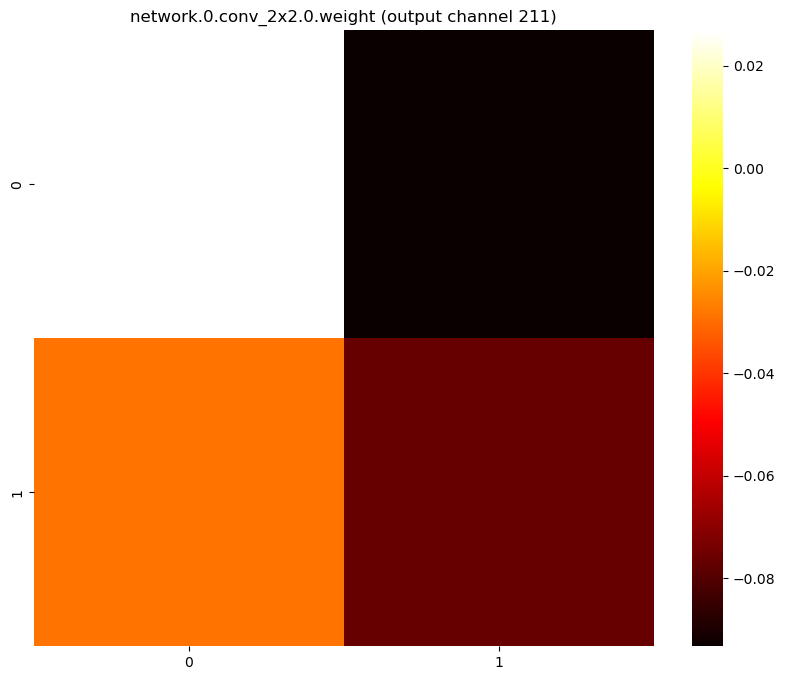

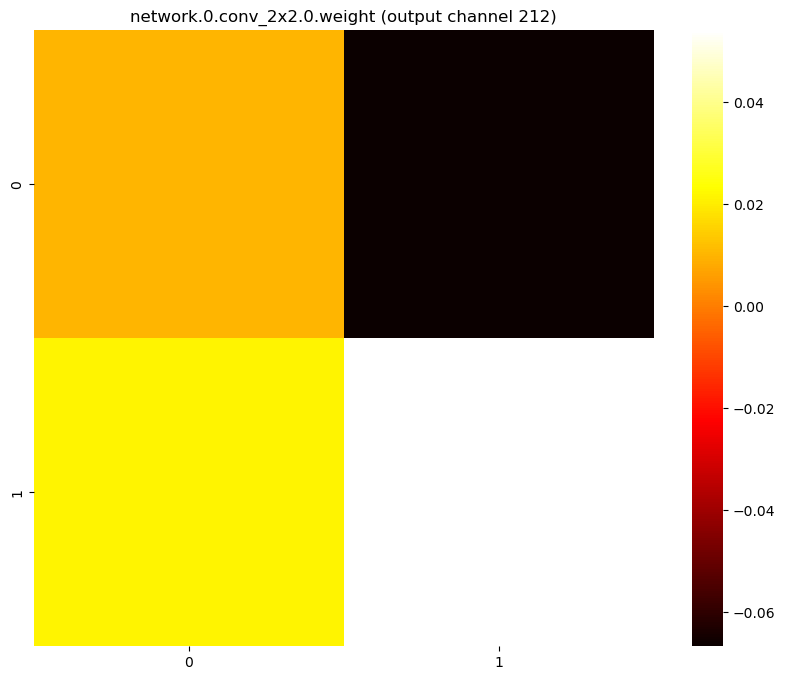

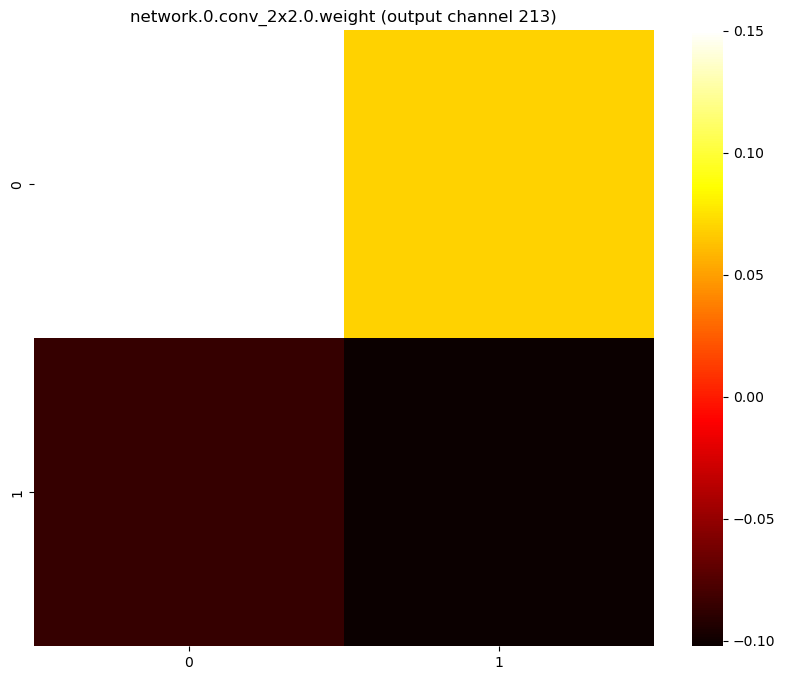

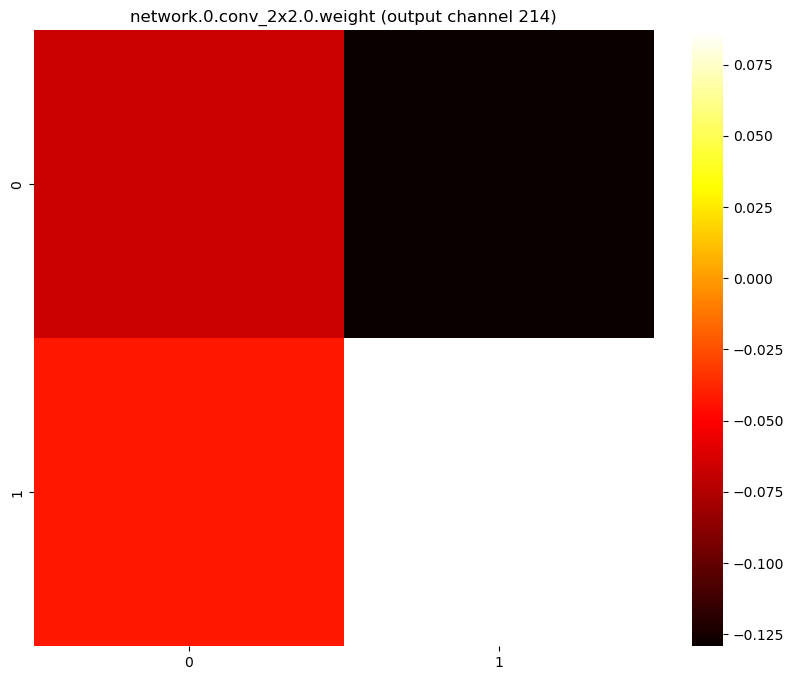

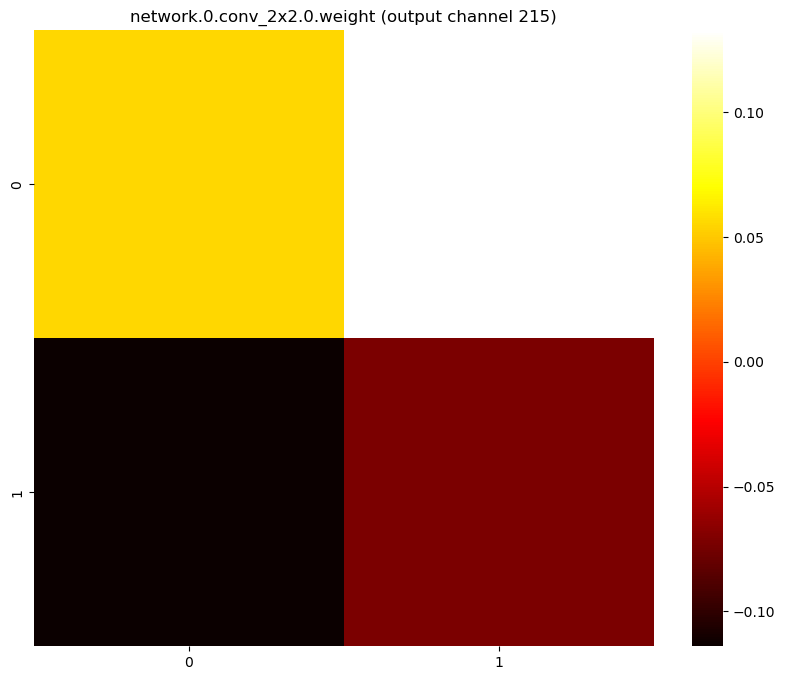

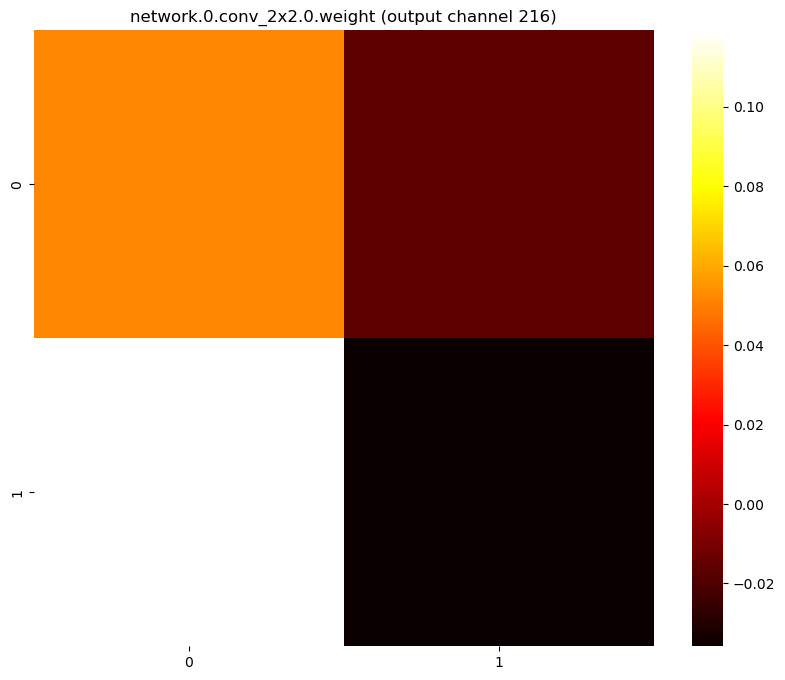

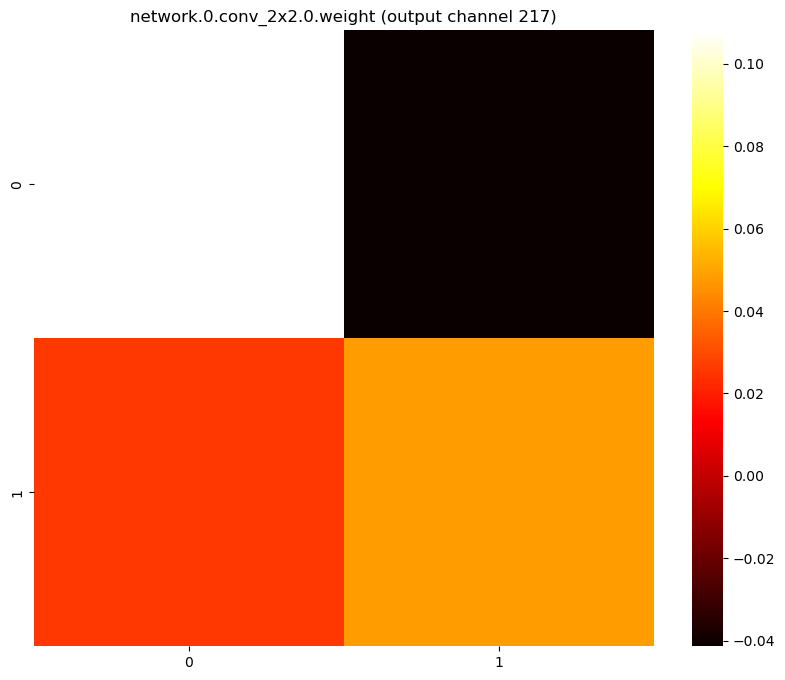

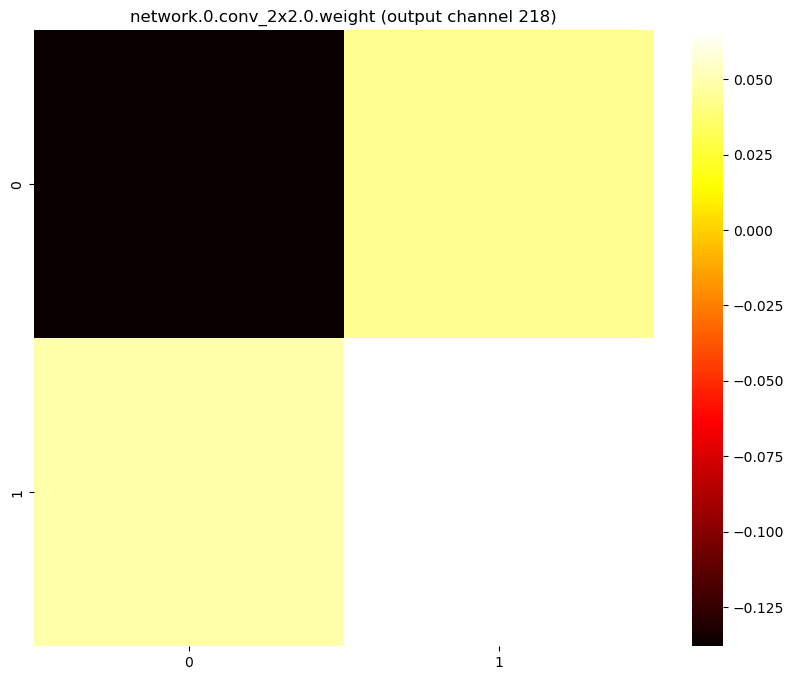

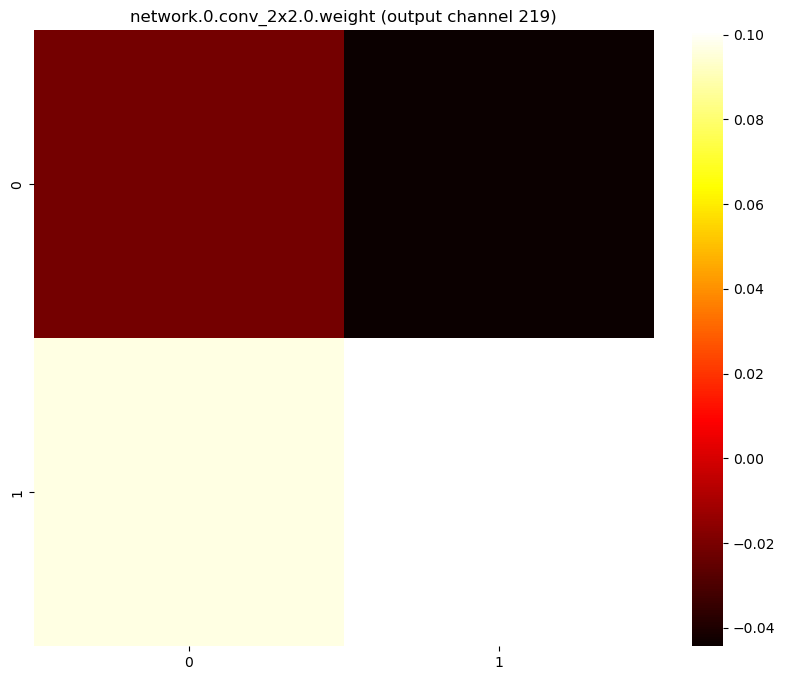

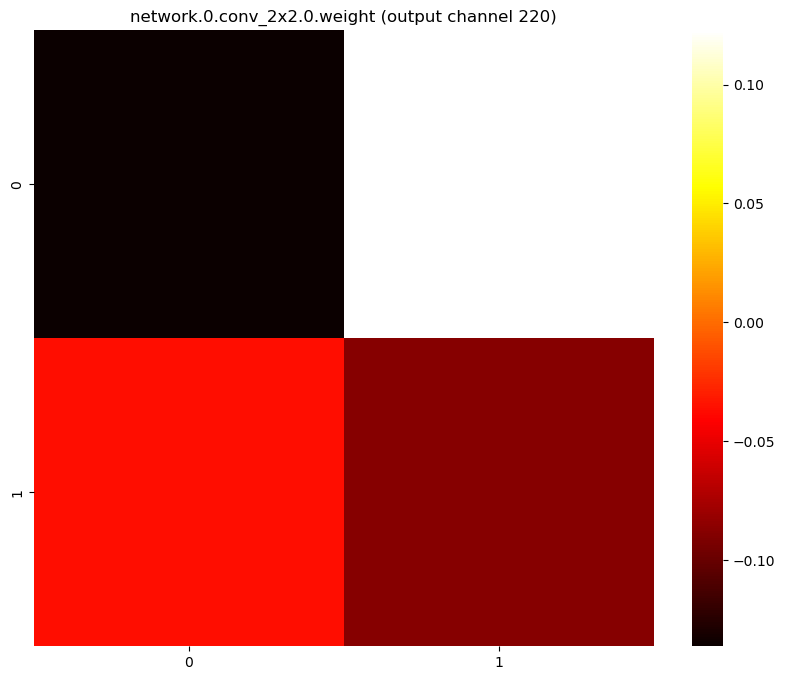

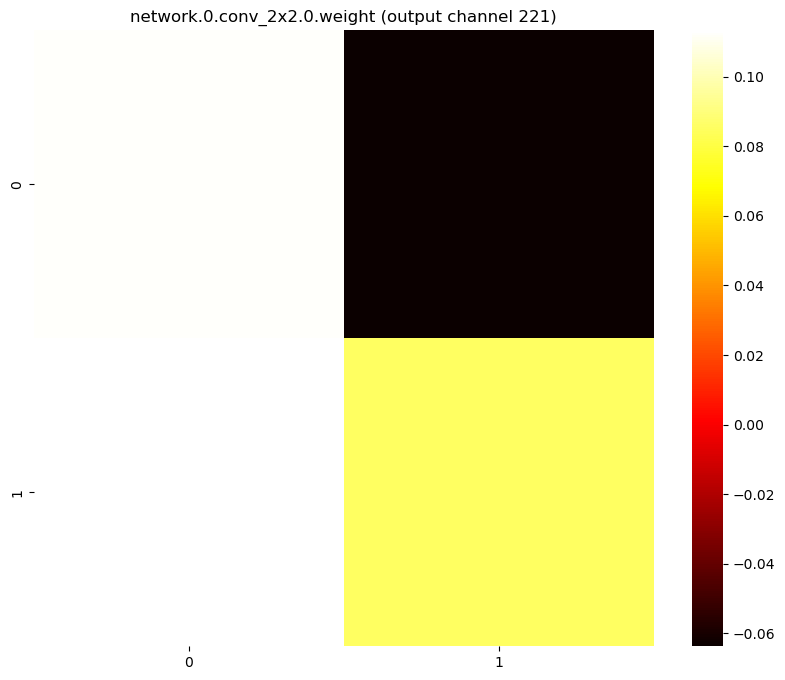

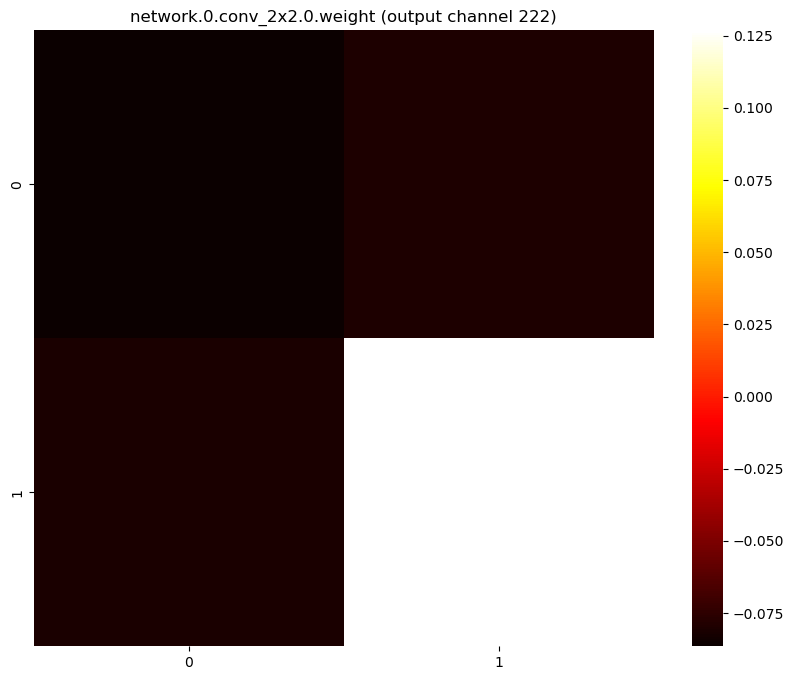

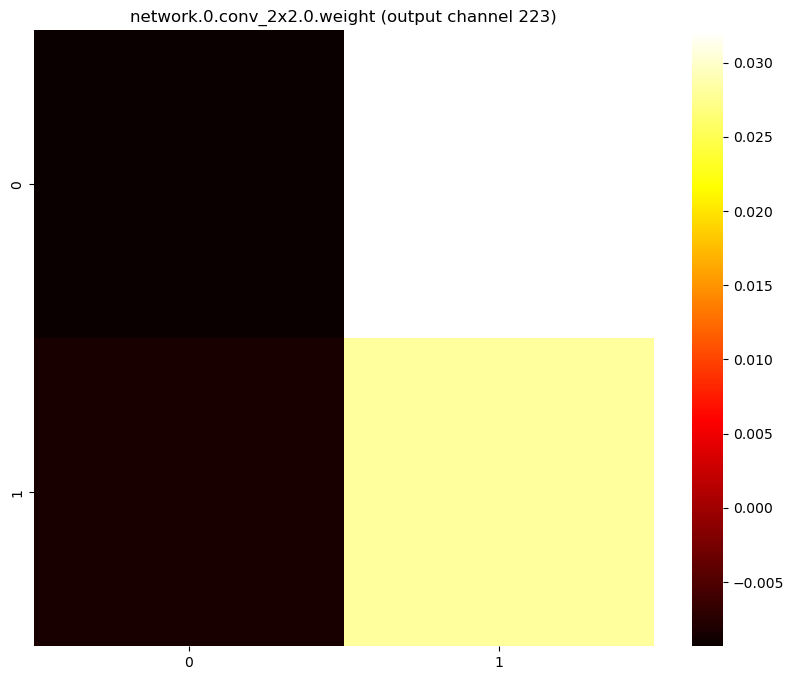

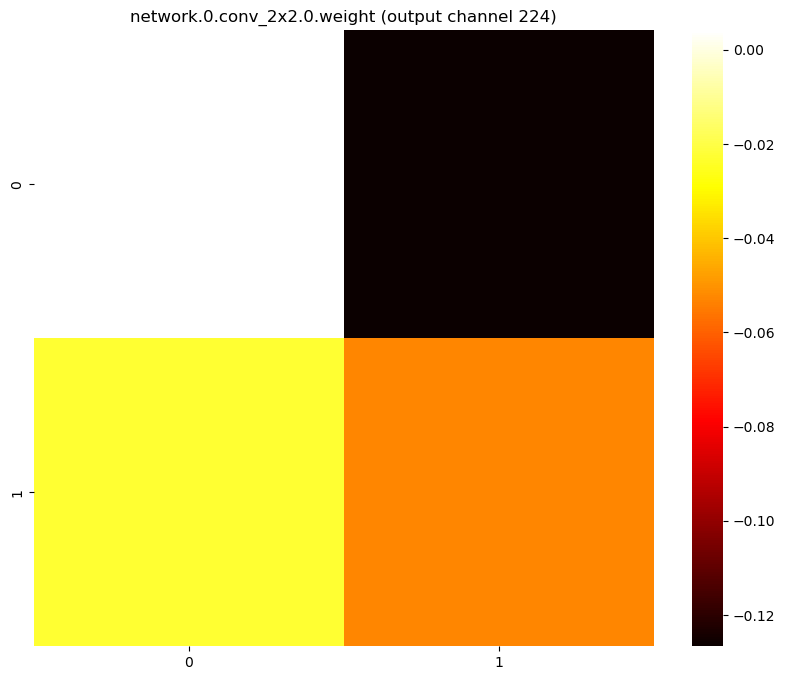

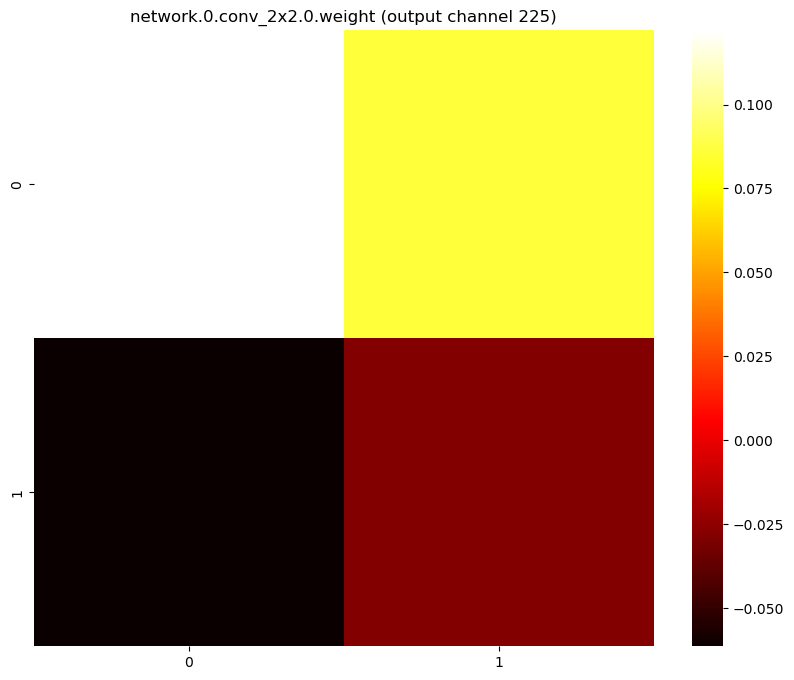

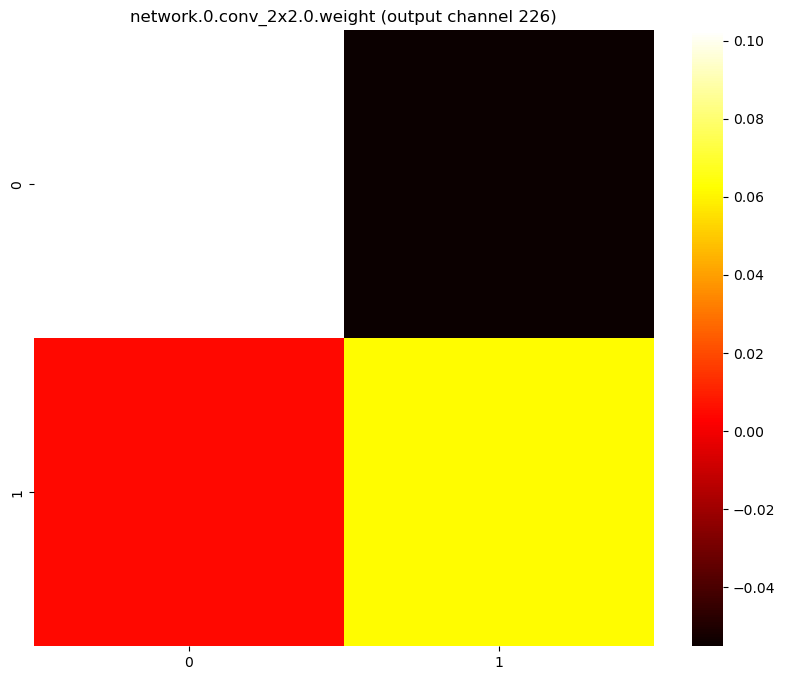

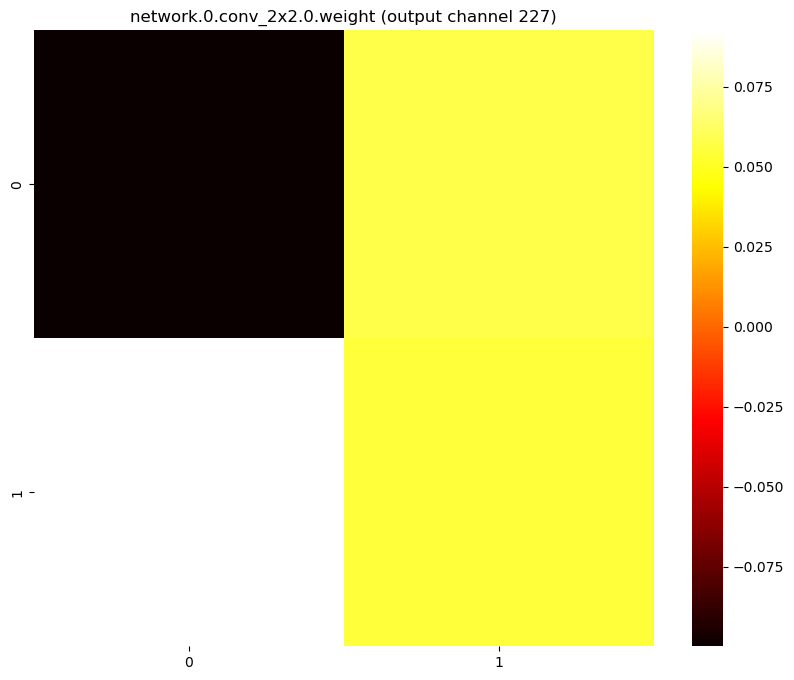

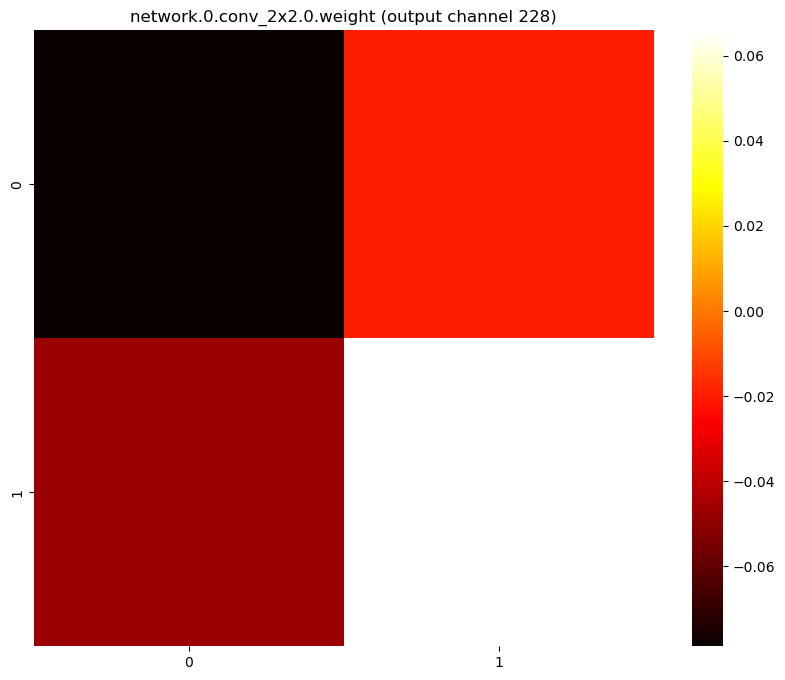

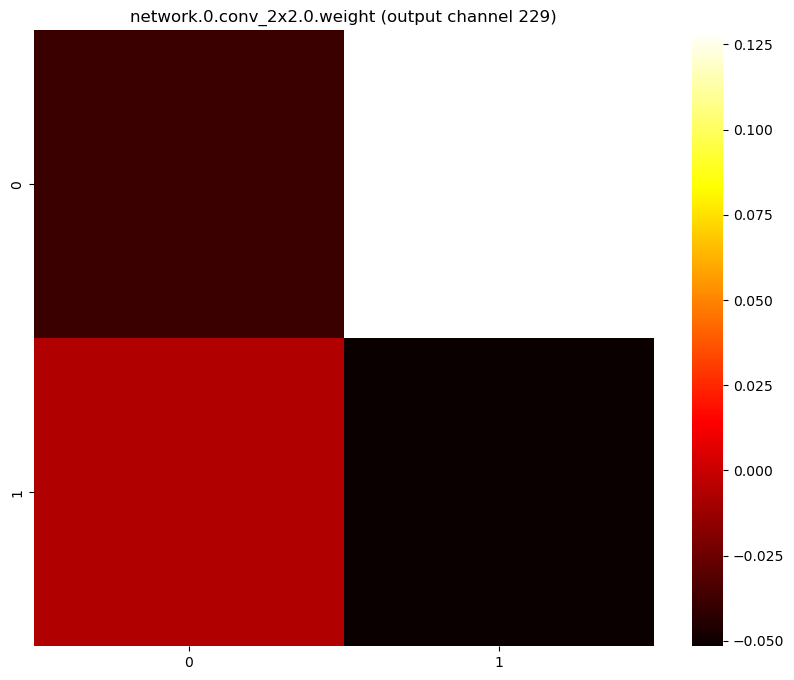

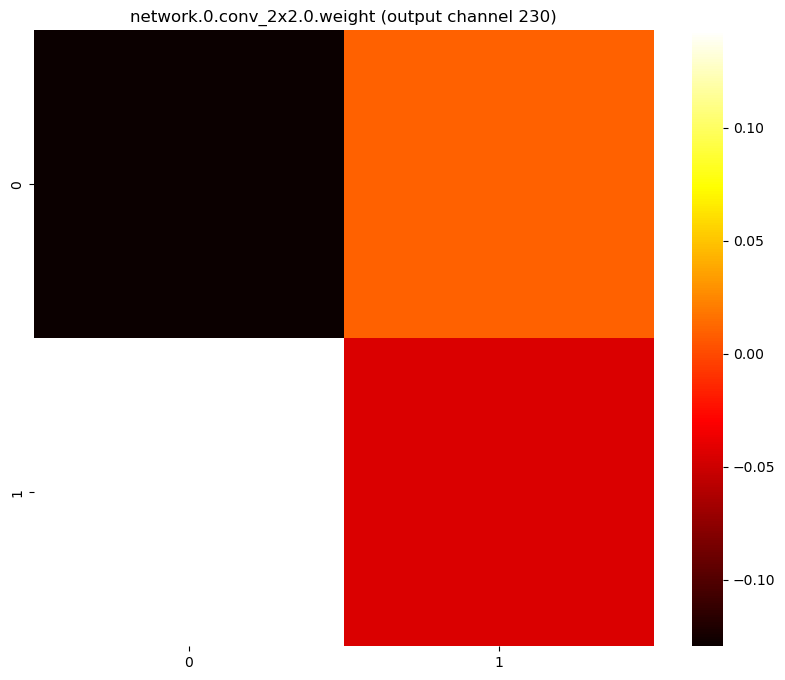

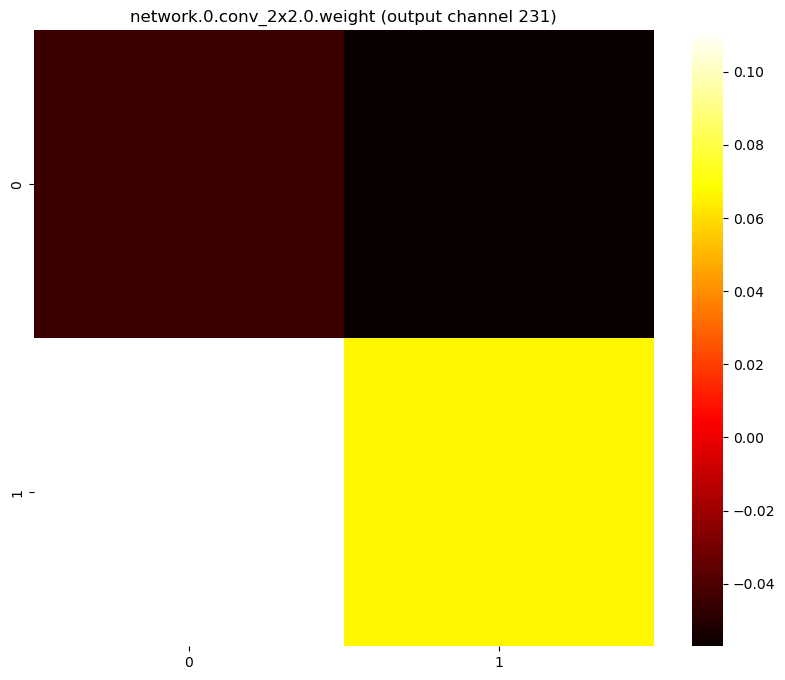

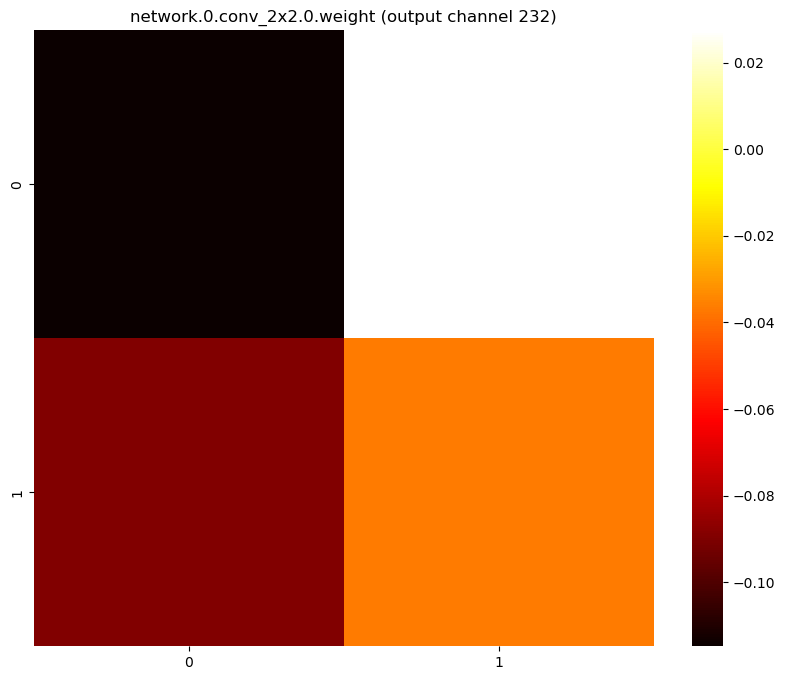

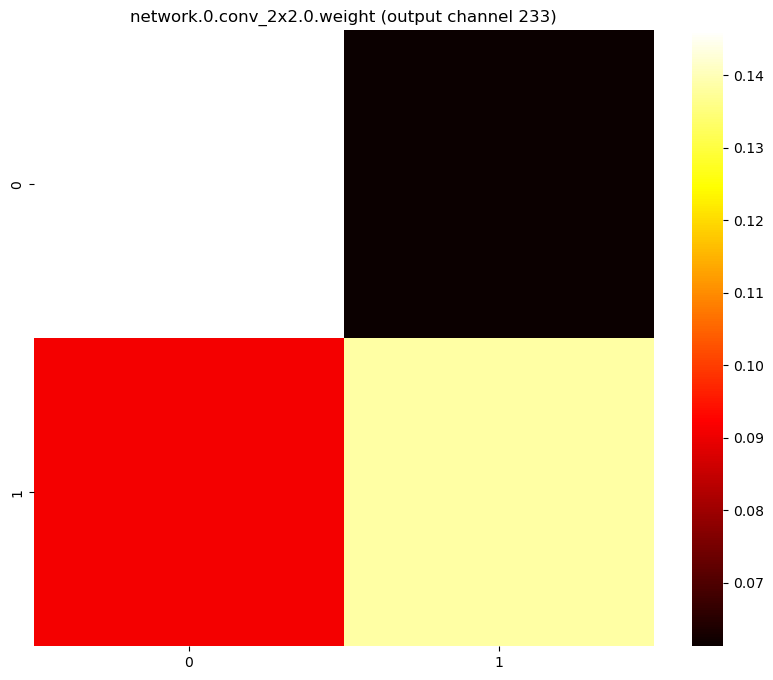

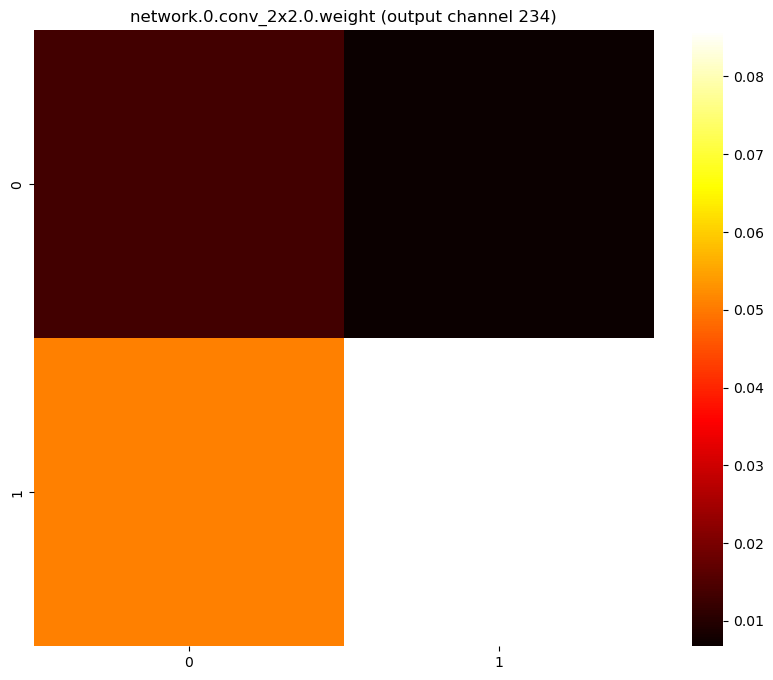

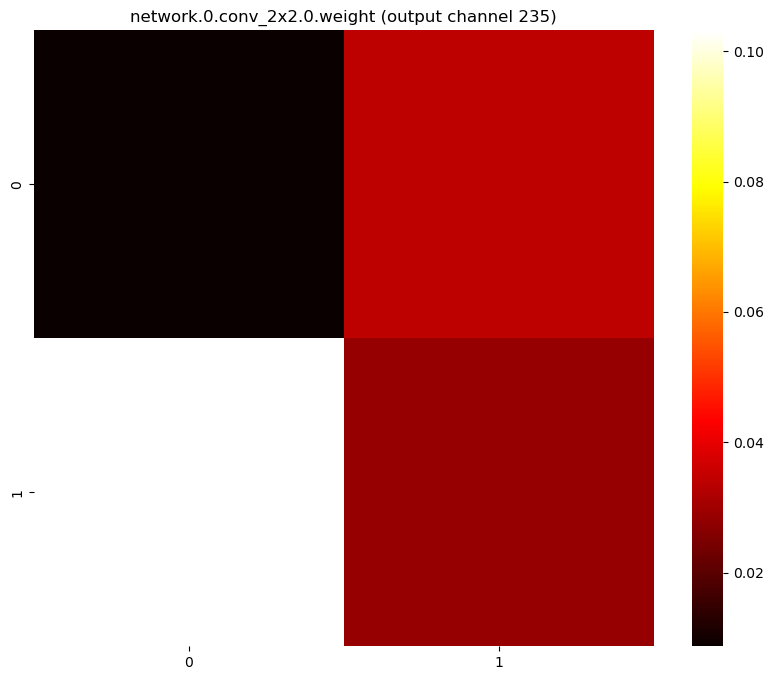

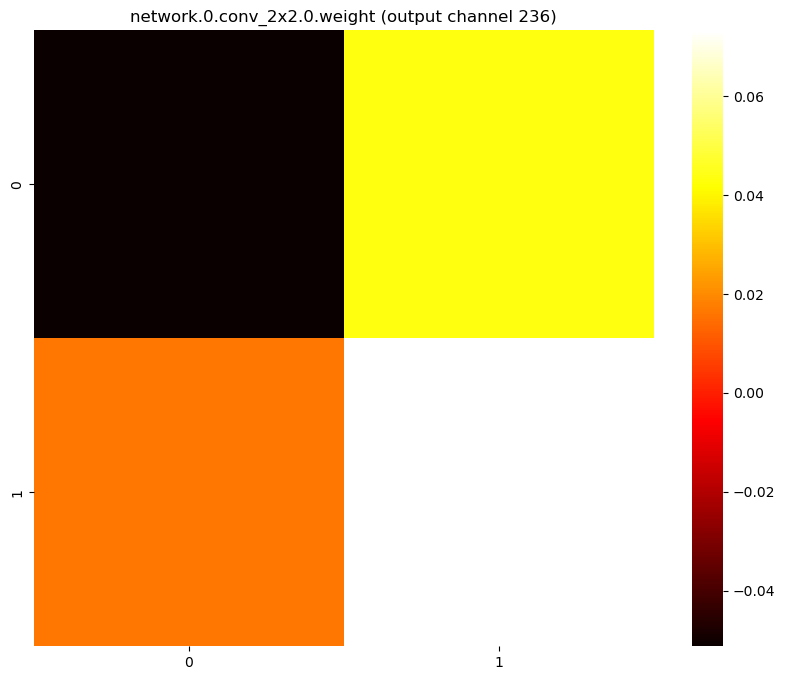

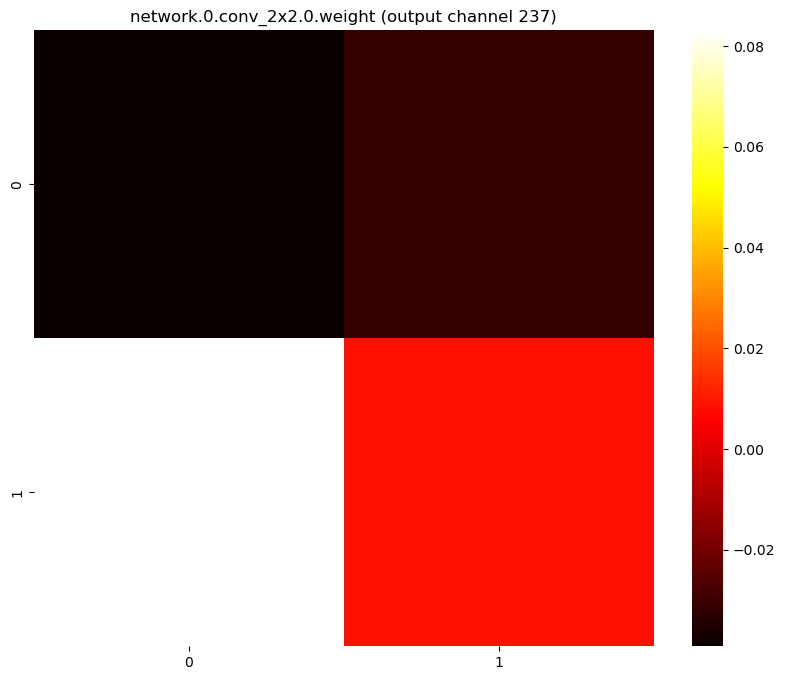

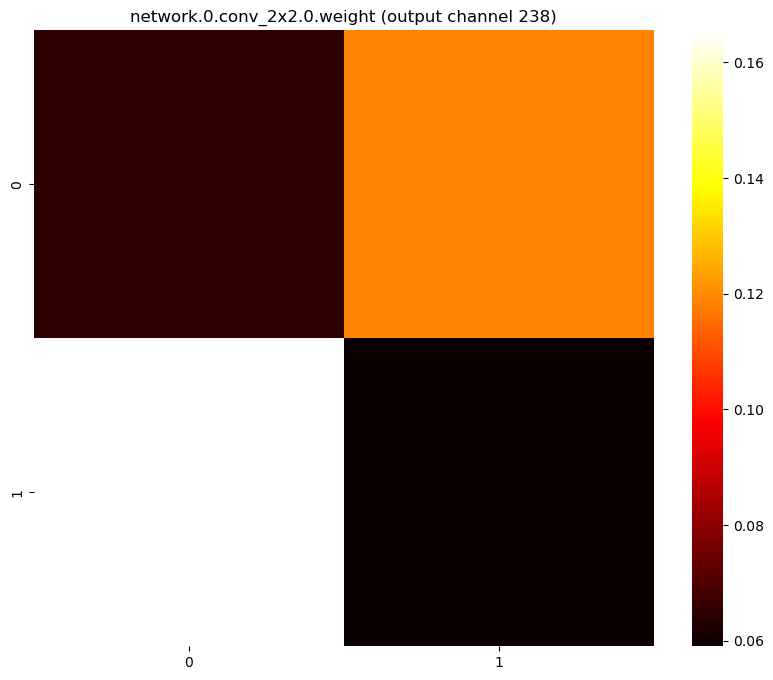

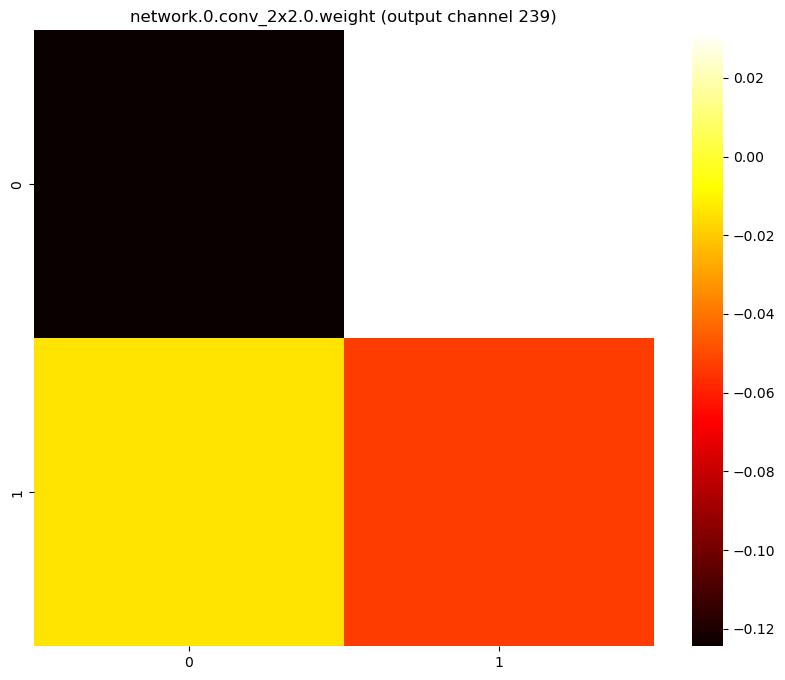

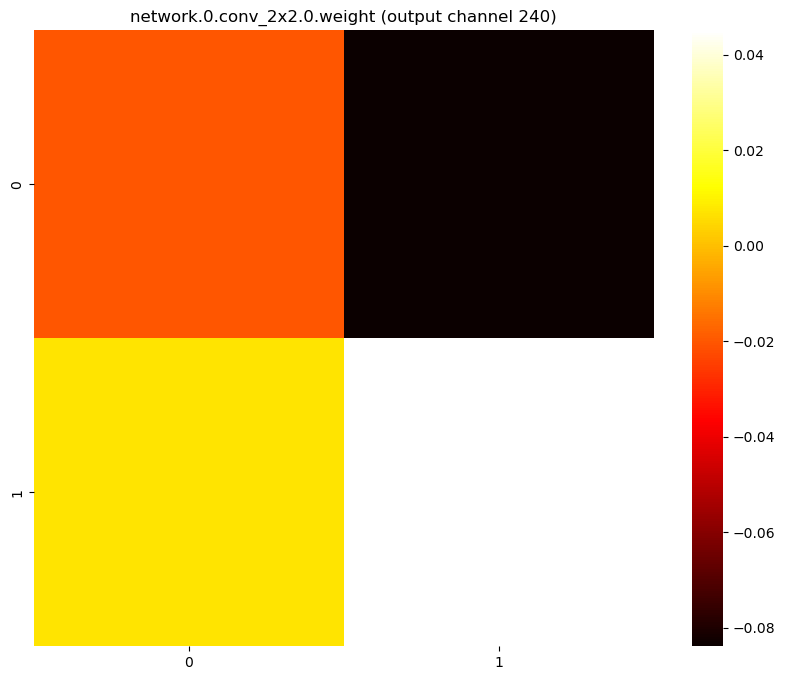

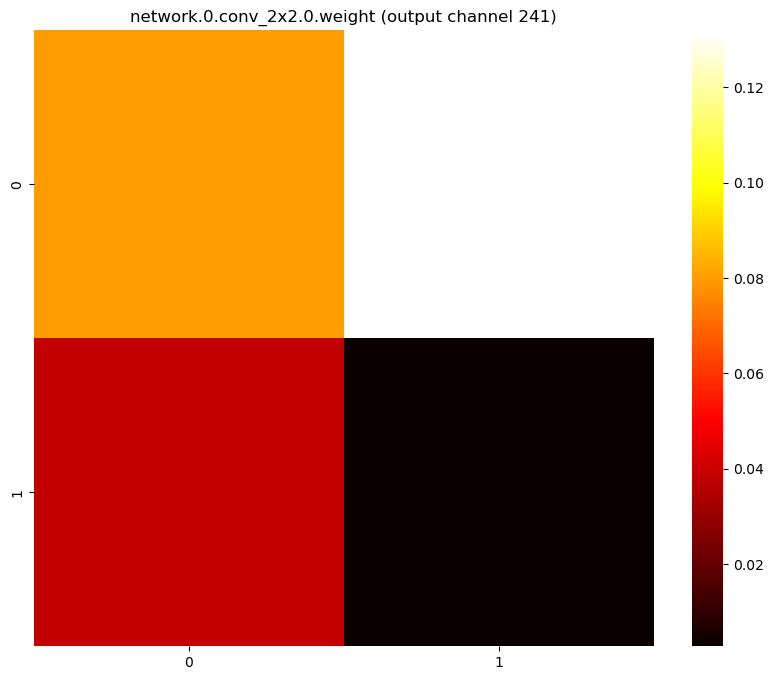

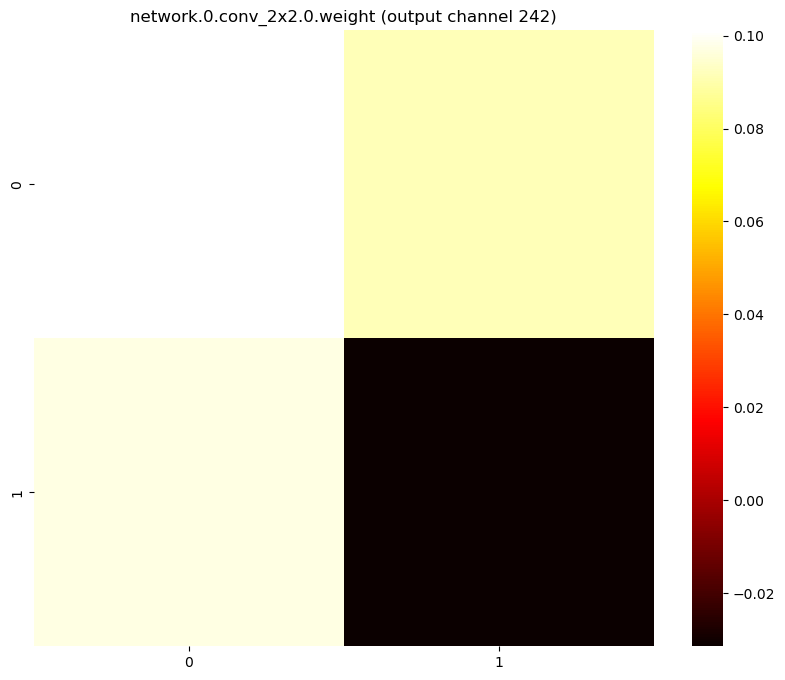

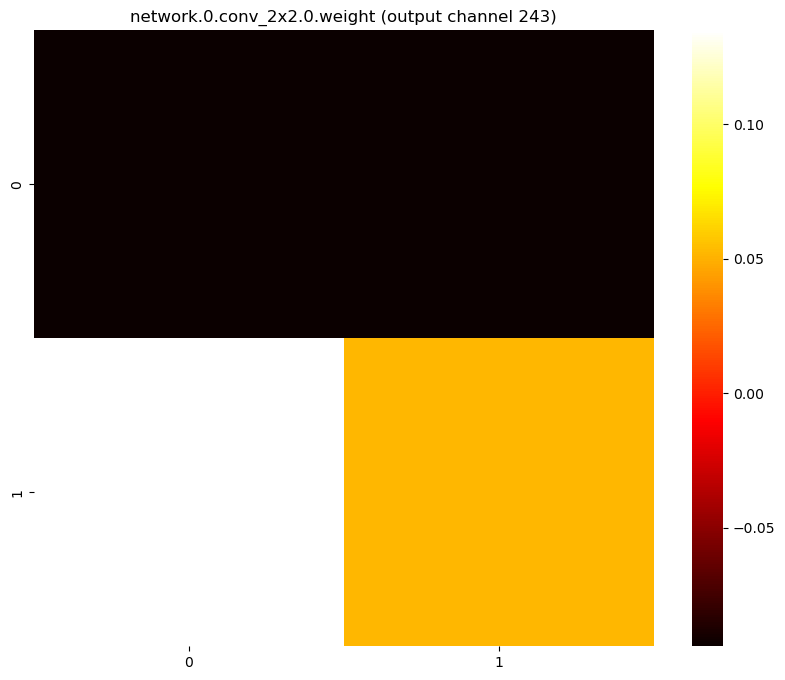

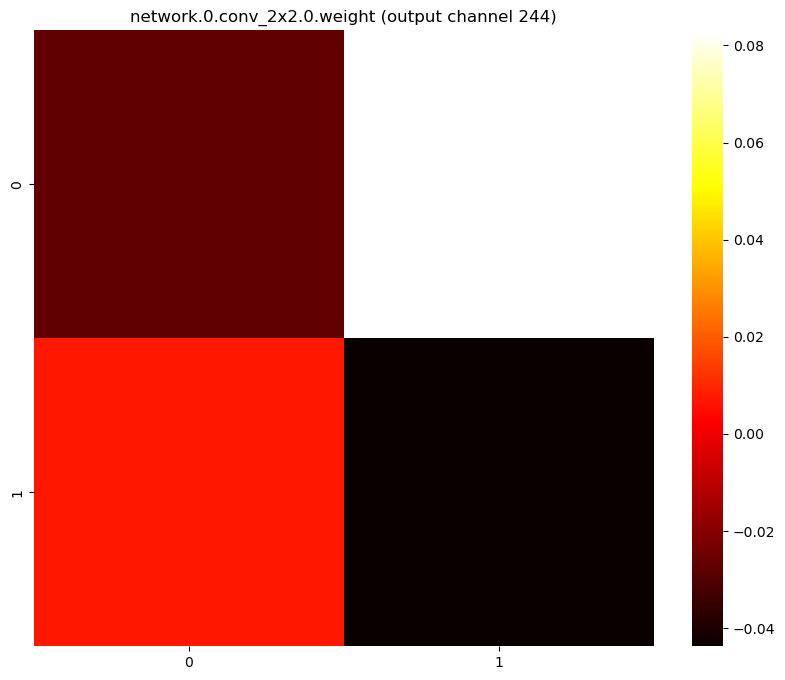

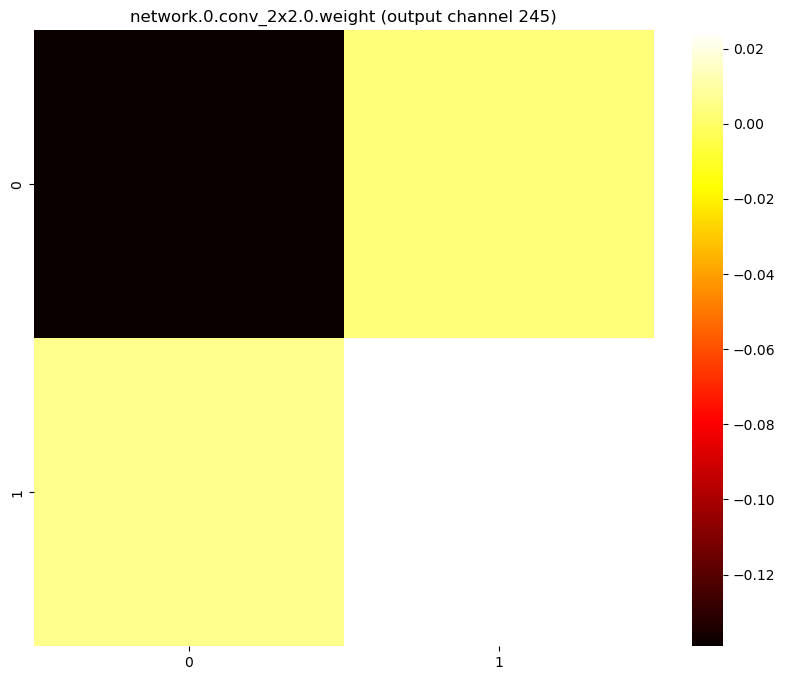

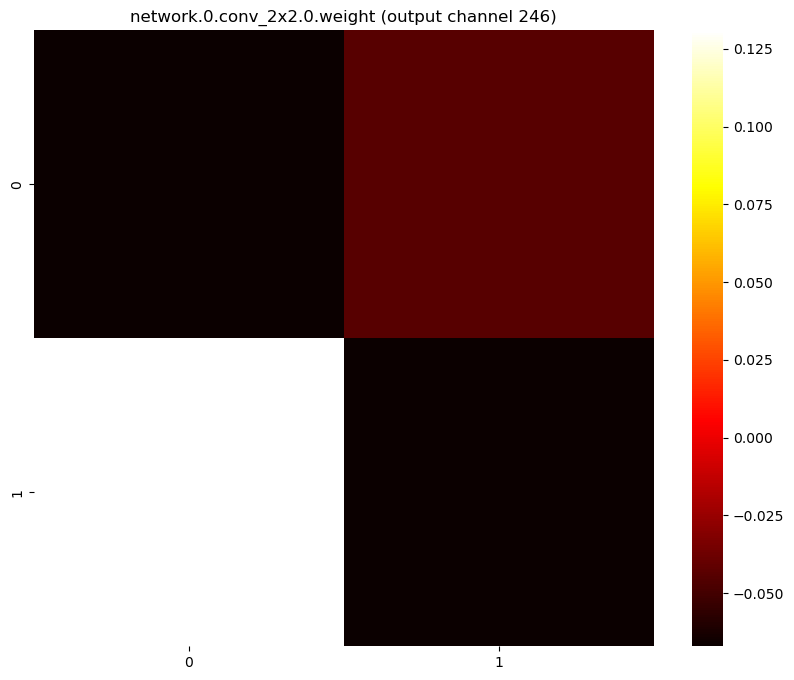

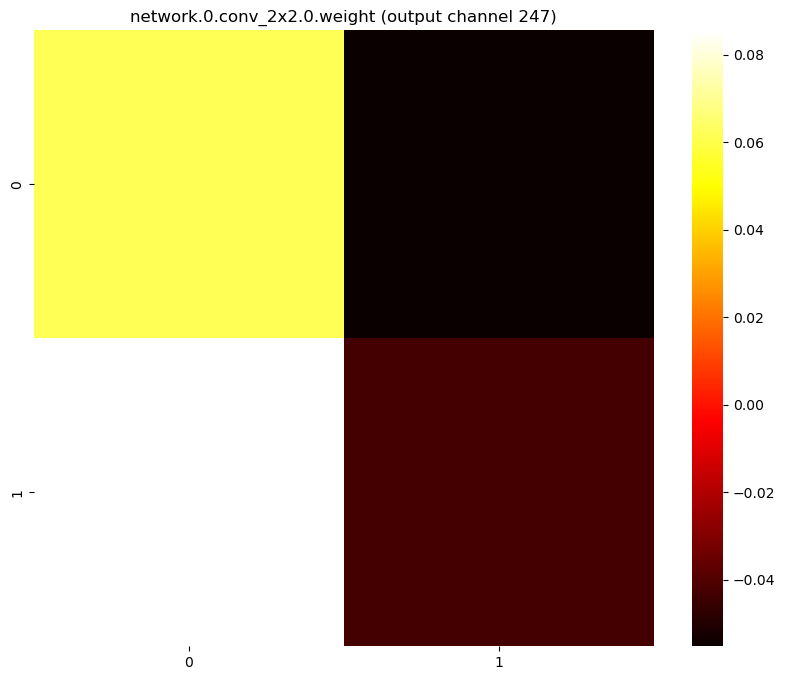

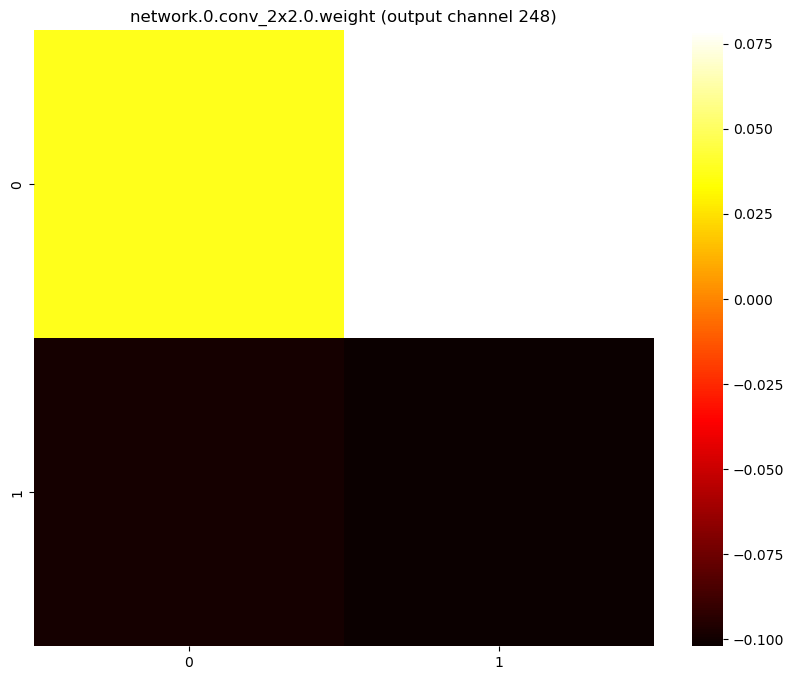

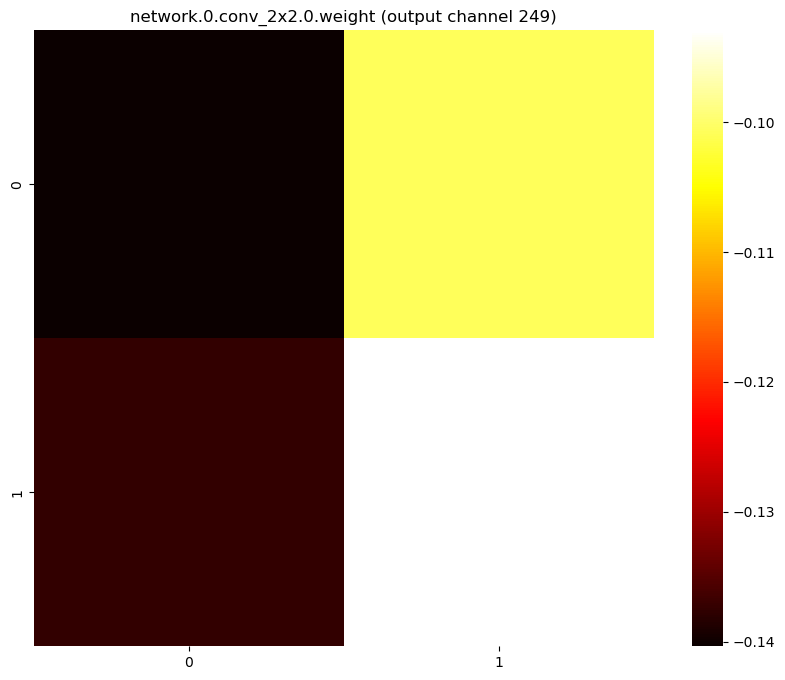

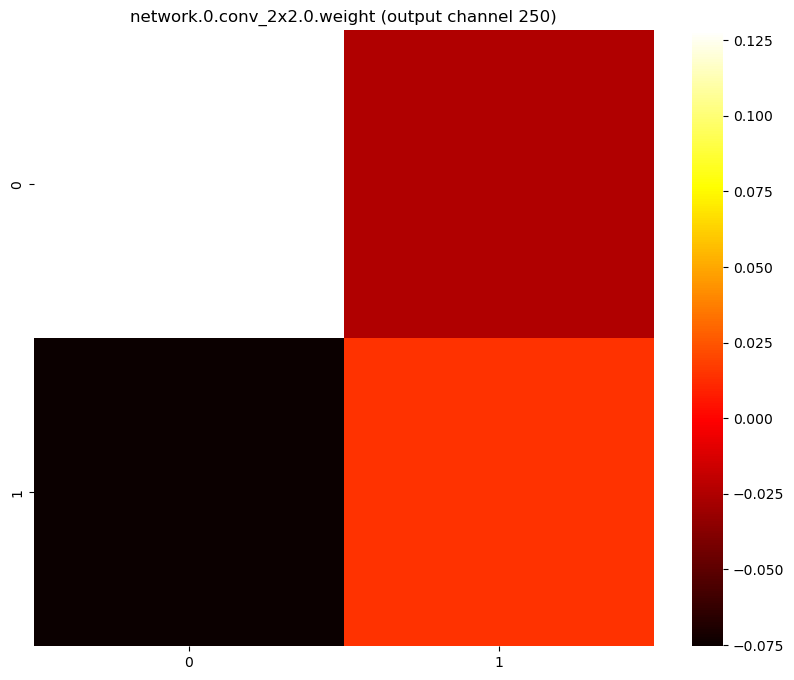

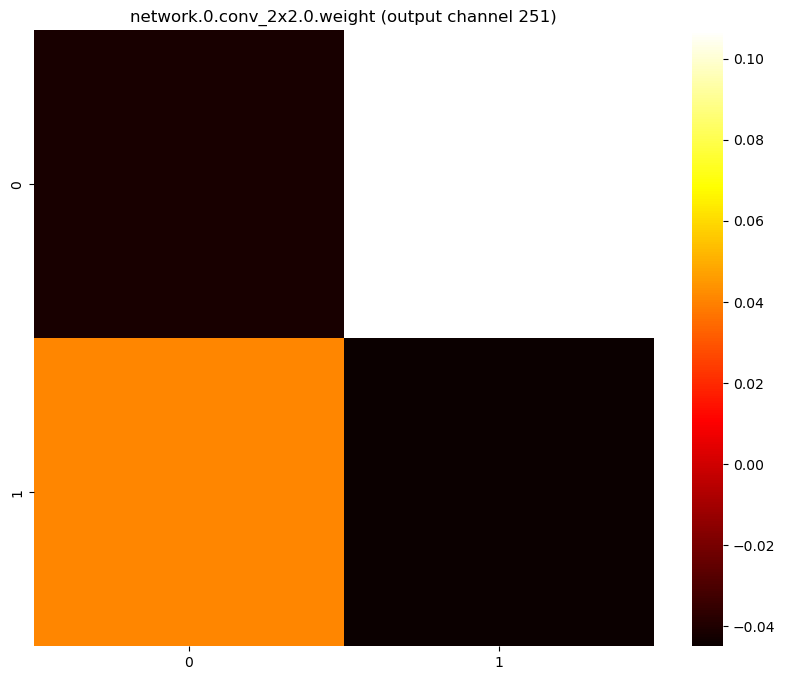

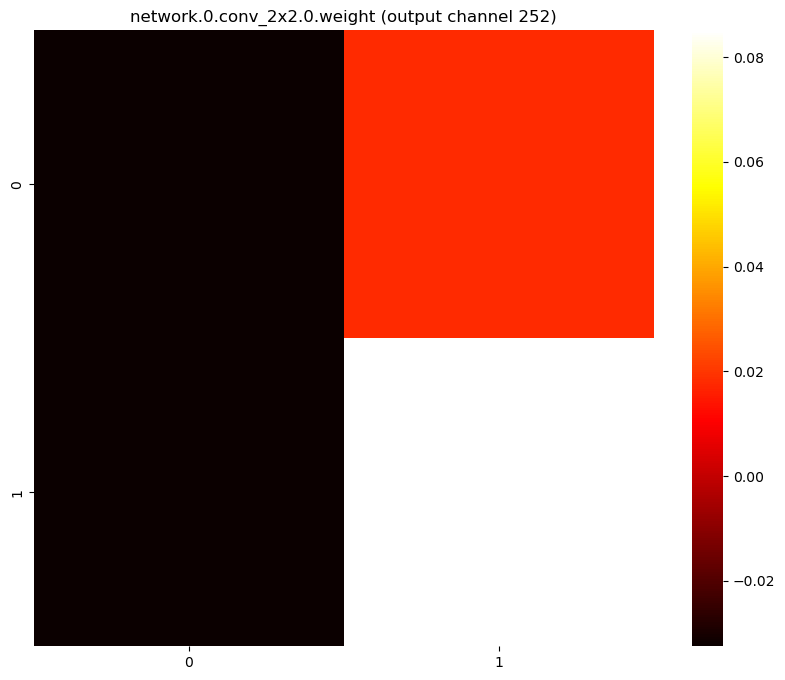

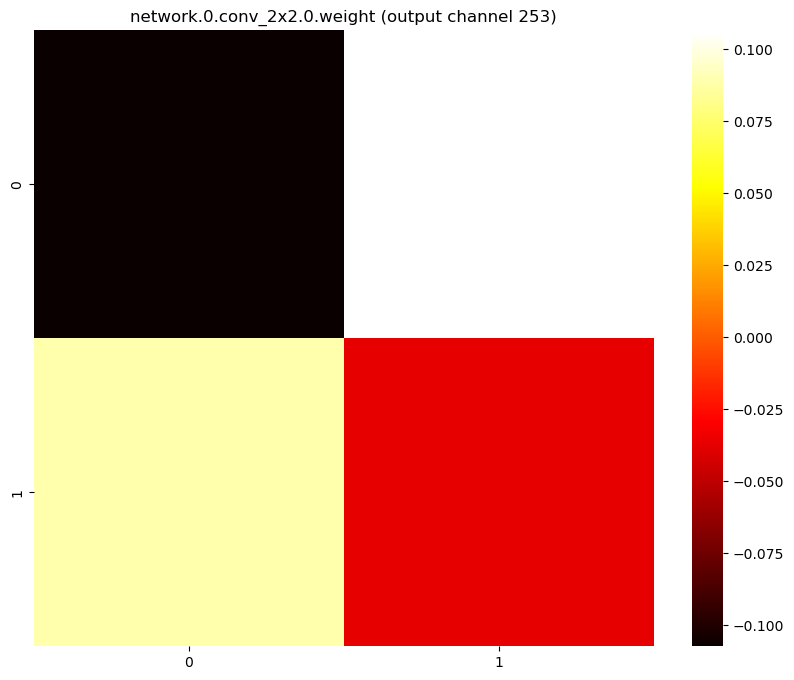

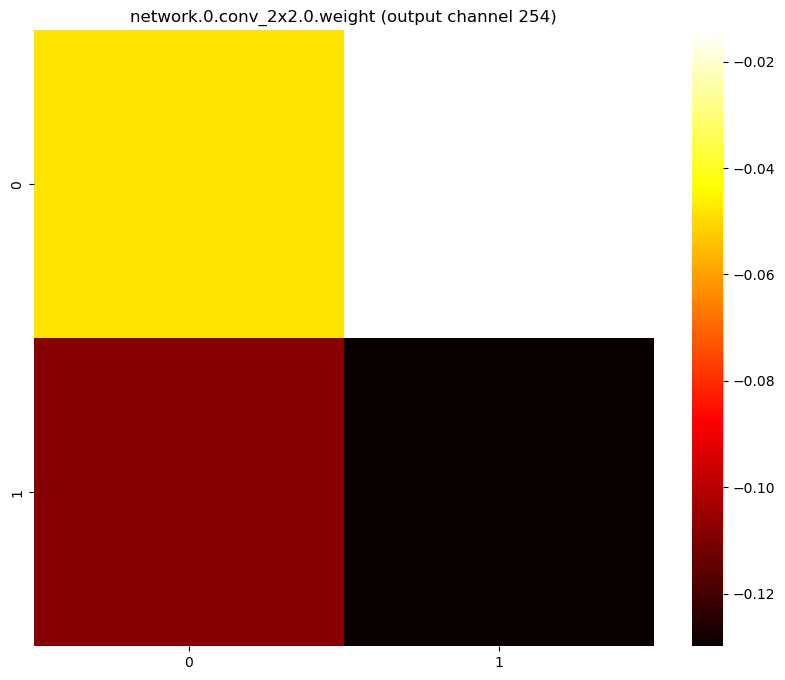

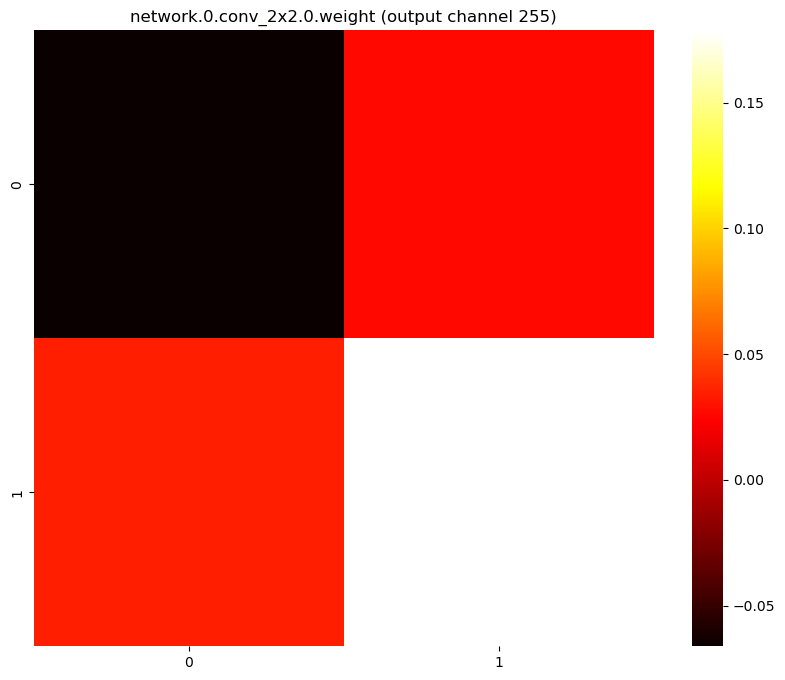

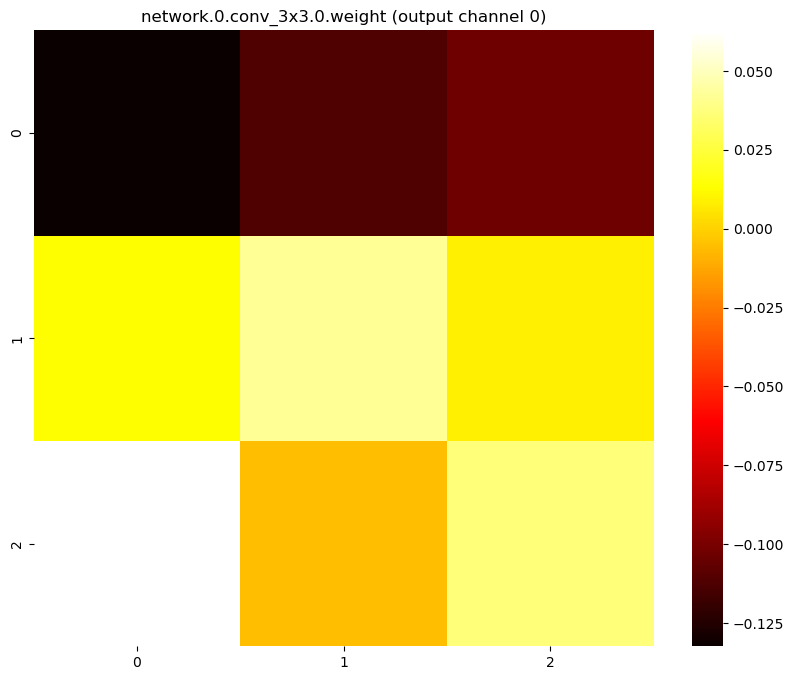

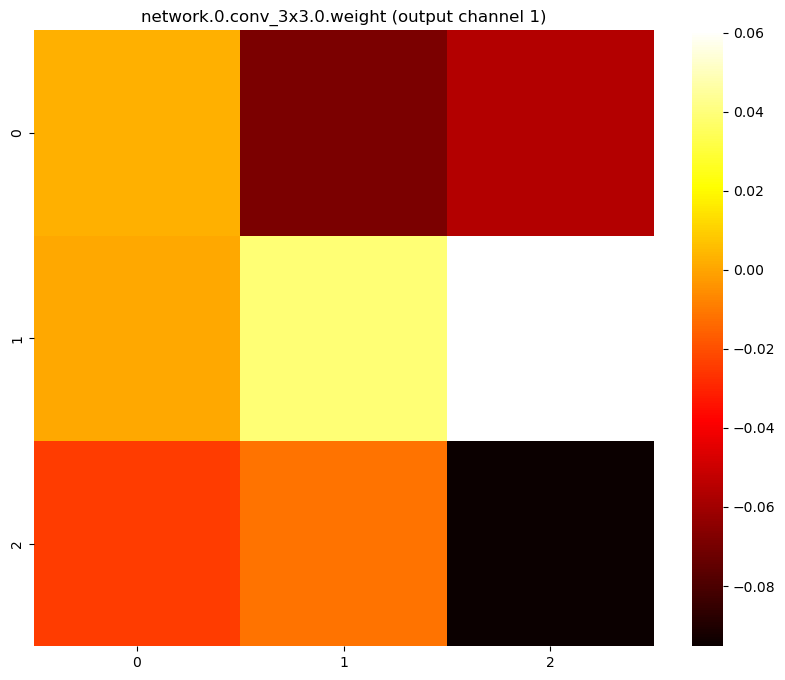

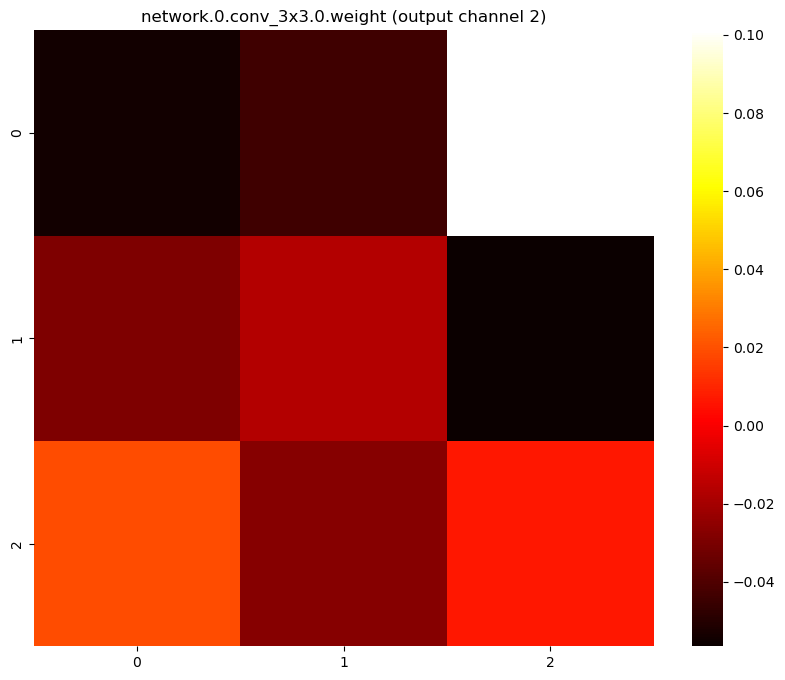

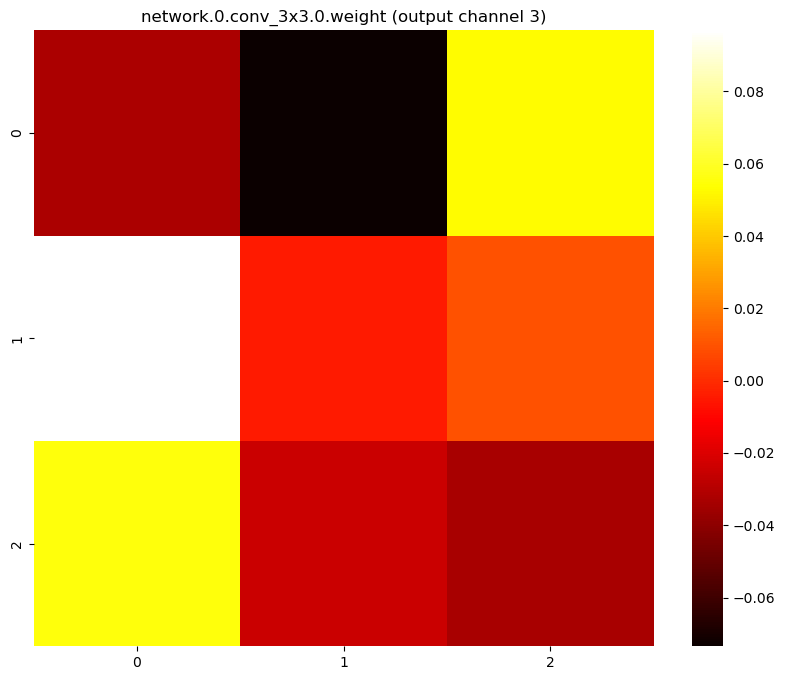

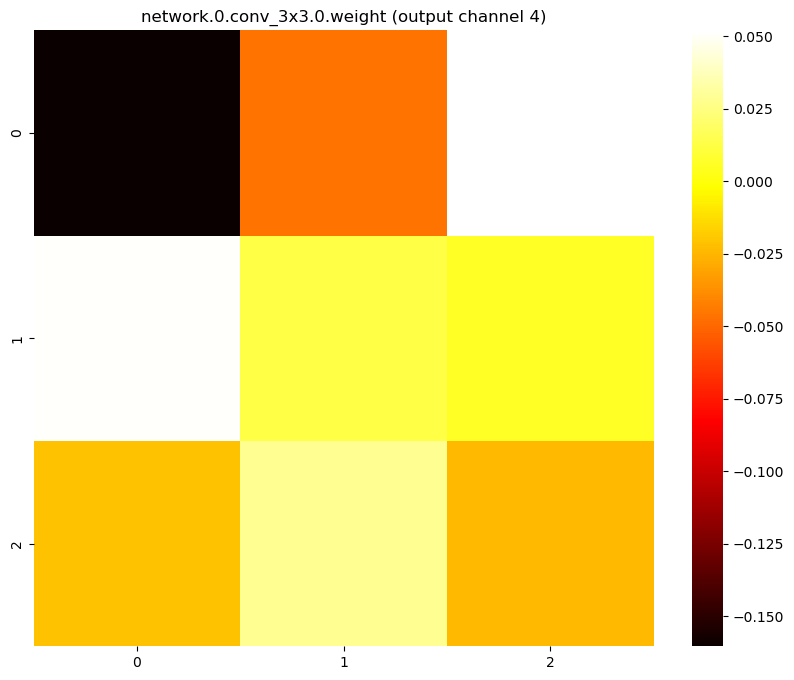

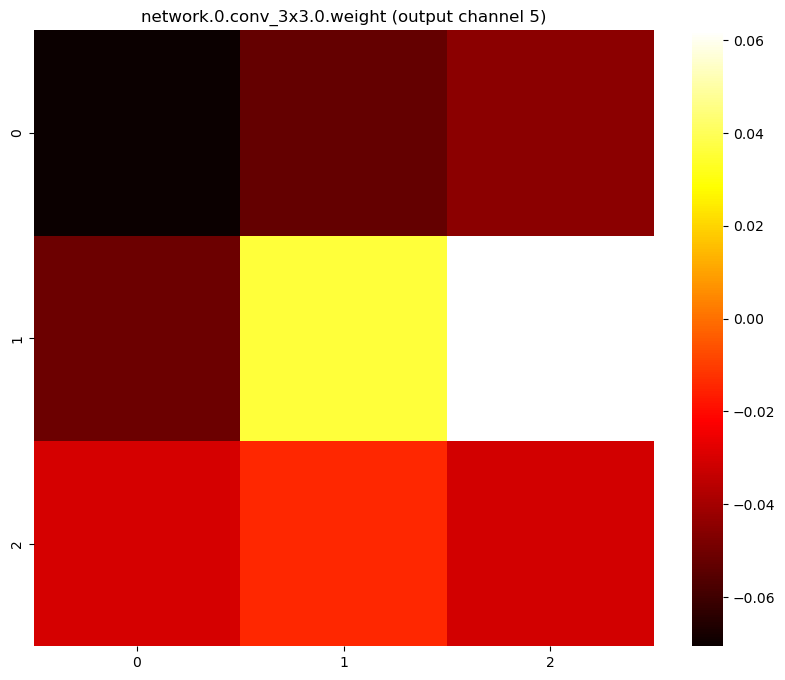

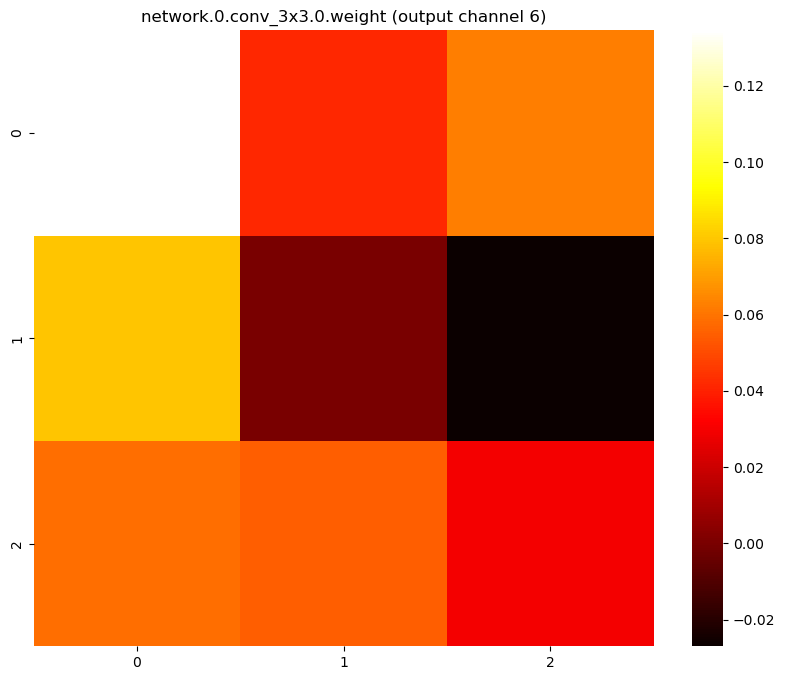

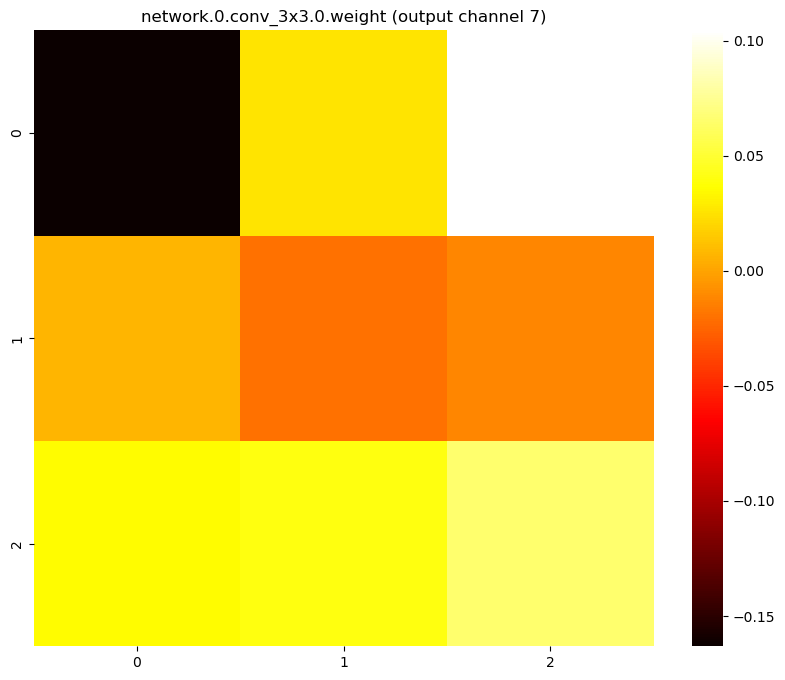

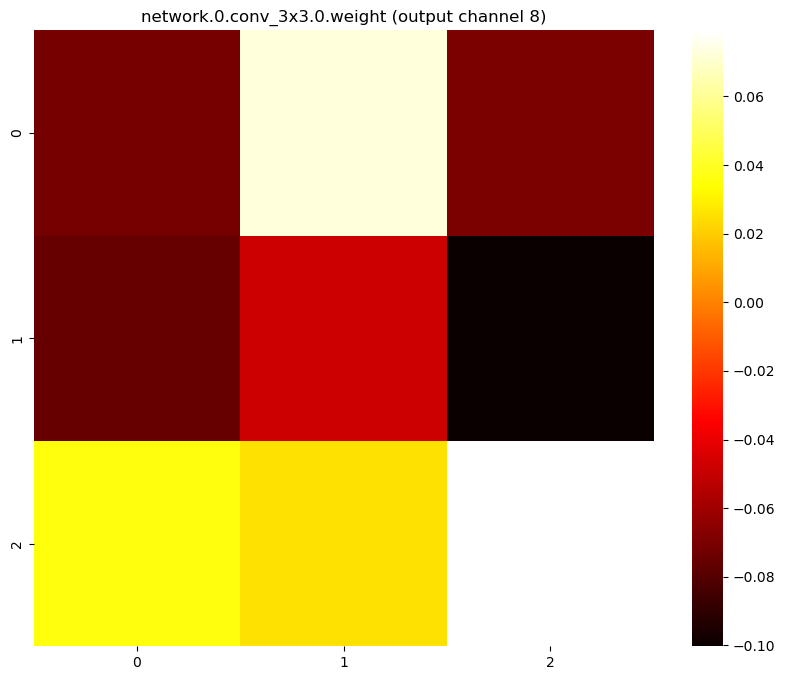

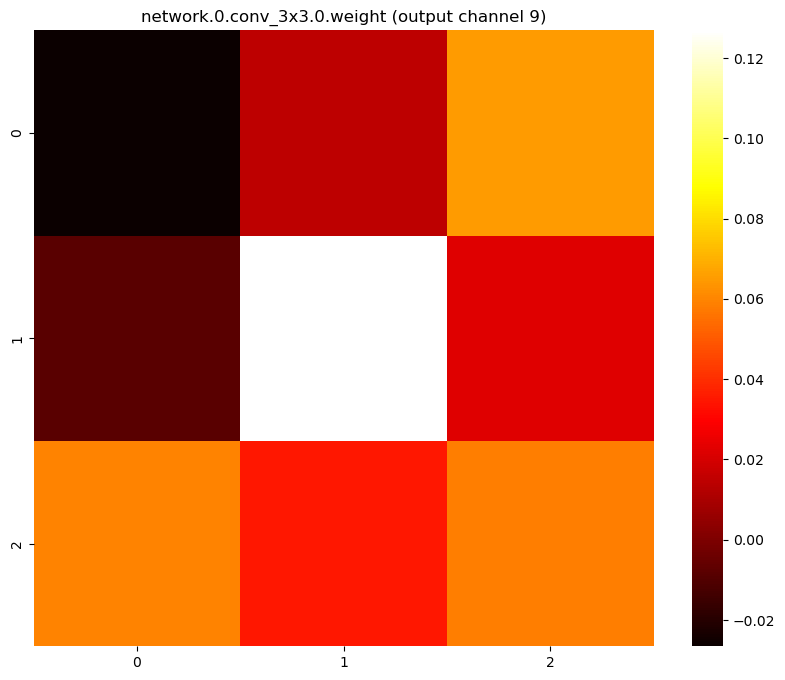

KeyboardInterrupt: 

In [60]:
def plot_heatmap(model):
    for name, param in model.named_parameters():
        if param.requires_grad and 'weight' in name and 'conv' in name:
            # Loop over output channels
            for i in range(param.shape[0]):
                plt.figure()
                plt.title(f"{name} (output channel {i})")
                sns.heatmap(param.data.cpu().numpy()[i, 0], cmap='hot', cbar=True)
                plt.show()

plot_heatmap(policy_net)

C:\Users\sudde\AppData\Local\Temp\ipykernel_36016\418071436.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  S = torch.tensor(S, dtype=torch.float32, device=device)


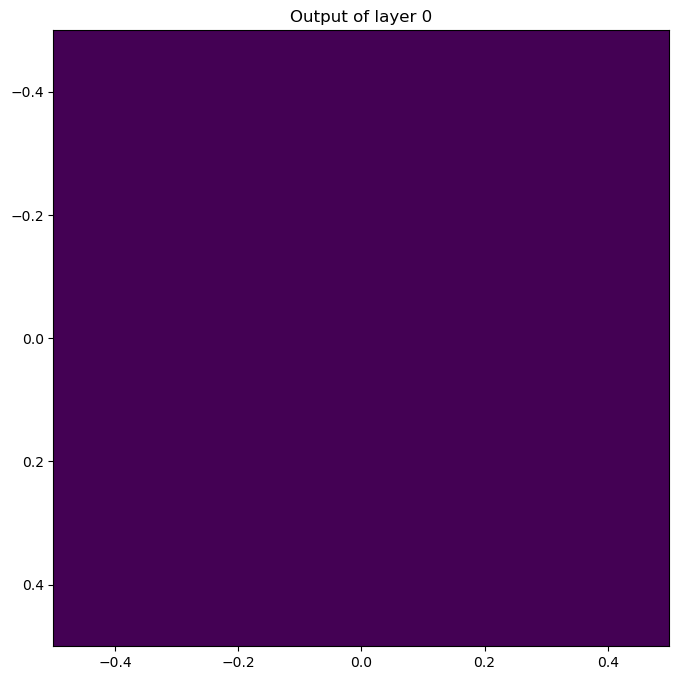

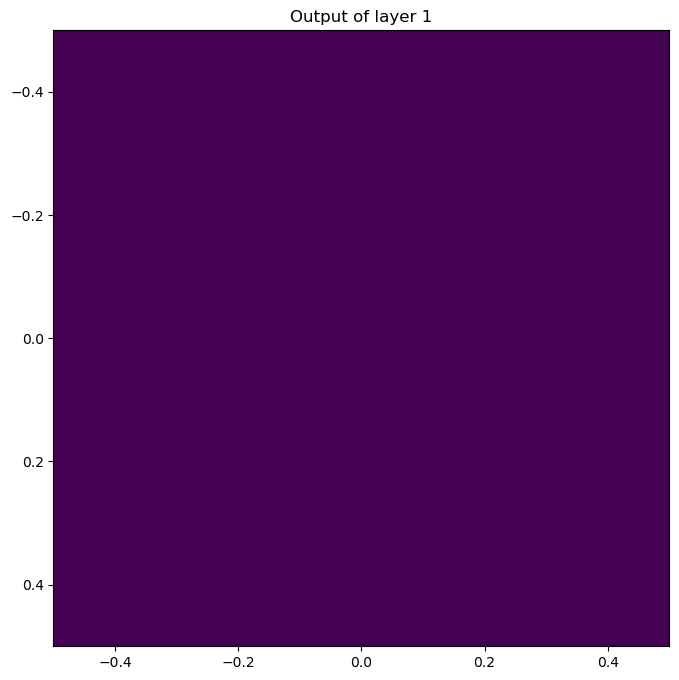

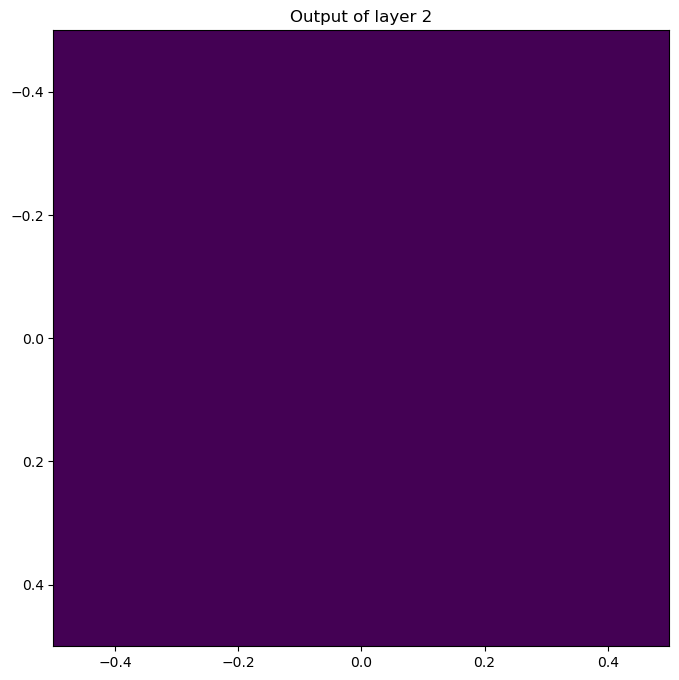

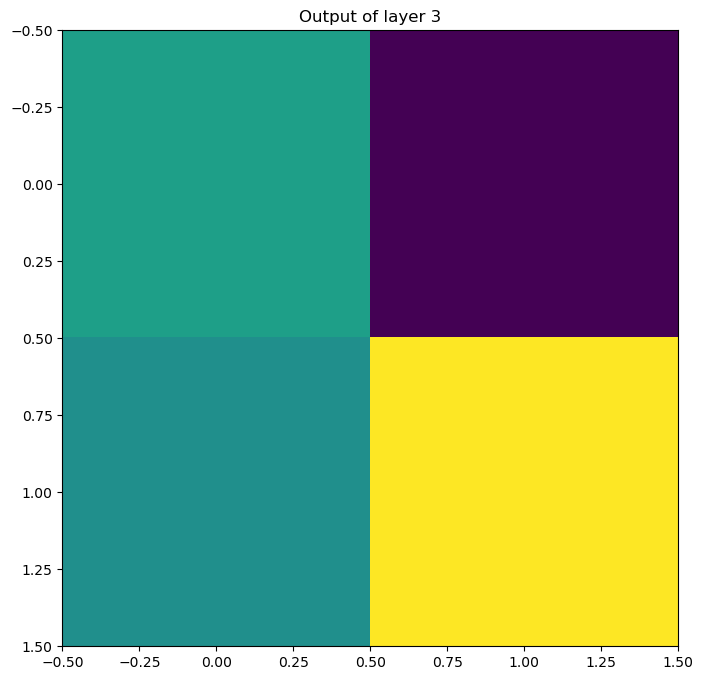

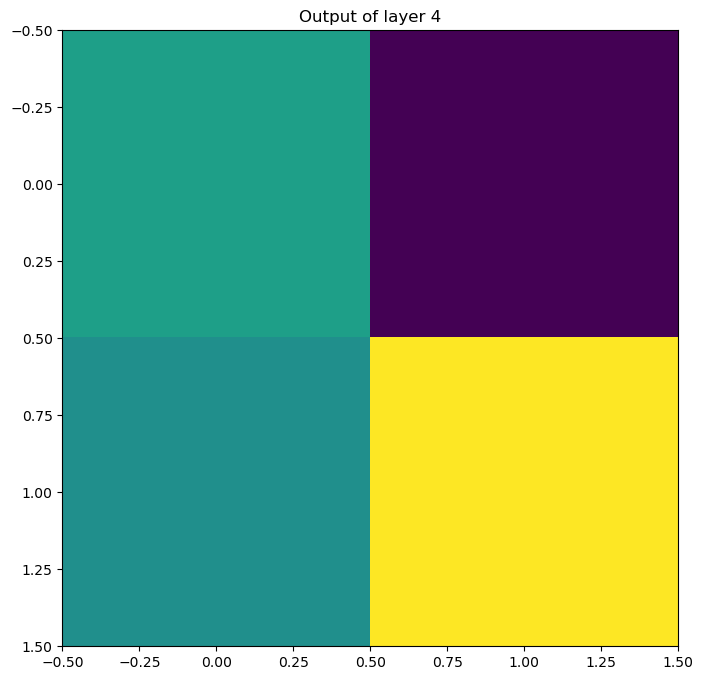

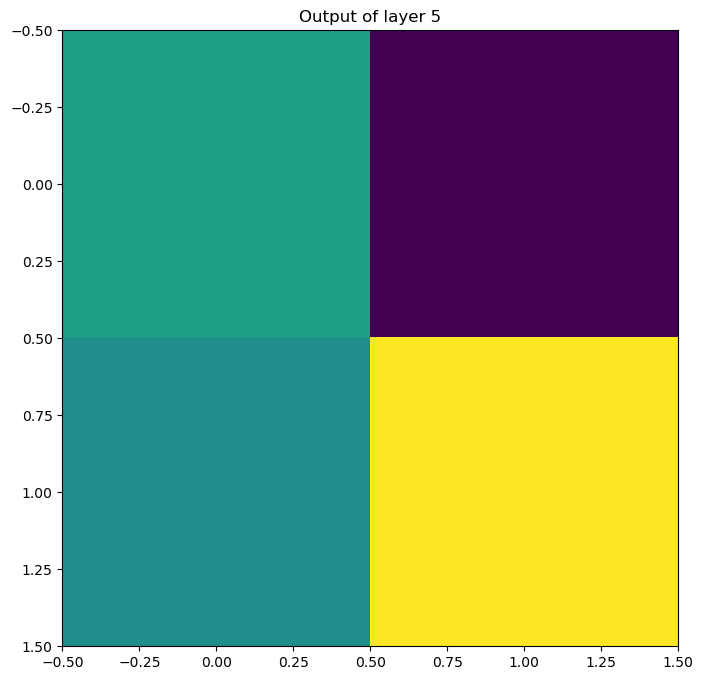

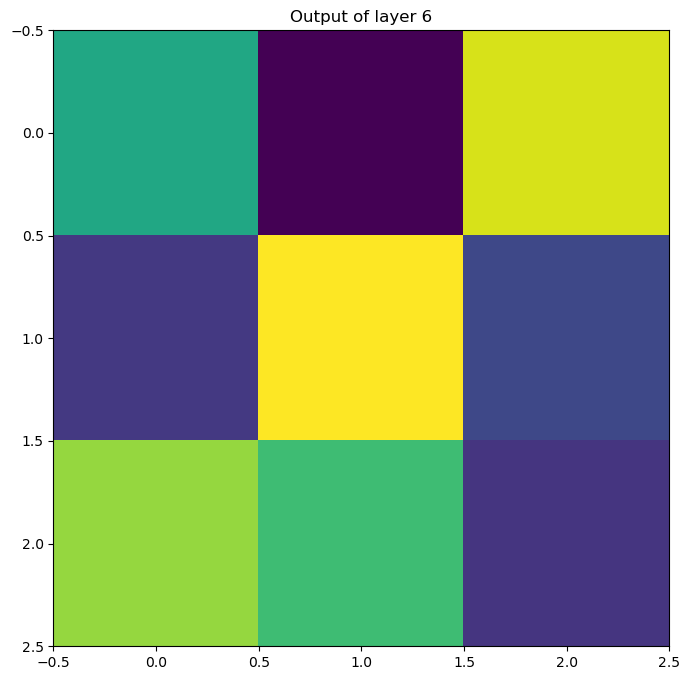

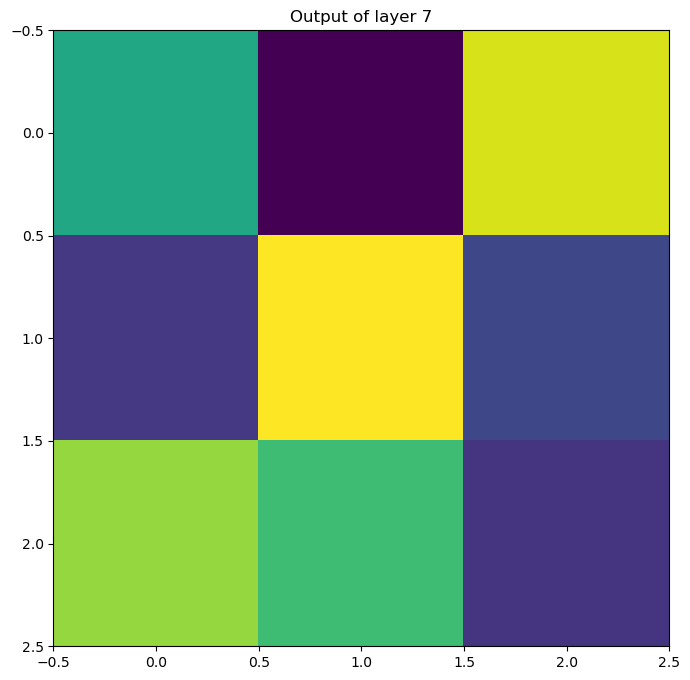

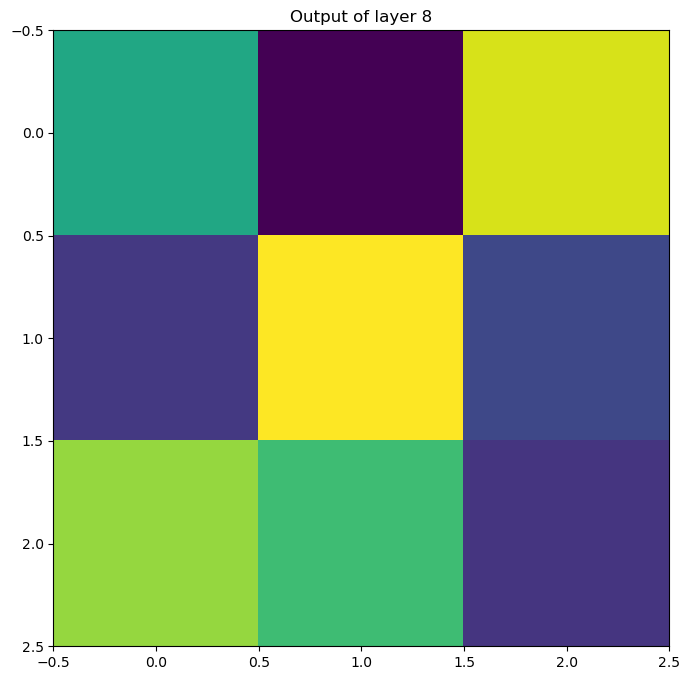

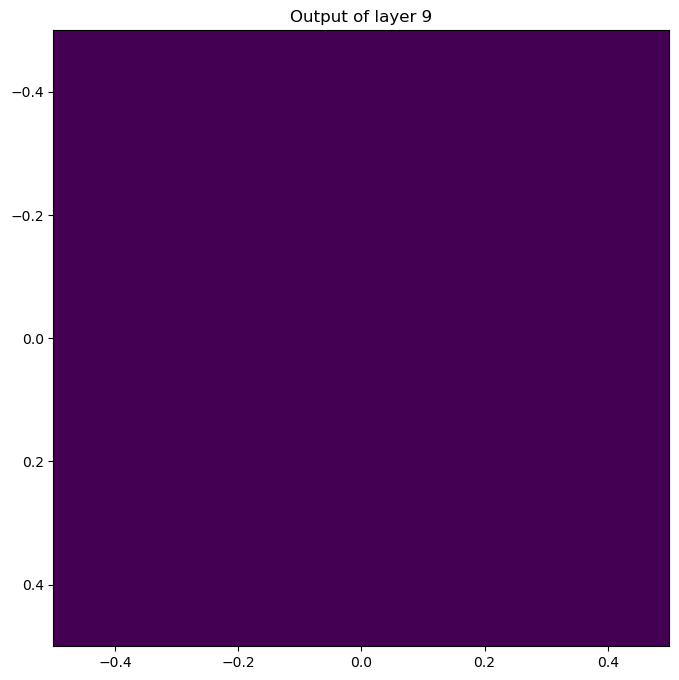

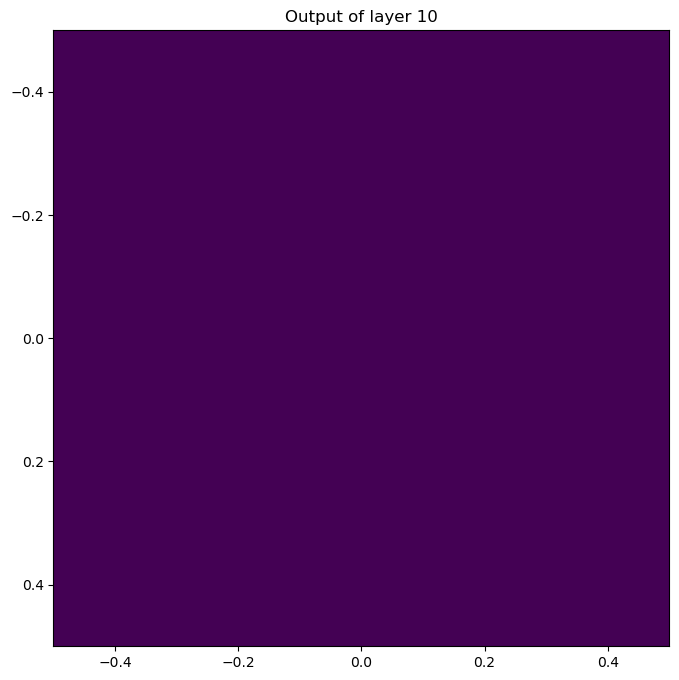

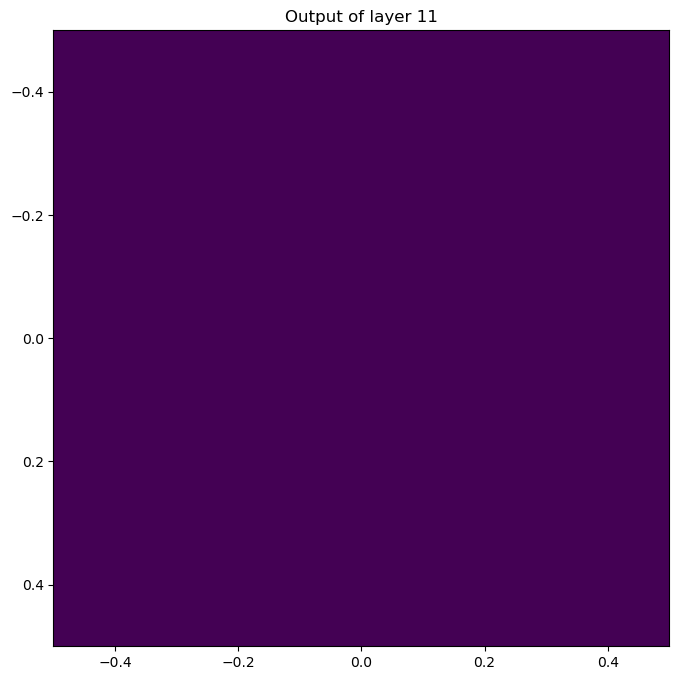

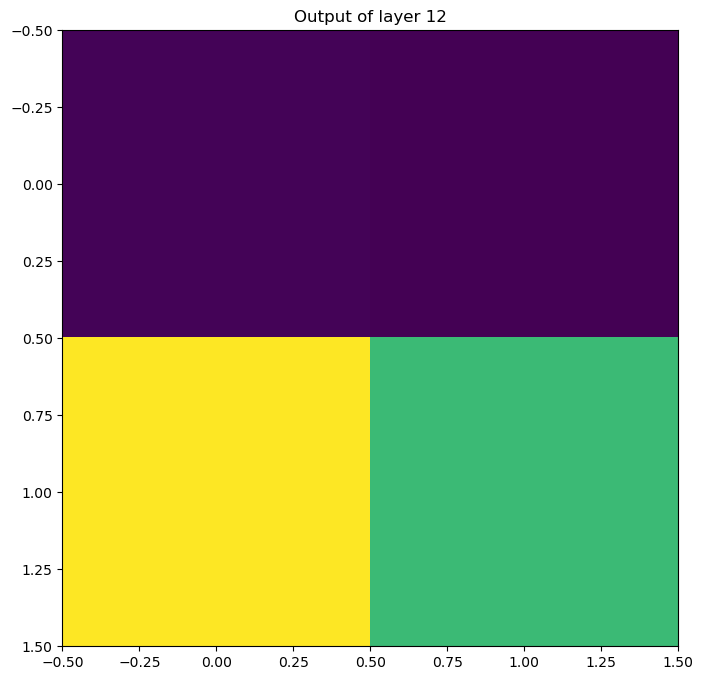

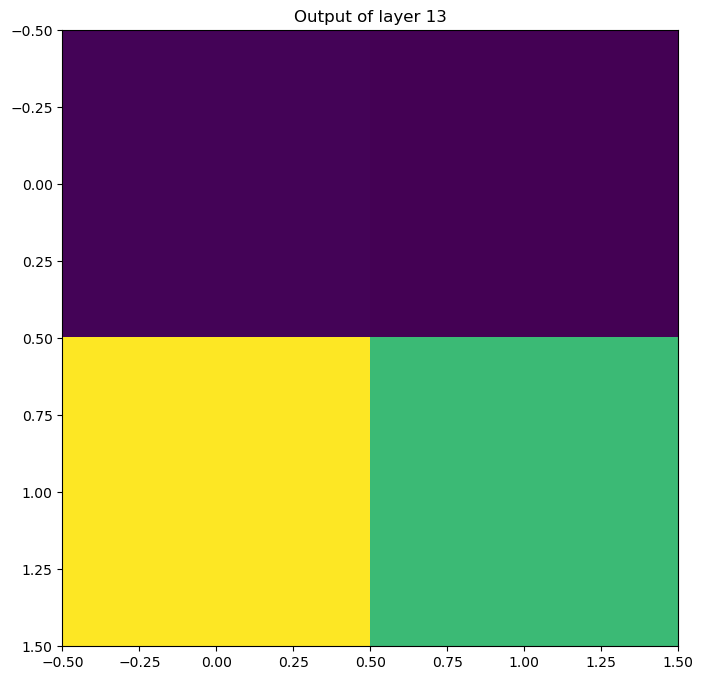

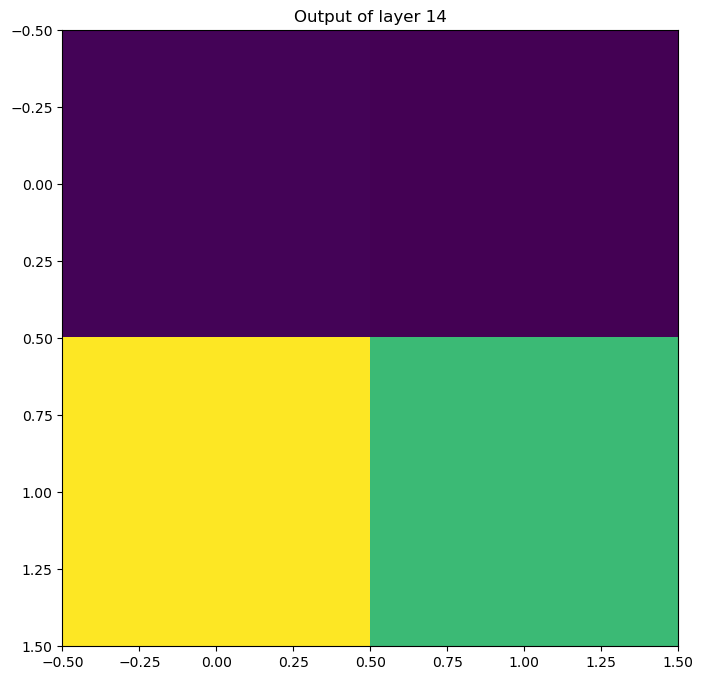

In [74]:
# Define a container to store the outputs
outputs = []

def hook(module, input, output):
    outputs.append(output)

# Register the hook for each Conv layer
for name, module in policy_net.named_modules():
    if isinstance(module, torch.nn.modules.conv.Conv2d):
        module.register_forward_hook(hook)

# Run your model on an input
S = encode_state(env.get_flat_board())
S = torch.tensor(S, dtype=torch.float32, device=device)
output = policy_net(S.view(1, 16, 4, 4))

# Now `outputs` contains the output of each Conv layer
for i, output in enumerate(outputs):
    # The output is a PyTorch Tensor, convert it to numpy array first
    output = output.data.cpu().numpy()

    # Plot the output
    plt.figure()
    plt.title(f"Output of layer {i}")
    plt.imshow(output[0, 0])
    plt.show()

In [81]:
print(np.mean(output, axis=1))

[[[2.340027  2.7707262]
  [3.1969957 3.2688842]]]


In [78]:
print(env.board)
# Now `outputs` contains the output of each Conv layer
for i, output in enumerate(outputs):
    # The output is a PyTorch Tensor, convert it to numpy array first
    output = output.data.cpu().numpy()

    # Print the output
    print(f"Output of layer {i}:")
    print(output[0, 0, :10, :10])

[[  2   2   0   0]
 [  2   4  16   4]
 [  8  32   8   2]
 [ 16 128  32  16]]
Output of layer 0:
[[0.2868981]]
Output of layer 1:
[[0.2868981]]
Output of layer 2:
[[0.2868981]]
Output of layer 3:
[[-0.03711586 -0.20765345]
 [-0.05751407  0.09442399]]
Output of layer 4:
[[-0.03711586 -0.20765345]
 [-0.05751407  0.09442399]]
Output of layer 5:
[[-0.03711586 -0.20765345]
 [-0.05751407  0.09442399]]
Output of layer 6:
[[-0.04387295 -0.24758361  0.07522652]
 [-0.19059503  0.09539139 -0.17339051]
 [ 0.04145193 -0.01156907 -0.1947245 ]]
Output of layer 7:
[[-0.04387295 -0.24758361  0.07522652]
 [-0.19059503  0.09539139 -0.17339051]
 [ 0.04145193 -0.01156907 -0.1947245 ]]
Output of layer 8:
[[-0.04387295 -0.24758361  0.07522652]
 [-0.19059503  0.09539139 -0.17339051]
 [ 0.04145193 -0.01156907 -0.1947245 ]]
Output of layer 9:
[[5.6683946]]
Output of layer 10:
[[5.6683946]]
Output of layer 11:
[[5.6683946]]
Output of layer 12:
[[7.685397 7.66409 ]
 [9.975632 9.235789]]
Output of layer 13:
[[7.685